In [1]:
datadir = '../Datasets/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter

### QUESTION 1 
(P) For each of the three GitHub Developers graphs (the ml devel-
opers, the web developers, and the original one), do the following:
a) plot the degree correlation function knn(`) and its uncorrelated counterpart ^knn(`); b) nd the degree correlation coecient r,
c) nd the correlation exponent , d) plot the rich-club coecient
(`).

In [3]:
## read the GitHub edge list into a graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)
## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

### The orginal one

In [4]:
#degree correlation function
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v)))]
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

#degree correlation function for neutral graph
def deg_corr_random(G):
    deg = G.degree()
    L = []
    for v in G.vs():
        w = [deg[i] for i in list(set(G.neighbors(v)))]
        L.extend(w)
    return np.mean(L)

## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    # Fit the regression
    regressor = LinearRegression()  
    x = [np.log(i) for i in knn.keys()]
    y = [np.log(i) for i in knn.values()]
    regressor.fit(np.array(x).reshape(-1,1), y)
    return regressor.coef_[0]

#rich club coeff function
def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat 

### For Original Github Developer graph

correlation coef - r 441.020594941921


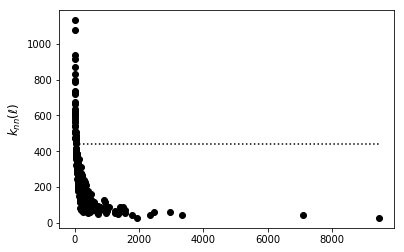

In [5]:
#using degree correlation function for gh (github) graph
knn = deg_corr(gh)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(gh)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("correlation coef - r", r)

In [6]:
k = corr_exp(gh)
l = richClub(gh, l=1)
print("correlation exp", k)
print("rich club coef", l)

correlation exp -0.5076879013701244
rich club coef 1.0


Text(0.5, 1.0, 'Rich club coeff plot')

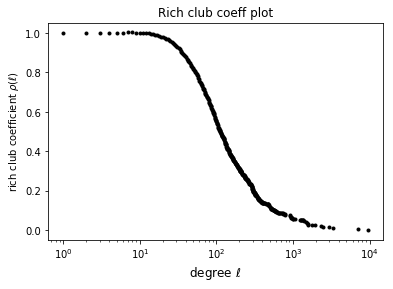

In [46]:
d = list(set(gh.degree()))
rc = []
for i in d:
    rc.append(richClub(gh, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
plt.title("Rich club coeff plot")

### FOR ML Developers

In [8]:
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])

/Users/user/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


correlation coef - r 36.436801463117256


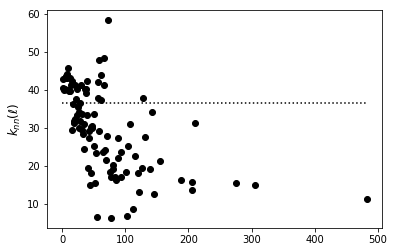

In [9]:
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(gh_ml)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("correlation coef - r", r)

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


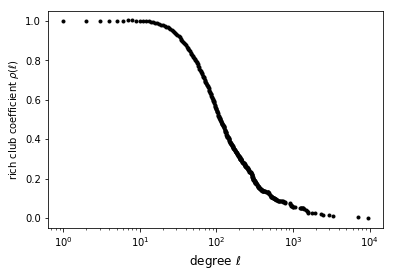

In [10]:
knn = deg_corr(gh_ml)

 # Fit the regression
regressor = LinearRegression()  

x = [np.log(i) for i in knn.keys()]
y = [np.log(i) for i in knn.values()]
x.pop(0)
x = x## looking for rich club -- not here!
d = list(set(gh.degree()))
rc = []
for i in d:
    rc.append(richClub(gh, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
#plt.savefig('rich_club.eps');
y.pop(0)
y = y

In [11]:
k = regressor.fit(np.array(x).reshape(-1,1), y)
print("corr exponent", regressor.coef_[0])
l = richClub(gh_ml, l=1)
print("rich club coef", l)

corr exponent -0.2514234876818035
rich club coef 1.0000000000000007


Text(0.5, 1.0, 'Rich club coeff plot')

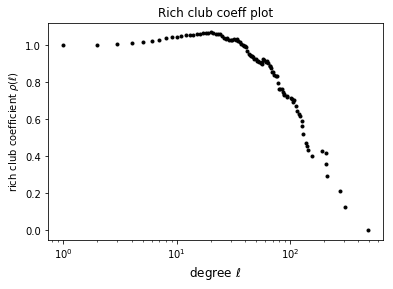

In [47]:
d = list(set(gh_ml.degree()))
rc = []
for i in d:
    rc.append(richClub(gh_ml, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
plt.title("Rich club coeff plot")

### FOR WEB DEVELOPERS

In [13]:
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])
gh_web.vcount()

27961

/Users/user/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


correlation coef - r 420.3915627518108


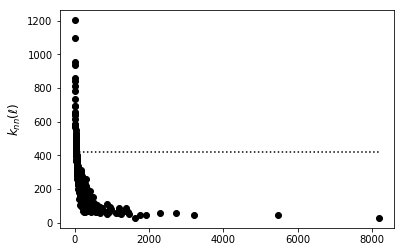

In [14]:
knn = deg_corr(gh_web)
x = list(knn.keys())
y = list(knn.values())
r = deg_corr_random(gh_web)
plt.scatter(x,y,c='black')
plt.hlines(y=r,xmin=min(x),xmax=max(x),linestyles=':')
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("correlation coef - r", r)

In [15]:
knn = deg_corr(gh_web)

 # Fit the regression
regressor = LinearRegression()  

x = [np.log(i) for i in knn.keys()]
y = [np.log(i) for i in knn.values()]
x.pop(0)
x = x
y.pop(0)
y = y

/Users/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [16]:
k = regressor.fit(np.array(x).reshape(-1,1), y)
print("corr exponent", regressor.coef_[0])
l = richClub(gh_web, l=1)
print("rich club coef", l)

corr exponent -0.5151040696086916
rich club coef 1.0000000000000002


Text(0.5, 1.0, 'Rich club coeff plot')

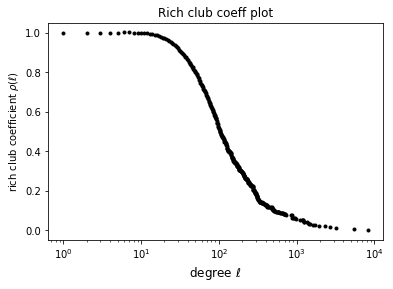

In [48]:
d = list(set(gh_web.degree()))
rc = []
for i in d:
    rc.append(richClub(gh_web, l=i))
plt.semilogx(d,rc,'.',c='black')
plt.xlabel(r'degree $\ell$',fontsize=12)
plt.ylabel(r'rich club coefficient $\rho(\ell)$');
plt.title("Rich club coeff plot")

### QUESTION 2
(P) Start with the original GitHub Developers graph, apply switch-
ing method to get the randomized degree correlation function
knn(`). Compare it with the degree correlation function knn(`) and
its uncorrelated counterpart ^knn(`). What is the conclusion?

In [49]:
## read the GitHub edge list into a graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)
## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [50]:
gh.is_simple()

True

#### Performing the switching algorithm on ML developers subgraph. I tried running the algorithm on original Github developers but it took over 4 hours and it was still running.

In [51]:
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_ml.ecount()

19684

Text(0.5, 1.0, 'ML Developer Degree Correlation before switching')

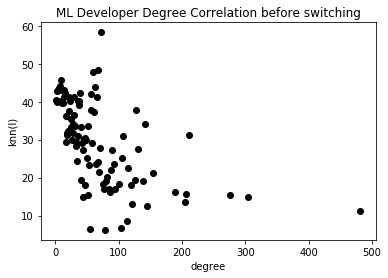

In [53]:
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x,y,c='black')
plt.xlabel("degree")
plt.ylabel("knn(l)")
plt.title("ML Developer Degree Correlation before switching")

In [29]:
gh_ml.es['touched'] = False
ec= gh_ml.ecount()
while True:
    re = np.random.choice(ec, 2, replace=False)
    nodes = list(gh_ml.es[re[0]].tuple+gh_ml.es[re[1]].tuple)
    e1 = (nodes[0],nodes[2])
    e2 = (nodes[1],nodes[3])
    gh_ml.delete_edges(re)
    gh_ml.add_edge(e1[0],e1[1],touched=True)
    gh_ml.add_edge(e2[0],e2[1],touched=True)
    if gh_ml.is_simple()==True:
        print(e1,e2)
        print('simple')
    else:
        gh_ml.delete_edges(e1)
        gh_ml.delete_edges(e2)
        gh_ml.add_edge(nodes[0],nodes[1],touched=True)
        gh_ml.add_edge(nodes[2],nodes[3],touched=True)
        print('not_simple')
    if sum(gh_ml.es['touched']) == gh_ml.ecount():
        break



(335, 2598) (451, 6365)
simple
(112, 305) (5504, 673)
simple
(94, 546) (4050, 8875)
simple
(335, 4375) (388, 4376)
simple
(204, 1966) (4322, 6426)
simple
(133, 3339) (6238, 4264)
simple
(3907, 1399) (4231, 5135)
simple
(273, 286) (1966, 291)
simple
(160, 1197) (5191, 3973)
simple
(1129, 1770) (2175, 6342)
simple
(100, 474) (5566, 869)
simple
(548, 307) (7057, 610)
simple
(943, 5819) (4056, 6491)
simple
(165, 166) (997, 659)
simple
(256, 112) (5621, 1655)
simple
(5291, 835) (5296, 1882)
simple
(488, 918) (579, 2481)
simple
(72, 1626) (671, 3184)
simple
(248, 721) (6080, 723)
simple
(3109, 1869) (3622, 3714)
simple
(623, 906) (1716, 1720)
simple
(1675, 46) (3579, 1785)
simple
(432, 296) (2753, 4863)
simple
(6038, 939) (8061, 2865)
simple
(767, 248) (6293, 2374)
simple
(424, 211) (8682, 507)
simple
(1440, 249) (6004, 386)
simple
(490, 133) (8443, 823)
simple
(185, 1871) (3542, 7404)
simple
(971, 1239) (4085, 3460)
simple
(5147, 1918) (8340, 8810)
simple
(424, 2136) (513, 5876)
simple
(400

(2940, 296) (5494, 7735)
simple
(437, 1915) (5932, 4997)
simple
(610, 148) (6561, 8884)
simple
(248, 361) (2589, 376)
simple
(979, 2848) (4101, 5242)
simple
(821, 100) (2018, 952)
simple
(2919, 3391) (6767, 7224)
simple
(4271, 112) (4274, 2533)
simple
(2909, 892) (4795, 5977)
simple
(235, 274) (237, 7995)
simple
(474, 1612) (839, 1619)
simple
(4178, 889) (8670, 1612)
simple
(482, 967) (1200, 1655)
simple
(1652, 5277) (2674, 9003)
simple
(228, 844) (229, 8815)
simple
(521, 1724) (7057, 5695)
simple
(109, 150) (6300, 2361)
simple
(6169, 1335) (7816, 3460)
simple
(225, 529) (3801, 994)
simple
(454, 3198) (8552, 3199)
simple
(2335, 548) (5681, 2361)
simple
(248, 943) (4795, 3984)
simple
not_simple
(4164, 335) (4165, 7549)
simple
(1335, 1404) (1550, 2105)
simple
(1069, 1415) (3378, 8551)
simple
(5366, 186) (5369, 224)
simple
(435, 567) (3758, 1016)
simple
(2523, 404) (3873, 9383)
simple
(3109, 4153) (3534, 7206)
simple
(299, 1487) (4158, 1731)
simple
(296, 2328) (2630, 4663)
simple
(495, 14

(4204, 1346) (4251, 3626)
simple
(1977, 2863) (4680, 6001)
simple
(5492, 767) (9333, 1764)
simple
(829, 378) (994, 501)
simple
not_simple
(400, 175) (1887, 2291)
simple
(622, 175) (3459, 2998)
simple
(3722, 100) (3723, 5240)
simple
(46, 424) (1001, 4497)
simple
(2291, 667) (7781, 4501)
simple
(819, 1821) (1714, 9074)
simple
(1456, 1305) (3630, 2045)
simple
(1494, 3205) (3335, 6541)
simple
(6989, 3809) (6990, 3816)
simple
(25, 626) (1690, 3604)
simple
(693, 651) (714, 4231)
simple
(3675, 1107) (4247, 9032)
simple
(8504, 6324) (8505, 9401)
simple
(206, 1213) (4309, 3419)
simple
(3460, 482) (5952, 967)
simple
(622, 206) (5287, 6155)
simple
(4441, 123) (7780, 7664)
simple
(579, 1070) (1870, 3389)
simple
(204, 125) (5839, 435)
simple
(2728, 3207) (2862, 4408)
simple
(275, 2742) (3086, 5350)
simple
(3032, 655) (5261, 9068)
simple
(204, 128) (5850, 554)
simple
(4314, 1666) (5681, 1668)
simple
(611, 367) (612, 373)
simple
(804, 2786) (2723, 4053)
simple
(1480, 185) (9382, 5610)
simple
(1168, 9

(3322, 8126) (8257, 9123)
simple
(1346, 816) (6505, 7923)
simple
(804, 3891) (3617, 5246)
simple
(248, 548) (1937, 5820)
simple
(584, 1628) (4001, 5447)
simple
(347, 853) (1061, 9151)
simple
(209, 819) (7894, 2582)
simple
(296, 1969) (1966, 9361)
simple
(484, 207) (5961, 853)
simple
(209, 451) (823, 779)
simple
(2603, 1580) (6883, 3187)
simple
not_simple
not_simple
not_simple
not_simple
not_simple
(943, 1270) (1535, 1278)
simple
(2184, 150) (7336, 3970)
simple
(6487, 133) (7087, 5579)
simple
(5091, 7164) (5092, 7165)
simple
(1299, 554) (3086, 5850)
simple
(399, 2463) (1862, 2798)
simple
(1162, 248) (1164, 2935)
simple
(3006, 498) (4323, 2582)
simple
(312, 240) (4551, 3669)
simple
(1333, 75) (3978, 1781)
simple
(628, 19) (6131, 1737)
simple
not_simple
(2116, 2227) (5294, 3004)
simple
(880, 294) (3374, 865)
simple
(3941, 2481) (9668, 3642)
simple
(400, 190) (2333, 3648)
simple
(1277, 5202) (1918, 5203)
simple
(4325, 112) (4753, 3065)
simple
(1969, 128) (3444, 5857)
simple
(248, 1069) (84

not_simple
(6956, 435) (7970, 626)
simple
(171, 610) (372, 8852)
simple
not_simple
(3155, 206) (4274, 944)
simple
(172, 401) (1138, 2905)
simple
(171, 3106) (626, 3348)
simple
(1542, 450) (1796, 453)
simple
(778, 548) (779, 628)
simple
(5819, 190) (6820, 758)
simple
(610, 112) (3750, 6534)
simple
(155, 6080) (6038, 7758)
simple
(435, 3511) (4489, 3623)
simple
(424, 385) (8691, 3050)
simple
(160, 295) (5484, 4325)
simple
(1397, 1867) (1427, 3253)
simple
(112, 20) (7209, 7758)
simple
not_simple
(1617, 1203) (6385, 4334)
simple
(336, 725) (4445, 2860)
simple
(325, 477) (1871, 1489)
simple
(97, 1409) (2476, 2266)
simple
(150, 3989) (493, 3991)
simple
(485, 818) (1445, 2500)
simple
(6069, 205) (6743, 1703)
simple
(112, 125) (5401, 955)
simple
(1001, 2374) (3644, 3798)
simple
(486, 2566) (2738, 3348)
simple
(5775, 128) (5970, 2184)
simple
not_simple
(174, 730) (4799, 1418)
simple
(274, 390) (5178, 858)
simple
(2335, 2560) (8394, 3287)
simple
(2763, 3427) (7761, 4497)
simple
(2740, 1951) (873

(358, 204) (3389, 4423)
simple
(5497, 904) (6916, 1001)
simple
(401, 6953) (4040, 7331)
simple
(1027, 81) (5659, 248)
simple
(516, 2647) (5230, 2920)
simple
(424, 8) (2517, 249)
simple
(1826, 231) (5013, 7500)
simple
not_simple
(1023, 513) (1026, 4065)
simple
(752, 844) (1677, 2380)
simple
(126, 3659) (3178, 5446)
simple
(6017, 1068) (9070, 1073)
simple
(668, 485) (4018, 2105)
simple
(185, 487) (3000, 1200)
simple
(1942, 1226) (3838, 3892)
simple
(1456, 730) (2996, 2207)
simple
(224, 994) (1445, 5572)
simple
(6335, 2582) (7462, 4323)
simple
(133, 1498) (2214, 2123)
simple
(39, 2475) (1584, 2759)
simple
(325, 214) (4417, 4329)
simple
(133, 1841) (401, 3618)
simple
(1565, 1440) (4112, 7578)
simple
not_simple
(2187, 2856) (4169, 3745)
simple
(301, 76) (1043, 671)
simple
(3425, 865) (3750, 7217)
simple
(5382, 174) (9076, 2913)
simple
(39, 3963) (3645, 3964)
simple
not_simple
(1050, 1016) (2195, 1027)
simple
(750, 172) (761, 251)
simple
(529, 4051) (2992, 5488)
simple
(8869, 853) (8870, 371

not_simple
(3416, 165) (5143, 382)
simple
(680, 94) (1619, 1280)
simple
(474, 2646) (837, 5741)
simple
(1759, 146) (3173, 424)
simple
(2647, 326) (7888, 3209)
simple
not_simple
(244, 859) (2736, 1715)
simple
(150, 326) (481, 3650)
simple
(1168, 1716) (4490, 1855)
simple
(630, 333) (844, 1406)
simple
(305, 2517) (3768, 2925)
simple
(206, 133) (5306, 3384)
simple
(1912, 828) (4192, 2317)
simple
(174, 4512) (921, 4717)
simple
(7010, 5263) (9254, 9666)
simple
(862, 12) (3165, 248)
simple
(1112, 204) (2927, 5107)
simple
(459, 274) (970, 5471)
simple
(655, 1307) (1003, 2657)
simple
(556, 109) (5497, 3778)
simple
(5208, 4972) (5468, 6562)
simple
(5327, 1392) (8414, 2738)
simple
(160, 13) (415, 848)
simple
(1165, 1843) (1168, 2169)
simple
(1213, 793) (4372, 1201)
simple
not_simple
(1747, 209) (1771, 3594)
simple
(265, 207) (6576, 2249)
simple
(2284, 461) (3036, 6950)
simple
(1707, 2218) (1708, 2702)
simple
(5460, 39) (6948, 728)
simple
(209, 1767) (466, 2927)
simple
(1703, 767) (2560, 7255)
si

not_simple
not_simple
(3207, 827) (7971, 1759)
simple
(1278, 363) (2075, 4308)
simple
not_simple
(432, 3754) (831, 7754)
simple
(3115, 4643) (5079, 4644)
simple
(356, 338) (4351, 2326)
simple
(264, 3839) (564, 3841)
simple
(2450, 4888) (9093, 6840)
simple
(1885, 1118) (2851, 4690)
simple
(750, 145) (757, 2907)
simple
(1983, 1107) (4771, 5434)
simple
(1861, 2708) (8268, 6152)
simple
(1494, 2903) (2714, 4985)
simple
(448, 630) (1405, 8026)
simple
(1083, 888) (4845, 1412)
simple
(556, 6116) (1462, 7988)
simple
(4169, 2000) (5070, 3349)
simple
(888, 4326) (7629, 7697)
simple
(270, 630) (970, 2828)
simple
(832, 106) (1894, 124)
simple
(869, 175) (5566, 400)
simple
(265, 158) (949, 4024)
simple
(1688, 424) (6881, 4543)
simple
(2022, 40) (3662, 325)
simple
(1170, 655) (4969, 4139)
simple
(196, 851) (7812, 3325)
simple
(2410, 100) (2627, 1983)
simple
(1112, 132) (5263, 6985)
simple
(483, 147) (1206, 400)
simple
(2061, 355) (2242, 5504)
simple
(921, 50) (8106, 1380)
simple
(1202, 1974) (1473, 4

(2568, 42) (6420, 2723)
simple
(100, 5360) (764, 6777)
simple
(1109, 740) (3867, 853)
simple
not_simple
(1067, 1089) (6471, 1340)
simple
(401, 82) (2514, 5171)
simple
(2262, 174) (9553, 3020)
simple
not_simple
(907, 2305) (5553, 3994)
simple
(1186, 248) (4925, 8429)
simple
(941, 3269) (1937, 3276)
simple
(2374, 305) (2740, 2515)
simple
(507, 274) (686, 3385)
simple
(2386, 50) (3358, 921)
simple
(248, 187) (3594, 3672)
simple
(811, 3378) (3810, 5030)
simple
(1570, 3159) (2544, 8787)
simple
not_simple
(548, 1702) (670, 1703)
simple
(1170, 632) (1895, 5013)
simple
(853, 5296) (5820, 5739)
simple
(4524, 424) (4924, 6777)
simple
(1871, 474) (2889, 842)
simple
(363, 185) (8500, 2546)
simple
(943, 831) (4876, 3426)
simple
(2905, 5178) (3064, 5282)
simple
(1026, 5588) (3504, 6929)
simple
(498, 100) (4394, 6959)
simple
(853, 240) (1232, 1937)
simple
(626, 106) (2617, 832)
simple
(150, 481) (1388, 484)
simple
(651, 2913) (2196, 6952)
simple
(435, 86) (736, 3552)
simple
(5133, 150) (5135, 6455)
s

(1703, 3554) (7883, 4016)
simple
(296, 133) (400, 431)
simple
(477, 866) (5611, 4160)
simple
(89, 1703) (90, 3213)
simple
(4922, 1381) (7655, 1897)
simple
(247, 1106) (248, 1980)
simple
(1502, 400) (4125, 1360)
simple
(112, 4645) (6849, 6503)
simple
not_simple
(94, 174) (4115, 4629)
simple
(780, 767) (781, 7330)
simple
not_simple
(686, 133) (1445, 210)
simple
(1703, 112) (2163, 6434)
simple
(4930, 2687) (6355, 3137)
simple
(1440, 248) (1983, 3420)
simple
(220, 3386) (5283, 5006)
simple
(325, 25) (2331, 6206)
simple
(1021, 355) (1084, 2061)
simple
(248, 1230) (1186, 5007)
simple
(628, 2646) (3169, 2984)
simple
(539, 366) (540, 2945)
simple
(3175, 534) (3176, 5178)
simple
(1168, 3460) (3376, 7051)
simple
(112, 831) (9165, 979)
simple
(171, 614) (5483, 1770)
simple
(1427, 419) (2508, 1344)
simple
not_simple
(2298, 100) (4349, 209)
simple
(4742, 2364) (5471, 5583)
simple
(148, 4206) (8716, 7548)
simple
(400, 376) (3538, 435)
simple
(870, 486) (5718, 2566)
simple
(889, 709) (1335, 6665)
sim

(4614, 5445) (4684, 6038)
simple
(3380, 428) (5065, 904)
simple
(2284, 4886) (2647, 8390)
simple
(206, 1264) (474, 3472)
simple
(754, 2257) (1676, 2735)
simple
(448, 535) (556, 2364)
simple
(3816, 94) (5999, 5046)
simple
(2743, 343) (6263, 8461)
simple
(925, 1301) (6877, 1302)
simple
(1821, 104) (7202, 1611)
simple
(3165, 312) (7462, 333)
simple
(1896, 3584) (3147, 6562)
simple
(2139, 3036) (2738, 4412)
simple
(224, 248) (802, 670)
simple
(2310, 519) (2620, 529)
simple
(612, 900) (3867, 3754)
simple
(3349, 548) (5070, 831)
simple
(3468, 4112) (5681, 5445)
simple
(4345, 360) (6547, 3412)
simple
(536, 79) (832, 81)
simple
(220, 1142) (880, 1143)
simple
(901, 1620) (3034, 3077)
simple
(2535, 921) (7303, 4717)
simple
(369, 686) (2517, 3268)
simple
(844, 1069) (855, 3376)
simple
(449, 1117) (6534, 2458)
simple
(907, 648) (1715, 651)
simple
(1463, 400) (2493, 8404)
simple
(2164, 3144) (3525, 3146)
simple
(837, 2008) (7984, 2468)
simple
(1397, 378) (8566, 2858)
simple
(925, 2600) (1811, 3307)

(7397, 1543) (8898, 3836)
simple
(240, 994) (6561, 1715)
simple
(8477, 2913) (9375, 5470)
simple
not_simple
(880, 1399) (6581, 3907)
simple
(628, 273) (4554, 472)
simple
(248, 174) (2137, 248)
simple
(248, 151) (6653, 565)
simple
(2928, 2607) (3428, 3495)
simple
(536, 296) (3468, 651)
simple
(754, 1352) (764, 7151)
simple
(1117, 424) (3798, 8225)
simple
(165, 431) (3305, 6603)
simple
(4775, 39) (4776, 5530)
simple
(82, 240) (1942, 1954)
simple
(349, 447) (424, 2911)
simple
(2683, 156) (4926, 178)
simple
(1781, 836) (4050, 1544)
simple
(4349, 4188) (4350, 7949)
simple
(2574, 1448) (8009, 4520)
simple
(4394, 11) (6959, 3874)
simple
(116, 461) (459, 2656)
simple
(755, 631) (2156, 853)
simple
not_simple
(273, 291) (5284, 9654)
simple
(2205, 1186) (3159, 4933)
simple
not_simple
(305, 826) (3359, 3900)
simple
(5838, 756) (9479, 1948)
simple
(67, 295) (1912, 921)
simple
(2876, 274) (5571, 459)
simple
(401, 823) (1873, 2934)
simple
(100, 2258) (2233, 3649)
simple
(3200, 949) (4444, 7322)
simpl

(391, 1951) (1219, 3778)
simple
(7091, 436) (7721, 2567)
simple
(548, 454) (2338, 1901)
simple
not_simple
not_simple
(40, 511) (2022, 2678)
simple
(5252, 424) (9380, 1061)
simple
(943, 224) (1849, 1130)
simple
(1427, 4136) (2502, 5861)
simple
(400, 1253) (431, 1254)
simple
(3474, 296) (3483, 6562)
simple
not_simple
(4239, 1897) (5139, 3415)
simple
(488, 2340) (2502, 9324)
simple
(3809, 5858) (6989, 6038)
simple
(6288, 630) (7224, 3319)
simple
not_simple
not_simple
(3050, 630) (4823, 3093)
simple
(730, 481) (1767, 1394)
simple
(158, 116) (424, 3053)
simple
(527, 3036) (7594, 7868)
simple
(1436, 1023) (2291, 1628)
simple
(2247, 305) (7298, 2787)
simple
(209, 1107) (1165, 1492)
simple
(2630, 1714) (2738, 1926)
simple
(1774, 204) (7500, 3094)
simple
(4020, 240) (5287, 400)
simple
(4442, 1061) (5927, 8202)
simple
(994, 858) (6811, 4925)
simple
(485, 424) (4326, 1443)
simple
(784, 93) (1435, 6882)
simple
(1716, 274) (6101, 534)
simple
(150, 4267) (3996, 5027)
simple
(244, 2698) (1168, 4779)


(2481, 1619) (3910, 1937)
simple
(1436, 2905) (2723, 6737)
simple
(297, 25) (312, 823)
simple
(206, 779) (358, 823)
simple
(1275, 248) (1280, 3030)
simple
(736, 928) (4178, 5949)
simple
(870, 1112) (2220, 5206)
simple
(2000, 45) (5375, 226)
simple
(220, 249) (2881, 5491)
simple
(831, 2272) (7754, 3960)
simple
(4073, 1721) (5059, 2863)
simple
(164, 424) (424, 8686)
simple
(209, 1201) (892, 5377)
simple
(93, 1212) (621, 6157)
simple
(2749, 136) (8601, 4734)
simple
(610, 306) (1934, 3301)
simple
(325, 501) (1023, 1025)
simple
(7176, 714) (7177, 4924)
simple
(2237, 2204) (8436, 3184)
simple
(853, 1706) (2065, 8333)
simple
(994, 3229) (7161, 5443)
simple
(2353, 326) (7312, 4881)
simple
(185, 12) (5445, 1004)
simple
(3343, 1200) (3542, 1201)
simple
(2861, 435) (3465, 1217)
simple
(4727, 2252) (5326, 5871)
simple
(610, 148) (8848, 2729)
simple
not_simple
(134, 511) (7758, 6247)
simple
(1445, 951) (3166, 954)
simple
(8240, 3416) (8241, 3749)
simple
(1897, 1782) (7655, 4231)
simple
(3933, 470) 

(400, 1016) (2515, 1026)
simple
(82, 3075) (1194, 4407)
simple
(3254, 185) (4926, 554)
simple
(1900, 2582) (2187, 8043)
simple
(892, 3273) (3874, 3415)
simple
(930, 584) (5332, 2294)
simple
(779, 1716) (3293, 1720)
simple
(3073, 4378) (3665, 8192)
simple
not_simple
(2992, 2157) (6490, 2735)
simple
(133, 367) (3271, 1025)
simple
(653, 272) (661, 4112)
simple
(468, 435) (1645, 1764)
simple
(424, 3032) (1812, 6824)
simple
(172, 1215) (1779, 6859)
simple
(2858, 1119) (4419, 2680)
simple
(842, 4192) (2805, 6522)
simple
(556, 548) (2335, 1481)
simple
(3055, 195) (3425, 1069)
simple
(3352, 832) (3354, 1375)
simple
(424, 1866) (3577, 1878)
simple
(5326, 125) (5327, 985)
simple
(2500, 879) (6299, 5970)
simple
(198, 692) (1458, 5386)
simple
(853, 1703) (1716, 3589)
simple
not_simple
(2783, 3019) (4297, 3665)
simple
(2015, 6324) (5840, 8504)
simple
(294, 701) (880, 5025)
simple
(912, 3558) (929, 7060)
simple
(1557, 340) (2477, 5843)
simple
(730, 571) (2753, 1890)
simple
(974, 853) (2286, 2916)
si

(213, 1715) (548, 2607)
simple
(312, 305) (4190, 701)
simple
(2196, 1619) (2458, 2907)
simple
not_simple
(2105, 2925) (3807, 5132)
simple
(610, 3645) (3383, 4211)
simple
(5188, 853) (7043, 2886)
simple
(200, 2043) (2664, 3990)
simple
(714, 890) (3354, 8525)
simple
(1715, 3075) (6561, 5908)
simple
(177, 2471) (6884, 9041)
simple
(3836, 112) (8016, 1703)
simple
(8501, 1676) (8502, 6811)
simple
(2432, 400) (4376, 3079)
simple
(1388, 174) (2569, 1695)
simple
(305, 4667) (875, 4838)
simple
(1193, 3425) (2770, 3994)
simple
(58, 824) (3071, 1642)
simple
(4753, 209) (6799, 732)
simple
(134, 248) (1061, 706)
simple
(853, 1188) (1460, 4953)
simple
(324, 2481) (548, 5802)
simple
(459, 6281) (1438, 6812)
simple
not_simple
(393, 5290) (2361, 8375)
simple
(248, 1619) (3165, 4239)
simple
(2364, 220) (3424, 5631)
simple
(225, 485) (378, 1404)
simple
(222, 5631) (3071, 5632)
simple
(333, 456) (511, 4408)
simple
(248, 1494) (781, 2190)
simple
not_simple
(2317, 12) (7894, 4884)
simple
not_simple
(655, 27

(553, 651) (8961, 1638)
simple
(2992, 730) (5488, 1860)
simple
(165, 2723) (1703, 6737)
simple
(209, 148) (820, 4369)
simple
(2717, 548) (6173, 5245)
simple
(854, 2753) (1661, 4863)
simple
(118, 979) (175, 2848)
simple
(3875, 887) (6932, 1669)
simple
(1053, 454) (4546, 3834)
simple
(535, 890) (6349, 5000)
simple
(1165, 191) (1843, 4508)
simple
(126, 1164) (2990, 4050)
simple
(1304, 4925) (1305, 8429)
simple
(1502, 1619) (3104, 2500)
simple
(274, 1770) (2177, 6346)
simple
(4063, 424) (4066, 621)
simple
(6474, 1983) (6476, 3420)
simple
(853, 832) (3139, 1210)
simple
(4267, 141) (6547, 2148)
simple
(971, 224) (5656, 7808)
simple
(1547, 1716) (2887, 3589)
simple
(435, 610) (5222, 845)
simple
(248, 5126) (2953, 6162)
simple
(701, 3910) (8271, 5487)
simple
(2623, 1192) (5613, 1193)
simple
(1193, 461) (2635, 4619)
simple
(6499, 854) (8426, 3375)
simple
(555, 2925) (597, 5484)
simple
not_simple
(1107, 2166) (3043, 3378)
simple
(128, 164) (224, 6004)
simple
not_simple
(5297, 1724) (6459, 3732)


(1651, 305) (5841, 398)
simple
(296, 971) (6328, 2595)
simple
(701, 2051) (2370, 4065)
simple
(1348, 1619) (2083, 2196)
simple
(451, 1280) (997, 8866)
simple
(828, 730) (4859, 817)
simple
(6931, 767) (8249, 2066)
simple
(1447, 3688) (1843, 4192)
simple
(987, 579) (1863, 1212)
simple
(296, 112) (7734, 1488)
simple
(306, 863) (971, 1557)
simple
(886, 248) (6598, 5487)
simple
(3199, 424) (8552, 907)
simple
(432, 82) (626, 889)
simple
(2593, 204) (6341, 5836)
simple
(3273, 2462) (4972, 3293)
simple
(483, 3755) (2723, 5579)
simple
(579, 1900) (2051, 2582)
simple
(519, 2714) (3360, 4985)
simple
(483, 1896) (5351, 6323)
simple
(7688, 510) (8371, 523)
simple
(1217, 2971) (6546, 4440)
simple
(1912, 1055) (2965, 3873)
simple
(4321, 1945) (4634, 4310)
simple
(435, 2248) (3413, 2607)
simple
(160, 174) (2647, 5382)
simple
(3187, 3205) (6883, 9068)
simple
(40, 2876) (1868, 5534)
simple
(3807, 254) (5132, 255)
simple
(548, 4204) (6535, 8077)
simple
(1501, 678) (6473, 2207)
simple
(6205, 284) (6562, 2

(300, 1545) (6126, 2866)
simple
(248, 105) (2888, 338)
simple
(212, 164) (1854, 424)
simple
(6578, 853) (6579, 5188)
simple
(2965, 602) (3046, 1201)
simple
(2074, 481) (5303, 3994)
simple
(736, 3308) (5009, 3383)
simple
(860, 5009) (8919, 6228)
simple
(3717, 400) (3719, 5272)
simple
(12, 2377) (4979, 4552)
simple
(2278, 399) (4012, 5163)
simple
(223, 1067) (360, 3681)
simple
(861, 359) (4378, 955)
simple
(2166, 1213) (3762, 1865)
simple
(2755, 853) (7716, 6383)
simple
not_simple
(622, 5483) (767, 6198)
simple
(1282, 626) (5693, 2556)
simple
(1352, 1213) (5788, 4514)
simple
(2567, 1270) (6803, 2664)
simple
(628, 1394) (3378, 5695)
simple
(2740, 943) (7083, 1236)
simple
(9011, 289) (9094, 596)
simple
(4551, 401) (7894, 1232)
simple
(2045, 4043) (7575, 4408)
simple
(2122, 248) (3961, 1862)
simple
(1061, 829) (2913, 4742)
simple
(994, 1368) (3990, 1369)
simple
(3754, 3269) (7363, 3274)
simple
(209, 481) (3384, 2186)
simple
(3067, 2368) (6493, 2592)
simple
(126, 173) (798, 6279)
simple
(81,

(1135, 1168) (1719, 1300)
simple
(2560, 970) (3978, 5471)
simple
(610, 630) (2582, 4066)
simple
(235, 586) (236, 5447)
simple
(1135, 4069) (3325, 4070)
simple
(767, 325) (1434, 9405)
simple
(325, 2582) (1795, 4693)
simple
(175, 3225) (3770, 3972)
simple
(333, 25) (4749, 2330)
simple
(522, 516) (3389, 2647)
simple
(1547, 1200) (6094, 2934)
simple
(1, 325) (220, 890)
simple
(220, 750) (889, 760)
simple
(72, 2296) (6854, 3798)
simple
(46, 627) (1675, 7059)
simple
(6827, 325) (7325, 1716)
simple
(111, 1782) (631, 2458)
simple
(5283, 1990) (6420, 3153)
simple
(1458, 586) (5471, 1969)
simple
(2996, 4461) (9130, 8340)
simple
(866, 238) (1168, 2556)
simple
(520, 890) (3747, 1167)
simple
(592, 35) (2738, 401)
simple
(7055, 870) (7178, 2500)
simple
(386, 1172) (3967, 3305)
simple
(5496, 1894) (9146, 7489)
simple
(4484, 13) (5982, 6614)
simple
(4513, 2486) (7000, 9699)
simple
not_simple
(400, 198) (8689, 356)
simple
(853, 507) (2698, 3910)
simple
(1436, 902) (3790, 1445)
simple
(2770, 730) (6329,

(887, 224) (3875, 2745)
simple
(1289, 1617) (4542, 4393)
simple
(220, 507) (436, 1170)
simple
(2828, 7510) (5639, 9419)
simple
(1989, 3004) (7612, 4729)
simple
(372, 3622) (5746, 3623)
simple
(248, 109) (8408, 436)
simple
(1443, 1868) (2791, 3745)
simple
(1651, 1211) (1652, 4248)
simple
(3270, 209) (5889, 3861)
simple
(3254, 4615) (3286, 7599)
simple
(3050, 579) (3412, 3292)
simple
(562, 461) (2810, 8059)
simple
(1168, 284) (2469, 4922)
simple
(500, 161) (2262, 4237)
simple
(3778, 610) (6594, 4321)
simple
(2207, 248) (4756, 4033)
simple
(1895, 1675) (3422, 4490)
simple
(336, 3965) (1331, 4209)
simple
(295, 1873) (959, 7364)
simple
(5447, 224) (6420, 7936)
simple
(3622, 2896) (4083, 3372)
simple
(296, 551) (5992, 2130)
simple
(2573, 339) (2725, 1821)
simple
(243, 222) (519, 2325)
simple
(3372, 112) (4079, 9220)
simple
(498, 76) (1980, 888)
simple
(613, 831) (1430, 3004)
simple
(3543, 1335) (8044, 4458)
simple
(3640, 485) (5967, 1129)
simple
(1306, 2876) (2444, 3577)
simple
(586, 3372) (

(2280, 3224) (7612, 4822)
simple
(357, 256) (3073, 5203)
simple
(2084, 754) (7355, 759)
simple
(994, 175) (4097, 435)
simple
(556, 892) (653, 3979)
simple
(164, 2272) (1212, 3959)
simple
(2565, 2683) (6919, 3104)
simple
(997, 325) (4801, 5000)
simple
(2944, 296) (6821, 2122)
simple
(1202, 3967) (1924, 4514)
simple
(1050, 207) (4549, 448)
simple
(623, 4001) (1918, 5447)
simple
(4730, 788) (7713, 5325)
simple
not_simple
(943, 164) (3631, 4781)
simple
(548, 865) (7219, 4804)
simple
(382, 1270) (610, 1274)
simple
(3231, 888) (3430, 1445)
simple
(365, 2191) (436, 5064)
simple
(72, 1871) (1298, 4881)
simple
(1183, 6552) (4953, 7843)
simple
(124, 864) (128, 1280)
simple
(394, 486) (3406, 6425)
simple
not_simple
(335, 401) (3041, 8431)
simple
(11, 474) (7493, 849)
simple
(369, 5248) (537, 7171)
simple
(206, 690) (3224, 1172)
simple
(1912, 996) (6717, 1675)
simple
(1119, 535) (4709, 3378)
simple
(1653, 2657) (3279, 4432)
simple
(342, 43) (1308, 1843)
simple
not_simple
(1308, 3348) (2776, 3875)


(844, 1705) (1214, 5741)
simple
(82, 2196) (9127, 4498)
simple
(1119, 2424) (2847, 2848)
simple
(888, 3994) (1415, 5553)
simple
(1645, 2163) (5864, 6434)
simple
(288, 507) (2347, 853)
simple
(1897, 5655) (4239, 6246)
simple
(125, 164) (1545, 2756)
simple
(4471, 996) (4472, 1902)
simple
(296, 4769) (1003, 7645)
simple
(151, 1119) (4304, 3449)
simple
(116, 444) (610, 4875)
simple
(338, 504) (1489, 1891)
simple
(221, 248) (4081, 732)
simple
(5980, 1399) (6973, 3384)
simple
(5942, 147) (5943, 3087)
simple
(339, 1420) (424, 5795)
simple
(2384, 4219) (4016, 8959)
simple
(1016, 148) (1050, 401)
simple
(1228, 1636) (4066, 3153)
simple
(206, 844) (706, 2566)
simple
(548, 1990) (1758, 5283)
simple
not_simple
not_simple
(2317, 3110) (7892, 3631)
simple
(554, 126) (999, 2213)
simple
(1473, 224) (6433, 2136)
simple
(125, 651) (1942, 3839)
simple
(1067, 126) (4736, 159)
simple
(3951, 567) (5462, 1015)
simple
(222, 4556) (958, 5271)
simple
(424, 2976) (8567, 4925)
simple
(4943, 100) (5010, 2886)
simp

(2221, 2008) (5491, 7082)
simple
(764, 2691) (5910, 5896)
simple
(4318, 481) (4499, 7106)
simple
(4264, 355) (6238, 3323)
simple
(1026, 8076) (5588, 8429)
simple
(147, 3375) (7420, 8658)
simple
(385, 3837) (1177, 6154)
simple
(400, 866) (1714, 2218)
simple
(853, 4271) (1882, 4730)
simple
(235, 2605) (755, 8242)
simple
(1168, 186) (2233, 4630)
simple
(548, 274) (662, 1150)
simple
(400, 220) (2401, 610)
simple
(435, 557) (3838, 2390)
simple
(1440, 248) (8954, 1228)
simple
(705, 1761) (706, 3042)
simple
(100, 2500) (1069, 4970)
simple
(586, 241) (5174, 581)
simple
(423, 1738) (6215, 5095)
simple
(2462, 6) (2736, 133)
simple
(551, 162) (5600, 3029)
simple
(1897, 274) (3004, 432)
simple
(901, 2493) (8990, 5237)
simple
(146, 3378) (1759, 4709)
simple
(194, 2312) (196, 3776)
simple
(889, 5251) (1826, 6342)
simple
(828, 764) (3339, 1676)
simple
(841, 165) (7308, 9540)
simple
(8085, 204) (8206, 5857)
simple
(1186, 779) (3379, 1945)
simple
(373, 16) (779, 1346)
simple
(6341, 248) (6984, 7452)
si

(1394, 1103) (3867, 1886)
simple
(81, 1716) (1027, 5409)
simple
(1283, 248) (6250, 4737)
simple
(6211, 888) (9425, 1455)
simple
(2876, 148) (3807, 296)
simple
(274, 456) (2622, 706)
simple
(424, 3809) (8457, 3817)
simple
(2825, 3607) (3003, 8143)
simple
(1862, 597) (1864, 2064)
simple
(1895, 400) (5486, 1107)
simple
not_simple
(751, 2137) (754, 6667)
simple
not_simple
(1392, 2222) (3728, 6297)
simple
(356, 2849) (1936, 3428)
simple
(482, 4239) (2169, 5579)
simple
not_simple
(2059, 498) (5718, 4558)
simple
(52, 100) (3870, 1792)
simple
(1251, 2106) (3221, 3173)
simple
(1060, 901) (4886, 5356)
simple
(680, 7613) (3097, 8999)
simple
(554, 7031) (4475, 7032)
simple
(2325, 865) (6288, 927)
simple
(4513, 461) (4686, 562)
simple
not_simple
(11, 1894) (4394, 7760)
simple
(116, 109) (248, 8498)
simple
(335, 164) (7220, 6461)
simple
(2825, 827) (5264, 6743)
simple
(4794, 224) (6749, 818)
simple
(1770, 501) (6343, 2286)
simple
(3745, 841) (4884, 3428)
simple
(1618, 1306) (5296, 2876)
simple
(4273

(994, 548) (1335, 7267)
simple
(6631, 209) (8490, 485)
simple
(676, 3629) (679, 4194)
simple
(158, 798) (2971, 2326)
simple
(131, 823) (725, 3816)
simple
(3431, 220) (5623, 1069)
simple
(921, 203) (1530, 628)
simple
(481, 601) (2731, 2291)
simple
(2971, 249) (3753, 717)
simple
(1890, 2291) (8563, 3292)
simple
(1897, 206) (2978, 2031)
simple
not_simple
(155, 400) (3367, 8399)
simple
(173, 209) (2534, 1997)
simple
(2836, 1309) (6038, 1310)
simple
(224, 6698) (6004, 8131)
simple
(629, 4521) (7028, 6830)
simple
(2862, 3780) (4408, 4753)
simple
(2358, 296) (4376, 5566)
simple
(1645, 1868) (1894, 6039)
simple
(347, 174) (853, 3460)
simple
not_simple
not_simple
(1165, 2340) (7638, 4374)
simple
(1619, 335) (1966, 2055)
simple
(7837, 248) (7838, 3761)
simple
not_simple
(730, 3428) (1445, 3923)
simple
(1612, 1346) (4485, 2291)
simple
(214, 401) (4126, 4374)
simple
(3372, 76) (6461, 5840)
simple
(2848, 347) (5327, 3502)
simple
(831, 2015) (5938, 6324)
simple
(2683, 168) (4926, 5178)
simple
(1990,

not_simple
(325, 302) (1459, 3378)
simple
(2059, 2806) (2119, 3053)
simple
(670, 175) (1703, 402)
simple
(273, 8987) (2740, 8988)
simple
(4112, 400) (7716, 5488)
simple
(1866, 3431) (2212, 5919)
simple
(435, 2652) (5084, 5969)
simple
(312, 214) (2959, 519)
simple
(943, 767) (2866, 2699)
simple
(7413, 128) (8294, 1280)
simple
(220, 4033) (2908, 4756)
simple
(229, 447) (586, 730)
simple
(435, 531) (4284, 1043)
simple
(5579, 1436) (6091, 3617)
simple
(5063, 175) (5409, 3771)
simple
(5763, 2923) (6473, 3761)
simple
(610, 1269) (3484, 5097)
simple
(248, 361) (2889, 597)
simple
(452, 519) (1937, 730)
simple
not_simple
(1420, 5588) (4810, 8429)
simple
(164, 112) (1540, 5063)
simple
(1394, 1419) (2983, 5144)
simple
(4504, 1326) (4578, 2375)
simple
(1855, 5178) (2852, 7698)
simple
not_simple
not_simple
(5406, 2052) (7120, 3200)
simple
(193, 4975) (7819, 7868)
simple
(1796, 281) (1919, 401)
simple
(448, 4195) (730, 5028)
simple
(1035, 209) (1642, 8048)
simple
(3255, 3841) (3430, 5608)
simple
(11

(4877, 128) (8329, 3027)
simple
(3649, 1213) (4626, 3229)
simple
(424, 5112) (8683, 5490)
simple
(630, 93) (7710, 515)
simple
not_simple
(888, 844) (4329, 8971)
simple
(853, 2656) (2286, 3240)
simple
(248, 557) (6552, 4579)
simple
(2116, 1703) (2806, 1716)
simple
not_simple
(622, 2284) (5483, 4886)
simple
(453, 2102) (4313, 2574)
simple
(215, 100) (2377, 132)
simple
(423, 156) (1170, 160)
simple
(725, 1794) (1015, 2364)
simple
(2105, 281) (2545, 1796)
simple
(1846, 610) (3754, 8366)
simple
(270, 400) (3205, 1016)
simple
(974, 1580) (1617, 3836)
simple
(248, 4159) (2477, 8742)
simple
(338, 4192) (461, 4715)
simple
(141, 2828) (579, 3495)
simple
(1270, 866) (1272, 3837)
simple
(161, 5188) (4387, 6579)
simple
(4749, 1800) (4751, 2207)
simple
(2725, 1409) (5294, 3579)
simple
(579, 39) (5681, 4775)
simple
(6135, 5459) (8141, 6066)
simple
(125, 306) (3769, 767)
simple
(3471, 307) (3645, 2825)
simple
not_simple
(1443, 661) (1448, 832)
simple
(100, 1733) (2298, 6916)
simple
(25, 4868) (7636, 5

(1990, 400) (6778, 3200)
simple
(425, 1759) (1445, 4709)
simple
(1661, 485) (1662, 5688)
simple
(134, 2947) (374, 3951)
simple
(178, 13) (5101, 3411)
simple
(901, 889) (6361, 6268)
simple
(1213, 4374) (1719, 7638)
simple
(334, 373) (1070, 714)
simple
(536, 264) (974, 335)
simple
(1906, 112) (1907, 921)
simple
(424, 288) (5242, 1826)
simple
(359, 888) (7949, 1760)
simple
(400, 373) (1429, 629)
simple
(400, 296) (1148, 3021)
simple
not_simple
(1389, 183) (9126, 629)
simple
(2993, 190) (4522, 1717)
simple
(3271, 752) (7001, 1675)
simple
(7594, 4231) (7868, 5620)
simple
(338, 401) (3137, 2861)
simple
(224, 485) (5796, 2462)
simple
(3686, 328) (6604, 1957)
simple
(204, 579) (8085, 1948)
simple
(2196, 820) (3839, 4369)
simple
(971, 610) (1048, 754)
simple
(1901, 3) (4391, 357)
simple
(248, 2469) (997, 2913)
simple
(360, 736) (714, 4769)
simple
(1661, 3207) (4863, 9515)
simple
(1021, 2874) (2543, 3076)
simple
(160, 1815) (384, 7049)
simple
(582, 1186) (976, 5007)
simple
(924, 51) (2667, 53)
s

(4352, 423) (5190, 1675)
simple
(3386, 501) (3606, 3305)
simple
(8400, 1990) (8797, 7968)
simple
(677, 171) (1761, 5478)
simple
(4619, 488) (8711, 4990)
simple
(326, 2686) (3998, 3249)
simple
(974, 4303) (4620, 4538)
simple
(5994, 1948) (7462, 2421)
simple
(3271, 150) (4337, 6762)
simple
(362, 586) (767, 3676)
simple
(244, 2920) (482, 7456)
simple
(1001, 261) (1907, 2366)
simple
(477, 3051) (4753, 4324)
simple
(676, 3744) (880, 4924)
simple
(3644, 6535) (7980, 8077)
simple
(2051, 273) (4265, 1703)
simple
(334, 4195) (373, 7053)
simple
(429, 1990) (868, 3838)
simple
(435, 956) (3780, 1447)
simple
(296, 1177) (4733, 1197)
simple
(81, 296) (1217, 6230)
simple
not_simple
(3105, 199) (3269, 2079)
simple
(548, 52) (1061, 158)
simple
(2611, 784) (8346, 786)
simple
(185, 248) (510, 394)
simple
not_simple
not_simple
(3778, 3940) (5497, 4321)
simple
(582, 133) (1186, 2426)
simple
(128, 1015) (180, 2364)
simple
(1061, 112) (9151, 3389)
simple
not_simple
(1901, 844) (5707, 6590)
simple
(1016, 851)

(1129, 1717) (7479, 3426)
simple
(507, 206) (1270, 424)
simple
(1966, 400) (9687, 2170)
simple
(401, 12) (854, 7707)
simple
(4706, 3275) (5501, 6670)
simple
(767, 225) (1016, 481)
simple
(1550, 248) (2105, 5554)
simple
(3967, 3069) (4771, 6513)
simple
(756, 2052) (3798, 8462)
simple
not_simple
(516, 5757) (522, 7834)
simple
(376, 209) (6667, 5107)
simple
(692, 815) (2196, 1498)
simple
(204, 2656) (2560, 3973)
simple
(923, 1429) (2170, 2149)
simple
(854, 340) (5296, 4615)
simple
(1211, 206) (4251, 3865)
simple
(2533, 3293) (5165, 4671)
simple
(302, 340) (4596, 1333)
simple
(586, 112) (3372, 1906)
simple
(823, 81) (4142, 296)
simple
not_simple
(150, 147) (2055, 2582)
simple
(400, 3271) (1069, 8893)
simple
(126, 289) (7793, 837)
simple
(335, 3305) (4394, 6603)
simple
(1951, 873) (4585, 883)
simple
(5284, 3050) (6743, 4821)
simple
(2852, 3299) (7698, 3860)
simple
(207, 2971) (841, 4298)
simple
(4462, 3572) (7720, 9099)
simple
(2500, 3737) (2977, 3968)
simple
(1399, 39) (8150, 3271)
simple


not_simple
not_simple
(248, 482) (2055, 2041)
simple
(240, 369) (255, 1921)
simple
(2307, 1311) (4314, 1792)
simple
(1370, 349) (2207, 4889)
simple
(128, 678) (390, 1440)
simple
(402, 1453) (1703, 9274)
simple
(400, 943) (4513, 1705)
simple
(424, 198) (551, 5802)
simple
(1460, 514) (4953, 2805)
simple
(100, 125) (522, 8219)
simple
(128, 185) (678, 5448)
simple
(7843, 1583) (8449, 2500)
simple
(1716, 1966) (3429, 7788)
simple
(6013, 2740) (6014, 3389)
simple
(148, 3510) (1089, 5183)
simple
(1643, 274) (1795, 2971)
simple
(1554, 859) (2641, 2667)
simple
(901, 128) (2493, 243)
simple
(435, 1211) (1335, 4246)
simple
(296, 2304) (997, 5215)
simple
(248, 678) (891, 804)
simple
(172, 100) (248, 1252)
simple
(2325, 6116) (2630, 6370)
simple
(2038, 1821) (2729, 3589)
simple
(883, 4066) (4753, 4180)
simple
(841, 1346) (1335, 4708)
simple
(593, 4563) (4124, 8449)
simple
(1280, 839) (7478, 6339)
simple
(2517, 681) (5284, 4524)
simple
(161, 4421) (1435, 8300)
simple
(2473, 1637) (4892, 1966)
simple

not_simple
(6503, 386) (7074, 536)
simple
(216, 338) (3906, 1144)
simple
(610, 249) (1540, 4371)
simple
(5204, 1022) (6927, 1183)
simple
(150, 1335) (3691, 1404)
simple
(148, 207) (180, 428)
simple
(224, 124) (1300, 864)
simple
(976, 1212) (8199, 1863)
simple
(571, 174) (3325, 6520)
simple
(2557, 3415) (5273, 3874)
simple
(209, 366) (600, 435)
simple
(204, 425) (2836, 2607)
simple
(586, 842) (5973, 2889)
simple
(1554, 845) (5000, 4863)
simple
(654, 196) (3679, 5584)
simple
(278, 997) (1951, 3458)
simple
(1507, 736) (4531, 2521)
simple
(94, 305) (3816, 5915)
simple
(461, 942) (548, 1675)
simple
(338, 2261) (1342, 4708)
simple
(5882, 1025) (8121, 8076)
simple
(1815, 1476) (9435, 4204)
simple
(82, 1080) (663, 5671)
simple
(175, 474) (2854, 4706)
simple
(459, 16) (4763, 312)
simple
not_simple
(4267, 0) (4345, 100)
simple
(888, 125) (4542, 514)
simple
(2430, 424) (5487, 2998)
simple
(437, 853) (6126, 1191)
simple
(5845, 1583) (7110, 5579)
simple
(1161, 7010) (4273, 7919)
simple
(1374, 264) 

(100, 378) (168, 1969)
simple
(3200, 1703) (6778, 9330)
simple
not_simple
(400, 4770) (9033, 5202)
simple
(451, 1901) (3292, 5436)
simple
not_simple
(2125, 347) (7366, 1890)
simple
(248, 1311) (3517, 4765)
simple
(346, 610) (804, 6591)
simple
(2172, 2262) (2175, 2331)
simple
(1565, 185) (1568, 241)
simple
(1200, 1578) (9126, 2919)
simple
(507, 7078) (7065, 7079)
simple
(1678, 831) (2597, 3880)
simple
(35, 1025) (4878, 5882)
simple
not_simple
(2598, 5175) (2646, 8189)
simple
(153, 1016) (164, 1023)
simple
(1186, 290) (2682, 325)
simple
(1344, 400) (6561, 2359)
simple
(818, 1430) (3328, 1792)
simple
(4800, 2386) (5557, 4511)
simple
(424, 1152) (3809, 6646)
simple
(156, 536) (180, 3213)
simple
(3616, 376) (3617, 1990)
simple
(1620, 1565) (6988, 3613)
simple
(75, 423) (370, 1112)
simple
(502, 339) (5055, 597)
simple
(4326, 1983) (5483, 7751)
simple
(7125, 229) (8463, 8815)
simple
(449, 1313) (2859, 6357)
simple
(548, 42) (728, 309)
simple
(340, 889) (2541, 2813)
simple
(242, 175) (4241, 14

(6952, 630) (9397, 6536)
simple
(82, 133) (655, 2736)
simple
(302, 2918) (340, 3004)
simple
(176, 203) (435, 2099)
simple
(6315, 2492) (7001, 5009)
simple
(997, 783) (5263, 4210)
simple
(1850, 3933) (8862, 7195)
simple
(192, 421) (255, 3442)
simple
(3579, 1305) (5054, 9201)
simple
(333, 2469) (8438, 6182)
simple
(329, 435) (1213, 2567)
simple
(1811, 3290) (5931, 5991)
simple
(2710, 13) (3281, 6920)
simple
(312, 1912) (4763, 2567)
simple
(752, 2914) (1213, 4260)
simple
not_simple
(168, 435) (5132, 6204)
simple
(206, 240) (2458, 7956)
simple
(2567, 112) (5191, 501)
simple
(1457, 3075) (5445, 3954)
simple
(1259, 3436) (9085, 3437)
simple
(597, 3499) (1406, 5612)
simple
(866, 192) (4178, 421)
simple
(978, 42) (4112, 248)
simple
(150, 759) (2477, 7355)
simple
(164, 116) (1024, 1990)
simple
(125, 4810) (2207, 8263)
simple
(888, 296) (1897, 971)
simple
(1769, 1160) (4730, 6065)
simple
(185, 46) (1153, 3463)
simple
(248, 327) (2207, 1077)
simple
(2166, 100) (3571, 4017)
simple
(52, 125) (400, 

(305, 198) (1783, 224)
simple
(400, 176) (3792, 1167)
simple
(2244, 5097) (3707, 5489)
simple
(1360, 1970) (7469, 2697)
simple
(1523, 827) (6730, 5588)
simple
not_simple
not_simple
(580, 1183) (4968, 4320)
simple
(1278, 1168) (3350, 3415)
simple
(1983, 1540) (7158, 4371)
simple
(659, 400) (1354, 1901)
simple
(224, 6039) (6849, 7342)
simple
(853, 4444) (1211, 5584)
simple
(116, 601) (2207, 3861)
simple
(356, 4983) (4716, 7315)
simple
(339, 424) (2573, 2207)
simple
(12, 1430) (7982, 1431)
simple
(2929, 2122) (4887, 3998)
simple
(866, 841) (4775, 4298)
simple
(1896, 274) (2927, 3659)
simple
(999, 4434) (3023, 7462)
simple
(3055, 4244) (4729, 7890)
simple
not_simple
(3041, 1247) (3504, 1983)
simple
(2222, 2187) (4551, 3382)
simple
(1046, 4730) (3135, 5840)
simple
(4371, 326) (7158, 3994)
simple
not_simple
not_simple
(305, 333) (3744, 7788)
simple
(4172, 1628) (4174, 4345)
simple
(305, 1384) (3322, 1418)
simple
(987, 5434) (1867, 5435)
simple
(767, 150) (8068, 5133)
simple
(3032, 2365) (328

(392, 1765) (3779, 9474)
simple
(94, 485) (3699, 6363)
simple
(220, 1213) (6687, 4490)
simple
(2647, 112) (5447, 4232)
simple
(421, 6017) (436, 8333)
simple
(7749, 240) (8261, 636)
simple
(1897, 335) (7393, 5288)
simple
(174, 4742) (378, 5443)
simple
(2962, 1021) (3000, 7587)
simple
(335, 5938) (4967, 6324)
simple
(621, 2458) (1617, 6968)
simple
not_simple
(2501, 529) (5182, 728)
simple
(1204, 1022) (5009, 3848)
simple
(128, 3205) (338, 3870)
simple
(520, 20) (4299, 6080)
simple
not_simple
(1251, 133) (1655, 5717)
simple
(897, 421) (1785, 661)
simple
(174, 474) (2598, 832)
simple
(535, 175) (1766, 474)
simple
(977, 3378) (3840, 5695)
simple
(3689, 934) (6594, 9350)
simple
(1965, 767) (1969, 1143)
simple
(3137, 109) (3462, 1435)
simple
(5291, 870) (6261, 1784)
simple
(1414, 3129) (7218, 4830)
simple
(4803, 844) (6131, 7364)
simple
(3000, 274) (7587, 1210)
simple
(828, 3754) (7631, 8032)
simple
(325, 2108) (9100, 3814)
simple
(3207, 164) (4783, 7691)
simple
(125, 598) (401, 4092)
simple


(180, 555) (1477, 3465)
simple
(889, 2828) (3798, 3427)
simple
(1102, 426) (2317, 2291)
simple
(25, 1542) (982, 1921)
simple
(3838, 1168) (9068, 3086)
simple
(3425, 2333) (7720, 4922)
simple
(501, 2742) (1168, 6275)
simple
(4203, 2662) (7202, 5283)
simple
(175, 206) (730, 1289)
simple
(1036, 126) (6368, 711)
simple
(94, 3867) (3819, 8889)
simple
(6202, 630) (6980, 4338)
simple
not_simple
(93, 621) (3328, 627)
simple
(274, 2828) (1643, 4231)
simple
not_simple
(400, 844) (1567, 3716)
simple
(414, 248) (416, 7956)
simple
(273, 1399) (7083, 1556)
simple
(507, 827) (2662, 1465)
simple
(853, 5257) (1465, 8464)
simple
(435, 1352) (1173, 9168)
simple
(1612, 1767) (7990, 8601)
simple
(1811, 6769) (1897, 8192)
simple
(274, 530) (2371, 3910)
simple
(892, 53) (3273, 1653)
simple
not_simple
(1224, 25) (5170, 297)
simple
(1882, 1435) (5180, 9008)
simple
(164, 2871) (3534, 8040)
simple
(148, 335) (2193, 4871)
simple
(2134, 248) (4326, 1261)
simple
(4643, 1866) (5393, 5631)
simple
(148, 240) (628, 324

(4503, 1435) (5322, 5349)
simple
(1200, 2073) (2738, 2810)
simple
(5005, 554) (5836, 4831)
simple
(1399, 1815) (4329, 6023)
simple
(630, 474) (2176, 2099)
simple
(2533, 2233) (3378, 6740)
simple
not_simple
(3729, 5192) (8361, 8080)
simple
(343, 2582) (4727, 2664)
simple
(3551, 235) (8625, 1675)
simple
(1455, 2927) (9425, 3659)
simple
(339, 2838) (781, 5027)
simple
(424, 3891) (6080, 4681)
simple
(1839, 1687) (7444, 5992)
simple
(249, 273) (4557, 1399)
simple
(150, 1210) (1407, 5528)
simple
(1069, 3194) (1675, 5161)
simple
(2595, 1557) (3387, 4888)
simple
(2517, 131) (4695, 822)
simple
(364, 206) (4050, 2757)
simple
(551, 746) (2479, 747)
simple
(530, 535) (725, 851)
simple
not_simple
(5833, 818) (9561, 3613)
simple
(1502, 1106) (1618, 2879)
simple
(3684, 635) (3685, 730)
simple
(959, 416) (3259, 7956)
simple
(400, 1855) (979, 9553)
simple
(1477, 2079) (3465, 6460)
simple
(1541, 1028) (4390, 5139)
simple
(161, 12) (4421, 2317)
simple
(174, 426) (7031, 8414)
simple
(338, 829) (3050, 2368

(240, 3260) (3889, 3261)
simple
(3321, 9) (7316, 7118)
simple
(284, 1213) (818, 5342)
simple
(1784, 1213) (6440, 1352)
simple
(970, 248) (2025, 1721)
simple
(248, 1424) (8084, 1683)
simple
(466, 1050) (4580, 1676)
simple
(40, 1135) (1904, 1721)
simple
(1480, 3) (1622, 904)
simple
not_simple
(548, 1638) (610, 3814)
simple
(597, 579) (1340, 800)
simple
(311, 100) (6253, 301)
simple
not_simple
(248, 2723) (6594, 4053)
simple
(381, 248) (451, 3979)
simple
(1403, 4550) (4241, 4680)
simple
(325, 1001) (1186, 6746)
simple
(295, 1399) (435, 1849)
simple
(1703, 20) (4514, 6499)
simple
(335, 979) (889, 9553)
simple
(987, 2635) (1861, 4619)
simple
(423, 2450) (4142, 2859)
simple
(9254, 415) (9666, 3978)
simple
(204, 553) (282, 6420)
simple
(622, 175) (2441, 1889)
simple
(1973, 306) (2242, 863)
simple
(1502, 1098) (8580, 1619)
simple
(2813, 362) (6210, 586)
simple
(955, 5293) (1025, 5431)
simple
(3, 3421) (819, 4708)
simple
(1423, 3847) (9674, 7757)
simple
(435, 533) (521, 816)
simple
(3653, 326) 

(74, 1107) (468, 5486)
simple
(220, 150) (5065, 5517)
simple
not_simple
(19, 3634) (311, 4489)
simple
(3722, 248) (4104, 1048)
simple
(25, 1204) (1165, 3712)
simple
(204, 399) (3185, 5674)
simple
(7888, 401) (8566, 7482)
simple
(546, 6040) (934, 8512)
simple
(853, 102) (8147, 3048)
simple
(4801, 1486) (5840, 1487)
simple
(207, 248) (2426, 4659)
simple
(3871, 190) (6219, 501)
simple
(148, 8107) (1734, 8108)
simple
not_simple
(3082, 5593) (3626, 6980)
simple
(3631, 3839) (6771, 9316)
simple
(1939, 4070) (4490, 9182)
simple
(1009, 4547) (8941, 5750)
simple
(1703, 4925) (1849, 5443)
simple
(3335, 1706) (4100, 5255)
simple
(2775, 296) (3867, 1983)
simple
(80, 1399) (302, 3421)
simple
(382, 3531) (819, 8196)
simple
(888, 39) (7869, 3898)
simple
(400, 493) (4852, 3968)
simple
(2905, 521) (3814, 7780)
simple
(1714, 248) (4729, 2582)
simple
(3054, 424) (9222, 987)
simple
(305, 1942) (2941, 3750)
simple
(333, 1677) (1165, 2883)
simple
(1048, 735) (2137, 736)
simple
(150, 1203) (3575, 1617)
simpl

(296, 3146) (1885, 3986)
simple
(6060, 701) (6993, 3374)
simple
(3769, 628) (4900, 730)
simple
(249, 369) (1619, 686)
simple
(2965, 1703) (5504, 2794)
simple
(165, 994) (1443, 5239)
simple
(1446, 1186) (2533, 3752)
simple
(1004, 1028) (3382, 1446)
simple
(974, 4730) (1765, 8140)
simple
(730, 2126) (3835, 5992)
simple
(82, 2826) (819, 2977)
simple
(237, 1186) (507, 4928)
simple
(859, 622) (3745, 1557)
simple
(186, 5977) (424, 6954)
simple
(822, 5858) (1898, 7967)
simple
(333, 1260) (1435, 9003)
simple
(731, 401) (3809, 8750)
simple
(857, 2426) (4190, 3814)
simple
(100, 2485) (4107, 3109)
simple
not_simple
(1619, 305) (2659, 2174)
simple
(994, 1871) (1619, 5000)
simple
(424, 3744) (3655, 7788)
simple
(3184, 296) (7899, 340)
simple
(248, 203) (8455, 424)
simple
(548, 400) (4233, 8420)
simple
(2614, 1119) (3998, 1614)
simple
not_simple
(112, 610) (172, 7057)
simple
(510, 474) (524, 767)
simple
(6731, 209) (9365, 363)
simple
(5365, 2577) (8944, 3845)
simple
(1183, 1201) (2595, 3046)
simple


(7059, 248) (7820, 3956)
simple
(711, 613) (6368, 3666)
simple
(1502, 3271) (2628, 8934)
simple
(112, 3737) (1923, 6317)
simple
(305, 2858) (1117, 7599)
simple
(100, 1057) (653, 1484)
simple
(75, 3274) (3929, 5181)
simple
(146, 145) (274, 248)
simple
(1719, 1821) (1759, 3259)
simple
(93, 1897) (6081, 5655)
simple
(1186, 435) (1942, 481)
simple
(12, 93) (5183, 1897)
simple
(507, 3071) (2861, 3223)
simple
(2291, 3655) (6193, 3656)
simple
(831, 2317) (4729, 4421)
simple
(5094, 82) (6696, 622)
simple
(1705, 213) (4554, 4160)
simple
(112, 1558) (3681, 7518)
simple
(548, 955) (863, 3257)
simple
(1715, 204) (6591, 2374)
simple
(148, 451) (8107, 974)
simple
not_simple
(3273, 853) (4766, 3996)
simple
(400, 54) (1070, 2163)
simple
(424, 2364) (7899, 5409)
simple
(1702, 4127) (5001, 7063)
simple
(350, 4114) (1865, 6940)
simple
(870, 5270) (6968, 8571)
simple
(601, 535) (1826, 829)
simple
not_simple
not_simple
(75, 1675) (3274, 4062)
simple
(831, 839) (974, 865)
simple
(221, 1942) (248, 5407)
simp

(159, 8114) (4736, 8841)
simple
(133, 249) (986, 2786)
simple
(326, 1168) (7322, 1675)
simple
(5671, 2817) (6633, 4432)
simple
(484, 1523) (1983, 4172)
simple
not_simple
(100, 94) (435, 2473)
simple
(305, 391) (6812, 1023)
simple
(730, 995) (2782, 2136)
simple
(146, 2268) (618, 3622)
simple
not_simple
(2298, 4180) (6916, 9306)
simple
(220, 780) (832, 6367)
simple
(186, 754) (448, 4062)
simple
(1106, 3) (1502, 222)
simple
(7605, 185) (8565, 535)
simple
(2552, 686) (3200, 5139)
simple
(1620, 401) (5123, 7778)
simple
(2285, 5118) (4035, 5677)
simple
(4497, 209) (7761, 754)
simple
(378, 3389) (5487, 4126)
simple
(2257, 853) (5324, 1249)
simple
(266, 1001) (668, 3991)
simple
(209, 1912) (1862, 4053)
simple
(1966, 5164) (6636, 6586)
simple
(248, 465) (8430, 673)
simple
(2105, 1273) (4413, 2375)
simple
(53, 206) (3378, 521)
simple
(3848, 680) (5009, 7613)
simple
(1620, 2738) (4554, 2810)
simple
(1581, 482) (1582, 2454)
simple
(401, 3834) (8404, 4546)
simple
(1716, 994) (2806, 3830)
simple
(40

(347, 944) (3833, 4274)
simple
(133, 3314) (890, 6562)
simple
not_simple
(3102, 5215) (6980, 7714)
simple
(255, 4077) (3442, 5336)
simple
(622, 436) (907, 6836)
simple
(204, 767) (1628, 2415)
simple
(4726, 844) (8408, 2458)
simple
(448, 313) (4062, 1965)
simple
(2244, 367) (5097, 3503)
simple
(424, 2541) (3697, 8658)
simple
(240, 904) (1183, 4900)
simple
(94, 2458) (4727, 4345)
simple
(12, 148) (630, 1407)
simple
(25, 2245) (5707, 5826)
simple
(4065, 204) (4742, 3308)
simple
(288, 174) (507, 530)
simple
(1467, 1983) (3747, 2272)
simple
(3385, 1546) (3621, 5873)
simple
(4677, 11) (5585, 8598)
simple
(1106, 1107) (3159, 1795)
simple
(333, 4016) (1267, 4577)
simple
(370, 750) (1346, 844)
simple
(2473, 185) (2828, 507)
simple
not_simple
(3354, 4321) (8367, 5857)
simple
(535, 618) (7149, 979)
simple
(2307, 150) (5483, 9602)
simple
(730, 340) (3184, 5896)
simple
(610, 423) (5883, 2517)
simple
(2905, 1452) (2944, 1792)
simple
(751, 248) (3104, 1993)
simple
(5861, 435) (6129, 870)
simple
(3229

(133, 863) (2477, 3257)
simple
(703, 3257) (1894, 3259)
simple
(148, 5152) (335, 7858)
simple
(112, 5813) (2175, 7577)
simple
(222, 1264) (421, 2502)
simple
(325, 483) (5079, 6994)
simple
(1891, 906) (2895, 994)
simple
(2408, 143) (3956, 296)
simple
(1420, 301) (2555, 6253)
simple
(714, 5735) (4656, 7170)
simple
(3444, 1183) (4893, 1982)
simple
(1795, 1736) (6531, 6029)
simple
not_simple
(3754, 172) (5826, 248)
simple
(4040, 410) (4804, 7775)
simple
(1475, 274) (4566, 1168)
simple
(4406, 349) (8420, 447)
simple
(1575, 3145) (9182, 4474)
simple
(1212, 305) (2137, 8580)
simple
(100, 2735) (360, 3348)
simple
(853, 3375) (3534, 4629)
simple
(1106, 207) (1549, 501)
simple
(1501, 82) (2291, 3309)
simple
(1891, 8) (2866, 5873)
simple
(4944, 3003) (6018, 8120)
simple
(2059, 661) (3011, 1600)
simple
(2825, 586) (6667, 841)
simple
(4314, 1200) (7331, 3690)
simple
(206, 2371) (8301, 5427)
simple
(240, 5291) (7749, 5296)
simple
(174, 237) (1619, 7995)
simple
(4168, 2030) (9307, 2953)
simple
(424, 

(100, 3923) (626, 4083)
simple
(326, 175) (1069, 485)
simple
(481, 138) (2137, 5173)
simple
(2753, 832) (3839, 1983)
simple
(548, 1457) (2524, 2194)
simple
(2468, 2149) (2630, 6420)
simple
not_simple
(5206, 880) (6577, 3718)
simple
(481, 892) (579, 4139)
simple
(844, 3248) (2984, 9480)
simple
(4653, 7041) (6319, 9479)
simple
(610, 4692) (822, 4693)
simple
(415, 281) (5677, 2105)
simple
(921, 2641) (4464, 3630)
simple
not_simple
not_simple
(889, 133) (5208, 3838)
simple
(220, 301) (1061, 6941)
simple
(224, 1135) (791, 1381)
simple
(2912, 942) (3743, 1031)
simple
(1415, 1896) (7309, 2656)
simple
not_simple
(1783, 815) (9163, 819)
simple
(2410, 220) (2715, 386)
simple
(5009, 42) (7613, 2652)
simple
(198, 106) (333, 5471)
simple
(150, 1645) (6383, 5940)
simple
(3503, 42) (5097, 1740)
simple
(3749, 400) (6491, 889)
simple
(1896, 637) (2281, 5369)
simple
(629, 853) (1765, 3796)
simple
(25, 1305) (387, 3271)
simple
(1392, 892) (2843, 1069)
simple
(249, 822) (2614, 6666)
simple
(628, 437) (324

(165, 3321) (4924, 5679)
simple
(175, 727) (866, 729)
simple
(582, 610) (1420, 4312)
simple
not_simple
(4715, 4810) (8313, 8042)
simple
(888, 2861) (5834, 4531)
simple
(8722, 3635) (8746, 7010)
simple
(224, 3956) (1898, 5601)
simple
(1369, 400) (4728, 2453)
simple
(240, 174) (579, 4472)
simple
(1440, 1926) (4917, 2738)
simple
(1998, 767) (2450, 977)
simple
(401, 2500) (9651, 3737)
simple
not_simple
(904, 1799) (1378, 5672)
simple
(548, 1112) (1066, 2227)
simple
(853, 153) (889, 1016)
simple
(424, 7962) (3629, 8312)
simple
(290, 3993) (302, 4879)
simple
(941, 943) (2766, 1665)
simple
(1162, 325) (1966, 2737)
simple
(4922, 94) (7720, 2458)
simple
(7040, 306) (8464, 4231)
simple
(2051, 195) (3271, 3269)
simple
(626, 567) (8412, 610)
simple
(832, 42) (2788, 1715)
simple
(8, 953) (424, 7339)
simple
(189, 385) (190, 2622)
simple
(155, 72) (209, 193)
simple
(3649, 976) (8577, 2059)
simple
not_simple
(853, 340) (4437, 358)
simple
(4742, 112) (4934, 164)
simple
(1703, 2335) (6213, 4314)
simple


(1399, 192) (2325, 940)
simple
(272, 867) (653, 4884)
simple
(296, 190) (1217, 2622)
simple
(171, 5905) (4304, 9050)
simple
(1099, 451) (2626, 4049)
simple
(2426, 90) (3633, 3159)
simple
(386, 8611) (5032, 9153)
simple
(2569, 148) (3571, 3521)
simple
(1069, 1220) (2139, 6529)
simple
(143, 6131) (148, 7072)
simple
(6181, 82) (6475, 172)
simple
(844, 1280) (2079, 4203)
simple
(296, 5567) (1770, 6004)
simple
(3388, 817) (6463, 2349)
simple
(1642, 888) (4634, 9066)
simple
(240, 2219) (4749, 5583)
simple
(411, 2556) (7776, 4321)
simple
not_simple
(529, 968) (2623, 4112)
simple
(1449, 435) (2233, 1200)
simple
(1498, 736) (4401, 4695)
simple
(5648, 2104) (8512, 8084)
simple
(862, 4374) (6435, 6701)
simple
not_simple
(1168, 401) (2079, 3927)
simple
(1869, 2374) (3109, 2702)
simple
(626, 623) (5528, 2264)
simple
(630, 1186) (1907, 1615)
simple
not_simple
(435, 5639) (3750, 9419)
simple
not_simple
(367, 352) (3266, 6333)
simple
(502, 1164) (730, 2296)
simple
(5688, 209) (8515, 831)
simple
(4238,

(520, 400) (890, 7482)
simple
(808, 100) (4730, 8213)
simple
(209, 32) (5483, 2687)
simple
(2794, 2081) (5504, 2683)
simple
(890, 125) (7313, 436)
simple
(400, 652) (1675, 3373)
simple
(248, 1619) (7100, 2226)
simple
(242, 7342) (3483, 7343)
simple
(248, 1201) (1643, 2849)
simple
(4174, 435) (4345, 1784)
simple
(6483, 3073) (7970, 3798)
simple
(424, 435) (1826, 1425)
simple
(1199, 1897) (6771, 1898)
simple
(1703, 1135) (7500, 1136)
simple
(1901, 1212) (7335, 7336)
simple
(240, 112) (2598, 2221)
simple
(206, 3404) (325, 9721)
simple
(3666, 5416) (3667, 5419)
simple
(204, 2805) (5853, 4743)
simple
(248, 3867) (779, 4894)
simple
(435, 1050) (1130, 3641)
simple
not_simple
(176, 779) (1360, 5158)
simple
(2084, 1083) (8401, 1107)
simple
(485, 4969) (1812, 8043)
simple
(2967, 133) (4073, 1069)
simple
(249, 220) (489, 6923)
simple
(818, 148) (8747, 156)
simple
(1168, 382) (3388, 2241)
simple
(57, 4016) (870, 8959)
simple
(3718, 2969) (6577, 6043)
simple
(2225, 39) (4391, 3894)
simple
(1193, 53

(424, 1443) (860, 5239)
simple
(4299, 3364) (6080, 6162)
simple
(7407, 2659) (7663, 6055)
simple
(424, 132) (2753, 870)
simple
(953, 2475) (2196, 3376)
simple
(400, 112) (1109, 4296)
simple
(1186, 168) (4985, 435)
simple
not_simple
(767, 100) (1705, 2184)
simple
(1983, 30) (3951, 933)
simple
(5022, 3642) (8781, 8945)
simple
(955, 3268) (4378, 3428)
simple
(112, 856) (3630, 2858)
simple
(2967, 6038) (4469, 8633)
simple
(1415, 819) (1973, 3339)
simple
(4334, 890) (6385, 1443)
simple
(172, 347) (1721, 1280)
simple
(3999, 220) (8670, 2373)
simple
(921, 4970) (2668, 5040)
simple
(112, 3145) (1645, 4967)
simple
(443, 222) (6703, 596)
simple
(1716, 2648) (3428, 6396)
simple
(1445, 459) (1855, 3146)
simple
(2715, 4810) (6033, 7109)
simple
(1029, 2317) (3386, 3103)
simple
(1881, 1921) (4288, 5631)
simple
(150, 2364) (2006, 3972)
simple
(25, 9037) (643, 9600)
simple
(1720, 1959) (4962, 7732)
simple
(64, 1019) (8881, 6092)
simple
(2931, 822) (5009, 6667)
simple
(266, 12) (1001, 43)
simple
(631, 3

(3019, 1619) (4182, 4830)
simple
(561, 1280) (4994, 3073)
simple
(1990, 606) (9202, 5214)
simple
(454, 220) (5786, 5595)
simple
(1305, 4822) (3579, 5146)
simple
(628, 4752) (1848, 9333)
simple
(204, 1610) (1380, 5970)
simple
(1905, 4522) (1920, 6848)
simple
(196, 382) (1522, 399)
simple
(401, 373) (507, 7406)
simple
(244, 187) (601, 1211)
simple
not_simple
(736, 2713) (3168, 5873)
simple
(48, 1549) (2210, 2823)
simple
(535, 1199) (618, 1202)
simple
(112, 435) (651, 2582)
simple
(5467, 1107) (6134, 3350)
simple
(8, 1164) (5095, 3689)
simple
(2714, 454) (3293, 2139)
simple
(1619, 1200) (3459, 2437)
simple
(627, 115) (1179, 556)
simple
(415, 1445) (9254, 5572)
simple
(3004, 25) (3094, 58)
simple
not_simple
(500, 1306) (7795, 9685)
simple
(209, 204) (423, 4588)
simple
(2291, 373) (2477, 7339)
simple
(4204, 5184) (5579, 5443)
simple
(88, 2368) (359, 3050)
simple
(5487, 845) (5579, 1082)
simple
(2539, 49) (4240, 6296)
simple
(1186, 360) (2607, 4345)
simple
(160, 1143) (1197, 1969)
simple
(76

(1003, 2870) (1168, 7239)
simple
(1734, 1703) (1949, 4462)
simple
(626, 1547) (7984, 2330)
simple
(626, 369) (1795, 4633)
simple
(401, 173) (1870, 2630)
simple
(601, 1767) (5445, 7913)
simple
(6373, 148) (8379, 4546)
simple
(517, 755) (5040, 764)
simple
(1154, 248) (8757, 3511)
simple
(25, 3616) (3938, 8870)
simple
(274, 982) (481, 1921)
simple
(147, 335) (5942, 7427)
simple
not_simple
(3425, 858) (7853, 8714)
simple
(888, 339) (1392, 373)
simple
(987, 7218) (5419, 8371)
simple
(451, 3984) (3112, 6038)
simple
(853, 112) (1173, 6748)
simple
(1108, 240) (8680, 5291)
simple
(534, 3577) (3415, 3651)
simple
(248, 12) (2725, 1036)
simple
(175, 3208) (829, 7968)
simple
(3046, 862) (5719, 1101)
simple
(204, 948) (1610, 3071)
simple
(1176, 75) (3029, 175)
simple
(7040, 248) (9123, 4363)
simple
(1444, 175) (9048, 2770)
simple
(274, 20) (423, 487)
simple
(1990, 4407) (8400, 5320)
simple
(3836, 6096) (7344, 6876)
simple
(1002, 248) (4730, 4930)
simple
(856, 6533) (1184, 8027)
simple
(248, 1556) (2

(567, 2236) (1550, 2409)
simple
(1942, 4006) (3839, 4314)
simple
(3807, 6891) (8532, 8866)
simple
not_simple
(1896, 435) (6225, 6162)
simple
(3443, 1249) (6264, 3838)
simple
(376, 1140) (2713, 1643)
simple
(1619, 4924) (3765, 5331)
simple
(823, 265) (1716, 7144)
simple
(556, 1312) (4321, 5348)
simple
(2000, 374) (4432, 5877)
simple
(977, 3201) (2647, 8696)
simple
(261, 112) (3261, 832)
simple
(1443, 432) (6194, 1508)
simple
(987, 1672) (3606, 3768)
simple
(3759, 970) (3862, 2967)
simple
(195, 248) (400, 6279)
simple
(19, 4709) (1388, 5023)
simple
(386, 6420) (3778, 7936)
simple
(3349, 1840) (5251, 5052)
simple
(248, 132) (1878, 2928)
simple
(1811, 344) (3290, 345)
simple
(296, 4277) (3246, 6737)
simple
(156, 248) (186, 1200)
simple
(1669, 248) (2218, 1002)
simple
(4081, 3494) (5417, 7092)
simple
not_simple
(174, 190) (3856, 979)
simple
(3633, 5497) (6473, 8884)
simple
(853, 591) (3461, 592)
simple
(5107, 2698) (8688, 8004)
simple
(309, 5108) (4806, 9316)
simple
(1551, 112) (2414, 3759)

(248, 3584) (1550, 5190)
simple
(668, 1764) (2216, 3582)
simple
(210, 678) (829, 5483)
simple
(2613, 222) (7823, 1465)
simple
(81, 312) (1119, 5437)
simple
(424, 504) (4881, 4819)
simple
(1168, 648) (7031, 907)
simple
(251, 2858) (888, 3478)
simple
(888, 802) (936, 9401)
simple
(3385, 5795) (9412, 6298)
simple
(395, 1740) (400, 5097)
simple
(3691, 25) (6398, 1204)
simple
(93, 5022) (4924, 5130)
simple
(289, 2971) (448, 6260)
simple
(516, 1423) (1214, 3847)
simple
(148, 343) (7104, 2743)
simple
(172, 1642) (477, 8048)
simple
(3252, 207) (7140, 823)
simple
(309, 551) (5108, 5484)
simple
(1211, 82) (1601, 853)
simple
(554, 312) (1821, 1871)
simple
(2354, 335) (4523, 1168)
simple
not_simple
(148, 4373) (209, 6344)
simple
(210, 752) (567, 3169)
simple
(602, 1200) (2965, 3970)
simple
(454, 106) (4946, 424)
simple
(400, 2466) (4264, 3431)
simple
(529, 1643) (1359, 8928)
simple
(2629, 133) (3389, 491)
simple
(846, 3884) (6982, 6099)
simple
(401, 204) (5674, 853)
simple
(981, 4419) (4988, 6183)

(1760, 1679) (4420, 5501)
simple
(999, 5013) (2213, 8189)
simple
(1069, 241) (2680, 1647)
simple
(3749, 133) (5013, 362)
simple
(1643, 394) (8984, 510)
simple
(564, 548) (2656, 1796)
simple
(3249, 1124) (3998, 1865)
simple
(2170, 359) (2331, 627)
simple
(435, 3663) (3516, 4516)
simple
(2038, 1061) (2378, 4182)
simple
(536, 1897) (573, 1965)
simple
(2196, 4012) (3460, 5163)
simple
(827, 2858) (1969, 5109)
simple
(987, 5175) (8227, 5999)
simple
not_simple
(158, 959) (429, 3019)
simple
(5132, 738) (9714, 3991)
simple
not_simple
(1645, 4104) (4967, 6613)
simple
(133, 854) (889, 2421)
simple
(1112, 501) (6940, 5893)
simple
(8084, 39) (8512, 3733)
simple
(2236, 400) (2832, 3384)
simple
(401, 979) (1759, 4106)
simple
not_simple
(1201, 1957) (2055, 6318)
simple
(752, 548) (1757, 3749)
simple
(849, 435) (1874, 4454)
simple
(4051, 507) (5701, 3053)
simple
(2481, 870) (3401, 1855)
simple
(651, 359) (6099, 5861)
simple
not_simple
(171, 364) (435, 4164)
simple
(730, 248) (5737, 513)
simple
(13, 203

(854, 138) (7273, 512)
simple
not_simple
(501, 758) (548, 8285)
simple
(7754, 125) (7776, 1201)
simple
(400, 2196) (1168, 8993)
simple
(1067, 305) (2909, 2652)
simple
(3229, 155) (6812, 1876)
simple
(115, 335) (7042, 3906)
simple
(1873, 853) (2734, 2257)
simple
(1427, 340) (4567, 3313)
simple
(1085, 2196) (1883, 3376)
simple
(1280, 248) (2735, 5371)
simple
(248, 191) (508, 305)
simple
(1221, 72) (3236, 155)
simple
(296, 610) (4553, 865)
simple
(2623, 862) (6463, 7109)
simple
(3027, 401) (7111, 1430)
simple
(2137, 766) (4954, 4542)
simple
(1759, 2455) (7112, 2934)
simple
(2916, 209) (3323, 1119)
simple
(548, 104) (3471, 1608)
simple
(222, 1136) (4556, 9126)
simple
(400, 5065) (1703, 5517)
simple
(359, 3017) (4119, 4324)
simple
(4062, 248) (5836, 6441)
simple
(271, 2064) (435, 7742)
simple
(3692, 1335) (5858, 2846)
simple
(1934, 3875) (2049, 6383)
simple
not_simple
(613, 373) (1269, 2358)
simple
(2913, 3712) (5365, 8870)
simple
(1449, 554) (4233, 2656)
simple
(424, 2082) (6331, 7577)
sim

(2121, 5273) (3070, 7886)
simple
(586, 474) (597, 5487)
simple
(3759, 25) (5740, 2893)
simple
(493, 1148) (502, 2828)
simple
(335, 1277) (4164, 3175)
simple
(184, 3385) (537, 5795)
simple
(150, 206) (312, 6544)
simple
(4786, 1351) (5251, 2129)
simple
(598, 2738) (1437, 5553)
simple
(206, 6169) (209, 6232)
simple
(1346, 4110) (2419, 4111)
simple
(1236, 889) (7083, 2031)
simple
(1843, 3344) (2257, 4739)
simple
(133, 3427) (431, 4669)
simple
(246, 3925) (2187, 6211)
simple
(5593, 3762) (5919, 4168)
simple
(100, 186) (1099, 736)
simple
not_simple
(309, 2749) (1465, 6766)
simple
(536, 100) (1982, 215)
simple
(1900, 435) (3200, 1480)
simple
(206, 3010) (627, 3271)
simple
(211, 1084) (2342, 1871)
simple
(2854, 130) (2889, 8007)
simple
(169, 424) (6154, 1160)
simple
(870, 1201) (2753, 8129)
simple
(273, 6503) (628, 7073)
simple
(2129, 209) (5251, 4976)
simple
(730, 12) (4462, 2733)
simple
(888, 4512) (1936, 5896)
simple
(1352, 2576) (3058, 7044)
simple
(767, 4105) (780, 6503)
simple
(3657, 157

(248, 204) (6591, 1394)
simple
not_simple
(248, 356) (678, 5324)
simple
(2246, 601) (4314, 781)
simple
(148, 889) (426, 2567)
simple
(1200, 4968) (7086, 5931)
simple
not_simple
(1854, 610) (9686, 8716)
simple
(174, 2030) (4187, 2920)
simple
(4176, 870) (5356, 5821)
simple
(174, 832) (936, 3078)
simple
(6974, 1675) (8334, 4072)
simple
(3075, 1189) (3778, 4436)
simple
(3231, 248) (7871, 5214)
simple
(631, 366) (890, 1966)
simple
(635, 3004) (3822, 5053)
simple
(5583, 25) (6060, 207)
simple
(157, 360) (5009, 1112)
simple
(133, 147) (2861, 3486)
simple
(4239, 1705) (5586, 3991)
simple
(178, 2419) (2004, 3206)
simple
(224, 2740) (357, 5565)
simple
(683, 1570) (4814, 2447)
simple
(12, 1385) (959, 5830)
simple
(1437, 194) (3814, 206)
simple
(487, 133) (2360, 2823)
simple
(1878, 4681) (3577, 6080)
simple
(241, 2466) (3970, 8251)
simple
not_simple
(586, 1305) (6341, 5818)
simple
(845, 1168) (1666, 1759)
simple
(400, 25) (1310, 307)
simple
(1849, 454) (4237, 6154)
simple
(2748, 481) (7324, 5351)

(756, 295) (2052, 844)
simple
(1412, 2317) (9522, 6891)
simple
(1295, 340) (3450, 901)
simple
(125, 1748) (2953, 1785)
simple
not_simple
(60, 172) (248, 2850)
simple
(164, 1772) (207, 7228)
simple
(477, 4514) (1103, 6499)
simple
(281, 1197) (305, 2002)
simple
(454, 401) (1085, 582)
simple
(1356, 853) (5980, 4508)
simple
(4231, 862) (7474, 2623)
simple
(148, 6441) (461, 7809)
simple
(831, 3148) (2887, 4128)
simple
(80, 312) (1399, 830)
simple
(356, 482) (3384, 1630)
simple
(6404, 1706) (8568, 3075)
simple
(1990, 174) (2291, 2418)
simple
(207, 206) (3412, 1304)
simple
(224, 431) (3323, 3307)
simple
(401, 185) (1871, 400)
simple
(423, 358) (1458, 5938)
simple
(622, 1235) (2595, 1770)
simple
(128, 136) (2920, 511)
simple
(513, 993) (5737, 4804)
simple
(821, 1883) (1186, 2218)
simple
(243, 150) (7984, 795)
simple
(6270, 248) (8168, 7420)
simple
(701, 1760) (1270, 6460)
simple
(3319, 3426) (8052, 6813)
simple
(305, 4434) (400, 5370)
simple
(1945, 2517) (3373, 5883)
simple
(5445, 4098) (6767,

(512, 1542) (1111, 4531)
simple
(701, 312) (9463, 3181)
simple
(2593, 1556) (9324, 2962)
simple
(2725, 1959) (5574, 3383)
simple
(827, 487) (3415, 4305)
simple
(3161, 94) (3422, 435)
simple
not_simple
(288, 513) (2136, 601)
simple
(4329, 3839) (5291, 4314)
simple
(4703, 94) (5621, 4922)
simple
(204, 584) (3273, 2389)
simple
(436, 3839) (8568, 4369)
simple
(1175, 3959) (4497, 8077)
simple
(2096, 411) (4269, 9731)
simple
(736, 2104) (3386, 5648)
simple
(7577, 355) (8646, 6853)
simple
not_simple
(730, 1714) (5028, 3534)
simple
(72, 2558) (626, 3864)
simple
(401, 630) (630, 1186)
simple
(2375, 1481) (4545, 2335)
simple
(248, 1204) (8443, 1647)
simple
(3160, 730) (4187, 5568)
simple
not_simple
(931, 333) (8192, 994)
simple
not_simple
(1966, 275) (4800, 4247)
simple
(401, 2207) (7888, 9104)
simple
(598, 219) (2018, 401)
simple
(13, 1217) (626, 8279)
simple
(957, 400) (3048, 2085)
simple
(1718, 256) (2632, 424)
simple
(1949, 853) (3335, 8669)
simple
(451, 1112) (3465, 2708)
simple
(4273, 2483

(248, 967) (296, 1765)
simple
(100, 1228) (485, 9208)
simple
not_simple
(248, 5470) (1061, 7001)
simple
(3502, 2623) (3505, 7265)
simple
(4251, 180) (5230, 2903)
simple
(1780, 955) (5610, 1344)
simple
(1035, 356) (1869, 2826)
simple
(627, 133) (3651, 755)
simple
(161, 482) (5358, 7456)
simple
(1273, 3412) (2105, 3910)
simple
(831, 5470) (5253, 9375)
simple
(356, 1989) (4043, 3004)
simple
(1977, 2786) (2901, 3003)
simple
(577, 1019) (5171, 3332)
simple
(211, 333) (489, 5471)
simple
(3428, 112) (4378, 326)
simple
(610, 655) (1958, 2122)
simple
(204, 3836) (8222, 4738)
simple
(1675, 1360) (3050, 2523)
simple
(481, 522) (2074, 2943)
simple
(1652, 148) (4248, 571)
simple
(3235, 510) (6001, 1186)
simple
(400, 3952) (1678, 4094)
simple
not_simple
(150, 5521) (678, 7865)
simple
(4053, 400) (6594, 8487)
simple
(2405, 106) (4081, 198)
simple
(264, 338) (816, 579)
simple
(204, 4074) (854, 4639)
simple
(2372, 2002) (8852, 2423)
simple
(701, 346) (6801, 610)
simple
(248, 3840) (635, 5695)
simple
(1

(3444, 148) (7031, 4006)
simple
(4441, 359) (6632, 1550)
simple
(185, 100) (1541, 4962)
simple
(1875, 1716) (6446, 3348)
simple
(1907, 249) (8669, 3292)
simple
(2458, 2140) (7519, 4298)
simple
(1200, 2598) (8521, 7902)
simple
(97, 865) (548, 3415)
simple
(3445, 248) (8203, 1861)
simple
not_simple
(156, 431) (979, 548)
simple
(551, 502) (7153, 4255)
simple
(3378, 2027) (4509, 4279)
simple
(2060, 1966) (2849, 2296)
simple
(367, 2568) (6638, 6646)
simple
(767, 482) (4105, 1706)
simple
(548, 7390) (1530, 8662)
simple
(1403, 1119) (4550, 7119)
simple
not_simple
(5484, 112) (9048, 193)
simple
(194, 2335) (363, 4545)
simple
(2657, 118) (6528, 1897)
simple
(921, 2441) (1061, 6242)
simple
(5445, 521) (7913, 2556)
simple
(755, 974) (756, 3292)
simple
(3939, 1918) (5538, 5447)
simple
(3008, 730) (7807, 1817)
simple
(511, 400) (1683, 941)
simple
(954, 1440) (1850, 1476)
simple
(274, 340) (1083, 8871)
simple
(5931, 1050) (5991, 3779)
simple
(2805, 112) (4345, 5188)
simple
(2128, 1491) (4333, 3383)


(301, 169) (3442, 424)
simple
(2867, 6980) (8078, 7623)
simple
(186, 3065) (4629, 4753)
simple
(209, 548) (3469, 3534)
simple
(804, 2512) (4314, 5268)
simple
not_simple
(1100, 3016) (8333, 4462)
simple
(6007, 81) (8034, 832)
simple
(102, 185) (853, 4680)
simple
(398, 248) (5841, 296)
simple
(4345, 819) (5188, 3273)
simple
(156, 537) (579, 1429)
simple
(5022, 206) (6213, 2727)
simple
(869, 2365) (3049, 4474)
simple
(1218, 767) (3350, 1107)
simple
(481, 1416) (3224, 4309)
simple
(701, 249) (1616, 1990)
simple
(714, 274) (3818, 7336)
simple
(767, 2390) (1780, 3838)
simple
(2582, 289) (5450, 987)
simple
(1249, 3731) (4211, 3732)
simple
(501, 255) (8014, 945)
simple
(3584, 374) (9014, 740)
simple
not_simple
(2753, 2715) (4279, 4677)
simple
(148, 973) (701, 9153)
simple
(474, 3292) (736, 7029)
simple
(567, 2560) (2236, 7255)
simple
(435, 2510) (449, 3069)
simple
(194, 2480) (3365, 5680)
simple
(180, 1249) (2858, 7695)
simple
(100, 436) (1719, 1212)
simple
(1273, 3754) (3412, 3809)
simple
(20

(1764, 4227) (2624, 8503)
simple
not_simple
(248, 13) (2883, 678)
simple
(484, 3064) (1491, 6357)
simple
(610, 2569) (3382, 3187)
simple
(2207, 465) (3169, 3697)
simple
(1434, 2866) (3749, 3421)
simple
(1200, 1839) (3906, 1841)
simple
(2862, 3837) (7947, 6828)
simple
(548, 52) (2203, 1846)
simple
(3422, 4795) (6667, 6868)
simple
(296, 4321) (360, 4697)
simple
(199, 400) (2010, 2377)
simple
(2038, 828) (4898, 2375)
simple
not_simple
(35, 248) (474, 5962)
simple
(1897, 829) (5141, 2622)
simple
(2874, 1025) (3224, 5528)
simple
(248, 850) (443, 2565)
simple
(4978, 2484) (7044, 9035)
simple
(333, 3762) (2304, 5593)
simple
(3292, 224) (4556, 1119)
simple
(133, 1898) (2909, 6348)
simple
(519, 1215) (521, 6353)
simple
(209, 5471) (221, 5858)
simple
(371, 482) (1583, 5183)
simple
(1634, 2934) (1715, 7112)
simple
(3174, 924) (5279, 2851)
simple
(1523, 248) (6729, 1541)
simple
(209, 148) (2598, 5938)
simple
(548, 3159) (2796, 3623)
simple
(94, 1883) (872, 2628)
simple
(1784, 2567) (4953, 8302)
si

(4542, 164) (4954, 4896)
simple
(3305, 334) (5713, 1025)
simple
(296, 474) (474, 867)
simple
not_simple
(391, 338) (618, 4212)
simple
(2397, 109) (3325, 849)
simple
not_simple
(2223, 3205) (2590, 6023)
simple
(2207, 3784) (8390, 8250)
simple
not_simple
(3273, 178) (6425, 2419)
simple
(2745, 115) (5857, 4968)
simple
(240, 701) (536, 1440)
simple
(8413, 4804) (9164, 9033)
simple
(350, 1869) (7112, 7739)
simple
not_simple
(289, 40) (3998, 3034)
simple
(880, 6639) (6183, 7532)
simple
(100, 750) (224, 994)
simple
(752, 1001) (2849, 2374)
simple
(2165, 248) (3097, 5484)
simple
(133, 1543) (400, 7147)
simple
(551, 999) (6904, 3430)
simple
(3383, 3004) (5460, 3817)
simple
(1452, 3681) (5953, 6762)
simple
(744, 1061) (2441, 6242)
simple
(1369, 307) (3990, 2146)
simple
(115, 323) (2233, 454)
simple
(150, 2127) (5065, 3293)
simple
(461, 586) (1218, 2582)
simple
(248, 75) (3402, 2828)
simple
(424, 3305) (7159, 8365)
simple
(229, 2725) (902, 3545)
simple
(474, 1170) (4236, 5682)
simple
(6587, 7104)

(3205, 1084) (3207, 1846)
simple
(820, 626) (1023, 6605)
simple
not_simple
(448, 333) (1792, 3223)
simple
(3200, 126) (3681, 427)
simple
(3767, 688) (4745, 4976)
simple
(199, 401) (8147, 7132)
simple
not_simple
(888, 1165) (5824, 3308)
simple
(400, 974) (7778, 4303)
simple
(513, 220) (5490, 2163)
simple
(169, 2134) (6993, 2647)
simple
(423, 4354) (515, 6338)
simple
(175, 753) (3765, 1064)
simple
(174, 1550) (6534, 2617)
simple
(357, 435) (1600, 3830)
simple
(4015, 100) (5967, 1617)
simple
(200, 1846) (880, 3207)
simple
(248, 3471) (2804, 4064)
simple
(305, 360) (2164, 1386)
simple
(808, 240) (900, 3814)
simple
(3077, 2130) (5445, 4416)
simple
(586, 991) (6423, 1662)
simple
(423, 3917) (454, 4629)
simple
(2500, 854) (2907, 6440)
simple
(5204, 150) (8799, 1391)
simple
(507, 3803) (7956, 6576)
simple
(893, 362) (2977, 5013)
simple
not_simple
(997, 752) (1583, 3579)
simple
(1389, 730) (5244, 3325)
simple
(481, 3050) (2810, 6038)
simple
(890, 2272) (3178, 3749)
simple
(165, 148) (3126, 6643

(424, 1136) (837, 2408)
simple
(100, 1426) (498, 5356)
simple
(5295, 493) (6449, 2766)
simple
(2867, 1912) (6980, 4082)
simple
(4595, 6263) (6284, 8461)
simple
(1608, 3956) (2928, 4881)
simple
(359, 3064) (468, 5362)
simple
(6048, 3004) (6671, 4808)
simple
(6562, 630) (9157, 4137)
simple
(490, 5489) (1631, 7219)
simple
(222, 1130) (401, 3641)
simple
(2597, 783) (2903, 997)
simple
(2492, 333) (4556, 448)
simple
(994, 1201) (2409, 1346)
simple
(1446, 248) (2941, 721)
simple
(141, 5595) (610, 9201)
simple
(3623, 112) (5746, 1619)
simple
(597, 1360) (5487, 7107)
simple
(7813, 353) (9569, 2426)
simple
(1189, 901) (4719, 3093)
simple
(4663, 2823) (7604, 4737)
simple
(209, 1876) (4547, 2198)
simple
(977, 150) (1265, 1070)
simple
(339, 752) (2485, 2152)
simple
(204, 4716) (717, 7315)
simple
(274, 2880) (1907, 6103)
simple
(3616, 3147) (8824, 6562)
simple
(156, 1543) (8747, 5490)
simple
(206, 185) (698, 356)
simple
(1703, 1004) (8251, 5461)
simple
(2010, 214) (2377, 987)
simple
(841, 1780) (221

not_simple
(1264, 4265) (4462, 4472)
simple
(1201, 169) (1957, 206)
simple
(586, 3798) (6203, 4493)
simple
(1411, 180) (4274, 428)
simple
not_simple
(1058, 1529) (2163, 5681)
simple
(3235, 133) (8641, 519)
simple
(1936, 3200) (2410, 4112)
simple
(221, 3396) (4565, 8737)
simple
(907, 1811) (4803, 3812)
simple
(220, 943) (301, 1420)
simple
(444, 466) (2940, 2184)
simple
(424, 206) (1943, 4775)
simple
(3549, 7663) (6490, 7883)
simple
(1294, 507) (2594, 4190)
simple
(647, 5156) (1784, 6508)
simple
(1430, 900) (6070, 2975)
simple
(853, 248) (4946, 639)
simple
(583, 94) (4371, 1883)
simple
(1895, 6323) (6542, 7902)
simple
(194, 400) (579, 841)
simple
(8326, 248) (8327, 626)
simple
(248, 7407) (3447, 9716)
simple
(300, 5401) (415, 6911)
simple
(248, 367) (1446, 8405)
simple
(185, 839) (3145, 1303)
simple
(358, 1326) (4437, 6638)
simple
(474, 1168) (622, 1580)
simple
(297, 1643) (870, 3207)
simple
(8716, 2500) (9686, 4234)
simple
(1992, 1201) (2443, 2728)
simple
(680, 1983) (3229, 5487)
simple

(71, 174) (76, 1666)
simple
(758, 632) (868, 1826)
simple
(651, 629) (3642, 2220)
simple
(1619, 1715) (7040, 2686)
simple
(6384, 5462) (7082, 9029)
simple
(198, 1211) (6342, 4252)
simple
not_simple
(3683, 840) (4183, 2770)
simple
(890, 880) (5246, 5943)
simple
(1455, 4417) (4576, 6260)
simple
not_simple
(900, 943) (1335, 2740)
simple
(6015, 3909) (7110, 5058)
simple
(1360, 837) (3421, 1673)
simple
(424, 1335) (5862, 1513)
simple
(1894, 597) (2256, 1716)
simple
(3451, 6155) (6081, 9013)
simple
(626, 890) (3050, 2683)
simple
not_simple
(819, 13) (5564, 2742)
simple
(338, 168) (2755, 1897)
simple
(2990, 3552) (4376, 7800)
simple
(2389, 400) (7984, 691)
simple
(2317, 836) (3110, 1990)
simple
(5413, 2567) (6925, 4953)
simple
(3350, 432) (3415, 618)
simple
(214, 3862) (3971, 4654)
simple
(156, 3368) (179, 5892)
simple
(4066, 4729) (5139, 7315)
simple
not_simple
(1983, 1090) (8673, 4875)
simple
(150, 1715) (8154, 8524)
simple
(1335, 311) (7000, 4489)
simple
(2083, 165) (4727, 3416)
simple
(40

(3503, 3666) (4228, 6368)
simple
(978, 224) (6189, 599)
simple
(3292, 454) (4800, 2249)
simple
(148, 1765) (844, 5504)
simple
(1480, 248) (1977, 5712)
simple
(3816, 5982) (5985, 6614)
simple
(454, 994) (955, 1617)
simple
(4556, 222) (6696, 1556)
simple
(53, 3353) (4050, 7074)
simple
(4230, 507) (5406, 1819)
simple
(112, 2353) (1185, 8702)
simple
(1721, 1476) (2051, 4236)
simple
(1784, 5856) (2092, 7323)
simple
not_simple
(689, 831) (6566, 2272)
simple
(39, 1907) (6442, 2698)
simple
(204, 4751) (5868, 5293)
simple
(1855, 224) (3146, 482)
simple
(1108, 325) (3036, 1647)
simple
(219, 823) (1306, 3465)
simple
(2854, 1619) (4706, 2233)
simple
not_simple
not_simple
(3635, 1540) (6769, 5063)
simple
(400, 93) (1480, 400)
simple
(1869, 2095) (2956, 2723)
simple
(2374, 204) (6209, 579)
simple
(1799, 1047) (8824, 1440)
simple
not_simple
(198, 1168) (312, 2740)
simple
(1907, 76) (3601, 752)
simple
(2139, 359) (2883, 4659)
simple
not_simple
(164, 1620) (3841, 5169)
simple
(3075, 667) (8568, 2307)
s

(870, 1715) (3750, 1727)
simple
(2735, 4337) (5371, 5008)
simple
(648, 3006) (966, 3666)
simple
(827, 985) (1523, 1815)
simple
(2190, 2018) (6386, 4228)
simple
(3471, 2485) (5973, 5213)
simple
(3712, 559) (4367, 3159)
simple
(1457, 3054) (2051, 3271)
simple
(1399, 1895) (2825, 3749)
simple
(363, 819) (4545, 4345)
simple
(6354, 1675) (6859, 7205)
simple
(169, 248) (4376, 2943)
simple
(610, 2049) (4354, 8354)
simple
(274, 635) (1491, 3060)
simple
(651, 142) (1022, 8281)
simple
(2291, 363) (9291, 6394)
simple
(3360, 2291) (4924, 3309)
simple
(220, 1666) (372, 3379)
simple
(335, 7647) (5457, 7736)
simple
(2379, 1069) (5294, 2913)
simple
(115, 556) (3376, 977)
simple
(1741, 853) (3055, 1370)
simple
(248, 312) (1884, 488)
simple
(940, 25) (5491, 5483)
simple
(3174, 3720) (6555, 6855)
simple
(3, 175) (428, 1739)
simple
(2426, 3744) (7231, 7199)
simple
(4229, 248) (4886, 363)
simple
(5009, 443) (7001, 2565)
simple
(432, 3750) (3865, 4896)
simple
not_simple
(5264, 372) (7685, 2000)
simple
(1217

not_simple
(4476, 996) (6704, 2867)
simple
(426, 333) (4448, 2469)
simple
(665, 567) (1204, 4067)
simple
(474, 4544) (2340, 7715)
simple
(244, 305) (3506, 817)
simple
(2603, 2170) (8546, 2693)
simple
(424, 4079) (3712, 5366)
simple
(4158, 273) (4159, 365)
simple
(431, 155) (507, 3372)
simple
(1109, 2517) (4360, 6715)
simple
(369, 3358) (854, 7027)
simple
(3036, 1887) (5476, 2714)
simple
(2787, 2330) (4357, 7984)
simple
(206, 1388) (869, 2610)
simple
(399, 2582) (5333, 7942)
simple
(1792, 206) (9097, 294)
simple
(3048, 356) (3397, 3985)
simple
(579, 1069) (3577, 2500)
simple
(446, 2632) (1413, 2912)
simple
(61, 1502) (249, 3271)
simple
not_simple
(9, 4931) (1017, 6936)
simple
(6264, 686) (9556, 1493)
simple
(312, 521) (1305, 900)
simple
(2175, 1866) (9602, 3431)
simple
(3190, 3224) (5901, 5528)
simple
(199, 94) (400, 4298)
simple
(2669, 2875) (7584, 5058)
simple
(1305, 830) (2083, 976)
simple
(52, 325) (474, 1463)
simple
(2622, 133) (2971, 485)
simple
(1966, 4668) (5164, 4741)
simple
(6

(3048, 2530) (7896, 6195)
simple
(1541, 548) (4962, 1759)
simple
(841, 209) (5774, 5442)
simple
(507, 1142) (1165, 3148)
simple
(148, 424) (630, 1218)
simple
(2858, 841) (3630, 2843)
simple
not_simple
(164, 501) (4374, 1617)
simple
(979, 3505) (2691, 3751)
simple
(399, 3384) (832, 7640)
simple
(112, 150) (1025, 220)
simple
(4973, 926) (5868, 4164)
simple
(333, 5734) (853, 6038)
simple
(211, 305) (1136, 1210)
simple
(134, 432) (1619, 477)
simple
not_simple
(515, 1116) (3797, 2798)
simple
(5169, 126) (5369, 489)
simple
(1023, 424) (3428, 1462)
simple
(12, 3933) (5022, 7345)
simple
(1069, 307) (1828, 453)
simple
(5949, 890) (9376, 3623)
simple
(466, 1675) (3992, 6974)
simple
(150, 3052) (1905, 6687)
simple
(448, 25) (3222, 1057)
simple
(5272, 145) (7373, 264)
simple
(2056, 2207) (4935, 3004)
simple
(2788, 248) (4474, 4763)
simple
(4993, 125) (6869, 767)
simple
(6263, 124) (8569, 804)
simple
(1426, 533) (5178, 8652)
simple
(2940, 296) (3281, 3029)
simple
(400, 1897) (1448, 8559)
simple
(24

(1217, 634) (3383, 662)
simple
(2672, 652) (4708, 865)
simple
(474, 902) (1729, 3545)
simple
(530, 889) (7042, 900)
simple
(4444, 3997) (4557, 5732)
simple
(1285, 2715) (3365, 8075)
simple
(2272, 301) (3004, 1548)
simple
(222, 815) (2617, 824)
simple
(209, 207) (2569, 312)
simple
(2148, 1969) (3744, 5065)
simple
(2917, 9435) (9221, 9670)
simple
(229, 401) (2725, 4043)
simple
(2849, 545) (6293, 4578)
simple
(808, 296) (1057, 2000)
simple
(435, 371) (2321, 1675)
simple
(1380, 126) (1412, 5536)
simple
(2289, 211) (5431, 867)
simple
(273, 1282) (423, 1447)
simple
not_simple
(4018, 507) (7668, 823)
simple
(3745, 6222) (8285, 6647)
simple
(325, 2723) (1921, 5126)
simple
(125, 401) (1168, 3178)
simple
(652, 424) (994, 6145)
simple
(1983, 327) (3504, 808)
simple
(423, 844) (1615, 1270)
simple
(6417, 701) (9574, 2809)
simple
(1590, 1731) (7078, 4444)
simple
(831, 312) (1168, 432)
simple
(511, 997) (3445, 1894)
simple
(767, 254) (5936, 6534)
simple
(4178, 133) (4935, 1172)
simple
(1382, 732) (29

(7346, 2032) (9161, 3375)
simple
(125, 1717) (3494, 9723)
simple
not_simple
(1675, 52) (4420, 336)
simple
(39, 312) (1655, 4612)
simple
(986, 209) (4529, 4329)
simple
(1494, 567) (3574, 829)
simple
(158, 6460) (437, 7748)
simple
(959, 1100) (4285, 3383)
simple
(8631, 767) (9425, 2794)
simple
(2108, 1394) (3259, 2849)
simple
(333, 1178) (1429, 1299)
simple
(482, 4271) (4239, 5471)
simple
(610, 1449) (2175, 6288)
simple
(1425, 858) (1554, 5178)
simple
(224, 290) (4929, 530)
simple
(289, 238) (988, 424)
simple
(1213, 4135) (2567, 7216)
simple
(3879, 892) (8546, 3444)
simple
(2567, 3629) (5842, 8312)
simple
(336, 2031) (3822, 6246)
simple
(148, 443) (6373, 5009)
simple
(172, 627) (4004, 1675)
simple
not_simple
(335, 4098) (1897, 4979)
simple
(1116, 869) (5503, 2750)
simple
(630, 6060) (714, 7330)
simple
(746, 1346) (936, 5097)
simple
(1411, 2672) (1715, 6342)
simple
(248, 3519) (3625, 3962)
simple
(4493, 1759) (9365, 4192)
simple
(181, 829) (3234, 2915)
simple
(3745, 325) (7531, 1651)
simp

not_simple
(2925, 451) (5796, 579)
simple
not_simple
(629, 2970) (959, 4869)
simple
(997, 7512) (5491, 8685)
simple
(347, 1300) (890, 7695)
simple
(819, 7208) (3410, 8196)
simple
(2335, 2280) (5645, 3224)
simple
(904, 461) (2943, 2284)
simple
(436, 1213) (2823, 3050)
simple
(524, 943) (4454, 4886)
simple
(94, 185) (312, 832)
simple
(4139, 3071) (5447, 5567)
simple
(3995, 1512) (5495, 2006)
simple
(338, 2582) (3276, 3406)
simple
(80, 435) (161, 952)
simple
(1330, 210) (4231, 1222)
simple
(1921, 2990) (5905, 9054)
simple
(802, 1619) (3348, 6138)
simple
(373, 2848) (7086, 4437)
simple
(4274, 3109) (6504, 5617)
simple
(220, 489) (3431, 4472)
simple
(187, 165) (2386, 172)
simple
(386, 312) (801, 548)
simple
(1392, 4342) (6248, 7749)
simple
(4631, 206) (7622, 224)
simple
(610, 1759) (1249, 4417)
simple
(579, 400) (880, 3749)
simple
(2941, 1619) (7670, 2469)
simple
not_simple
(2221, 415) (2836, 755)
simple
(1285, 3754) (2913, 5442)
simple
(1883, 25) (3213, 2804)
simple
(841, 829) (7089, 8085)

(2998, 4629) (3840, 6687)
simple
(1860, 862) (6742, 3205)
simple
(1346, 6840) (2595, 8511)
simple
(2163, 248) (5681, 2641)
simple
(1136, 3073) (7913, 5497)
simple
(3276, 1168) (4578, 1217)
simple
(767, 974) (1901, 8045)
simple
(305, 209) (2424, 465)
simple
(3146, 5504) (3708, 6558)
simple
(1143, 1868) (3287, 2923)
simple
(4043, 501) (4926, 8946)
simple
(174, 3634) (386, 7834)
simple
(1705, 364) (3867, 5631)
simple
not_simple
(112, 48) (305, 587)
simple
(400, 1209) (3160, 2396)
simple
(1445, 2660) (2656, 4318)
simple
not_simple
(171, 4314) (1675, 5922)
simple
(661, 432) (887, 1443)
simple
(1308, 750) (2095, 6455)
simple
(1673, 125) (4419, 832)
simple
(1935, 132) (4249, 4046)
simple
(296, 4279) (6852, 6794)
simple
(1419, 206) (6502, 248)
simple
(4634, 5107) (5483, 5679)
simple
(148, 3421) (3728, 3768)
simple
(204, 5922) (2537, 6363)
simple
(7028, 2542) (7092, 5004)
simple
(100, 295) (3510, 1375)
simple
(209, 4501) (8047, 5182)
simple
(42, 209) (3503, 401)
simple
(5976, 1309) (7140, 4952)

not_simple
(82, 4546) (878, 8379)
simple
(148, 493) (9362, 548)
simple
(133, 823) (1062, 853)
simple
(175, 666) (386, 2775)
simple
(325, 249) (423, 8097)
simple
(128, 82) (1960, 746)
simple
(501, 432) (2783, 1841)
simple
(115, 165) (400, 5449)
simple
(3101, 220) (3840, 325)
simple
(688, 3554) (1990, 5363)
simple
(143, 1107) (808, 2247)
simple
(76, 3048) (100, 4743)
simple
(326, 191) (4378, 2786)
simple
not_simple
(1897, 207) (4495, 359)
simple
(432, 3809) (1119, 4893)
simple
(6369, 4321) (7951, 4873)
simple
(1017, 1016) (8225, 8525)
simple
(75, 994) (1027, 5281)
simple
(1513, 3140) (3988, 3389)
simple
(1446, 1617) (5631, 4374)
simple
(1200, 1796) (2099, 2545)
simple
not_simple
(2516, 1765) (2656, 7996)
simple
(1795, 3745) (2137, 7954)
simple
(240, 1306) (2601, 2203)
simple
(3075, 519) (6068, 752)
simple
(13, 238) (2598, 289)
simple
(400, 3462) (481, 6867)
simple
(4314, 2291) (7284, 4585)
simple
(350, 3) (4114, 1480)
simple
(2976, 1022) (4182, 5204)
simple
(2582, 1436) (8668, 5836)
simp

(3854, 209) (3856, 5579)
simple
(974, 401) (1697, 3664)
simple
(2095, 773) (7000, 1897)
simple
(19, 6095) (400, 6096)
simple
(579, 1211) (1703, 8458)
simple
(184, 888) (2121, 3149)
simple
(4413, 411) (8780, 7036)
simple
(238, 6092) (5446, 8881)
simple
(326, 182) (4519, 224)
simple
(1003, 844) (3841, 2059)
simple
(1898, 248) (3604, 886)
simple
(4354, 248) (8354, 2755)
simple
(1634, 3271) (1652, 5734)
simple
(5883, 1172) (8440, 4692)
simple
(1100, 338) (4730, 4729)
simple
(4700, 2755) (8670, 5588)
simple
(1211, 39) (1897, 254)
simple
(889, 3800) (5291, 4730)
simple
(141, 2623) (4267, 7629)
simple
(1620, 81) (2569, 1042)
simple
(3293, 5064) (6858, 6439)
simple
(229, 424) (424, 889)
simple
(326, 2940) (401, 7895)
simple
(3873, 100) (9070, 404)
simple
(185, 1070) (1216, 1863)
simple
(853, 2096) (1741, 5163)
simple
(5148, 435) (5173, 1119)
simple
(3378, 207) (4486, 754)
simple
(5417, 302) (6334, 6362)
simple
(156, 288) (537, 401)
simple
(870, 3004) (2481, 7044)
simple
(4345, 3759) (7062, 411

(1630, 1230) (3384, 5557)
simple
(437, 112) (3542, 767)
simple
not_simple
(979, 890) (7055, 4468)
simple
(3798, 849) (4048, 2450)
simple
(4016, 339) (7546, 1168)
simple
(1306, 648) (3465, 1168)
simple
(421, 2463) (889, 3842)
simple
(592, 1890) (5128, 3995)
simple
(2770, 209) (6211, 6348)
simple
(3422, 2317) (4026, 4613)
simple
(923, 12) (1688, 5501)
simple
(1186, 4454) (8459, 7237)
simple
(224, 846) (819, 1139)
simple
(100, 2927) (3532, 8340)
simple
(424, 5009) (4485, 7415)
simple
(4519, 4278) (6534, 6069)
simple
(3032, 180) (3320, 1392)
simple
(125, 312) (630, 2323)
simple
(248, 7992) (1666, 8004)
simple
(1536, 302) (3326, 376)
simple
(296, 1736) (850, 3586)
simple
(579, 400) (7575, 504)
simple
(3425, 3103) (7364, 3386)
simple
(206, 1942) (1186, 2913)
simple
(1044, 1523) (1767, 3655)
simple
(1530, 627) (4872, 1107)
simple
(626, 175) (1001, 753)
simple
(248, 1703) (2075, 6884)
simple
(249, 3617) (714, 6091)
simple
(548, 1548) (4298, 2081)
simple
(1898, 2533) (5304, 3293)
simple
(1172, 

(229, 148) (7125, 3745)
simple
not_simple
(3, 4267) (676, 7629)
simple
(622, 359) (3032, 3017)
simple
not_simple
(1216, 3880) (1863, 8287)
simple
not_simple
(1079, 2708) (2828, 5304)
simple
(956, 240) (3148, 6540)
simple
(367, 249) (1108, 853)
simple
(150, 866) (454, 5427)
simple
(5976, 296) (8935, 4382)
simple
(2656, 2798) (7996, 6760)
simple
(4108, 695) (8190, 3287)
simple
(630, 426) (2375, 6131)
simple
(401, 1554) (3578, 2458)
simple
(2735, 2218) (2941, 5408)
simple
(432, 82) (2662, 256)
simple
(326, 1653) (549, 3273)
simple
(1360, 274) (6502, 5211)
simple
(3768, 1930) (9324, 5969)
simple
(424, 3419) (2359, 6038)
simple
(1463, 1518) (3169, 8633)
simple
(400, 423) (1715, 7021)
simple
(1119, 198) (2559, 207)
simple
(630, 507) (993, 1549)
simple
(959, 308) (4941, 7469)
simple
(524, 1185) (943, 2369)
simple
(401, 325) (888, 1781)
simple
(8453, 100) (8646, 831)
simple
(3004, 3174) (3322, 4988)
simple
not_simple
(553, 586) (5727, 3798)
simple
not_simple
not_simple
(3178, 565) (3383, 601)


(432, 1419) (1168, 6181)
simple
(249, 273) (5699, 951)
simple
(3524, 701) (4101, 1877)
simple
(586, 126) (2689, 249)
simple
(1610, 2907) (3071, 3003)
simple
(1636, 3387) (7632, 5130)
simple
(5490, 3) (7045, 125)
simple
(975, 3159) (2328, 3633)
simple
not_simple
(424, 1212) (5223, 3086)
simple
(1736, 2523) (8477, 3050)
simple
(95, 551) (1267, 5272)
simple
(296, 520) (3314, 1021)
simple
(832, 2533) (6037, 8604)
simple
(4128, 357) (5341, 1620)
simple
(1429, 499) (3443, 917)
simple
(224, 643) (751, 1673)
simple
(720, 3411) (6186, 5101)
simple
(1715, 1003) (2598, 7645)
simple
(839, 626) (2305, 3802)
simple
(2809, 2221) (9574, 2477)
simple
(206, 1352) (548, 7849)
simple
(424, 296) (1890, 3978)
simple
(175, 1440) (626, 8824)
simple
(2002, 3503) (2372, 4014)
simple
(844, 507) (5406, 4783)
simple
(924, 325) (8865, 2483)
simple
(2687, 1069) (3413, 4804)
simple
(7065, 338) (7218, 1618)
simple
(220, 167) (767, 7402)
simple
(628, 247) (680, 1395)
simple
not_simple
(5626, 243) (8699, 6127)
simple
(1

not_simple
(4382, 37) (8935, 296)
simple
(432, 1053) (1795, 7315)
simple
(247, 2999) (1758, 9477)
simple
not_simple
(1270, 382) (2665, 3003)
simple
(2018, 3805) (2883, 8855)
simple
(305, 652) (3378, 5054)
simple
(781, 3752) (5027, 8272)
simple
(410, 386) (412, 530)
simple
(3626, 501) (3925, 1155)
simple
(4458, 730) (5148, 1028)
simple
(1617, 921) (6339, 2664)
simple
(2556, 4524) (5094, 5443)
simple
(579, 2085) (5786, 6759)
simple
(435, 1349) (2317, 3229)
simple
(1494, 75) (4231, 6472)
simple
(516, 125) (2672, 1673)
simple
(1280, 426) (3030, 832)
simple
(728, 454) (6164, 3292)
simple
(4821, 1168) (8871, 5491)
simple
(1779, 1894) (2079, 5979)
simple
(2384, 730) (4662, 4900)
simple
(2453, 548) (4728, 4888)
simple
(1168, 1389) (1368, 9401)
simple
not_simple
(240, 1494) (2139, 1841)
simple
(305, 75) (7028, 994)
simple
(187, 3068) (435, 4656)
simple
(1655, 858) (5008, 1449)
simple
(240, 401) (771, 3159)
simple
(1438, 1697) (5846, 8458)
simple
(449, 401) (831, 4433)
simple
(248, 688) (7234, 3

(436, 284) (3839, 1112)
simple
(648, 586) (2482, 1951)
simple
(2687, 42) (9659, 738)
simple
(1901, 3510) (6342, 5648)
simple
(1346, 12) (3073, 5499)
simple
(178, 853) (1186, 5442)
simple
(2218, 94) (4743, 199)
simple
(7145, 846) (7466, 3812)
simple
(296, 247) (1060, 1221)
simple
(1675, 3754) (3616, 6327)
simple
(921, 112) (6752, 952)
simple
(2728, 4935) (3207, 7447)
simple
(150, 4239) (2828, 5471)
simple
(1636, 160) (3387, 5858)
simple
(889, 204) (4553, 274)
simple
not_simple
(17, 35) (100, 400)
simple
(365, 150) (3379, 7728)
simple
(112, 93) (1972, 4930)
simple
(446, 240) (5927, 1631)
simple
(115, 71) (597, 1175)
simple
(804, 3972) (862, 7206)
simple
(767, 2622) (1435, 7468)
simple
(2915, 677) (7730, 6488)
simple
(5551, 248) (6131, 3812)
simple
(1541, 100) (2541, 160)
simple
not_simple
(264, 1491) (875, 2486)
simple
(6015, 435) (7102, 5861)
simple
(6540, 2256) (8733, 4490)
simple
(1465, 364) (2664, 5002)
simple
(2207, 5570) (3264, 5838)
simple
(4391, 436) (7262, 3808)
simple
(3430, 31

(1465, 367) (5857, 3809)
simple
(3004, 333) (3038, 5734)
simple
(20, 1618) (8134, 2879)
simple
(100, 474) (3773, 4412)
simple
(1118, 400) (1333, 5183)
simple
(171, 1404) (793, 7630)
simple
(187, 686) (2152, 2577)
simple
(5889, 2723) (7121, 3907)
simple
(628, 248) (3769, 4085)
simple
(680, 2928) (1395, 8483)
simple
(360, 857) (411, 2357)
simple
(2262, 136) (9370, 199)
simple
(2517, 125) (7754, 133)
simple
(148, 424) (206, 2926)
simple
not_simple
(240, 150) (2066, 209)
simple
(3676, 424) (6219, 5009)
simple
(1059, 2925) (9406, 8582)
simple
(1812, 198) (4729, 994)
simple
not_simple
(1805, 1449) (3258, 3679)
simple
(6699, 967) (7239, 1311)
simple
(2227, 906) (3027, 1652)
simple
(2353, 1675) (7691, 2360)
simple
(2207, 435) (3865, 7678)
simple
(195, 1465) (660, 1901)
simple
(1690, 296) (8059, 3577)
simple
(5313, 2606) (8021, 2702)
simple
(133, 8460) (2567, 9437)
simple
(940, 1901) (2805, 6460)
simple
not_simple
(551, 853) (2915, 2347)
simple
(428, 579) (3162, 6506)
simple
(281, 12) (554, 138

(1107, 2998) (1942, 3293)
simple
(1186, 295) (3907, 2129)
simple
(3042, 1655) (3779, 1660)
simple
(1660, 1295) (2639, 2010)
simple
(730, 853) (1705, 7815)
simple
(815, 820) (9483, 7807)
simple
(5378, 173) (6698, 3160)
simple
(5970, 2048) (9482, 3236)
simple
(1717, 4062) (4801, 8627)
simple
(1890, 3332) (3075, 5171)
simple
(400, 2291) (2628, 4736)
simple
(1148, 3338) (1376, 7132)
simple
(3129, 4231) (4825, 6910)
simple
(1391, 2753) (5281, 5340)
simple
(1083, 4441) (1561, 4815)
simple
(4514, 2925) (7273, 5156)
simple
(530, 3577) (4578, 5360)
simple
(1106, 4101) (3412, 7063)
simple
(551, 1897) (6159, 3655)
simple
(6344, 199) (6982, 4190)
simple
(1201, 1280) (1643, 2715)
simple
(112, 1382) (1165, 5400)
simple
(1991, 4269) (3778, 9731)
simple
(1821, 241) (1871, 367)
simple
(692, 1065) (725, 4204)
simple
(4806, 400) (9316, 4292)
simple
(1717, 4278) (4152, 5819)
simple
(5101, 151) (6357, 333)
simple
(2421, 244) (2617, 4420)
simple
(822, 808) (1746, 888)
simple
not_simple
(4190, 2339) (5579, 2

(2941, 248) (8250, 1617)
simple
not_simple
(422, 39) (1469, 3989)
simple
not_simple
(2686, 2810) (8918, 8950)
simple
(621, 1990) (3269, 4438)
simple
not_simple
(1736, 4371) (3426, 9370)
simple
(7020, 1168) (9076, 2158)
simple
(305, 186) (5488, 1821)
simple
(144, 1168) (3460, 4304)
simple
(819, 1502) (3236, 6904)
simple
(1186, 507) (3940, 2925)
simple
(820, 3269) (829, 4438)
simple
(3082, 6201) (5593, 6630)
simple
(220, 2703) (248, 6769)
simple
(100, 502) (1004, 4237)
simple
not_simple
(1612, 1716) (3552, 5003)
simple
(488, 1997) (3498, 2000)
simple
(4726, 653) (7052, 1531)
simple
not_simple
(784, 126) (7834, 187)
simple
(824, 3532) (1346, 6484)
simple
not_simple
(6448, 185) (7060, 296)
simple
(930, 466) (1015, 1675)
simple
(240, 305) (8324, 3994)
simple
(360, 3422) (881, 6230)
simple
(461, 1135) (3322, 8201)
simple
(4408, 610) (7115, 3698)
simple
(844, 401) (5156, 4629)
simple
(1873, 90) (3427, 2236)
simple
(1119, 454) (1501, 507)
simple
(3259, 296) (4398, 435)
simple
(730, 11) (1550, 

(403, 174) (1055, 1990)
simple
(746, 1503) (1960, 2828)
simple
(343, 234) (2582, 5631)
simple
(148, 321) (474, 828)
simple
(692, 2106) (1065, 4895)
simple
(2648, 610) (6329, 2874)
simple
(2070, 312) (6625, 6544)
simple
(1202, 853) (7490, 5027)
simple
(4314, 182) (7969, 2318)
simple
(888, 3053) (8595, 7947)
simple
(1540, 6448) (3635, 8490)
simple
(3383, 3285) (4333, 4578)
simple
(6516, 1411) (7316, 4444)
simple
(222, 730) (2368, 2568)
simple
(80, 2218) (312, 8458)
simple
(165, 892) (435, 2594)
simple
(1335, 759) (3419, 4158)
simple
(1990, 904) (3608, 4930)
simple
(4104, 521) (4168, 6353)
simple
(294, 359) (994, 622)
simple
(3153, 209) (5977, 5489)
simple
(1187, 821) (4126, 3970)
simple
(5440, 2559) (5483, 4004)
simple
(7314, 1174) (7967, 1264)
simple
(325, 1407) (880, 2977)
simple
(248, 2568) (2081, 5834)
simple
(2843, 8115) (3630, 9645)
simple
(2248, 888) (3558, 8524)
simple
(93, 1619) (1435, 2257)
simple
(237, 1547) (424, 5204)
simple
(432, 639) (2055, 4946)
simple
(171, 2106) (677, 4

(415, 1184) (621, 2704)
simple
(157, 249) (220, 2971)
simple
(100, 220) (109, 3999)
simple
(385, 1459) (1897, 2730)
simple
(2738, 93) (4394, 1228)
simple
(162, 424) (5262, 5497)
simple
(515, 1666) (5818, 8004)
simple
not_simple
(1419, 220) (4614, 3292)
simple
(94, 591) (6103, 853)
simple
(213, 7170) (579, 7276)
simple
(853, 2318) (6541, 7969)
simple
not_simple
(610, 2605) (3584, 3271)
simple
(12, 2664) (4972, 5002)
simple
(5245, 204) (9657, 2010)
simple
(1090, 456) (1715, 1229)
simple
(52, 1520) (325, 2641)
simple
(1073, 116) (9070, 630)
simple
(2741, 2354) (2932, 7808)
simple
not_simple
(461, 836) (764, 4088)
simple
(510, 3415) (844, 4305)
simple
(4192, 3011) (6859, 3412)
simple
(3094, 507) (4503, 3251)
simple
(333, 701) (3155, 1897)
simple
(82, 93) (3780, 793)
simple
(286, 1911) (301, 2078)
simple
(888, 485) (892, 2500)
simple
not_simple
(104, 2537) (4101, 3867)
simple
(3833, 424) (4608, 846)
simple
(1200, 249) (1494, 2689)
simple
(881, 435) (6230, 2715)
simple
(521, 631) (5572, 3073

(3747, 435) (5654, 5148)
simple
(3401, 466) (3458, 994)
simple
(5006, 1983) (6591, 6454)
simple
(4513, 3251) (7501, 4503)
simple
(3834, 2000) (6935, 3717)
simple
(3867, 1616) (6546, 2672)
simple
(463, 2008) (2362, 8374)
simple
(343, 401) (3171, 1969)
simple
(400, 889) (673, 5332)
simple
(361, 1619) (700, 7470)
simple
not_simple
(1167, 63) (4139, 1304)
simple
(222, 401) (1070, 1897)
simple
(224, 82) (401, 831)
simple
(168, 296) (5270, 732)
simple
not_simple
(3251, 255) (4513, 435)
simple
(5112, 2006) (9324, 5495)
simple
(158, 2767) (6460, 8078)
simple
(2574, 686) (3626, 2552)
simple
(291, 382) (1249, 1695)
simple
(1019, 2388) (2854, 2767)
simple
(312, 1119) (5605, 2858)
simple
(112, 1705) (5484, 7815)
simple
(1619, 150) (5932, 5521)
simple
(421, 701) (507, 1882)
simple
(1794, 1421) (7578, 4375)
simple
(2180, 1426) (2481, 8551)
simple
(23, 778) (136, 4709)
simple
(125, 427) (4111, 647)
simple
(112, 426) (166, 2567)
simple
(579, 2328) (1202, 3809)
simple
not_simple
(3743, 5327) (4192, 897

(618, 802) (4051, 6982)
simple
(16, 1214) (7123, 3847)
simple
(4619, 1280) (4672, 3917)
simple
(2582, 1070) (5406, 1932)
simple
(2006, 400) (5112, 3075)
simple
(6561, 400) (8621, 853)
simple
(9369, 610) (9377, 5160)
simple
(220, 3017) (831, 5485)
simple
(248, 788) (5470, 2410)
simple
not_simple
(484, 5579) (3064, 8225)
simple
(172, 8682) (248, 8953)
simple
(126, 429) (1676, 4231)
simple
(424, 370) (1340, 3092)
simple
(224, 13) (1643, 490)
simple
(1453, 1681) (2913, 9175)
simple
(1887, 224) (3812, 1948)
simple
(1465, 4229) (4506, 8801)
simple
(2129, 2065) (7636, 2863)
simple
(1217, 150) (1619, 243)
simple
(1109, 781) (5471, 1119)
simple
(630, 150) (2687, 522)
simple
(204, 1784) (610, 2567)
simple
(2614, 401) (6823, 955)
simple
(93, 1136) (2574, 3991)
simple
(124, 204) (3761, 1784)
simple
not_simple
(1705, 125) (6318, 851)
simple
(1004, 356) (1440, 2195)
simple
(40, 1815) (9033, 6758)
simple
(6769, 548) (7122, 9053)
simple
(661, 2419) (8021, 8631)
simple
(125, 2148) (3754, 8329)
simple
n

(122, 148) (325, 477)
simple
(529, 1453) (830, 7763)
simple
(364, 1043) (1705, 7914)
simple
(501, 2614) (3622, 3901)
simple
(131, 92) (2582, 93)
simple
(1069, 949) (5847, 8277)
simple
(100, 3064) (485, 5822)
simple
(3322, 1585) (4988, 5564)
simple
(113, 2242) (1384, 8394)
simple
(128, 2493) (8006, 3659)
simple
(630, 823) (651, 7668)
simple
(7083, 626) (7992, 5031)
simple
(680, 564) (1716, 1675)
simple
(977, 2925) (2723, 3873)
simple
(1435, 161) (6653, 5398)
simple
(179, 2524) (1436, 2998)
simple
(100, 499) (1855, 597)
simple
(1388, 198) (2888, 1427)
simple
(3050, 187) (6807, 3502)
simple
(2952, 3818) (5599, 7336)
simple
(3613, 206) (7033, 2813)
simple
(610, 2021) (1896, 5563)
simple
(25, 4160) (401, 5360)
simple
(31, 485) (206, 1435)
simple
not_simple
(355, 974) (4486, 5445)
simple
(1213, 5732) (2218, 6038)
simple
(586, 182) (2421, 2375)
simple
not_simple
(4231, 3471) (6884, 9092)
simple
(3823, 929) (7303, 5000)
simple
(3865, 109) (5471, 3431)
simple
(2347, 1003) (5667, 2913)
simple
(8

not_simple
(435, 1758) (521, 7898)
simple
(3745, 829) (6222, 1201)
simple
(3759, 1815) (4345, 6365)
simple
(490, 93) (6384, 2568)
simple
(3305, 5056) (8702, 5382)
simple
not_simple
(2866, 424) (5711, 5141)
simple
(3712, 423) (5366, 853)
simple
(6434, 3762) (7315, 8264)
simple
(752, 2722) (7725, 3620)
simple
(4018, 3958) (4551, 7775)
simple
(1277, 1399) (1941, 3525)
simple
(1895, 970) (5820, 8449)
simple
(2032, 778) (7346, 3247)
simple
(278, 3629) (4935, 4298)
simple
(220, 1168) (435, 3416)
simple
(116, 424) (2647, 2560)
simple
(25, 1200) (2722, 4413)
simple
not_simple
(1399, 728) (2500, 1545)
simple
(146, 841) (994, 2318)
simple
(437, 400) (1782, 5677)
simple
(2923, 401) (8783, 888)
simple
(1628, 1050) (5168, 6174)
simple
(559, 211) (3426, 1447)
simple
(1028, 435) (1445, 823)
simple
(1200, 2774) (2754, 2896)
simple
(889, 730) (5146, 859)
simple
(128, 1871) (1174, 2342)
simple
(2861, 39) (4475, 872)
simple
(1260, 12) (2567, 240)
simple
not_simple
(994, 1436) (4729, 2905)
simple
(5483, 2

(888, 138) (1445, 1772)
simple
not_simple
(1841, 3572) (3187, 4462)
simple
(5441, 610) (6125, 8455)
simple
(325, 160) (2084, 3205)
simple
(4139, 3840) (7763, 5796)
simple
(7973, 2962) (8366, 5757)
simple
(2694, 334) (9116, 401)
simple
not_simple
(2084, 288) (3205, 1055)
simple
(551, 5671) (835, 6137)
simple
not_simple
(904, 248) (3737, 551)
simple
(1069, 248) (3504, 6126)
simple
(730, 610) (1164, 1288)
simple
not_simple
(3626, 5477) (7447, 6047)
simple
(112, 450) (1617, 1360)
simple
(1539, 424) (6288, 4265)
simple
(112, 2626) (1382, 8347)
simple
(1083, 5557) (3378, 6961)
simple
(385, 207) (1178, 249)
simple
(100, 93) (1871, 6142)
simple
(2194, 100) (4391, 1970)
simple
(5499, 1895) (8757, 3055)
simple
(454, 3004) (1397, 3274)
simple
(6038, 340) (6236, 6642)
simple
not_simple
(994, 426) (3838, 5739)
simple
(485, 1637) (2388, 6060)
simple
(610, 186) (7582, 248)
simple
(206, 1212) (922, 1446)
simple
(222, 185) (1427, 3174)
simple
(4477, 102) (4562, 5845)
simple
(6323, 125) (7499, 1894)
sim

(635, 4149) (864, 4250)
simple
(359, 94) (2446, 2218)
simple
(1697, 250) (4240, 950)
simple
(461, 481) (865, 3050)
simple
(943, 25) (1004, 3973)
simple
(2523, 647) (4192, 9247)
simple
(586, 597) (2187, 1360)
simple
(401, 229) (2152, 2715)
simple
(5334, 148) (5725, 415)
simple
(3618, 850) (7235, 4917)
simple
(160, 940) (240, 7635)
simple
(610, 507) (1168, 832)
simple
(2556, 4183) (5774, 4184)
simple
(113, 849) (736, 8780)
simple
(64, 292) (4766, 4158)
simple
(204, 2207) (2604, 4610)
simple
(199, 468) (2500, 1352)
simple
(8334, 723) (8814, 1389)
simple
(113, 836) (333, 3109)
simple
(2977, 401) (6965, 4936)
simple
(100, 2286) (3348, 3240)
simple
(3294, 3675) (8219, 8517)
simple
(635, 2485) (730, 2573)
simple
(4135, 1335) (8646, 4246)
simple
(474, 626) (751, 8824)
simple
(1101, 1335) (6745, 1424)
simple
(1741, 1055) (4456, 1990)
simple
(435, 3958) (7219, 4018)
simple
(2913, 6797) (5013, 6980)
simple
(2858, 240) (5556, 305)
simple
(767, 888) (1666, 1082)
simple
(1446, 7698) (4947, 9230)
sim

(424, 1759) (3994, 4493)
simple
(12, 4875) (1049, 8016)
simple
(1448, 800) (6298, 6246)
simple
(889, 1759) (1067, 2031)
simple
(1897, 93) (7721, 2738)
simple
(400, 367) (1183, 1896)
simple
(513, 3004) (2262, 3460)
simple
(2670, 4089) (3389, 9415)
simple
not_simple
(489, 185) (1821, 730)
simple
(211, 187) (222, 2736)
simple
(459, 2582) (1445, 5741)
simple
(325, 1436) (1108, 3504)
simple
(361, 296) (1021, 7967)
simple
(485, 1070) (548, 8937)
simple
not_simple
(852, 302) (7800, 5434)
simple
(6819, 164) (8767, 4930)
simple
(987, 400) (3753, 2826)
simple
(175, 548) (554, 3410)
simple
(977, 866) (2925, 1449)
simple
(424, 864) (678, 5327)
simple
(3004, 1675) (3383, 2353)
simple
(150, 7003) (626, 7580)
simple
(248, 2622) (1782, 3378)
simple
(489, 678) (5737, 1168)
simple
(448, 449) (3664, 955)
simple
(948, 1270) (1966, 2537)
simple
(3890, 5486) (5366, 7923)
simple
(112, 646) (170, 4654)
simple
not_simple
(1453, 160) (8893, 400)
simple
(1217, 6962) (7533, 7260)
simple
(128, 4766) (133, 6394)
si

(4685, 220) (7829, 1666)
simple
(554, 207) (4887, 1028)
simple
(310, 637) (454, 1896)
simple
(2223, 164) (4310, 844)
simple
(653, 248) (751, 3859)
simple
not_simple
(530, 504) (1598, 5271)
simple
(1140, 174) (2466, 2045)
simple
(2262, 1139) (4299, 3769)
simple
(3365, 2598) (3695, 8900)
simple
(175, 2157) (4484, 4112)
simple
not_simple
(1675, 274) (1716, 5935)
simple
(400, 399) (1133, 2372)
simple
(1176, 222) (1219, 2736)
simple
(5836, 1642) (6485, 2582)
simple
(2618, 794) (3525, 8201)
simple
(4783, 2291) (5130, 5190)
simple
(1781, 448) (2008, 853)
simple
(889, 3209) (7879, 5943)
simple
(100, 2490) (3417, 4498)
simple
(1345, 844) (9235, 6910)
simple
(5532, 1586) (8052, 2493)
simple
(12, 1666) (157, 7829)
simple
(622, 678) (9010, 865)
simple
(40, 1186) (767, 2218)
simple
(148, 1204) (2708, 4737)
simple
(373, 868) (401, 994)
simple
not_simple
(204, 384) (4239, 1895)
simple
(198, 1217) (6811, 4578)
simple
not_simple
(655, 1942) (6197, 6731)
simple
(178, 248) (853, 5551)
simple
(5146, 3343)

(2667, 5952) (4880, 7476)
simple
(435, 1168) (6479, 3575)
simple
(248, 630) (2725, 2866)
simple
(248, 951) (849, 6158)
simple
(8, 3504) (272, 5179)
simple
(4143, 730) (7064, 870)
simple
not_simple
(676, 174) (4980, 5325)
simple
(305, 147) (4240, 1320)
simple
(2419, 433) (4376, 5976)
simple
(481, 994) (1932, 1138)
simple
not_simple
(994, 1215) (1420, 2104)
simple
(248, 851) (3752, 2680)
simple
(97, 4189) (483, 5315)
simple
(4216, 438) (8105, 1983)
simple
(343, 2770) (2051, 4387)
simple
(1580, 3865) (4433, 7678)
simple
(818, 3213) (2829, 8605)
simple
(999, 520) (1704, 1983)
simple
(5267, 2377) (6450, 7758)
simple
(3229, 4924) (4110, 7224)
simple
(960, 148) (6333, 1621)
simple
not_simple
(646, 5409) (653, 6606)
simple
(5064, 844) (8455, 6246)
simple
(115, 2825) (2936, 8319)
simple
(401, 214) (1465, 7894)
simple
(1201, 356) (3461, 2473)
simple
(502, 454) (551, 2027)
simple
(610, 394) (1443, 7827)
simple
(6073, 1715) (8406, 8566)
simple
(94, 1969) (3069, 3769)
simple
not_simple
(2903, 224) 

(39, 4247) (169, 6459)
simple
(987, 1308) (1884, 5133)
simple
(1135, 248) (1398, 3017)
simple
not_simple
(305, 2375) (336, 6131)
simple
(401, 950) (2977, 2516)
simple
(2630, 4423) (4930, 5139)
simple
(2828, 658) (5976, 3531)
simple
(629, 378) (3970, 2440)
simple
(6884, 25) (9092, 3616)
simple
(1021, 166) (3293, 1793)
simple
(25, 652) (3778, 1394)
simple
(94, 1183) (2469, 1896)
simple
(427, 248) (429, 4615)
simple
(424, 2064) (814, 3588)
simple
(25, 2971) (475, 9117)
simple
(3208, 180) (4279, 2426)
simple
(56, 1590) (6004, 8524)
simple
(174, 2375) (8665, 6420)
simple
(411, 6069) (3159, 6978)
simple
(198, 592) (1119, 1890)
simple
(100, 244) (401, 3468)
simple
(2437, 1430) (8535, 6547)
simple
(301, 124) (378, 804)
simple
(150, 428) (1183, 579)
simple
(248, 215) (1101, 451)
simple
(2598, 1179) (4112, 3458)
simple
(3922, 1212) (5370, 4925)
simple
(4876, 401) (6914, 6245)
simple
(853, 1304) (7977, 3069)
simple
(1671, 196) (7089, 223)
simple
(5058, 155) (7110, 598)
simple
(891, 1815) (893, 86

not_simple
not_simple
(435, 272) (4043, 5054)
simple
(338, 907) (5873, 1168)
simple
(435, 593) (4656, 626)
simple
(301, 4049) (2286, 8376)
simple
(1443, 519) (6385, 7152)
simple
(328, 133) (3686, 1175)
simple
(248, 2659) (4187, 7813)
simple
(651, 1143) (6010, 8737)
simple
(2759, 75) (9127, 892)
simple
(435, 2089) (3841, 4273)
simple
(424, 3281) (2770, 3723)
simple
(2289, 752) (6124, 853)
simple
(128, 2999) (4541, 4053)
simple
(2365, 597) (2686, 1435)
simple
(1085, 2774) (2517, 4204)
simple
(295, 240) (325, 2491)
simple
(2590, 76) (6023, 401)
simple
(401, 596) (1735, 4328)
simple
(4081, 4352) (5009, 8631)
simple
(610, 1434) (1026, 4819)
simple
(355, 597) (952, 1220)
simple
(8, 1645) (2051, 2477)
simple
(2364, 507) (4646, 1895)
simple
(668, 3293) (3991, 7760)
simple
(1948, 827) (3632, 4962)
simple
(3137, 3579) (3736, 6547)
simple
not_simple
(901, 437) (4505, 3224)
simple
(400, 4492) (907, 9234)
simple
(52, 941) (435, 4919)
simple
(100, 1429) (1064, 4503)
simple
not_simple
(3854, 1703) (6

(676, 853) (678, 6103)
simple
(628, 482) (1643, 7469)
simple
(93, 485) (732, 1315)
simple
(878, 2395) (5060, 3033)
simple
(1484, 210) (4407, 7170)
simple
(661, 1100) (3363, 5334)
simple
not_simple
not_simple
(832, 329) (3538, 4706)
simple
(665, 507) (7059, 4051)
simple
(206, 2689) (626, 4708)
simple
(890, 6561) (5183, 7818)
simple
(6957, 1103) (7966, 2389)
simple
(752, 831) (4321, 6832)
simple
(1459, 4974) (8342, 6120)
simple
(530, 204) (3160, 5245)
simple
(160, 1983) (1070, 3419)
simple
(802, 112) (2347, 4329)
simple
(671, 762) (2262, 1631)
simple
(150, 2144) (2876, 7695)
simple
(115, 424) (554, 1827)
simple
(1143, 145) (8147, 2371)
simple
(3308, 489) (9018, 678)
simple
(185, 1500) (4615, 4117)
simple
not_simple
(4298, 12) (4935, 2828)
simple
(2383, 116) (3460, 2826)
simple
(155, 437) (853, 482)
simple
(1991, 297) (2075, 4900)
simple
(5194, 3207) (5320, 9481)
simple
(12, 1212) (3419, 2501)
simple
(4081, 138) (4352, 156)
simple
(1453, 305) (6236, 3269)
simple
(207, 1921) (2848, 5126)
s

simple
(686, 288) (1969, 2084)
simple
not_simple
(4374, 174) (7101, 3455)
simple
(750, 651) (3845, 3460)
simple
(819, 2940) (2502, 9053)
simple
(979, 1896) (2607, 2851)
simple
not_simple
(3802, 1468) (6464, 1940)
simple
(39, 335) (1734, 2537)
simple
(567, 6487) (6639, 6818)
simple
(579, 1783) (4726, 2762)
simple
(424, 1386) (1416, 2603)
simple
(1285, 8251) (2715, 9204)
simple
(4881, 224) (6244, 972)
simple
(551, 1867) (637, 5488)
simple
(994, 400) (5266, 2060)
simple
(204, 2081) (624, 5834)
simple
(126, 651) (168, 5674)
simple
(2735, 296) (9227, 459)
simple
(6025, 2051) (7691, 2216)
simple
(610, 1270) (3419, 5028)
simple
(161, 264) (8076, 7373)
simple
(39, 1168) (1137, 1463)
simple
(767, 667) (3300, 2166)
simple
(2104, 168) (2233, 296)
simple
(4314, 150) (5862, 1666)
simple
(296, 1731) (3201, 5047)
simple
(4192, 165) (4867, 6446)
simple
(3839, 4081) (5097, 9734)
simple
(1455, 725) (2927, 4497)
simple
(112, 356) (419, 3425)
simple
(238, 875) (6092, 925)
simple
(2149, 166) (8770, 1886)
s

(1346, 443) (3178, 877)
simple
(2601, 1200) (4804, 7936)
simple
(1834, 2477) (4192, 3809)
simple
(730, 4523) (2296, 4672)
simple
(222, 113) (869, 849)
simple
(400, 240) (5693, 1193)
simple
not_simple
(248, 1724) (3529, 3744)
simple
(1550, 3064) (1716, 8225)
simple
(2272, 1212) (3249, 3525)
simple
(248, 1850) (1026, 6546)
simple
(919, 2568) (1782, 4314)
simple
(1335, 2139) (4698, 4267)
simple
(3255, 1715) (6296, 2788)
simple
(5107, 2333) (9079, 6978)
simple
(2291, 901) (3884, 5494)
simple
(424, 2473) (631, 3461)
simple
(548, 4026) (5934, 4258)
simple
(128, 400) (1475, 1480)
simple
(865, 3773) (6216, 4412)
simple
(530, 1212) (9031, 8545)
simple
(844, 2373) (1107, 9308)
simple
(2967, 2038) (4659, 5052)
simple
(2866, 1888) (3525, 5974)
simple
(482, 823) (2935, 1619)
simple
(302, 274) (1645, 1631)
simple
(166, 272) (6483, 853)
simple
(435, 2163) (631, 5840)
simple
(1059, 648) (3993, 870)
simple
(904, 1105) (1415, 7867)
simple
(878, 206) (2395, 8449)
simple
(729, 2134) (5648, 7583)
simple
(6

(951, 1662) (1494, 4404)
simple
(892, 2051) (1228, 6025)
simple
(97, 112) (400, 3623)
simple
(1012, 3372) (2952, 8834)
simple
(474, 435) (1764, 3534)
simple
(1249, 360) (1300, 3612)
simple
(82, 396) (2281, 853)
simple
(865, 133) (9218, 1103)
simple
(1108, 210) (2500, 385)
simple
(2443, 93) (4749, 3460)
simple
(203, 707) (921, 3917)
simple
(147, 1898) (191, 4822)
simple
(3377, 1167) (4936, 2163)
simple
(2646, 148) (8189, 5274)
simple
(326, 3928) (548, 4263)
simple
(3431, 3200) (5471, 8577)
simple
(1556, 284) (7083, 1566)
simple
(333, 889) (2986, 3041)
simple
(2195, 6069) (3809, 6760)
simple
(3778, 630) (7883, 1075)
simple
(3269, 7795) (6236, 9685)
simple
(338, 1612) (1703, 1716)
simple
not_simple
(1821, 248) (5681, 2383)
simple
(3800, 212) (4638, 1894)
simple
(388, 1021) (832, 3314)
simple
(2573, 112) (4935, 1430)
simple
(3714, 554) (7775, 666)
simple
(4462, 100) (6943, 3075)
simple
(1085, 1817) (2207, 2000)
simple
(1216, 1440) (3880, 2828)
simple
(193, 865) (325, 3076)
simple
(973, 831

not_simple
(3165, 123) (9493, 2060)
simple
(2068, 248) (2544, 955)
simple
(5173, 1643) (5602, 7233)
simple
(1980, 12) (8404, 623)
simple
(415, 2683) (844, 4190)
simple
(1418, 100) (8547, 3766)
simple
(192, 5300) (844, 7577)
simple
(4552, 831) (4626, 4462)
simple
(1407, 678) (6202, 5448)
simple
(5168, 2656) (6174, 7393)
simple
(302, 466) (1070, 3401)
simple
(1214, 4552) (7257, 5261)
simple
(401, 888) (981, 3378)
simple
(4988, 1821) (5564, 4231)
simple
(4926, 632) (8946, 4329)
simple
(256, 7036) (579, 8780)
simple
(653, 752) (3205, 853)
simple
(7532, 150) (7949, 485)
simple
(3759, 2941) (4687, 2956)
simple
(844, 5389) (1345, 6786)
simple
(2568, 2486) (3577, 4513)
simple
(64, 815) (328, 820)
simple
(865, 4432) (5290, 6695)
simple
(1617, 3812) (9204, 6131)
simple
(210, 305) (1484, 1117)
simple
(841, 1655) (5368, 4612)
simple
(459, 100) (522, 597)
simple
(253, 1983) (2775, 3071)
simple
(978, 142) (6161, 6297)
simple
(401, 979) (5360, 1867)
simple
(853, 373) (6078, 900)
simple
(264, 5634) (3

(623, 4162) (1204, 4613)
simple
(399, 3798) (400, 5681)
simple
(204, 843) (1374, 1228)
simple
(424, 4336) (2064, 7220)
simple
(3568, 1136) (5488, 7322)
simple
(148, 429) (4016, 1610)
simple
(1804, 100) (1990, 371)
simple
(849, 901) (2567, 1828)
simple
(256, 871) (5448, 3292)
simple
(124, 190) (548, 3871)
simple
(398, 5720) (2686, 6531)
simple
(333, 730) (426, 1210)
simple
(2735, 1462) (2972, 7737)
simple
(898, 529) (8089, 1819)
simple
(3524, 220) (7708, 1449)
simple
not_simple
(448, 625) (7935, 1715)
simple
not_simple
not_simple
(3968, 571) (4553, 6933)
simple
(740, 3626) (6451, 4200)
simple
(648, 4020) (4067, 9315)
simple
(4369, 987) (4797, 4900)
simple
(401, 15) (2084, 1469)
simple
(4189, 517) (7447, 2484)
simple
(824, 4314) (6590, 6905)
simple
(1767, 3383) (4592, 5009)
simple
(2649, 2364) (6521, 4338)
simple
(174, 2533) (6500, 3003)
simple
(16, 3036) (3600, 3500)
simple
(133, 13) (4728, 4099)
simple
(6990, 828) (8725, 9679)
simple
(1815, 844) (1918, 4190)
simple
(1436, 191) (1883, 3

not_simple
(147, 156) (270, 2262)
simple
(183, 436) (296, 7091)
simple
(284, 918) (856, 1705)
simple
(274, 97) (686, 2996)
simple
(1637, 583) (2170, 853)
simple
(529, 3358) (1453, 6830)
simple
(3370, 1983) (4460, 2281)
simple
not_simple
(162, 682) (2424, 1249)
simple
(661, 274) (3271, 3428)
simple
(108, 2368) (171, 7968)
simple
(3343, 133) (5146, 2682)
simple
(76, 2022) (622, 2095)
simple
(822, 325) (5485, 356)
simple
(347, 390) (1666, 940)
simple
(887, 548) (6060, 4026)
simple
(145, 1617) (1018, 3649)
simple
(2725, 355) (4043, 941)
simple
(2788, 2430) (6296, 2628)
simple
(3, 2041) (248, 6311)
simple
(1759, 411) (7845, 8414)
simple
(2546, 301) (4015, 6513)
simple
(1308, 112) (3067, 2361)
simple
(869, 2704) (3319, 3147)
simple
(4894, 4228) (5406, 5774)
simple
(2874, 2148) (6195, 4821)
simple
(1134, 367) (7736, 586)
simple
(133, 693) (823, 4926)
simple
(529, 1666) (3375, 2740)
simple
(164, 548) (1460, 888)
simple
(2683, 987) (5819, 994)
simple
not_simple
(5858, 706) (6446, 1050)
simple
(

(112, 4970) (454, 8924)
simple
(214, 132) (8991, 701)
simple
(888, 736) (3374, 5458)
simple
(1702, 958) (4127, 2424)
simple
(105, 1619) (125, 7923)
simple
(554, 139) (843, 3415)
simple
(2195, 987) (7456, 7218)
simple
(548, 3286) (1782, 3495)
simple
(335, 3373) (622, 6264)
simple
not_simple
(3542, 1703) (6128, 3838)
simple
(628, 3835) (4066, 6868)
simple
not_simple
(207, 165) (385, 415)
simple
(401, 595) (498, 5263)
simple
not_simple
(485, 2207) (1082, 6225)
simple
(115, 3629) (5126, 8141)
simple
(1463, 170) (5873, 1136)
simple
(3503, 222) (3843, 1144)
simple
(25, 187) (982, 680)
simple
(1412, 454) (3368, 502)
simple
(112, 1504) (155, 4081)
simple
(1710, 1112) (3186, 1411)
simple
(1309, 513) (3744, 2791)
simple
(284, 1056) (918, 6212)
simple
(535, 3649) (1854, 6404)
simple
(222, 5910) (3378, 7949)
simple
(2541, 8) (5300, 160)
simple
(0, 145) (1423, 5232)
simple
(4754, 421) (8481, 3465)
simple
(891, 1897) (3096, 2374)
simple
(436, 112) (597, 5876)
simple
(178, 1896) (401, 8932)
simple
(3

(393, 6419) (4602, 7205)
simple
(400, 2227) (1936, 6326)
simple
(2806, 1766) (4558, 3073)
simple
(2043, 160) (3263, 673)
simple
(2825, 5442) (7513, 7788)
simple
(816, 5931) (3292, 7086)
simple
(3269, 240) (4963, 2157)
simple
(100, 507) (238, 3032)
simple
(1611, 3954) (2674, 8978)
simple
not_simple
(28, 2374) (3887, 6883)
simple
(400, 5008) (5566, 7109)
simple
(1465, 437) (1761, 1200)
simple
(200, 565) (3075, 3178)
simple
(2867, 220) (3698, 1550)
simple
not_simple
(2555, 248) (5282, 701)
simple
(1427, 892) (6608, 1620)
simple
(2635, 610) (6211, 997)
simple
(224, 229) (1193, 2218)
simple
(2879, 2543) (7780, 3626)
simple
(2241, 4923) (4656, 7786)
simple
(875, 76) (2486, 2729)
simple
(3019, 1877) (5579, 4101)
simple
(94, 579) (756, 2197)
simple
(522, 1154) (2687, 3252)
simple
(386, 2753) (2775, 6751)
simple
(576, 40) (1951, 4234)
simple
(1264, 5010) (2641, 6092)
simple
(2689, 209) (8108, 3425)
simple
(48, 164) (3997, 382)
simple
not_simple
(325, 435) (1069, 2285)
simple
(1456, 1204) (4454,

(3207, 2598) (5194, 3680)
simple
(8, 1852) (1335, 6246)
simple
(628, 209) (2873, 2601)
simple
(3036, 172) (4552, 2689)
simple
(1673, 3657) (3236, 3892)
simple
(2623, 888) (3229, 3373)
simple
(570, 7158) (4081, 8900)
simple
(204, 335) (725, 424)
simple
(2139, 529) (3003, 2620)
simple
(1024, 340) (6905, 6250)
simple
not_simple
(567, 680) (1618, 7104)
simple
(1118, 820) (1801, 5876)
simple
not_simple
(1619, 224) (6632, 951)
simple
(2796, 1715) (5351, 1939)
simple
(2045, 138) (2556, 3287)
simple
(880, 613) (2207, 6101)
simple
(82, 382) (3155, 1785)
simple
(67, 2098) (1860, 4172)
simple
(220, 1120) (3744, 4804)
simple
(2937, 652) (5320, 924)
simple
(1164, 1669) (3378, 3373)
simple
(4520, 112) (6323, 2485)
simple
(929, 853) (7518, 2096)
simple
not_simple
not_simple
(161, 174) (666, 3293)
simple
(240, 3967) (2519, 6324)
simple
(3970, 435) (5866, 1024)
simple
(554, 1168) (1023, 3077)
simple
(1135, 9322) (2304, 9415)
simple
(839, 191) (1883, 2291)
simple
not_simple
(93, 5700) (1251, 9715)
simpl

(693, 2568) (6536, 3108)
simple
not_simple
(655, 2099) (1795, 2176)
simple
(2481, 1119) (4988, 2500)
simple
(4278, 36) (5457, 5022)
simple
(8878, 12) (9240, 1388)
simple
(3185, 25) (4248, 888)
simple
(185, 1059) (256, 7379)
simple
(115, 4783) (3034, 5406)
simple
(2268, 423) (4990, 829)
simple
(414, 13) (2735, 391)
simple
(5734, 4348) (7473, 8889)
simple
(39, 373) (2116, 6116)
simple
(997, 340) (4331, 4549)
simple
(613, 486) (1298, 1057)
simple
(3110, 1983) (3618, 4404)
simple
(125, 487) (295, 1201)
simple
(232, 661) (5398, 6203)
simple
(5541, 2556) (8390, 7456)
simple
(1069, 2915) (3367, 6380)
simple
(1370, 8563) (6834, 9032)
simple
(974, 474) (3874, 902)
simple
(1620, 1224) (6608, 3750)
simple
(994, 483) (6523, 6545)
simple
(175, 97) (530, 4081)
simple
(5065, 179) (6760, 5892)
simple
(112, 53) (610, 93)
simple
(3460, 756) (4304, 5679)
simple
not_simple
(1932, 802) (5446, 6929)
simple
(5666, 888) (6543, 2248)
simple
(956, 448) (1449, 625)
simple
(5471, 1278) (5687, 2137)
simple
(1360, 

(2646, 94) (5046, 8501)
simple
(3574, 424) (5007, 1688)
simple
(3428, 3367) (4138, 6380)
simple
(890, 1881) (6019, 1921)
simple
(495, 104) (4231, 714)
simple
(1420, 901) (4312, 2246)
simple
(1540, 627) (8043, 6680)
simple
(854, 5213) (1069, 5217)
simple
(125, 1352) (5631, 9094)
simple
(384, 955) (2104, 1836)
simple
(369, 174) (1708, 1043)
simple
not_simple
(579, 5363) (2389, 7245)
simple
not_simple
(151, 4012) (6612, 4177)
simple
(2278, 474) (4631, 2542)
simple
(427, 7720) (1887, 9099)
simple
(400, 869) (713, 1023)
simple
(209, 249) (326, 629)
simple
(1021, 7980) (7967, 8077)
simple
(264, 90) (3373, 3308)
simple
(25, 2978) (112, 4356)
simple
(3320, 1104) (3398, 7159)
simple
(100, 824) (548, 4314)
simple
(6312, 222) (7513, 365)
simple
(296, 1394) (2863, 9376)
simple
(1782, 1200) (3378, 3778)
simple
(207, 5766) (8477, 7808)
simple
(172, 11) (3708, 3375)
simple
(2542, 436) (4631, 4703)
simple
(2075, 123) (4308, 2374)
simple
(455, 112) (630, 3380)
simple
(3809, 2481) (5857, 8551)
simple
(5

(484, 1165) (1523, 2608)
simple
not_simple
(461, 4417) (1118, 7340)
simple
(220, 3838) (7043, 4771)
simple
(997, 1238) (2806, 6197)
simple
(178, 25) (510, 1708)
simple
(676, 2198) (5840, 2390)
simple
(31, 426) (4329, 1210)
simple
(461, 326) (3374, 7175)
simple
(2157, 2592) (6420, 5974)
simple
(3659, 447) (4783, 477)
simple
(4330, 2350) (4463, 4779)
simple
(382, 222) (901, 400)
simple
(296, 851) (554, 4875)
simple
(93, 975) (1109, 2569)
simple
not_simple
(382, 1504) (2243, 1638)
simple
(305, 1819) (7329, 2389)
simple
(1042, 8) (1481, 204)
simple
(1492, 296) (1584, 4476)
simple
(1914, 3272) (5579, 4796)
simple
(535, 5409) (3649, 6127)
simple
(391, 1491) (1340, 3060)
simple
(150, 2156) (2556, 8122)
simple
(2317, 153) (2364, 400)
simple
(648, 113) (1722, 1238)
simple
not_simple
(717, 180) (5857, 3943)
simple
(221, 996) (817, 5287)
simple
(5741, 461) (8785, 678)
simple
(424, 2848) (432, 4412)
simple
(1647, 366) (7737, 539)
simple
(360, 157) (401, 1289)
simple
(927, 8406) (5132, 8566)
simple

(424, 5107) (901, 7914)
simple
(701, 421) (9490, 433)
simple
(5252, 305) (6434, 3753)
simple
(4441, 1877) (5213, 3019)
simple
(2698, 2278) (7239, 5633)
simple
(5536, 435) (8398, 3870)
simple
(670, 2373) (1217, 5130)
simple
(401, 4503) (610, 6858)
simple
(1349, 653) (6901, 977)
simple
(3984, 1056) (6477, 9546)
simple
(1050, 2335) (1170, 4230)
simple
(207, 321) (333, 2977)
simple
(6950, 274) (7303, 951)
simple
(369, 3423) (3358, 8402)
simple
(220, 3403) (6504, 8933)
simple
(248, 1060) (8213, 7028)
simple
(3273, 185) (3991, 1085)
simple
(1531, 1386) (3839, 5357)
simple
(5189, 2541) (6547, 9376)
simple
(832, 614) (853, 4948)
simple
(191, 93) (1566, 4533)
simple
(343, 533) (1200, 758)
simple
(437, 174) (4190, 3036)
simple
(5008, 610) (5371, 5229)
simple
(1860, 994) (2515, 2227)
simple
(610, 4689) (1445, 6911)
simple
(987, 226) (1857, 7759)
simple
(1647, 1211) (7466, 3737)
simple
(2157, 517) (2472, 3041)
simple
(357, 93) (3050, 1873)
simple
(1890, 454) (2233, 7984)
simple
(206, 1972) (5483, 

(692, 917) (2106, 3443)
simple
(26, 1840) (889, 3667)
simple
(1612, 1645) (2195, 3749)
simple
not_simple
(206, 1392) (751, 6037)
simple
(8441, 338) (9394, 597)
simple
(1107, 788) (5467, 4779)
simple
(1300, 1502) (7800, 2568)
simple
(3380, 214) (6270, 3629)
simple
(4779, 133) (9219, 3089)
simple
(125, 3287) (7923, 3659)
simple
(1760, 157) (3383, 248)
simple
(204, 474) (746, 1399)
simple
(2416, 448) (4524, 3913)
simple
(248, 80) (1859, 955)
simple
(374, 2915) (2765, 3385)
simple
(3468, 155) (6130, 6228)
simple
(3266, 1984) (3909, 6038)
simple
(3413, 1703) (7456, 4226)
simple
(209, 1881) (1894, 2879)
simple
(461, 3686) (5741, 5564)
simple
(149, 1085) (777, 3008)
simple
(3951, 586) (4062, 2925)
simple
(1117, 72) (4499, 1448)
simple
(145, 447) (2565, 679)
simple
not_simple
(465, 1468) (1117, 3802)
simple
(3690, 2723) (6382, 3016)
simple
(2519, 97) (4958, 166)
simple
not_simple
(326, 5467) (994, 6230)
simple
(2767, 264) (3410, 6544)
simple
(1831, 4505) (2753, 4848)
simple
(767, 274) (888, 44

(150, 521) (6934, 1826)
simple
(240, 1716) (312, 3415)
simple
(2304, 424) (9415, 3727)
simple
(1349, 2492) (1619, 5011)
simple
(301, 3964) (3391, 4972)
simple
(150, 2704) (5173, 2879)
simple
(133, 174) (610, 4039)
simple
not_simple
(1810, 305) (3422, 3890)
simple
(4132, 248) (5557, 563)
simple
(435, 177) (7364, 523)
simple
(5675, 1168) (8681, 4629)
simple
(1253, 2923) (3479, 6419)
simple
not_simple
(2971, 120) (4239, 2447)
simple
(1815, 248) (3759, 4132)
simple
(1730, 586) (3712, 8176)
simple
(1475, 2331) (1477, 2598)
simple
(400, 367) (414, 1819)
simple
not_simple
not_simple
(296, 1024) (8935, 3909)
simple
(2623, 490) (3855, 1815)
simple
not_simple
(613, 204) (2603, 2556)
simple
(2361, 1544) (3067, 3973)
simple
(174, 610) (870, 3838)
simple
(1658, 2828) (2500, 3402)
simple
(2236, 1416) (2623, 2603)
simple
(82, 2361) (5032, 3714)
simple
(554, 1631) (5843, 3337)
simple
(178, 164) (1628, 987)
simple
not_simple
(3413, 204) (8024, 424)
simple
(452, 75) (1895, 1113)
simple
(1184, 8) (4613, 

(82, 627) (1067, 2317)
simple
(2740, 90) (4426, 382)
simple
(6316, 207) (6582, 1966)
simple
(1815, 6959) (5789, 9471)
simple
(12, 832) (577, 3261)
simple
(400, 1407) (1106, 3933)
simple
(6404, 2992) (9435, 9645)
simple
(511, 3414) (865, 6073)
simple
not_simple
(2595, 248) (7972, 7596)
simple
(80, 904) (2680, 8399)
simple
(1887, 2051) (7591, 2105)
simple
(1446, 3458) (1742, 4137)
simple
not_simple
(222, 143) (6312, 2665)
simple
(179, 2810) (1322, 6038)
simple
(4888, 2630) (5354, 9154)
simple
(2814, 109) (4704, 2011)
simple
(100, 751) (1008, 2233)
simple
(1637, 1581) (4494, 2617)
simple
(4, 248) (4744, 3543)
simple
(171, 3) (2152, 356)
simple
(2770, 2218) (3723, 2446)
simple
(1003, 2163) (8515, 3577)
simple
not_simple
(2374, 1106) (7981, 9376)
simple
(26, 172) (759, 6757)
simple
(733, 1202) (4924, 3552)
simple
(186, 870) (758, 3004)
simple
(1113, 206) (1895, 2331)
simple
(3515, 133) (5039, 4345)
simple
(198, 853) (4047, 3207)
simple
(5565, 206) (5632, 1676)
simple
(32, 3534) (507, 7393)


(832, 3160) (2408, 6698)
simple
not_simple
(270, 1871) (555, 1879)
simple
(510, 185) (528, 325)
simple
(548, 1164) (887, 2624)
simple
(1375, 174) (1937, 767)
simple
(25, 3112) (424, 4226)
simple
(858, 3801) (4396, 9643)
simple
(39, 187) (2861, 686)
simple
(802, 1843) (4330, 5132)
simple
not_simple
(5291, 3293) (8370, 3766)
simple
(4652, 486) (5487, 987)
simple
(1666, 3719) (5983, 5272)
simple
(370, 3044) (3271, 4944)
simple
(1868, 424) (2740, 5836)
simple
(759, 652) (2925, 6653)
simple
(302, 4739) (3809, 7923)
simple
(728, 3285) (3620, 3383)
simple
(3873, 112) (7822, 2623)
simple
(435, 5443) (6015, 6213)
simple
(1168, 122) (3744, 435)
simple
(199, 2903) (3105, 4964)
simple
(2902, 901) (6068, 6015)
simple
(2680, 3983) (4074, 5483)
simple
(800, 2730) (3419, 3258)
simple
(206, 6978) (661, 9654)
simple
(2620, 424) (2952, 1598)
simple
(1531, 1783) (5333, 7730)
simple
(554, 224) (4237, 3809)
simple
not_simple
(4926, 6811) (5403, 7942)
simple
(309, 3162) (6666, 8620)
simple
(1089, 856) (3659,

(2487, 3205) (2944, 9662)
simple
(321, 6015) (822, 6068)
simple
(2925, 133) (8626, 907)
simple
(3383, 2858) (5182, 9653)
simple
(4206, 474) (7732, 6263)
simple
(1335, 1200) (3273, 7941)
simple
not_simple
(424, 25) (1653, 5056)
simple
(3925, 1541) (5458, 6820)
simple
(175, 185) (3421, 5492)
simple
(248, 1720) (6002, 4442)
simple
(148, 204) (335, 1965)
simple
(2500, 248) (5462, 340)
simple
(4329, 701) (6473, 967)
simple
(5758, 579) (6363, 4314)
simple
(97, 220) (274, 3752)
simple
(2603, 12) (2623, 138)
simple
not_simple
(887, 4102) (2278, 4115)
simple
(1719, 1137) (1844, 1463)
simple
(1064, 1109) (4503, 1133)
simple
(6296, 42) (6330, 1719)
simple
(3406, 454) (5132, 3935)
simple
(3594, 3745) (9347, 7125)
simple
(5520, 1172) (6019, 4344)
simple
(841, 333) (3626, 827)
simple
(666, 746) (1153, 1643)
simple
(1102, 889) (4081, 9048)
simple
(485, 3935) (900, 5132)
simple
(325, 13) (3016, 5377)
simple
(987, 3) (7812, 172)
simple
(2806, 1186) (2971, 5834)
simple
(843, 248) (1538, 3383)
simple
(94

(312, 756) (521, 3744)
simple
(206, 1027) (817, 3093)
simple
(8, 628) (7995, 3835)
simple
not_simple
(836, 240) (2940, 501)
simple
(851, 5416) (3456, 6318)
simple
(3965, 599) (4228, 4566)
simple
not_simple
(274, 272) (1878, 1787)
simple
(1107, 2207) (6761, 8870)
simple
(928, 1395) (3745, 8483)
simple
(112, 819) (2307, 1883)
simple
(1619, 21) (3465, 2910)
simple
(164, 465) (2368, 1898)
simple
(133, 166) (427, 2304)
simple
(2519, 5408) (3964, 6333)
simple
(180, 5990) (952, 8405)
simple
(248, 1767) (5084, 3858)
simple
(424, 224) (3014, 449)
simple
(76, 548) (82, 2622)
simple
(577, 206) (3261, 6543)
simple
(240, 1394) (2567, 5621)
simple
(1178, 248) (8275, 1207)
simple
(423, 249) (1447, 607)
simple
(136, 1716) (3293, 8257)
simple
(112, 2136) (421, 2920)
simple
(461, 3) (653, 987)
simple
(248, 3502) (1178, 5003)
simple
(623, 955) (3305, 2998)
simple
(469, 610) (2933, 2065)
simple
(1781, 1795) (3841, 3111)
simple
(3055, 249) (3381, 424)
simple
(2652, 3021) (3348, 8131)
simple
(1821, 3374) (3

(100, 400) (353, 2598)
simple
(158, 942) (204, 3861)
simple
(6967, 1201) (7736, 5862)
simple
(401, 174) (8146, 435)
simple
(3268, 493) (3665, 853)
simple
(671, 258) (762, 827)
simple
(3044, 221) (3835, 8420)
simple
(1103, 630) (6493, 854)
simple
(249, 312) (966, 8458)
simple
(535, 784) (2374, 1446)
simple
(3551, 444) (6246, 3988)
simple
(888, 325) (5861, 4830)
simple
(2992, 579) (4107, 2826)
simple
(93, 206) (1200, 2280)
simple
(2727, 2233) (8409, 2834)
simple
(248, 4953) (7001, 6923)
simple
(1675, 248) (3956, 488)
simple
(5862, 142) (8670, 651)
simple
not_simple
(628, 325) (3170, 3076)
simple
(630, 3504) (997, 9077)
simple
(126, 1717) (1380, 6833)
simple
(1168, 4875) (2440, 9365)
simple
(196, 943) (6473, 994)
simple
(401, 5820) (2049, 8449)
simple
(133, 1795) (1523, 5483)
simple
(2368, 371) (5558, 482)
simple
(4695, 333) (8975, 3393)
simple
(333, 7221) (3375, 9698)
simple
(216, 401) (2796, 3273)
simple
(133, 146) (356, 3817)
simple
(2251, 845) (2945, 1168)
simple
(2172, 100) (3373, 25

(338, 1335) (2272, 3389)
simple
(474, 1747) (3925, 5583)
simple
(97, 843) (977, 4719)
simple
(3150, 1761) (3325, 5061)
simple
(1647, 827) (3837, 906)
simple
(221, 112) (2500, 358)
simple
(369, 1924) (851, 1973)
simple
(6146, 339) (7934, 767)
simple
(845, 5572) (6699, 5634)
simple
(435, 1610) (891, 1792)
simple
(557, 485) (1168, 1106)
simple
(2728, 426) (5267, 2665)
simple
(975, 424) (1394, 7473)
simple
(411, 3943) (3479, 5857)
simple
(730, 97) (1168, 204)
simple
(169, 1481) (3492, 1945)
simple
(7317, 867) (8046, 3788)
simple
(507, 3424) (2444, 6058)
simple
(6941, 128) (7140, 1445)
simple
(150, 997) (730, 3041)
simple
not_simple
(284, 1465) (367, 8464)
simple
(1270, 759) (7284, 2170)
simple
(498, 1210) (1178, 3413)
simple
(631, 530) (1201, 4081)
simple
(295, 2848) (1399, 8482)
simple
(1600, 436) (6129, 3483)
simple
(1821, 25) (4149, 3410)
simple
(1056, 248) (6534, 5156)
simple
(535, 3165) (816, 3430)
simple
(194, 1549) (3642, 7800)
simple
(128, 1759) (832, 1921)
simple
not_simple
(156, 

(5378, 224) (6230, 2740)
simple
(904, 128) (2810, 5862)
simple
(974, 551) (1498, 2027)
simple
not_simple
(2106, 1409) (3443, 6624)
simple
not_simple
(400, 1781) (3965, 5483)
simple
(333, 2815) (2632, 7786)
simple
(224, 435) (4922, 1716)
simple
(1308, 850) (5126, 4742)
simple
not_simple
not_simple
(1703, 2859) (3459, 4608)
simple
(666, 498) (3293, 1426)
simple
(1189, 5785) (1467, 6936)
simple
(204, 100) (2545, 889)
simple
(752, 156) (6565, 4409)
simple
(1800, 187) (1901, 611)
simple
(621, 312) (1069, 756)
simple
(986, 1136) (3292, 1202)
simple
(481, 224) (3059, 367)
simple
(652, 23) (759, 2738)
simple
(1881, 977) (4217, 6327)
simple
(1784, 2354) (4330, 9275)
simple
not_simple
(100, 892) (112, 3869)
simple
(7743, 1896) (7899, 3814)
simple
(1462, 888) (7988, 1229)
simple
(4490, 6420) (8670, 6619)
simple
(5483, 3894) (7868, 5263)
simple
(1228, 296) (6157, 1024)
simple
(1716, 1546) (2628, 5861)
simple
(1489, 94) (6256, 222)
simple
(940, 887) (8798, 3630)
simple
(401, 2484) (7870, 7577)
simp

(676, 196) (3744, 424)
simple
(112, 4421) (1504, 9130)
simple
(563, 1547) (1900, 7740)
simple
(499, 437) (3096, 3800)
simple
(1617, 1307) (2576, 3389)
simple
(160, 889) (2925, 3667)
simple
(3552, 326) (6643, 5467)
simple
not_simple
(2222, 150) (2374, 423)
simple
(248, 3147) (2965, 4619)
simple
(175, 400) (4192, 5325)
simple
(5638, 1438) (8085, 2890)
simple
(224, 112) (378, 6590)
simple
(64, 222) (6636, 1150)
simple
(1895, 3689) (4646, 6954)
simple
(4329, 248) (8444, 1283)
simple
(20, 2556) (516, 4364)
simple
(870, 1003) (2500, 2372)
simple
(452, 3802) (901, 4117)
simple
(112, 206) (173, 878)
simple
not_simple
(2851, 294) (7161, 6060)
simple
(1399, 128) (7780, 567)
simple
(1200, 3519) (2256, 4924)
simple
(100, 1414) (1669, 3011)
simple
(554, 4050) (1385, 9729)
simple
(199, 3027) (779, 7883)
simple
(501, 1887) (8693, 3625)
simple
(272, 2728) (2175, 5471)
simple
(906, 1391) (3837, 2753)
simple
(1001, 1628) (2617, 7103)
simple
(853, 52) (1373, 4748)
simple
(852, 126) (1121, 435)
simple
(48

(622, 3768) (888, 6212)
simple
(5173, 1069) (6390, 2379)
simple
not_simple
(1445, 374) (8048, 4309)
simple
(206, 601) (2475, 2698)
simple
(853, 1401) (6983, 2664)
simple
(643, 837) (1882, 1360)
simple
not_simple
(2786, 427) (5013, 2347)
simple
(752, 355) (5840, 781)
simple
(284, 222) (851, 301)
simple
(3623, 1251) (7691, 9715)
simple
(1083, 338) (6029, 1970)
simple
(6311, 656) (7092, 6916)
simple
(2096, 610) (7518, 4689)
simple
(3453, 2925) (7871, 4251)
simple
(844, 2291) (3276, 2828)
simple
(3073, 622) (4251, 9221)
simple
(459, 2925) (1989, 7968)
simple
(3973, 5400) (4387, 6971)
simple
(222, 2262) (6096, 8260)
simple
(1897, 678) (2998, 1672)
simple
(4368, 382) (6065, 3616)
simple
(16, 42) (5406, 166)
simple
(3875, 265) (4869, 5970)
simple
(1675, 2998) (6418, 7005)
simple
(237, 321) (3425, 6015)
simple
(2698, 631) (3814, 1463)
simple
(2493, 248) (3423, 764)
simple
(3892, 1050) (4180, 4656)
simple
(151, 112) (4806, 2556)
simple
not_simple
(551, 400) (1951, 8924)
simple
(13, 449) (248, 2

(312, 5667) (853, 6848)
simple
(327, 4004) (946, 4768)
simple
(1631, 6706) (2689, 8981)
simple
(372, 428) (1871, 2601)
simple
(833, 626) (1119, 1766)
simple
not_simple
(3582, 2568) (8390, 5865)
simple
(145, 1703) (4993, 6866)
simple
(888, 1003) (1098, 5487)
simple
(2374, 2723) (6591, 5729)
simple
(736, 2745) (2120, 8984)
simple
(5038, 3641) (7182, 3815)
simple
(2715, 1983) (3348, 2051)
simple
(2317, 6246) (3343, 7896)
simple
(1003, 779) (3279, 3681)
simple
(6420, 631) (9482, 1211)
simple
(1443, 2723) (5924, 8137)
simple
(198, 610) (241, 1108)
simple
(779, 1539) (1306, 6163)
simple
(340, 610) (3205, 6735)
simple
(2007, 955) (4376, 3050)
simple
(2475, 2736) (2698, 8567)
simple
not_simple
(1826, 507) (6934, 2472)
simple
(148, 4267) (1003, 7848)
simple
(951, 486) (2646, 2849)
simple
(113, 1157) (429, 2172)
simple
(1119, 2561) (1766, 2697)
simple
(2105, 100) (8281, 4484)
simple
(3086, 513) (9068, 5868)
simple
(1529, 3840) (3327, 9695)
simple
(2249, 1445) (8581, 5355)
simple
(133, 1280) (423

(204, 747) (3413, 890)
simple
(818, 1796) (4233, 6994)
simple
(1731, 1874) (3562, 3973)
simple
(630, 222) (6142, 3809)
simple
(1340, 2152) (3060, 3111)
simple
(240, 474) (903, 707)
simple
(296, 495) (4965, 1480)
simple
(4251, 435) (7871, 2909)
simple
(306, 424) (4687, 2484)
simple
(248, 1359) (367, 4983)
simple
(401, 2474) (551, 4970)
simple
(61, 157) (364, 7829)
simple
(64, 553) (1187, 2364)
simple
(53, 224) (325, 1227)
simple
(400, 335) (853, 893)
simple
(2545, 400) (5849, 901)
simple
(647, 75) (854, 305)
simple
(828, 4737) (2918, 6342)
simple
(3348, 172) (7020, 3890)
simple
(4198, 2061) (8865, 3602)
simple
(5802, 507) (7485, 6491)
simple
(370, 781) (5483, 2421)
simple
(1983, 1025) (8675, 4280)
simple
(133, 778) (1895, 4186)
simple
(4896, 1675) (4900, 2809)
simple
(82, 148) (288, 2361)
simple
(2291, 210) (6325, 1821)
simple
(1374, 3049) (3104, 4314)
simple
(42, 306) (2368, 1998)
simple
(400, 1070) (403, 5239)
simple
not_simple
(3527, 1175) (6750, 9001)
simple
(3374, 1307) (3387, 4234

(148, 333) (2725, 2977)
simple
(305, 274) (1430, 325)
simple
(3457, 100) (3521, 1103)
simple
(94, 5670) (1463, 6275)
simple
not_simple
(1352, 435) (3928, 3880)
simple
(2582, 2767) (2646, 5445)
simple
(424, 147) (9291, 630)
simple
(3340, 6483) (4881, 9573)
simple
(945, 240) (3997, 474)
simple
(175, 558) (248, 2227)
simple
(2075, 2480) (2426, 8196)
simple
(2000, 1168) (3632, 2604)
simple
(684, 2020) (2592, 2050)
simple
(240, 1290) (974, 4638)
simple
(631, 1429) (1781, 1565)
simple
(730, 400) (1984, 2246)
simple
(6551, 481) (6688, 877)
simple
(1124, 959) (4875, 2031)
simple
(382, 3791) (1217, 4324)
simple
(3221, 1883) (3659, 3376)
simple
(5786, 1757) (7206, 3749)
simple
(819, 1172) (1966, 6260)
simple
(82, 3991) (248, 7760)
simple
(338, 2770) (1481, 3391)
simple
(1053, 225) (3738, 684)
simple
(2953, 445) (4406, 2500)
simple
(1672, 892) (2881, 1643)
simple
(2070, 133) (5742, 400)
simple
(690, 752) (2469, 870)
simple
(844, 115) (2083, 2244)
simple
(2725, 248) (2917, 2515)
simple
(1143, 1394

(1214, 831) (5679, 5952)
simple
(1019, 3372) (3234, 3495)
simple
(174, 821) (1201, 1052)
simple
(112, 93) (3339, 598)
simple
(453, 3419) (3749, 6439)
simple
(485, 2227) (2242, 5605)
simple
(296, 1056) (979, 2647)
simple
(2423, 1394) (8201, 2535)
simple
(5132, 5437) (9225, 7049)
simple
(299, 4662) (865, 7476)
simple
(174, 222) (6667, 248)
simple
(2574, 4531) (2940, 5971)
simple
(3006, 1712) (5064, 2848)
simple
(3967, 224) (6785, 6536)
simple
(148, 1235) (1675, 1703)
simple
(1029, 8567) (8204, 8935)
simple
(498, 461) (1210, 767)
simple
(6116, 1715) (7685, 3712)
simple
(1443, 150) (4108, 214)
simple
(845, 237) (6341, 1083)
simple
(877, 97) (3178, 175)
simple
not_simple
(327, 76) (6080, 3048)
simple
(204, 1630) (7009, 4984)
simple
(505, 1192) (4964, 1409)
simple
(2369, 2895) (4525, 8959)
simple
(400, 3910) (2098, 5471)
simple
(301, 184) (343, 1446)
simple
(248, 2064) (6012, 3415)
simple
(2429, 5014) (2991, 5507)
simple
(211, 3681) (248, 9399)
simple
(296, 371) (4026, 1119)
simple
(93, 630)

(3521, 579) (6970, 767)
simple
(3562, 174) (3973, 196)
simple
(1183, 1182) (1247, 6821)
simple
(2304, 395) (9447, 3378)
simple
(1184, 1992) (6759, 2702)
simple
(249, 206) (1134, 3650)
simple
(25, 339) (6985, 707)
simple
(382, 579) (1716, 5870)
simple
(147, 4032) (255, 5022)
simple
(5255, 133) (7590, 1494)
simple
(851, 272) (6318, 435)
simple
(2136, 160) (4204, 1170)
simple
(3474, 206) (5861, 5978)
simple
(630, 655) (3158, 727)
simple
(151, 3006) (4371, 8085)
simple
(3017, 754) (6746, 1722)
simple
(1146, 1217) (9195, 4554)
simple
(1494, 4328) (4404, 9318)
simple
(1792, 1566) (3223, 7083)
simple
(823, 12) (1664, 2593)
simple
(2907, 209) (9246, 2089)
simple
(2738, 328) (3543, 6178)
simple
(1882, 3) (4578, 3690)
simple
not_simple
(1543, 5567) (4114, 7903)
simple
(400, 399) (2059, 2623)
simple
(401, 3659) (6836, 6638)
simple
(8465, 626) (9686, 853)
simple
(284, 1340) (5074, 7102)
simple
not_simple
(331, 1476) (333, 6334)
simple
(1392, 112) (1554, 1487)
simple
(3561, 3752) (8165, 6244)
simpl

(2364, 296) (2668, 7401)
simple
(370, 333) (4051, 8779)
simple
(100, 207) (626, 1060)
simple
(194, 25) (2630, 156)
simple
(305, 6288) (336, 6421)
simple
(4067, 5101) (9315, 8250)
simple
(1652, 3181) (9401, 3809)
simple
(2494, 435) (6240, 890)
simple
(4665, 1080) (4881, 1731)
simple
(175, 1085) (714, 3504)
simple
(248, 3838) (686, 5739)
simple
(2630, 1174) (3229, 6542)
simple
(312, 746) (2617, 9169)
simple
(125, 82) (432, 2430)
simple
(47, 4433) (1918, 9394)
simple
(296, 4269) (730, 6101)
simple
(553, 865) (5942, 1547)
simple
(4066, 1934) (5922, 5585)
simple
(8006, 100) (8821, 918)
simple
(161, 1349) (2770, 1480)
simple
(1335, 207) (8975, 6660)
simple
(514, 1639) (5632, 7754)
simple
(628, 401) (1905, 3867)
simple
(1868, 5086) (3320, 9176)
simple
(3613, 940) (5659, 5960)
simple
(1297, 1035) (3222, 3586)
simple
(987, 844) (2377, 1162)
simple
(955, 295) (2458, 1166)
simple
(3209, 432) (6730, 3361)
simple
(181, 2560) (2443, 8884)
simple
(182, 535) (900, 1703)
simple
(383, 1821) (3698, 4432)

(401, 488) (461, 1997)
simple
(424, 1154) (5588, 8155)
simple
(42, 4188) (1346, 5738)
simple
(736, 554) (1083, 5146)
simple
(764, 1021) (2582, 3049)
simple
(248, 8488) (3798, 8499)
simple
(2848, 1631) (7820, 2262)
simple
(209, 2444) (2598, 6058)
simple
(26, 880) (112, 1721)
simple
not_simple
(421, 1764) (2037, 2947)
simple
(5256, 400) (7462, 1116)
simple
(1349, 100) (5382, 3712)
simple
(2555, 174) (6347, 6012)
simple
(873, 424) (3873, 844)
simple
(4011, 1883) (4734, 1933)
simple
(1335, 156) (2580, 4260)
simple
(2492, 959) (4265, 3428)
simple
(367, 248) (374, 3287)
simple
(1003, 5419) (6936, 7725)
simple
(316, 428) (3550, 5032)
simple
(171, 630) (2104, 5270)
simple
(2031, 5194) (7785, 6281)
simple
not_simple
(2171, 5865) (4423, 8390)
simple
(126, 82) (1061, 325)
simple
(171, 436) (1716, 3091)
simple
(2874, 6558) (5483, 7514)
simple
(2874, 1862) (6558, 1969)
simple
(2262, 333) (6901, 7221)
simple
(2218, 8369) (2262, 8689)
simple
(2059, 222) (3841, 2262)
simple
(5721, 2387) (5745, 2849)
s

(1942, 1024) (5605, 2373)
simple
(3362, 112) (6203, 2848)
simple
not_simple
(9, 2656) (289, 9596)
simple
(653, 3439) (6968, 5822)
simple
(1085, 240) (2137, 5332)
simple
(521, 1059) (5657, 1980)
simple
(171, 844) (548, 4296)
simple
(555, 2494) (3281, 3304)
simple
(459, 1130) (746, 1264)
simple
(3798, 598) (5291, 1861)
simple
(2176, 430) (4111, 832)
simple
not_simple
(888, 1672) (1003, 2998)
simple
(622, 1051) (3364, 3929)
simple
(248, 5747) (3453, 7871)
simple
not_simple
(2849, 220) (8243, 466)
simple
(1106, 888) (5040, 3086)
simple
(399, 222) (817, 862)
simple
(3205, 325) (7949, 4375)
simple
(305, 630) (1070, 4081)
simple
(4670, 274) (5552, 2861)
simple
(890, 3384) (3011, 5557)
simple
(684, 126) (1005, 296)
simple
(445, 2073) (2725, 3865)
simple
(727, 296) (2609, 5147)
simple
(2880, 3120) (4212, 5571)
simple
(1969, 296) (3607, 1394)
simple
(944, 84) (1886, 2486)
simple
(655, 823) (2887, 2993)
simple
(1719, 651) (6727, 3013)
simple
(206, 2849) (2927, 6318)
simple
(150, 865) (1452, 2207)

(4264, 1136) (8105, 3146)
simple
(3279, 2832) (3681, 5566)
simple
not_simple
(613, 3343) (7500, 7896)
simple
(301, 3006) (516, 3029)
simple
(888, 1067) (2055, 2977)
simple
(1394, 126) (2108, 1890)
simple
(4460, 3) (4803, 1608)
simple
(510, 248) (8646, 888)
simple
(8110, 1217) (8848, 4110)
simple
(112, 274) (2257, 3075)
simple
not_simple
(173, 944) (756, 2256)
simple
(215, 3004) (2326, 3442)
simple
not_simple
(1069, 1721) (1888, 8580)
simple
(838, 2230) (4455, 5914)
simple
(4935, 400) (5204, 1434)
simple
(1003, 400) (7848, 4868)
simple
(128, 802) (934, 1484)
simple
(1939, 355) (5351, 2725)
simple
(173, 1084) (1377, 1758)
simple
(648, 400) (655, 536)
simple
(2477, 865) (7883, 3388)
simple
(1505, 921) (2623, 1620)
simple
(630, 4624) (5090, 8010)
simple
(16, 126) (189, 4182)
simple
(1224, 4345) (4838, 4454)
simple
(1782, 174) (2905, 274)
simple
(5656, 899) (6077, 918)
simple
(2249, 1195) (8642, 1780)
simple
(248, 4221) (1469, 5785)
simple
(4780, 853) (5488, 2504)
simple
(1085, 3616) (8930,

(296, 333) (1457, 370)
simple
(204, 1043) (305, 3418)
simple
(1030, 668) (1220, 3676)
simple
(1080, 1617) (2500, 4391)
simple
(4374, 2770) (7721, 4819)
simple
(2331, 1098) (3379, 5095)
simple
(100, 888) (224, 1178)
simple
(411, 1001) (974, 2107)
simple
(2735, 3367) (3431, 8399)
simple
(686, 1133) (2880, 5408)
simple
(376, 816) (823, 3430)
simple
(3320, 3931) (8354, 6959)
simple
(4454, 1409) (6079, 5327)
simple
(12, 1209) (7709, 7339)
simple
(2262, 831) (4815, 1023)
simple
(927, 554) (2662, 3991)
simple
(437, 1990) (1109, 4421)
simple
(4390, 1067) (5031, 4983)
simple
(1394, 435) (1846, 1897)
simple
(3076, 400) (9716, 3032)
simple
(2749, 435) (6078, 436)
simple
(438, 832) (610, 2374)
simple
(1210, 690) (4195, 1069)
simple
(296, 4004) (4169, 5483)
simple
(426, 1069) (4385, 4195)
simple
(3410, 174) (8472, 1507)
simple
(2559, 1703) (3817, 3308)
simple
(2423, 738) (7490, 5132)
simple
(3365, 133) (8075, 7000)
simple
not_simple
(890, 395) (6956, 3449)
simple
(3069, 823) (7942, 4988)
simple
(31

(5584, 424) (6547, 4895)
simple
(7202, 1264) (7818, 4922)
simple
(1023, 736) (3288, 6341)
simple
(4048, 579) (6413, 8780)
simple
(655, 2052) (2749, 4963)
simple
(1429, 5535) (2686, 7165)
simple
(424, 204) (2886, 5336)
simple
(540, 131) (8680, 3967)
simple
not_simple
(248, 1440) (1942, 7407)
simple
(3458, 663) (5156, 2941)
simple
(94, 1335) (1799, 1827)
simple
(112, 2662) (1653, 4524)
simple
(1017, 4998) (9404, 5498)
simple
(3338, 1600) (4329, 5857)
simple
(3284, 451) (7293, 2925)
simple
(1080, 1909) (5584, 5969)
simple
(5819, 128) (7632, 2999)
simple
(39, 1178) (401, 5579)
simple
(3860, 2805) (7698, 7550)
simple
(2667, 248) (5952, 9399)
simple
not_simple
(264, 3029) (755, 7290)
simple
(2800, 2119) (2925, 2967)
simple
(3718, 2715) (5360, 4051)
simple
(146, 1200) (3722, 2049)
simple
(2218, 870) (3938, 5979)
simple
(436, 771) (6078, 3159)
simple
(851, 1186) (1973, 1744)
simple
(1494, 400) (7590, 759)
simple
(981, 325) (7045, 6229)
simple
(2828, 378) (4174, 878)
simple
(662, 25) (6303, 120

(1448, 533) (6490, 554)
simple
(2617, 248) (3086, 2746)
simple
(1419, 814) (7594, 6225)
simple
(4492, 2533) (8540, 4204)
simple
(481, 1703) (844, 1734)
simple
(274, 382) (1715, 448)
simple
(296, 2025) (1867, 2284)
simple
(3308, 597) (7160, 1024)
simple
(3412, 2567) (7761, 7042)
simple
(3861, 435) (8390, 1204)
simple
(343, 2379) (401, 4691)
simple
(1783, 429) (3218, 4615)
simple
(133, 180) (1557, 1957)
simple
(3336, 8656) (6189, 9257)
simple
(334, 2358) (1836, 4653)
simple
(220, 1703) (1716, 3021)
simple
(4545, 3552) (7170, 6417)
simple
not_simple
(400, 5194) (2175, 7913)
simple
(9148, 727) (9331, 5324)
simple
(2959, 5168) (3910, 6024)
simple
not_simple
(1021, 389) (7086, 631)
simple
(5094, 424) (8031, 2647)
simple
(4573, 335) (6777, 856)
simple
(156, 2672) (610, 6940)
simple
(248, 126) (1124, 730)
simple
(164, 4962) (1620, 6812)
simple
(1620, 1549) (7698, 2838)
simple
(5440, 104) (8760, 112)
simple
(2245, 767) (2977, 4369)
simple
(2600, 449) (8251, 5443)
simple
(5658, 1003) (9485, 5915

(1298, 1907) (4049, 2500)
simple
(888, 257) (5540, 1716)
simple
(13, 5727) (3093, 8430)
simple
(338, 1862) (4944, 6591)
simple
(462, 435) (2018, 3821)
simple
(2609, 4348) (5147, 5734)
simple
(421, 176) (2242, 4689)
simple
(5290, 305) (6695, 548)
simple
(177, 400) (477, 2945)
simple
(1175, 2863) (4314, 9376)
simple
(8794, 751) (9002, 5564)
simple
(1990, 3307) (4456, 4164)
simple
(455, 997) (2852, 1238)
simple
(2576, 12) (6384, 4081)
simple
(651, 5800) (3970, 6855)
simple
(248, 1093) (892, 1098)
simple
(3411, 391) (5851, 1760)
simple
(168, 296) (567, 1448)
simple
(3951, 3728) (4043, 3768)
simple
(5160, 426) (9377, 1069)
simple
(535, 2119) (3279, 7105)
simple
(133, 486) (2195, 1722)
simple
(76, 614) (548, 764)
simple
(198, 305) (1990, 4726)
simple
(4962, 3892) (8494, 4964)
simple
(247, 1148) (2999, 1175)
simple
(2108, 248) (2687, 3017)
simple
(3506, 305) (4546, 2965)
simple
(353, 222) (1106, 223)
simple
(3535, 2454) (4893, 3840)
simple
(4354, 448) (9204, 831)
simple
(2166, 376) (3931, 536

(3776, 3444) (5139, 5861)
simple
(160, 1394) (207, 1620)
simple
(5351, 889) (6323, 5832)
simple
(3600, 2175) (3754, 6015)
simple
(655, 258) (677, 8565)
simple
(2783, 555) (3931, 8951)
simple
(656, 400) (767, 1740)
simple
(143, 987) (904, 2446)
simple
(865, 1383) (3383, 2607)
simple
(2061, 296) (4198, 1736)
simple
(6198, 545) (7682, 3073)
simple
(248, 1826) (2874, 3271)
simple
not_simple
(367, 288) (817, 295)
simple
(1143, 3867) (1394, 7877)
simple
(333, 4804) (3759, 7338)
simple
not_simple
(326, 907) (2826, 4285)
simple
(224, 2415) (2045, 2828)
simple
(461, 1760) (2319, 6728)
simple
(621, 1631) (1449, 2832)
simple
(751, 2182) (1983, 4139)
simple
(6174, 1389) (7393, 2697)
simple
(1101, 301) (9333, 4964)
simple
(2331, 1182) (3894, 5572)
simple
(757, 106) (3048, 240)
simple
(4062, 248) (8521, 889)
simple
(5086, 507) (7000, 2504)
simple
(224, 667) (1826, 767)
simple
(1948, 485) (3391, 1506)
simple
(200, 2572) (3677, 4993)
simple
(851, 432) (1254, 1972)
simple
(1815, 1168) (3633, 4821)
simp

(636, 2317) (1135, 6246)
simple
(1633, 3017) (2165, 9235)
simple
(82, 2466) (3753, 6015)
simple
(209, 730) (3323, 970)
simple
not_simple
(204, 1288) (5166, 5497)
simple
(3234, 156) (8226, 687)
simple
(3994, 2037) (4974, 2947)
simple
(2670, 112) (3795, 841)
simple
(994, 1119) (3754, 5287)
simple
(4855, 8076) (5406, 8121)
simple
(2926, 242) (7344, 249)
simple
(840, 767) (3055, 8407)
simple
(519, 248) (7010, 690)
simple
(767, 698) (1067, 6919)
simple
(1116, 1716) (6111, 6665)
simple
(296, 4766) (474, 9619)
simple
(333, 5659) (7629, 5960)
simple
(1480, 1673) (4965, 4557)
simple
(651, 148) (1069, 429)
simple
(3918, 1437) (7687, 1666)
simple
(2163, 367) (3941, 3997)
simple
(115, 427) (844, 7720)
simple
(1793, 248) (3833, 1139)
simple
(2774, 1818) (2941, 1819)
simple
not_simple
(5976, 1308) (8785, 1547)
simple
(1821, 2233) (3374, 7132)
simple
(177, 1333) (400, 4798)
simple
(150, 5022) (510, 5167)
simple
(3287, 1617) (3749, 1968)
simple
(1637, 3176) (3494, 3832)
simple
(209, 296) (1643, 671)
s

(112, 3731) (171, 7727)
simple
(112, 3415) (1503, 8796)
simple
(170, 248) (206, 513)
simple
(1765, 5094) (8597, 9110)
simple
(2817, 210) (4016, 230)
simple
(5230, 725) (7308, 1884)
simple
(424, 1900) (507, 7740)
simple
(222, 4553) (936, 7655)
simple
(1675, 315) (5922, 1170)
simple
(112, 146) (4881, 423)
simple
(4528, 276) (5740, 2598)
simple
(3374, 4742) (5447, 4985)
simple
(1936, 943) (2002, 1473)
simple
(23, 817) (248, 1978)
simple
(248, 553) (1344, 4186)
simple
(333, 435) (599, 2600)
simple
(148, 567) (579, 8945)
simple
(372, 5832) (1270, 6323)
simple
(52, 1168) (220, 2473)
simple
(1966, 206) (7413, 4764)
simple
(652, 459) (1088, 1426)
simple
(82, 994) (758, 1119)
simple
(1228, 1795) (1374, 3308)
simple
(1135, 555) (7431, 801)
simple
(3042, 3778) (7890, 5013)
simple
(151, 116) (5922, 2128)
simple
(2031, 1375) (2861, 1376)
simple
(8, 4896) (424, 4954)
simple
(240, 3809) (424, 4434)
simple
(174, 1177) (501, 5495)
simple
(2353, 325) (8658, 4730)
simple
(1870, 1200) (5671, 7100)
simple


not_simple
(4371, 7471) (5194, 7578)
simple
(1199, 3767) (2851, 8132)
simple
(215, 224) (6247, 4497)
simple
(598, 880) (906, 956)
simple
(1333, 2849) (7233, 4112)
simple
(5173, 48) (8467, 902)
simple
(527, 449) (2095, 1666)
simple
(3186, 75) (6320, 2759)
simple
(5885, 870) (7299, 4682)
simple
(5924, 248) (8137, 3425)
simple
(840, 4142) (3645, 5809)
simple
(5333, 986) (7942, 1136)
simple
(156, 133) (1019, 3792)
simple
(2967, 2410) (8264, 6370)
simple
(141, 302) (4639, 2395)
simple
(501, 100) (5495, 145)
simple
(148, 630) (2646, 6906)
simple
(3389, 714) (9649, 8404)
simple
(1547, 880) (6080, 883)
simple
(3374, 987) (6645, 1889)
simple
(482, 112) (2632, 4356)
simple
(5648, 1445) (5893, 7140)
simple
(51, 1068) (1988, 1072)
simple
(2146, 2848) (5672, 5126)
simple
(597, 3071) (4204, 8416)
simple
(399, 1716) (401, 5937)
simple
(974, 194) (5843, 4192)
simple
(302, 2248) (8078, 6543)
simple
(1168, 5559) (8993, 6325)
simple
(928, 1643) (1756, 4695)
simple
(474, 1382) (9619, 7089)
simple
(209, 16

(1541, 274) (2635, 635)
simple
(93, 204) (248, 376)
simple
(671, 626) (4239, 4497)
simple
(136, 781) (1643, 972)
simple
(302, 730) (1458, 2602)
simple
(4514, 5074) (6461, 6500)
simple
(5849, 5182) (6502, 9653)
simple
(1990, 94) (7948, 4852)
simple
(551, 2848) (2582, 7102)
simple
(849, 730) (2446, 888)
simple
(400, 54) (5506, 829)
simple
(1216, 1821) (1440, 6325)
simple
(437, 490) (4497, 1637)
simple
(200, 100) (5097, 2617)
simple
(169, 1443) (1481, 5494)
simple
(2763, 150) (7039, 221)
simple
(3201, 1502) (3422, 4968)
simple
(974, 1374) (3019, 2453)
simple
(692, 2256) (7245, 2614)
simple
(1049, 1389) (5950, 6174)
simple
(3320, 626) (4924, 7125)
simple
(2119, 424) (3383, 2519)
simple
(382, 866) (424, 3100)
simple
(1862, 2376) (5058, 7819)
simple
(309, 2598) (1193, 2669)
simple
not_simple
(646, 305) (1061, 545)
simple
(209, 3910) (4271, 6024)
simple
(456, 312) (3274, 3148)
simple
(474, 888) (663, 4266)
simple
(5679, 721) (8702, 4983)
simple
(548, 551) (3004, 889)
simple
(2065, 35) (2129, 

(2374, 554) (3065, 927)
simple
(2378, 1061) (3567, 4619)
simple
(247, 399) (305, 583)
simple
(3698, 519) (4432, 6304)
simple
(1250, 1537) (8486, 3097)
simple
(841, 358) (3322, 610)
simple
(1200, 5471) (1782, 8302)
simple
(336, 752) (2972, 2722)
simple
(224, 2647) (296, 4671)
simple
(904, 198) (4685, 1708)
simple
(2801, 224) (3207, 1411)
simple
(248, 732) (1473, 1454)
simple
(2998, 3146) (4821, 5020)
simple
(305, 535) (597, 610)
simple
(225, 1217) (3271, 4267)
simple
(2269, 171) (7894, 7727)
simple
not_simple
(360, 5489) (631, 7707)
simple
(1335, 104) (5101, 206)
simple
not_simple
(133, 94) (598, 1046)
simple
(2630, 325) (4888, 2962)
simple
(1388, 205) (7270, 2421)
simple
(1638, 529) (4830, 767)
simple
(339, 100) (1148, 939)
simple
(194, 1435) (730, 2568)
simple
(2207, 214) (3373, 2187)
simple
(191, 239) (1610, 853)
simple
(164, 1848) (3750, 2635)
simple
not_simple
(5504, 4444) (5785, 6072)
simple
(3422, 25) (4226, 125)
simple
(240, 4495) (7071, 6929)
simple
(194, 1421) (3990, 3778)
sim

(5191, 1550) (5417, 8882)
simple
not_simple
(3589, 1085) (7032, 1164)
simple
(921, 887) (3971, 5554)
simple
(435, 356) (2749, 2481)
simple
(371, 5291) (2500, 8789)
simple
(1168, 5593) (4407, 6630)
simple
(2762, 626) (4726, 798)
simple
(764, 5822) (3423, 6968)
simple
(2868, 248) (3383, 274)
simple
(6345, 488) (7594, 6256)
simple
(8078, 155) (8971, 1435)
simple
(25, 297) (244, 1991)
simple
(598, 165) (6742, 2010)
simple
(1756, 2365) (3415, 3234)
simple
(174, 401) (548, 432)
simple
(1046, 1340) (2038, 2187)
simple
(1815, 2687) (1894, 3017)
simple
(256, 2453) (7379, 6058)
simple
(155, 289) (224, 2614)
simple
(859, 853) (5542, 1022)
simple
(401, 943) (1298, 4299)
simple
(4040, 819) (5064, 1403)
simple
(1028, 16) (3448, 171)
simple
(642, 1538) (1873, 4241)
simple
(3384, 4756) (3645, 4873)
simple
(423, 432) (626, 639)
simple
(1219, 340) (4471, 1617)
simple
(220, 2838) (6438, 7698)
simple
(248, 2276) (841, 3378)
simple
(100, 6901) (3549, 7221)
simple
(133, 449) (623, 7262)
simple
(282, 3428) (

(52, 314) (1168, 1112)
simple
(2858, 955) (3290, 2024)
simple
(296, 4631) (533, 4888)
simple
(997, 1451) (1705, 3892)
simple
(1197, 3224) (2937, 3641)
simple
(4378, 2656) (5873, 4953)
simple
(2702, 443) (3178, 2672)
simple
(2108, 1703) (5913, 4185)
simple
(240, 366) (1494, 548)
simple
(808, 1165) (3679, 1774)
simple
(1855, 112) (6731, 3362)
simple
(1401, 2484) (2630, 3997)
simple
(5861, 112) (8500, 825)
simple
(763, 1016) (1183, 6098)
simple
(675, 133) (1409, 3772)
simple
(435, 1990) (462, 5491)
simple
(100, 2038) (730, 6978)
simple
(97, 2243) (758, 3037)
simple
(112, 2500) (338, 4192)
simple
(93, 224) (301, 1844)
simple
(2122, 2738) (2701, 6010)
simple
(1003, 148) (8789, 369)
simple
(3465, 220) (8420, 864)
simple
(4051, 832) (5593, 3411)
simple
(207, 836) (1759, 6472)
simple
(12, 249) (4420, 425)
simple
(454, 6612) (4863, 6643)
simple
(653, 1407) (752, 2204)
simple
(634, 229) (9129, 1742)
simple
(1465, 400) (5671, 2569)
simple
(1669, 3019) (3011, 4407)
simple
(2715, 305) (3718, 756)
s

(25, 4514) (867, 9442)
simple
(1103, 6930) (8204, 8456)
simple
(3046, 831) (5240, 5320)
simple
(2630, 1736) (3997, 2913)
simple
(4426, 1001) (8084, 2475)
simple
(3428, 3253) (7923, 3925)
simple
(2848, 180) (3940, 424)
simple
(1588, 252) (9700, 1027)
simple
(752, 3270) (3200, 4492)
simple
not_simple
(281, 222) (4385, 489)
simple
(890, 1366) (3375, 3071)
simple
(994, 1927) (3623, 8365)
simple
(1017, 827) (1550, 1897)
simple
(401, 752) (4226, 2289)
simple
(360, 3017) (626, 5681)
simple
(112, 504) (3196, 7575)
simple
(1229, 2595) (1715, 3245)
simple
not_simple
(2541, 1055) (5540, 1168)
simple
(891, 305) (1713, 7159)
simple
(6760, 116) (7996, 3013)
simple
(3383, 550) (3613, 3383)
simple
(248, 651) (3148, 2568)
simple
(630, 195) (1440, 538)
simple
(1335, 3427) (6199, 4229)
simple
(93, 1666) (831, 1759)
simple
(5232, 221) (7327, 845)
simple
(2517, 3208) (7887, 6633)
simple
(5135, 358) (5825, 1529)
simple
(48, 484) (2567, 3410)
simple
(1781, 5401) (9252, 9079)
simple
(841, 3184) (1720, 6072)
s

(631, 1085) (1679, 5133)
simple
not_simple
(3269, 678) (7792, 1405)
simple
(927, 482) (1183, 1458)
simple
(305, 7470) (5022, 7739)
simple
(8, 934) (112, 1992)
simple
(2289, 3503) (3747, 3699)
simple
(2349, 423) (3534, 2836)
simple
not_simple
(125, 1200) (741, 1204)
simple
(1636, 2326) (6195, 7645)
simple
(1289, 853) (6555, 1717)
simple
(100, 888) (936, 1468)
simple
(249, 2307) (2163, 6126)
simple
not_simple
(4271, 3427) (4398, 6277)
simple
(873, 6137) (8204, 8852)
simple
(628, 3681) (630, 5229)
simple
(41, 2689) (543, 8981)
simple
(853, 854) (2977, 2640)
simple
(554, 180) (1295, 3050)
simple
(529, 952) (977, 3187)
simple
(5443, 414) (8251, 1819)
simple
(1999, 1168) (7218, 7972)
simple
(2826, 401) (2919, 1021)
simple
(1619, 827) (4881, 1647)
simple
(323, 60) (890, 400)
simple
(3032, 3086) (5579, 8719)
simple
(1247, 7501) (6619, 8154)
simple
(213, 729) (224, 1083)
simple
(1322, 1502) (6038, 7390)
simple
(373, 206) (3174, 647)
simple
(1025, 5718) (4112, 8396)
simple
(592, 2469) (1084, 445

(125, 387) (2031, 3271)
simple
(2641, 939) (7743, 1352)
simple
(2992, 2875) (4135, 5557)
simple
(2525, 3760) (7325, 6404)
simple
(2940, 429) (7420, 1162)
simple
(698, 844) (1030, 2782)
simple
(2659, 287) (7259, 979)
simple
(5579, 182) (8512, 904)
simple
(1183, 150) (4169, 2387)
simple
(174, 854) (2915, 3148)
simple
(678, 1939) (2535, 6517)
simple
(1878, 2462) (2333, 8282)
simple
not_simple
(94, 367) (3431, 2500)
simple
(613, 2377) (6611, 6328)
simple
(312, 555) (4195, 676)
simple
(870, 248) (2389, 563)
simple
(1069, 39) (5173, 1178)
simple
(5728, 4345) (7093, 5188)
simple
(507, 631) (1167, 9192)
simple
(501, 326) (6162, 1168)
simple
not_simple
(1619, 224) (5445, 5204)
simple
(3665, 487) (4189, 1265)
simple
(150, 4266) (865, 7892)
simple
(1531, 400) (3021, 971)
simple
(207, 888) (1280, 4050)
simple
(4922, 630) (7245, 6865)
simple
(383, 4357) (1821, 9142)
simple
(207, 447) (1897, 1186)
simple
(599, 2079) (4284, 3589)
simple
(2918, 652) (6765, 1705)
simple
(150, 1544) (536, 2243)
simple
(

(4344, 401) (6019, 443)
simple
not_simple
not_simple
(832, 436) (2601, 4796)
simple
(166, 1176) (2622, 7793)
simple
(365, 400) (6293, 535)
simple
(853, 1783) (1119, 6467)
simple
(612, 3642) (2085, 4986)
simple
(1335, 622) (5065, 4043)
simple
(248, 2379) (1399, 3288)
simple
not_simple
(1618, 185) (2084, 3073)
simple
(424, 6872) (6562, 8991)
simple
(228, 174) (5270, 503)
simple
(133, 4924) (7759, 8631)
simple
(1175, 138) (1272, 2865)
simple
(3561, 2770) (3752, 5468)
simple
(851, 2374) (4037, 5763)
simple
(16, 1069) (374, 1108)
simple
(400, 424) (2374, 4208)
simple
(1459, 401) (1492, 1715)
simple
(207, 1201) (1615, 3391)
simple
(651, 2825) (4835, 5357)
simple
(142, 3415) (987, 4896)
simple
not_simple
(12, 752) (870, 831)
simple
(3075, 1072) (6238, 3539)
simple
(1598, 240) (6841, 6095)
simple
not_simple
(2500, 758) (3594, 6709)
simple
(3817, 25) (6558, 4514)
simple
(4585, 401) (5999, 7178)
simple
(611, 312) (614, 2187)
simple
(3768, 1335) (4043, 3427)
simple
(1966, 424) (5736, 8413)
simple

(895, 1112) (8414, 8793)
simple
(1948, 128) (5317, 4234)
simple
(983, 2686) (2909, 4099)
simple
(781, 178) (5972, 3379)
simple
(548, 2573) (3224, 7107)
simple
(853, 4230) (6483, 7694)
simple
(728, 5203) (4018, 6952)
simple
(589, 6804) (3386, 9236)
simple
(4048, 12) (5858, 436)
simple
(212, 1346) (2477, 1437)
simple
(2209, 1916) (2315, 2055)
simple
(6017, 4656) (6157, 7347)
simple
(112, 1085) (1795, 1222)
simple
(651, 759) (2825, 2738)
simple
(170, 1463) (767, 6275)
simple
(248, 172) (1619, 627)
simple
(12, 2738) (198, 8567)
simple
(100, 543) (2426, 1022)
simple
not_simple
(7808, 400) (8460, 659)
simple
(296, 240) (2291, 3225)
simple
(5892, 7206) (7408, 7257)
simple
(3945, 312) (4581, 3422)
simple
(347, 424) (1394, 1212)
simple
(203, 207) (1232, 888)
simple
(618, 364) (4168, 1465)
simple
(295, 248) (2905, 1554)
simple
not_simple
(5356, 1182) (5709, 8787)
simple
(55, 831) (214, 852)
simple
(6874, 540) (8375, 874)
simple
(60, 2061) (400, 5827)
simple
(358, 2392) (1135, 5009)
simple
(13, 4

(376, 333) (1873, 889)
simple
(1389, 868) (8189, 1794)
simple
(2485, 610) (5820, 1942)
simple
(372, 784) (7154, 6607)
simple
(2636, 340) (5180, 767)
simple
(4578, 1585) (5842, 3322)
simple
(3384, 608) (5639, 1900)
simple
(3159, 424) (5038, 2863)
simple
(2901, 1174) (8114, 2342)
simple
(954, 1093) (2209, 1459)
simple
(994, 194) (5285, 875)
simple
(267, 296) (610, 501)
simple
(1697, 943) (6197, 5950)
simple
(316, 866) (428, 3425)
simple
(551, 160) (2209, 728)
simple
(5143, 93) (5854, 1028)
simple
(333, 1887) (6050, 6811)
simple
(174, 1545) (3337, 3633)
simple
(451, 449) (1769, 2952)
simple
(626, 100) (5130, 3761)
simple
(1061, 2745) (2537, 5183)
simple
(1703, 850) (2458, 1642)
simple
(248, 1884) (1983, 5133)
simple
(853, 579) (1610, 2867)
simple
(360, 180) (1887, 3551)
simple
(1492, 2065) (1876, 3185)
simple
(222, 372) (994, 2070)
simple
(2687, 2018) (3220, 4669)
simple
(190, 206) (321, 2590)
simple
(1397, 2286) (2967, 5723)
simple
(82, 172) (3991, 5220)
simple
(507, 853) (2940, 5471)
si

(1982, 3845) (3629, 4474)
simple
(400, 6561) (7456, 8600)
simple
(1429, 3601) (5535, 5864)
simple
(2245, 1781) (6541, 3137)
simple
(5611, 2257) (9318, 7044)
simple
(454, 4983) (853, 7745)
simple
(535, 730) (941, 6620)
simple
(1915, 2712) (5378, 9157)
simple
(5261, 3386) (6980, 5970)
simple
(148, 126) (400, 561)
simple
(4703, 2296) (5063, 3372)
simple
(3273, 2239) (5267, 5824)
simple
(39, 367) (3577, 5217)
simple
(6077, 6950) (8060, 9661)
simple
(2377, 4112) (4079, 7233)
simple
(150, 482) (6594, 613)
simple
(900, 1911) (3027, 5927)
simple
(6090, 301) (7334, 4580)
simple
(126, 852) (1213, 4139)
simple
(3757, 851) (7709, 5679)
simple
(3972, 802) (7936, 8641)
simple
not_simple
(1394, 25) (8702, 662)
simple
(3229, 2291) (3368, 2698)
simple
(554, 148) (7902, 2738)
simple
(4105, 1307) (4619, 2919)
simple
(340, 5044) (693, 7958)
simple
(630, 626) (4717, 2762)
simple
(1019, 2715) (5905, 3167)
simple
(691, 5970) (7984, 6980)
simple
(2826, 274) (8949, 641)
simple
(498, 2038) (2021, 3443)
simple
(

(677, 1025) (1448, 5718)
simple
(930, 1703) (5022, 3050)
simple
(5375, 248) (6762, 831)
simple
(849, 305) (1179, 2543)
simple
(2176, 1335) (3935, 3768)
simple
(126, 8175) (651, 9554)
simple
(160, 5442) (248, 5489)
simple
(72, 224) (5857, 7971)
simple
(248, 1740) (2569, 8401)
simple
(100, 3427) (339, 4271)
simple
not_simple
(373, 845) (2925, 1458)
simple
(651, 1444) (5800, 4700)
simple
(435, 2786) (4892, 8129)
simple
(2611, 1210) (6455, 5010)
simple
(4546, 1821) (6612, 5737)
simple
(224, 1600) (5378, 1705)
simple
(150, 8) (264, 3421)
simple
(401, 2119) (4271, 3984)
simple
(477, 116) (2207, 2017)
simple
(1557, 25) (5082, 333)
simple
not_simple
not_simple
(175, 1653) (599, 1759)
simple
(112, 888) (328, 4316)
simple
(356, 1030) (3817, 5736)
simple
(888, 400) (3814, 1135)
simple
(175, 2208) (1990, 4216)
simple
(1770, 1446) (2074, 9715)
simple
(1209, 4221) (3410, 8268)
simple
(1703, 40) (3038, 626)
simple
(25, 312) (200, 2772)
simple
(302, 301) (6592, 2038)
simple
(827, 2163) (3323, 6126)
si

(2851, 6429) (8132, 8638)
simple
(368, 1381) (3253, 6505)
simple
(12, 853) (2317, 2881)
simple
(828, 647) (1280, 787)
simple
(631, 821) (1085, 1067)
simple
(302, 2341) (1440, 5950)
simple
(393, 248) (6419, 367)
simple
(658, 661) (1116, 755)
simple
(400, 498) (5677, 1186)
simple
(424, 436) (1860, 3468)
simple
(2990, 4969) (5919, 7755)
simple
(942, 401) (3105, 3814)
simple
(901, 1850) (6412, 5791)
simple
(3608, 3310) (4241, 4329)
simple
(3821, 895) (4513, 1870)
simple
(177, 853) (325, 6257)
simple
(2662, 4709) (5579, 5362)
simple
(759, 655) (5340, 6642)
simple
(1544, 309) (6228, 373)
simple
(224, 454) (2801, 648)
simple
(296, 2923) (987, 4250)
simple
(529, 579) (1515, 6646)
simple
(1345, 3455) (2443, 6998)
simple
(841, 2233) (2577, 3917)
simple
not_simple
(274, 2373) (612, 3055)
simple
(82, 4803) (892, 6760)
simple
(1335, 3785) (2573, 5147)
simple
(1190, 61) (1874, 2582)
simple
(125, 3458) (134, 5186)
simple
(2443, 4484) (4399, 8281)
simple
(754, 133) (1765, 4815)
simple
(3847, 821) (806

(207, 1068) (921, 5451)
simple
(3383, 622) (6659, 764)
simple
(4190, 3444) (5830, 3776)
simple
(2052, 853) (5025, 1165)
simple
(385, 1165) (767, 5355)
simple
(1620, 3443) (4392, 6624)
simple
(3264, 3001) (6251, 6111)
simple
(401, 2558) (2832, 2817)
simple
(3908, 25) (6362, 448)
simple
(1983, 224) (6213, 861)
simple
(1186, 1119) (5556, 8533)
simple
(4164, 204) (4456, 865)
simple
(1050, 400) (1676, 959)
simple
(4677, 136) (5718, 3268)
simple
(1870, 401) (7868, 3659)
simple
(166, 3411) (1716, 5593)
simple
(4672, 424) (5585, 3003)
simple
(333, 2368) (1107, 3036)
simple
(2426, 819) (2767, 5227)
simple
(2402, 686) (4367, 1907)
simple
not_simple
(2236, 424) (3006, 2310)
simple
(451, 155) (501, 400)
simple
(904, 530) (2446, 1199)
simple
(2647, 2073) (8031, 4271)
simple
(4315, 5504) (5325, 5697)
simple
(2081, 6045) (8447, 6270)
simple
not_simple
(125, 832) (2594, 2371)
simple
(1026, 100) (4413, 2256)
simple
(1849, 5579) (4263, 9316)
simple
(1175, 305) (2863, 2501)
simple
(2453, 6471) (4769, 649

(2970, 180) (3939, 1165)
simple
(211, 1395) (6767, 4785)
simple
(1281, 2369) (7670, 2825)
simple
(3351, 512) (6060, 889)
simple
(4104, 209) (4689, 2922)
simple
(2918, 485) (8394, 589)
simple
(2919, 507) (4619, 622)
simple
(112, 168) (4321, 289)
simple
(561, 844) (1135, 3873)
simple
(2041, 828) (2083, 3378)
simple
(2913, 325) (3032, 1193)
simple
(424, 581) (4672, 3505)
simple
(1440, 174) (6277, 3562)
simple
(816, 1154) (3044, 1643)
simple
(3207, 160) (4047, 5970)
simple
(554, 325) (4490, 1178)
simple
(1458, 5320) (2611, 9481)
simple
(445, 510) (2953, 531)
simple
(2767, 3031) (8563, 5186)
simple
(3665, 424) (7439, 618)
simple
(4508, 367) (5471, 1288)
simple
(851, 4860) (5416, 8401)
simple
(5976, 2786) (8097, 5492)
simple
(401, 901) (2825, 2038)
simple
(206, 2909) (2854, 5107)
simple
not_simple
(148, 880) (1068, 2323)
simple
(4391, 841) (4925, 1895)
simple
not_simple
(100, 1759) (2517, 7288)
simple
not_simple
(3178, 112) (8509, 335)
simple
(900, 1812) (2745, 6151)
simple
not_simple
(1922,

(6490, 853) (6982, 2165)
simple
(6195, 759) (7645, 8796)
simple
(6033, 1866) (7109, 3293)
simple
(3970, 2008) (5537, 8453)
simple
(6688, 335) (7181, 6197)
simple
(2925, 4516) (7859, 6980)
simple
not_simple
(1119, 172) (4580, 730)
simple
(224, 100) (6749, 1429)
simple
(424, 3146) (1772, 8105)
simple
not_simple
(284, 2883) (312, 8665)
simple
(1936, 2791) (6326, 3745)
simple
(1049, 767) (1488, 2245)
simple
(461, 730) (2083, 2284)
simple
(2632, 2022) (3892, 7775)
simple
(174, 707) (2168, 752)
simple
(1136, 335) (6717, 339)
simple
(901, 147) (2873, 2723)
simple
(112, 1210) (3858, 4485)
simple
(106, 224) (470, 1280)
simple
(39, 1001) (150, 4426)
simple
(1716, 907) (8852, 2656)
simple
(2196, 436) (7509, 7099)
simple
(143, 516) (3976, 662)
simple
(4233, 175) (5856, 1469)
simple
(326, 3387) (2543, 5858)
simple
(2817, 1361) (3415, 6438)
simple
(174, 1878) (3075, 3050)
simple
(1894, 207) (2600, 4082)
simple
(400, 3050) (1934, 5757)
simple
(400, 5492) (626, 6157)
simple
(1119, 151) (2358, 356)
sim

(870, 1164) (3382, 4626)
simple
(204, 4926) (1919, 6487)
simple
(151, 132) (3880, 1267)
simple
(174, 64) (307, 457)
simple
(2052, 843) (5862, 3387)
simple
(2672, 4580) (6396, 7334)
simple
(578, 2925) (4629, 6653)
simple
(2943, 248) (8887, 955)
simple
(6728, 628) (8399, 1190)
simple
(3135, 955) (3700, 5505)
simple
(2746, 530) (3086, 827)
simple
(3207, 400) (6195, 1407)
simple
(214, 433) (1166, 8609)
simple
(312, 1160) (515, 3348)
simple
(474, 7936) (853, 8641)
simple
(145, 1492) (1617, 6025)
simple
(1936, 730) (2791, 1463)
simple
(5632, 1001) (8928, 1403)
simple
(6325, 3626) (7312, 9002)
simple
(4893, 209) (5477, 2065)
simple
(2903, 1467) (8498, 4810)
simple
not_simple
not_simple
(454, 3433) (3294, 7350)
simple
(76, 725) (1459, 1765)
simple
(825, 172) (8500, 220)
simple
(248, 207) (613, 436)
simple
(2524, 3354) (7431, 5360)
simple
(302, 113) (3620, 1894)
simple
(421, 1617) (2743, 4471)
simple
(485, 97) (1672, 2077)
simple
(1307, 187) (3348, 1800)
simple
(235, 8016) (355, 8231)
simple
(1

not_simple
(2725, 126) (5477, 2854)
simple
(655, 3359) (759, 4509)
simple
(1675, 1653) (2321, 1716)
simple
(237, 175) (4191, 814)
simple
(113, 424) (1878, 1146)
simple
(853, 1655) (1458, 2500)
simple
(424, 832) (535, 1703)
simple
(3055, 3384) (3659, 6561)
simple
(1907, 1655) (5579, 1947)
simple
not_simple
(621, 2650) (1631, 5849)
simple
(2227, 844) (8844, 1136)
simple
(3271, 289) (5852, 2105)
simple
(100, 2686) (7268, 7515)
simple
(401, 665) (8500, 752)
simple
(424, 3266) (2082, 3805)
simple
(3305, 150) (4730, 567)
simple
(5442, 424) (5593, 7513)
simple
(4896, 1435) (4987, 4822)
simple
(400, 454) (1489, 3634)
simple
(2149, 133) (2468, 2055)
simple
(4352, 958) (6934, 3119)
simple
(3503, 1168) (5406, 3207)
simple
(5483, 6297) (8691, 7630)
simple
(2526, 3387) (3448, 3560)
simple
(1550, 1703) (1897, 2233)
simple
(2079, 302) (2558, 4228)
simple
(1724, 1855) (5297, 2641)
simple
(714, 1028) (1759, 5854)
simple
(325, 1669) (2485, 5406)
simple
(2280, 82) (5227, 767)
simple
(133, 698) (730, 803)

(2560, 4721) (6633, 9303)
simple
(82, 2692) (1764, 7844)
simple
(1335, 2291) (3447, 3846)
simple
(3205, 347) (9235, 676)
simple
(113, 145) (302, 1557)
simple
(3207, 853) (7873, 3428)
simple
(854, 2541) (858, 2835)
simple
(424, 548) (5246, 901)
simple
(25, 3292) (424, 5448)
simple
(2095, 2187) (2119, 3373)
simple
(1701, 3378) (1742, 8714)
simple
(4171, 229) (8507, 579)
simple
(859, 206) (901, 853)
simple
(12, 802) (5738, 986)
simple
(1502, 1175) (2031, 2999)
simple
(824, 521) (1541, 1463)
simple
(1298, 890) (4299, 3468)
simple
(76, 626) (830, 2568)
simple
(3207, 930) (5137, 1868)
simple
(168, 1546) (2662, 1716)
simple
(1134, 25) (4432, 2468)
simple
(2582, 2262) (6849, 4831)
simple
(25, 2861) (1821, 7343)
simple
(299, 739) (2115, 2031)
simple
(1620, 240) (1758, 1335)
simple
(530, 598) (3419, 5419)
simple
(100, 831) (325, 3750)
simple
(94, 12) (100, 386)
simple
not_simple
(2582, 1444) (5905, 2216)
simple
not_simple
(1023, 424) (3178, 627)
simple
(399, 3180) (610, 3728)
simple
(2493, 1897)

(49, 2763) (1531, 8566)
simple
(403, 895) (1069, 1112)
simple
(1200, 3809) (3695, 4687)
simple
(112, 312) (2469, 1392)
simple
(2379, 974) (3178, 2755)
simple
(3065, 2315) (6306, 2709)
simple
(870, 150) (3372, 728)
simple
(987, 3988) (1900, 6246)
simple
not_simple
(855, 206) (3912, 2852)
simple
(349, 143) (819, 209)
simple
(1067, 156) (5013, 709)
simple
(100, 2971) (921, 3299)
simple
(817, 1288) (2148, 5471)
simple
(4814, 25) (5467, 3185)
simple
(100, 1885) (831, 6951)
simple
(4321, 5547) (4573, 9169)
simple
(396, 994) (482, 1760)
simple
(2628, 426) (4437, 533)
simple
(977, 3808) (1380, 7638)
simple
(158, 730) (1069, 2371)
simple
(149, 206) (248, 4038)
simple
(2387, 2826) (9267, 6354)
simple
(831, 1434) (5084, 3421)
simple
(2475, 4629) (8084, 5156)
simple
not_simple
not_simple
(1136, 150) (1138, 1945)
simple
(3961, 248) (7662, 500)
simple
(340, 209) (1090, 3286)
simple
(79, 3861) (446, 6661)
simple
(2139, 211) (6777, 628)
simple
(750, 5461) (2690, 8068)
simple
(1200, 818) (1335, 4637)
s

(448, 1645) (9032, 2941)
simple
(240, 485) (312, 4329)
simple
not_simple
(4050, 3575) (7420, 4405)
simple
(3, 400) (1427, 410)
simple
(529, 2740) (3736, 5445)
simple
(4831, 3213) (6849, 4314)
simple
(2477, 367) (4524, 435)
simple
(16, 554) (6201, 5171)
simple
(532, 5000) (2503, 7605)
simple
(3584, 2446) (6204, 3386)
simple
(6023, 100) (9208, 3041)
simple
(3070, 3465) (3834, 9304)
simple
(333, 1168) (1617, 2945)
simple
(2833, 474) (5027, 4206)
simple
(2940, 752) (3187, 1333)
simple
(248, 1932) (2519, 5406)
simple
(32, 3642) (4642, 8694)
simple
(599, 1937) (3867, 9068)
simple
(204, 1298) (5847, 1948)
simple
(3434, 1916) (5942, 6195)
simple
(1168, 896) (5445, 1204)
simple
(2598, 2216) (6246, 2595)
simple
(1023, 606) (4114, 1103)
simple
(2321, 3041) (7698, 3270)
simple
(42, 2749) (2687, 3398)
simple
(1600, 31) (6164, 105)
simple
(5975, 2582) (8623, 3049)
simple
(3, 1703) (30, 6906)
simple
(1758, 676) (4271, 1356)
simple
(3838, 446) (6475, 3574)
simple
(2104, 224) (4610, 1107)
simple
(1118,

(886, 371) (3604, 5291)
simple
(436, 530) (3146, 8680)
simple
(437, 2980) (1607, 8951)
simple
(996, 1069) (5497, 7041)
simple
(4169, 2307) (4546, 3116)
simple
(172, 373) (832, 1966)
simple
(2715, 8) (3200, 1852)
simple
(150, 385) (244, 400)
simple
(401, 2175) (755, 2976)
simple
(814, 1448) (8692, 9069)
simple
(3419, 400) (8453, 1003)
simple
(5464, 2998) (7010, 5352)
simple
(424, 451) (6872, 2698)
simple
not_simple
(3385, 6502) (7485, 9653)
simple
(112, 1844) (166, 4135)
simple
(248, 3097) (1201, 5190)
simple
(4622, 4271) (5277, 4509)
simple
(2340, 844) (5373, 848)
simple
(1447, 367) (6441, 537)
simple
(175, 146) (6225, 3949)
simple
(2898, 424) (8786, 6407)
simple
(349, 424) (888, 5178)
simple
(2652, 3221) (7342, 6858)
simple
(1518, 1335) (6382, 3439)
simple
(869, 202) (1277, 274)
simple
(224, 370) (974, 629)
simple
(630, 4407) (9070, 6605)
simple
(149, 75) (904, 1675)
simple
(1019, 12) (5191, 854)
simple
(2443, 3470) (2601, 6485)
simple
not_simple
(892, 435) (1731, 2225)
simple
(248, 2

(3961, 209) (6304, 1168)
simple
(5446, 3208) (9041, 6333)
simple
(889, 5593) (1637, 7513)
simple
(5240, 1977) (5320, 2857)
simple
(1896, 248) (5483, 347)
simple
(821, 900) (7068, 1069)
simple
(174, 204) (2424, 3749)
simple
(142, 1059) (3415, 2361)
simple
(974, 1421) (2660, 8241)
simple
(1505, 171) (2453, 844)
simple
(2975, 338) (5470, 901)
simple
(3145, 2713) (8435, 5520)
simple
(1394, 176) (1948, 4743)
simple
(529, 305) (2740, 5081)
simple
(106, 401) (426, 651)
simple
(8045, 684) (8662, 5118)
simple
(296, 943) (338, 4376)
simple
(2157, 767) (2582, 3112)
simple
(19, 150) (888, 161)
simple
(2851, 248) (6429, 477)
simple
not_simple
not_simple
(401, 831) (486, 1214)
simple
(4406, 2849) (5741, 2980)
simple
(461, 2800) (2667, 5442)
simple
(424, 4573) (1782, 9169)
simple
(3754, 112) (6015, 2500)
simple
(296, 2770) (6161, 5579)
simple
(240, 3390) (1578, 6741)
simple
(853, 1647) (1021, 4644)
simple
not_simple
(1415, 25) (3970, 112)
simple
(164, 796) (317, 7234)
simple
(643, 553) (837, 6604)
si

(401, 3271) (1631, 3901)
simple
not_simple
not_simple
(1392, 182) (1939, 1771)
simple
(3205, 76) (4803, 327)
simple
(4546, 206) (4829, 498)
simple
(132, 1215) (2763, 2669)
simple
(1060, 1855) (6500, 4159)
simple
(2241, 901) (3071, 3381)
simple
(5681, 156) (8337, 756)
simple
(763, 333) (5858, 8691)
simple
(522, 306) (1229, 2451)
simple
(6513, 2782) (8123, 4805)
simple
(732, 1424) (5845, 1568)
simple
(124, 399) (376, 3180)
simple
(2095, 1887) (7870, 9099)
simple
(814, 2836) (5571, 3534)
simple
(172, 764) (532, 956)
simple
(4501, 5483) (5057, 6990)
simple
(4232, 357) (4279, 3279)
simple
(3836, 248) (5036, 5445)
simple
(2317, 2241) (2349, 6270)
simple
(248, 81) (3276, 1280)
simple
(331, 2590) (548, 3204)
simple
(25, 862) (369, 3351)
simple
(1399, 179) (4878, 5126)
simple
(853, 6820) (1304, 7827)
simple
(3746, 209) (6534, 701)
simple
(901, 3765) (5159, 5331)
simple
(867, 25) (9442, 204)
simple
(622, 3321) (5445, 8300)
simple
(3568, 1201) (6583, 2374)
simple
(2965, 1267) (6370, 9679)
simple


(1939, 325) (2083, 5252)
simple
(4345, 940) (9130, 1666)
simple
(3244, 3011) (4796, 5482)
simple
(166, 1436) (520, 5684)
simple
(3510, 243) (5582, 328)
simple
(2733, 424) (2805, 6348)
simple
(1918, 1507) (8600, 2245)
simple
(104, 1081) (3810, 2214)
simple
not_simple
(479, 478) (2000, 1232)
simple
(138, 487) (629, 8296)
simple
(338, 305) (1617, 3935)
simple
(2909, 2213) (3915, 4558)
simple
(2623, 401) (6202, 1228)
simple
(3387, 5992) (5845, 6039)
simple
(171, 1547) (1069, 6974)
simple
(204, 126) (1289, 240)
simple
(579, 435) (730, 1620)
simple
(943, 901) (6465, 2129)
simple
(1069, 1416) (3761, 1530)
simple
(579, 5557) (2801, 8034)
simple
(4153, 570) (4629, 7158)
simple
(248, 222) (423, 2940)
simple
(651, 683) (1444, 2079)
simple
(1916, 373) (4434, 6610)
simple
(3362, 222) (6147, 6387)
simple
(263, 1710) (4516, 1846)
simple
(644, 6483) (747, 8615)
simple
(987, 1213) (3988, 6950)
simple
(3079, 155) (8522, 1620)
simple
(623, 635) (2060, 3159)
simple
(179, 4369) (5065, 4505)
simple
(1418, 2

(703, 4678) (5297, 8671)
simple
(39, 112) (305, 556)
simple
(150, 123) (2763, 3165)
simple
(3178, 224) (5130, 2664)
simple
(661, 132) (8108, 2236)
simple
(195, 485) (1637, 4104)
simple
(647, 3011) (1490, 3463)
simple
not_simple
(271, 1435) (306, 2565)
simple
(1426, 400) (5183, 779)
simple
(548, 1249) (3494, 2617)
simple
(360, 4550) (2236, 4751)
simple
(1422, 400) (2414, 5008)
simple
(158, 125) (179, 248)
simple
(1703, 207) (3273, 3673)
simple
(1449, 752) (3835, 6871)
simple
(3006, 203) (3415, 631)
simple
(1740, 1165) (5931, 2528)
simple
(484, 597) (2847, 767)
simple
(815, 510) (1675, 1449)
simple
(3628, 274) (9694, 3752)
simple
(853, 350) (1143, 5916)
simple
(878, 844) (4174, 1208)
simple
(1810, 2848) (6562, 5621)
simple
(463, 365) (489, 435)
simple
(756, 844) (4421, 7087)
simple
(2582, 752) (5975, 959)
simple
(1966, 248) (2453, 306)
simple
(376, 1568) (698, 2861)
simple
(39, 1167) (1001, 4765)
simple
(333, 548) (424, 1168)
simple
(6708, 334) (7182, 579)
simple
(1437, 1785) (3994, 5287

(8507, 222) (8716, 5441)
simple
(8, 820) (2291, 997)
simple
(3170, 1737) (3900, 1934)
simple
(7035, 853) (7843, 1703)
simple
(785, 2371) (4313, 8147)
simple
(401, 2902) (5870, 7342)
simple
(3679, 222) (3874, 372)
simple
(2863, 2883) (6777, 6047)
simple
(399, 2749) (6037, 3816)
simple
(2095, 2592) (6803, 7334)
simple
(1886, 3155) (9670, 5408)
simple
(2915, 39) (4309, 1828)
simple
(477, 1025) (1191, 2374)
simple
(282, 448) (3428, 1715)
simple
not_simple
(2854, 220) (5836, 2849)
simple
not_simple
(76, 258) (1345, 1166)
simple
(94, 2377) (507, 8860)
simple
(1868, 823) (8686, 1523)
simple
(2698, 369) (6872, 693)
simple
(3779, 115) (5828, 273)
simple
(1715, 485) (3428, 2834)
simple
(3055, 3834) (3384, 9304)
simple
(1106, 7795) (4419, 8249)
simple
(5320, 6605) (9602, 9070)
simple
not_simple
(158, 401) (1538, 3503)
simple
(274, 1168) (648, 2220)
simple
not_simple
(2256, 4734) (4413, 8258)
simple
(3471, 623) (5443, 6063)
simple
(82, 5187) (6523, 8341)
simple
(1238, 7971) (4048, 8487)
simple
(19

(248, 1437) (2064, 1785)
simple
(1217, 9) (5287, 421)
simple
(1885, 401) (3667, 2992)
simple
(4986, 1675) (5681, 3662)
simple
(4433, 4062) (4873, 6211)
simple
(849, 579) (6346, 5103)
simple
(256, 779) (1628, 1969)
simple
(940, 608) (5676, 3384)
simple
(2582, 360) (3112, 1001)
simple
(3910, 4228) (4558, 6865)
simple
(713, 106) (1926, 222)
simple
(515, 2368) (1792, 7987)
simple
not_simple
(1185, 3840) (2500, 6873)
simple
(1742, 451) (9129, 7533)
simple
(730, 4497) (853, 6072)
simple
(486, 435) (1544, 1135)
simple
(1716, 295) (2186, 955)
simple
(1440, 1360) (5950, 2187)
simple
(1465, 548) (3002, 579)
simple
(844, 1780) (8800, 4101)
simple
(431, 1411) (5671, 8084)
simple
(652, 93) (4461, 3229)
simple
(2469, 1035) (4378, 1297)
simple
(325, 2945) (435, 9225)
simple
(2246, 1619) (5741, 1795)
simple
(174, 1948) (448, 2798)
simple
(1001, 3797) (7934, 4136)
simple
(4519, 248) (7533, 4926)
simple
not_simple
(461, 401) (1716, 2055)
simple
(325, 4719) (1939, 8675)
simple
(100, 40) (1617, 3003)
simp

(2381, 4051) (4484, 8779)
simple
(470, 646) (817, 9126)
simple
(556, 1446) (2301, 3287)
simple
(661, 1003) (821, 1897)
simple
(714, 238) (763, 1186)
simple
(1759, 3373) (2467, 4766)
simple
(1890, 204) (2296, 3570)
simple
(5030, 717) (6538, 6986)
simple
(2489, 1050) (5388, 5299)
simple
(4271, 226) (9558, 1708)
simple
(756, 295) (7187, 2656)
simple
(100, 95) (469, 1815)
simple
(7162, 684) (9003, 3050)
simple
(1383, 112) (2237, 979)
simple
(240, 3629) (4113, 7025)
simple
(1631, 174) (5052, 2423)
simple
(3471, 401) (8919, 2826)
simple
(1059, 3064) (3383, 7294)
simple
(821, 118) (1168, 133)
simple
not_simple
(400, 888) (918, 8999)
simple
not_simple
not_simple
(1908, 1202) (3545, 3427)
simple
(79, 296) (867, 5067)
simple
(204, 3534) (970, 5499)
simple
(4680, 677) (6012, 1716)
simple
(1448, 808) (4424, 9093)
simple
(610, 1734) (3206, 3613)
simple
(2012, 1951) (3077, 3208)
simple
(725, 5974) (2249, 6420)
simple
(5156, 373) (8084, 1916)
simple
(1200, 987) (4040, 7635)
simple
not_simple
not_simp

not_simple
(2307, 4723) (3415, 8373)
simple
(1025, 997) (2904, 9077)
simple
(854, 601) (2085, 4338)
simple
not_simple
(1107, 2577) (2446, 4875)
simple
(1887, 579) (2095, 1716)
simple
(461, 235) (507, 1905)
simple
(2938, 340) (6073, 6150)
simple
(424, 180) (1892, 1721)
simple
(2755, 144) (3178, 4309)
simple
(169, 1187) (2582, 1219)
simple
(424, 3534) (4508, 5571)
simple
(539, 274) (1391, 400)
simple
(172, 214) (1026, 1106)
simple
(305, 415) (2870, 3332)
simple
(424, 955) (3146, 2157)
simple
(6258, 1491) (8751, 5700)
simple
(1430, 1451) (1933, 2849)
simple
(2728, 203) (9482, 356)
simple
(2500, 2060) (5082, 4216)
simple
(432, 175) (1581, 4233)
simple
(1335, 3021) (2291, 3459)
simple
(94, 1080) (630, 2262)
simple
not_simple
not_simple
(1394, 25) (4689, 206)
simple
(648, 865) (3050, 4463)
simple
(3861, 7732) (5165, 7970)
simple
not_simple
(1767, 1519) (2148, 1676)
simple
(372, 1487) (5832, 1583)
simple
(4183, 2374) (8021, 8339)
simple
(150, 8251) (974, 9654)
simple
(1107, 1815) (4610, 3378)

(1771, 5717) (3384, 5949)
simple
(597, 1826) (3798, 3449)
simple
(3067, 284) (5148, 1643)
simple
(177, 424) (8084, 1277)
simple
(3504, 312) (7867, 2702)
simple
(4644, 474) (5497, 4014)
simple
(579, 1618) (2582, 4011)
simple
(529, 545) (579, 756)
simple
(3687, 2170) (5462, 7284)
simple
(100, 1887) (3167, 2848)
simple
not_simple
(2789, 858) (8015, 2493)
simple
(2848, 186) (3344, 2426)
simple
(382, 333) (1990, 1767)
simple
(435, 2052) (2856, 3029)
simple
(150, 844) (170, 3320)
simple
not_simple
(1445, 4419) (2297, 6058)
simple
(3816, 5741) (9085, 7052)
simple
(335, 823) (5938, 1370)
simple
(2266, 104) (5864, 1168)
simple
(1019, 5272) (5030, 8786)
simple
(1335, 3931) (3021, 8951)
simple
(6394, 274) (9291, 1647)
simple
(1015, 212) (4578, 3293)
simple
(844, 2641) (880, 2915)
simple
(1407, 164) (3221, 5802)
simple
(853, 52) (2667, 112)
simple
(2514, 248) (3032, 2089)
simple
not_simple
(4965, 1165) (8661, 6009)
simple
(248, 328) (393, 3816)
simple
not_simple
(1177, 1619) (1186, 7956)
simple
(2

(2859, 3925) (9089, 4245)
simple
(444, 2533) (1445, 5747)
simple
(1705, 2221) (6573, 3655)
simple
(327, 2646) (4736, 6670)
simple
(1444, 424) (2084, 4560)
simple
(312, 1734) (610, 2537)
simple
(888, 866) (3391, 2905)
simple
(1891, 844) (8185, 1620)
simple
(3554, 100) (9397, 1394)
simple
(1084, 112) (5423, 5912)
simple
(2368, 370) (3234, 3050)
simple
(5484, 1703) (8640, 6211)
simple
(844, 4534) (2560, 8625)
simple
(866, 853) (3094, 1891)
simple
(1429, 1177) (2500, 4066)
simple
(985, 400) (3612, 1213)
simple
(1610, 2742) (2248, 3004)
simple
(32, 808) (3383, 1165)
simple
(382, 6920) (400, 8460)
simple
(6522, 1894) (6833, 3589)
simple
(6236, 1719) (7821, 2004)
simple
not_simple
(1942, 1119) (4472, 4556)
simple
(1369, 1664) (4139, 1703)
simple
(249, 2030) (631, 2791)
simple
(423, 3159) (1556, 3366)
simple
(1742, 1419) (8714, 8429)
simple
(1556, 3967) (3798, 4258)
simple
(274, 548) (3068, 844)
simple
(5478, 6441) (8932, 9419)
simple
not_simple
(1045, 274) (6701, 339)
simple
(3679, 698) (8201

(752, 5840) (1782, 6142)
simple
(6373, 5135) (8282, 9008)
simple
(296, 4053) (4577, 7829)
simple
(2295, 209) (5786, 296)
simple
not_simple
(150, 424) (599, 437)
simple
(97, 400) (400, 5554)
simple
(175, 481) (6358, 2623)
simple
(829, 1679) (4273, 2079)
simple
(6004, 1448) (6419, 4588)
simple
(1217, 2776) (3672, 4314)
simple
(296, 139) (4087, 1966)
simple
(207, 1618) (4543, 1721)
simple
(214, 1956) (2584, 4556)
simple
not_simple
(1017, 305) (4998, 360)
simple
(502, 274) (1289, 6553)
simple
(191, 1655) (839, 3844)
simple
not_simple
(504, 6845) (936, 8195)
simple
(2628, 474) (4100, 802)
simple
(3148, 666) (3567, 2656)
simple
(220, 1990) (392, 5203)
simple
not_simple
(2374, 869) (8406, 7912)
simple
(892, 400) (7758, 3373)
simple
(338, 5718) (677, 6493)
simple
(641, 1948) (1435, 3812)
simple
(994, 1254) (1236, 1972)
simple
(1645, 305) (2485, 5398)
simple
(2991, 1792) (5507, 4687)
simple
(2318, 536) (2506, 7338)
simple
(112, 296) (822, 365)
simple
(1162, 832) (2055, 7351)
simple
not_simple
(

(2735, 461) (7888, 1720)
simple
(207, 7698) (1821, 7850)
simple
(2738, 2702) (4018, 7867)
simple
(651, 1455) (1705, 9176)
simple
(429, 4394) (3300, 7750)
simple
(2672, 5911) (6197, 9098)
simple
(2672, 426) (3533, 9536)
simple
(448, 756) (2941, 2217)
simple
(204, 32) (3973, 901)
simple
(1883, 1799) (2175, 1942)
simple
(435, 1217) (1821, 2874)
simple
(249, 1970) (274, 5073)
simple
(423, 756) (2614, 3579)
simple
(3207, 4013) (5074, 4137)
simple
(510, 2095) (5478, 2715)
simple
(4337, 401) (8120, 8452)
simple
(2903, 4454) (3300, 7144)
simple
not_simple
(1142, 686) (1621, 6920)
simple
(4137, 1911) (7288, 5509)
simple
not_simple
(1024, 1716) (3538, 5066)
simple
(4513, 853) (5744, 2687)
simple
(224, 1580) (1178, 3019)
simple
(1550, 7304) (5585, 8788)
simple
(1832, 507) (3325, 827)
simple
(850, 224) (3017, 870)
simple
(221, 2453) (1180, 4469)
simple
(145, 115) (907, 165)
simple
(3925, 5006) (7531, 8842)
simple
(548, 6923) (2384, 6973)
simple
(209, 3453) (2771, 7871)
simple
(2485, 201) (4233, 47

(312, 174) (335, 958)
simple
(1186, 2172) (1715, 6096)
simple
(67, 4237) (215, 9365)
simple
(3263, 793) (3616, 1898)
simple
(382, 880) (6920, 2915)
simple
(13, 421) (296, 1069)
simple
(3419, 243) (4469, 3812)
simple
(400, 3378) (4419, 6056)
simple
(1148, 1567) (3474, 3985)
simple
not_simple
(321, 1900) (2590, 3925)
simple
(901, 138) (1401, 487)
simple
(5443, 240) (6063, 302)
simple
(4321, 610) (5734, 5245)
simple
(6155, 323) (9049, 628)
simple
(767, 2281) (5204, 3246)
simple
(2723, 955) (6169, 4176)
simple
(133, 187) (486, 926)
simple
(2742, 125) (6929, 2582)
simple
(1546, 216) (4437, 8231)
simple
(2576, 1665) (7176, 1675)
simple
(940, 39) (1061, 2606)
simple
not_simple
(1394, 104) (2059, 1107)
simple
(981, 481) (4472, 1200)
simple
(1168, 3257) (3042, 5620)
simple
(12, 451) (1019, 8524)
simple
(146, 118) (1200, 155)
simple
(951, 626) (3815, 7053)
simple
(174, 133) (1758, 1351)
simple
(2247, 1765) (4357, 4815)
simple
(2207, 435) (6544, 891)
simple
not_simple
(6240, 261) (7513, 779)
simp

not_simple
(2998, 274) (7745, 889)
simple
(4186, 3101) (6021, 6111)
simple
(691, 2941) (1983, 5862)
simple
(424, 249) (889, 7344)
simple
(901, 132) (1392, 435)
simple
(424, 1112) (1697, 1168)
simple
(1643, 325) (2163, 2519)
simple
(126, 3169) (3836, 5875)
simple
(1447, 428) (2028, 8058)
simple
(148, 4421) (3510, 7087)
simple
(8, 730) (830, 2041)
simple
(229, 1067) (4171, 3186)
simple
(432, 1217) (3207, 5490)
simple
(360, 4405) (3093, 7420)
simple
(357, 5482) (2568, 8489)
simple
(788, 312) (5858, 4968)
simple
(249, 164) (5825, 2517)
simple
(501, 222) (677, 2191)
simple
(35, 548) (1002, 2573)
simple
(853, 495) (3504, 854)
simple
(869, 360) (8206, 9389)
simple
(548, 759) (816, 7967)
simple
(3253, 194) (4421, 1435)
simple
(452, 4) (4578, 1536)
simple
(551, 133) (5591, 2146)
simple
(707, 3109) (2977, 3961)
simple
not_simple
(870, 2469) (7170, 4178)
simple
(52, 1679) (311, 9634)
simple
(1165, 681) (1740, 2876)
simple
(334, 100) (4657, 312)
simple
not_simple
(671, 206) (5909, 751)
simple
(194

(434, 296) (4200, 622)
simple
(579, 1440) (955, 8571)
simple
(206, 6644) (1061, 9698)
simple
(3075, 537) (4321, 6787)
simple
(3415, 223) (9668, 1504)
simple
(889, 2826) (3383, 7991)
simple
(325, 474) (4247, 2664)
simple
not_simple
(6120, 1512) (8342, 5209)
simple
(3455, 391) (8399, 730)
simple
(3516, 2262) (4764, 7519)
simple
(651, 863) (7668, 3037)
simple
(3988, 3758) (7469, 4419)
simple
(3483, 401) (5713, 4204)
simple
(4924, 435) (6325, 512)
simple
(126, 1024) (2672, 4884)
simple
not_simple
(100, 4953) (326, 5204)
simple
not_simple
(533, 3044) (4437, 6355)
simple
(247, 900) (333, 5356)
simple
(1036, 435) (1580, 2023)
simple
(1370, 828) (8052, 940)
simple
(4669, 752) (6323, 2940)
simple
(2941, 1675) (4153, 2443)
simple
(1519, 46) (5695, 305)
simple
(436, 5845) (1003, 6777)
simple
(780, 468) (6503, 3269)
simple
(3038, 979) (5734, 2237)
simple
(4670, 206) (6962, 6613)
simple
(1399, 4298) (7364, 6541)
simple
(610, 5725) (1117, 8319)
simple
(1850, 817) (2477, 888)
simple
(3867, 485) (5424

(305, 156) (3063, 3027)
simple
(1877, 1023) (5169, 4815)
simple
(207, 333) (2859, 931)
simple
(6904, 631) (9722, 1129)
simple
(214, 401) (5009, 521)
simple
(1707, 1789) (1854, 3763)
simple
(358, 172) (1186, 1352)
simple
(1144, 220) (5010, 3754)
simple
(2389, 1592) (3519, 4504)
simple
(3962, 248) (7156, 1154)
simple
(1280, 626) (3679, 2686)
simple
not_simple
(150, 1201) (1673, 9446)
simple
(1086, 2647) (3050, 8101)
simple
(923, 3414) (4783, 5389)
simple
(2163, 2698) (5446, 5976)
simple
(3712, 25) (6837, 3112)
simple
(6269, 305) (7101, 535)
simple
(256, 553) (451, 1435)
simple
(435, 2107) (2630, 5605)
simple
(12, 224) (1070, 661)
simple
(3629, 6357) (4267, 7491)
simple
(3626, 444) (6228, 1811)
simple
(586, 630) (4357, 3380)
simple
(175, 445) (4314, 7718)
simple
(2834, 134) (3428, 1378)
simple
(1193, 2248) (6538, 9054)
simple
(976, 5173) (1983, 9483)
simple
(451, 974) (2000, 2368)
simple
(5492, 1106) (8812, 2083)
simple
(554, 363) (1424, 5487)
simple
(136, 845) (2314, 3422)
simple
(5892, 

(401, 12) (3579, 55)
simple
(866, 586) (5929, 5932)
simple
(1907, 124) (2940, 133)
simple
not_simple
(1356, 400) (6246, 4321)
simple
(907, 333) (6804, 1380)
simple
(289, 180) (4321, 2656)
simple
(248, 3289) (900, 4929)
simple
(256, 2672) (1335, 3750)
simple
(7325, 707) (9352, 818)
simple
(253, 150) (435, 1666)
simple
(2978, 519) (8454, 626)
simple
not_simple
(1470, 2162) (1892, 4987)
simple
(248, 2353) (701, 3768)
simple
(6064, 906) (8797, 956)
simple
(2196, 545) (2861, 1061)
simple
(819, 172) (1172, 825)
simple
(425, 94) (730, 112)
simple
(2262, 240) (7820, 2233)
simple
(311, 1119) (2500, 2871)
simple
(288, 25) (1427, 853)
simple
(1249, 1465) (3145, 2572)
simple
(112, 755) (3336, 2060)
simple
(844, 178) (2614, 371)
simple
(889, 41) (5593, 2689)
simple
(4821, 888) (6195, 4437)
simple
(305, 5409) (2652, 6259)
simple
(2590, 369) (3071, 2537)
simple
(628, 618) (2095, 2426)
simple
(1769, 1003) (6070, 6065)
simple
(8, 1628) (730, 3374)
simple
(147, 6152) (400, 7177)
simple
(622, 2025) (3073

(889, 997) (5147, 9383)
simple
(177, 551) (435, 2597)
simple
not_simple
(579, 4442) (3002, 5606)
simple
(1119, 610) (1186, 9314)
simple
(15, 854) (400, 4135)
simple
(160, 248) (827, 328)
simple
(2163, 2593) (2774, 4187)
simple
(150, 5487) (431, 5499)
simple
(209, 3890) (1702, 7020)
simple
(336, 76) (432, 1435)
simple
(844, 367) (2236, 2874)
simple
(121, 2164) (3273, 4494)
simple
(93, 206) (586, 1455)
simple
(1672, 3184) (2504, 4423)
simple
(4822, 35) (7005, 182)
simple
(2462, 878) (2755, 890)
simple
not_simple
(474, 5218) (4566, 7347)
simple
(1715, 1266) (1908, 5181)
simple
not_simple
(1394, 2469) (2025, 5213)
simple
(2998, 1918) (6547, 3172)
simple
(209, 3624) (1697, 6138)
simple
(3906, 586) (9158, 597)
simple
(971, 2371) (2597, 3798)
simple
(113, 1795) (856, 8811)
simple
(5579, 3207) (7710, 6503)
simple
(548, 4190) (844, 4703)
simple
(1703, 3003) (7021, 3645)
simple
(1839, 401) (4329, 7785)
simple
(6, 100) (955, 172)
simple
(3659, 2149) (5564, 5766)
simple
(248, 533) (3714, 3044)
sim

(853, 979) (5885, 5747)
simple
(1541, 240) (3368, 701)
simple
(4210, 2002) (5263, 7228)
simple
(2909, 448) (4315, 3229)
simple
(4461, 221) (6790, 5232)
simple
(2598, 3967) (5440, 6905)
simple
(941, 4228) (3424, 5730)
simple
(2708, 312) (8250, 1135)
simple
(206, 125) (2828, 8246)
simple
(1637, 3421) (3176, 7404)
simple
(622, 2227) (3234, 3445)
simple
(256, 2623) (4233, 4748)
simple
(3389, 454) (7800, 1896)
simple
(3915, 424) (4558, 1703)
simple
(8281, 1868) (8567, 5905)
simple
(328, 240) (2395, 274)
simple
(175, 435) (2848, 819)
simple
(133, 206) (3104, 3021)
simple
(1795, 676) (4112, 1492)
simple
(888, 194) (9706, 668)
simple
(5182, 853) (7816, 1217)
simple
not_simple
(4314, 1945) (6296, 3836)
simple
(2919, 1179) (4972, 3155)
simple
not_simple
(450, 3444) (869, 7469)
simple
(435, 12) (4530, 1346)
simple
(13, 145) (4240, 1767)
simple
(1440, 362) (6646, 2163)
simple
(651, 1162) (4298, 2493)
simple
(1550, 955) (2849, 8571)
simple
(3859, 554) (5342, 2749)
simple
(118, 206) (1164, 4985)
sim

(1186, 630) (6728, 2383)
simple
(2128, 3775) (6849, 5620)
simple
(204, 853) (952, 1647)
simple
(1028, 7334) (4278, 7473)
simple
(248, 289) (1448, 3038)
simple
(1782, 5775) (5677, 7032)
simple
not_simple
(529, 400) (1673, 487)
simple
(2116, 4371) (5065, 6288)
simple
(100, 1886) (1632, 2486)
simple
(730, 1703) (3798, 2136)
simple
(681, 850) (5244, 6464)
simple
(390, 374) (1811, 1715)
simple
(172, 554) (700, 1183)
simple
not_simple
(1168, 1102) (4926, 3071)
simple
(209, 548) (448, 1452)
simple
(4229, 194) (8799, 1465)
simple
(2257, 1269) (3005, 3070)
simple
(219, 156) (2370, 305)
simple
(5976, 93) (6490, 3985)
simple
(1352, 20) (2061, 76)
simple
(2120, 1871) (2582, 2095)
simple
(100, 378) (248, 474)
simple
(2512, 3286) (2641, 3925)
simple
(3991, 1119) (5220, 2207)
simple
(482, 401) (701, 2410)
simple
(2340, 32) (3224, 204)
simple
(128, 164) (623, 900)
simple
(325, 1987) (941, 8430)
simple
(166, 579) (579, 3293)
simple
(2975, 6069) (3050, 8443)
simple
(530, 3516) (6198, 4900)
simple
(401, 

(206, 3545) (764, 4112)
simple
(3616, 375) (8087, 2805)
simple
(2461, 828) (4043, 2965)
simple
(242, 4970) (248, 7713)
simple
(243, 128) (3139, 1175)
simple
(1183, 1844) (6242, 5629)
simple
(220, 730) (6341, 1445)
simple
(1420, 3369) (7759, 6513)
simple
(2975, 4256) (5406, 4595)
simple
(756, 730) (5189, 2805)
simple
(733, 2691) (6130, 4884)
simple
(429, 3261) (481, 6543)
simple
(2836, 3579) (6038, 6670)
simple
(1806, 4730) (7335, 9068)
simple
(151, 2582) (336, 3073)
simple
(1168, 1704) (4753, 2164)
simple
(1308, 435) (4769, 800)
simple
(1392, 481) (5262, 2235)
simple
(1345, 4270) (3000, 6355)
simple
(653, 3305) (760, 4869)
simple
(206, 2765) (361, 4345)
simple
(204, 305) (7203, 1645)
simple
(535, 3050) (2207, 6959)
simple
(4081, 178) (8963, 445)
simple
(3712, 219) (8176, 2810)
simple
(350, 204) (385, 5844)
simple
(415, 973) (2341, 4014)
simple
(853, 651) (4231, 2971)
simple
(1104, 994) (1186, 2070)
simple
(121, 2227) (2164, 9591)
simple
(3277, 52) (5240, 579)
simple
(2977, 174) (7333, 

(2558, 209) (4474, 3076)
simple
(1645, 4328) (3050, 5600)
simple
not_simple
(2184, 668) (9014, 2256)
simple
(42, 2735) (3812, 7323)
simple
(4549, 3584) (8561, 7812)
simple
(1165, 3998) (5374, 8524)
simple
(1024, 335) (1716, 583)
simple
(112, 1113) (1999, 1846)
simple
(3041, 209) (4810, 7234)
simple
(25, 2683) (6455, 3681)
simple
(1148, 221) (2541, 1306)
simple
(125, 160) (1053, 240)
simple
(248, 289) (1780, 400)
simple
(2702, 313) (3207, 1389)
simple
not_simple
(3551, 1675) (5838, 3660)
simple
(1966, 238) (6225, 3908)
simple
(240, 1363) (328, 3075)
simple
(1619, 3458) (8202, 6531)
simple
(4731, 1617) (4920, 9192)
simple
(482, 4241) (2601, 4329)
simple
(3910, 264) (5741, 3510)
simple
(223, 3681) (853, 6455)
simple
(273, 274) (9002, 701)
simple
(400, 156) (1764, 736)
simple
(248, 715) (296, 1285)
simple
(621, 1642) (1465, 1731)
simple
(554, 210) (681, 2817)
simple
not_simple
(198, 1069) (216, 2552)
simple
(8404, 6325) (9649, 6547)
simple
(2328, 429) (3891, 1632)
simple
(424, 126) (598, 2

(1897, 3050) (7823, 4463)
simple
(3352, 767) (4037, 3208)
simple
(767, 862) (3708, 888)
simple
not_simple
(3444, 144) (3956, 274)
simple
(305, 288) (4463, 1165)
simple
(2533, 400) (5757, 6081)
simple
(1200, 974) (4472, 3606)
simple
(325, 115) (333, 4610)
simple
(32, 2977) (3642, 6867)
simple
(2163, 240) (2593, 652)
simple
(125, 209) (133, 767)
simple
(740, 751) (1643, 2582)
simple
(2528, 5638) (3067, 7281)
simple
(401, 8110) (5873, 9661)
simple
(437, 454) (2421, 3619)
simple
(1212, 973) (1457, 4434)
simple
(148, 156) (3247, 751)
simple
(872, 1937) (2798, 4919)
simple
not_simple
(76, 182) (1905, 2225)
simple
(482, 2317) (5700, 3901)
simple
(82, 1966) (215, 4087)
simple
(1116, 1679) (2517, 2500)
simple
(1176, 1210) (5483, 7937)
simple
(1815, 2225) (4314, 3978)
simple
(302, 481) (831, 2426)
simple
(560, 621) (7660, 1642)
simple
(206, 3032) (6644, 8006)
simple
(3047, 952) (3292, 6219)
simple
(2754, 3222) (5040, 5709)
simple
(4631, 1983) (5090, 2243)
simple
(870, 370) (2611, 1119)
simple
(2

(482, 2865) (3444, 5667)
simple
(401, 977) (2843, 5244)
simple
(986, 126) (1168, 1048)
simple
(3933, 126) (8176, 147)
simple
(2908, 942) (4321, 7868)
simple
(206, 1381) (301, 2262)
simple
(2125, 2170) (3304, 4766)
simple
(401, 2451) (535, 6688)
simple
(1069, 4137) (7338, 5074)
simple
(174, 1620) (2066, 2099)
simple
(756, 705) (1084, 6827)
simple
(6524, 1637) (8798, 3421)
simple
(852, 1003) (4345, 5251)
simple
(2455, 71) (6209, 4535)
simple
(1666, 333) (5137, 681)
simple
(829, 1200) (5496, 5864)
simple
(2044, 8) (8448, 1628)
simple
(4797, 626) (5091, 8231)
simple
(1566, 626) (3419, 2038)
simple
(5483, 1523) (8975, 2458)
simple
(435, 1086) (2368, 2537)
simple
(865, 1615) (3440, 3391)
simple
(1918, 1285) (4881, 1619)
simple
(2247, 630) (2775, 5950)
simple
(340, 333) (1759, 376)
simple
(2373, 2506) (2543, 5885)
simple
(451, 2582) (2861, 4011)
simple
(338, 1165) (3989, 5739)
simple
(614, 112) (2514, 157)
simple
(943, 701) (7871, 754)
simple
(2359, 613) (3077, 3343)
simple
(2166, 400) (3173,

(3443, 1228) (3612, 8943)
simple
not_simple
(3878, 621) (4506, 901)
simple
(224, 209) (2317, 1990)
simple
not_simple
(3086, 125) (6902, 2548)
simple
not_simple
(1338, 185) (7663, 240)
simple
not_simple
(1969, 1895) (3354, 3449)
simple
(4975, 204) (9306, 424)
simple
(1705, 1446) (9176, 2919)
simple
(3981, 248) (4459, 3289)
simple
(437, 1549) (7667, 1620)
simple
(312, 2291) (996, 2903)
simple
(2918, 2673) (5736, 8241)
simple
(2233, 3273) (8464, 3354)
simple
(1106, 207) (2940, 2377)
simple
(35, 121) (2517, 415)
simple
(94, 424) (325, 687)
simple
(1787, 209) (1988, 6687)
simple
not_simple
(804, 513) (2038, 2728)
simple
(1905, 844) (3279, 1734)
simple
(76, 892) (3759, 2485)
simple
(248, 138) (1137, 821)
simple
(953, 888) (7104, 4917)
simple
(2668, 626) (7401, 994)
simple
(15, 850) (204, 2713)
simple
(424, 736) (703, 2127)
simple
(5882, 501) (8043, 2078)
simple
(2533, 378) (7758, 1069)
simple
(1050, 338) (4049, 2285)
simple
not_simple
(166, 2568) (1815, 3959)
simple
(162, 2364) (5621, 3378)


(3225, 574) (3907, 754)
simple
(93, 1765) (244, 5910)
simple
(248, 3465) (2603, 6513)
simple
(8445, 888) (9573, 4821)
simple
(844, 3749) (5208, 3895)
simple
(1080, 312) (7894, 865)
simple
(3410, 730) (5461, 1620)
simple
(482, 1210) (613, 1898)
simple
(133, 211) (754, 2207)
simple
not_simple
(1540, 1436) (6773, 5132)
simple
(901, 2003) (6535, 8857)
simple
(1892, 3097) (4987, 9666)
simple
(185, 3) (3486, 2607)
simple
(1868, 432) (7027, 1429)
simple
(305, 1430) (1172, 1451)
simple
(13, 628) (814, 944)
simple
(1435, 630) (7968, 3185)
simple
(335, 284) (1024, 618)
simple
(670, 39) (901, 5566)
simple
(1939, 1756) (5156, 5631)
simple
(180, 1266) (237, 9703)
simple
(2886, 4265) (3822, 6314)
simple
not_simple
(5953, 426) (8947, 1679)
simple
(2481, 248) (2814, 1539)
simple
(112, 4492) (955, 8329)
simple
(2848, 190) (3167, 204)
simple
(457, 1340) (849, 7754)
simple
(651, 312) (4578, 355)
simple
(161, 1166) (2108, 2582)
simple
(1289, 854) (4947, 1512)
simple
(2137, 730) (3271, 6211)
simple
(274, 3

not_simple
(4059, 333) (7942, 5610)
simple
(781, 400) (4801, 3299)
simple
(632, 2123) (2408, 3322)
simple
(1565, 1103) (5186, 4114)
simple
(5178, 100) (6420, 3046)
simple
(248, 1871) (3744, 5253)
simple
(828, 548) (3170, 4178)
simple
(629, 2214) (740, 3810)
simple
not_simple
(838, 209) (2230, 435)
simple
(248, 2867) (1457, 4065)
simple
(535, 856) (6688, 3109)
simple
(3020, 936) (7859, 7655)
simple
(552, 240) (626, 819)
simple
not_simple
not_simple
(630, 185) (831, 832)
simple
(1990, 1912) (4681, 6363)
simple
(555, 6334) (955, 8481)
simple
(1025, 1200) (2928, 2592)
simple
(335, 301) (1308, 827)
simple
(3037, 830) (7668, 2473)
simple
(831, 554) (832, 1426)
simple
(115, 2907) (900, 8810)
simple
(1897, 2517) (6528, 3839)
simple
not_simple
not_simple
(1895, 5709) (1969, 9075)
simple
(248, 844) (5471, 4703)
simple
(8, 2998) (1060, 6667)
simple
(3005, 1435) (3874, 4556)
simple
(174, 2223) (1948, 5744)
simple
(622, 282) (1895, 2037)
simple
(387, 829) (1217, 5013)
simple
(579, 3358) (4370, 6069

(301, 211) (2098, 2161)
simple
(4419, 3420) (8249, 5740)
simple
(536, 220) (3159, 2600)
simple
(2648, 240) (3973, 296)
simple
(29, 8108) (148, 8189)
simple
(7469, 474) (7565, 2913)
simple
(1443, 1783) (4803, 2275)
simple
(1028, 204) (4322, 240)
simple
(253, 2582) (890, 3630)
simple
(535, 2566) (3225, 2905)
simple
(943, 1584) (3110, 2572)
simple
not_simple
(112, 2317) (3589, 5132)
simple
not_simple
(112, 2089) (2226, 3004)
simple
(2160, 1764) (6038, 3534)
simple
not_simple
(890, 887) (2729, 5506)
simple
not_simple
(6936, 1204) (7780, 5734)
simple
(6324, 264) (8333, 764)
simple
(158, 206) (4785, 5095)
simple
not_simple
(4953, 627) (5873, 1438)
simple
(821, 889) (6923, 6534)
simple
(175, 4543) (353, 5856)
simple
(1001, 424) (4353, 3229)
simple
(4066, 401) (5976, 1774)
simple
not_simple
(2041, 155) (5861, 171)
simple
(654, 7967) (9729, 8452)
simple
(579, 247) (6899, 1112)
simple
(1445, 2168) (5360, 7082)
simple
(3967, 4349) (7638, 8306)
simple
(94, 1130) (305, 6116)
simple
(854, 1346) (265

(76, 220) (3419, 454)
simple
(5263, 870) (6473, 3835)
simple
(52, 4441) (1467, 5763)
simple
(4464, 3836) (5720, 6079)
simple
not_simple
(160, 597) (241, 1716)
simple
not_simple
(2925, 548) (4977, 4202)
simple
(979, 1757) (2262, 5786)
simple
(986, 474) (4894, 3209)
simple
(730, 1201) (1518, 6901)
simple
not_simple
(423, 357) (2715, 1027)
simple
(424, 631) (2598, 4065)
simple
(112, 960) (487, 3809)
simple
(730, 630) (1891, 4081)
simple
(1186, 579) (3759, 919)
simple
(1085, 610) (6473, 661)
simple
(900, 1767) (5055, 7587)
simple
not_simple
(149, 1874) (1736, 4588)
simple
(601, 610) (5854, 5596)
simple
(955, 191) (8611, 367)
simple
(2702, 501) (9194, 3378)
simple
(1108, 1201) (1869, 2977)
simple
(858, 1005) (2999, 6812)
simple
(2395, 410) (6339, 1071)
simple
not_simple
(1119, 823) (4369, 9380)
simple
(611, 205) (5584, 2851)
simple
(2038, 222) (3273, 3745)
simple
(853, 951) (1183, 6631)
simple
(548, 1758) (4534, 2121)
simple
(6383, 618) (6404, 2052)
simple
(819, 1767) (3459, 5267)
simple
(4

(128, 3691) (1031, 6535)
simple
(204, 52) (2614, 869)
simple
(2523, 1703) (7091, 2453)
simple
(987, 1989) (4250, 8398)
simple
(5494, 174) (5840, 240)
simple
(1681, 827) (7221, 3422)
simple
(2788, 2662) (3771, 4345)
simple
(459, 897) (5296, 2989)
simple
not_simple
(4328, 1447) (5148, 3308)
simple
(1949, 553) (3753, 2754)
simple
(2443, 172) (3130, 2346)
simple
(401, 46) (5820, 185)
simple
(3011, 2256) (3244, 9014)
simple
(4192, 1026) (7749, 2826)
simple
(701, 661) (1884, 1346)
simple
(40, 857) (2867, 1716)
simple
(2595, 888) (4393, 4192)
simple
(6006, 401) (6250, 415)
simple
(353, 112) (850, 527)
simple
(936, 5041) (5845, 7721)
simple
(333, 150) (5557, 3271)
simple
(3285, 8201) (3974, 9154)
simple
(888, 126) (1168, 518)
simple
(586, 1765) (1280, 2697)
simple
(808, 1843) (5434, 4562)
simple
(2175, 4303) (4554, 6522)
simple
(2647, 1119) (9136, 2064)
simple
(13, 112) (6349, 176)
simple
(400, 1896) (7000, 2021)
simple
(4039, 869) (8437, 7469)
simple
(1148, 1424) (5240, 2471)
simple
(12, 2692

not_simple
(150, 3160) (583, 4531)
simple
(1619, 2683) (6647, 2866)
simple
(987, 3981) (1759, 5558)
simple
(1135, 2485) (2085, 8689)
simple
(394, 248) (630, 1760)
simple
(597, 1179) (6125, 2708)
simple
(2466, 1530) (4653, 2767)
simple
(1860, 862) (3996, 3749)
simple
(1554, 1452) (3814, 4062)
simple
(164, 2204) (678, 9575)
simple
(100, 8) (333, 3991)
simple
(431, 844) (7689, 1896)
simple
(2323, 662) (8080, 3185)
simple
(75, 5297) (648, 5639)
simple
not_simple
(112, 338) (121, 347)
simple
(2055, 3076) (2339, 4723)
simple
(2541, 1027) (6581, 1356)
simple
(597, 554) (5022, 3867)
simple
(888, 421) (2552, 679)
simple
(169, 1352) (8222, 2491)
simple
(1136, 571) (8201, 2992)
simple
(991, 528) (4776, 3301)
simple
(827, 2556) (8226, 2805)
simple
(610, 1846) (1346, 1999)
simple
not_simple
(2375, 240) (7116, 3567)
simple
(831, 5833) (7171, 7359)
simple
(6538, 2528) (9054, 5931)
simple
not_simple
(5657, 1186) (5856, 1494)
simple
(5819, 1027) (7585, 2715)
simple
not_simple
(2423, 209) (5936, 347)
si

(289, 2050) (9011, 2650)
simple
(2886, 4062) (7043, 5445)
simple
(2641, 1911) (3925, 4499)
simple
not_simple
(400, 2111) (3973, 3169)
simple
(1333, 1119) (5723, 2622)
simple
(610, 520) (2500, 6934)
simple
(1109, 4512) (3417, 9254)
simple
(3752, 46) (7778, 248)
simple
(1112, 2942) (1361, 6437)
simple
(1217, 1815) (2317, 5912)
simple
(320, 424) (4394, 2160)
simple
(382, 2786) (1015, 5976)
simple
(880, 144) (2798, 4235)
simple
(396, 4863) (579, 5732)
simple
(684, 221) (8045, 3838)
simple
(3503, 853) (7636, 1106)
simple
(2598, 175) (7815, 2864)
simple
(1260, 165) (8480, 1085)
simple
(423, 548) (952, 953)
simple
(610, 2833) (4387, 8549)
simple
(16, 209) (554, 521)
simple
(1966, 401) (8421, 2887)
simple
(274, 306) (2905, 880)
simple
(1666, 453) (9574, 3419)
simple
(1619, 421) (1867, 2598)
simple
(461, 4298) (872, 5917)
simple
(2905, 8388) (3225, 8498)
simple
(3809, 206) (3875, 1948)
simple
(890, 3351) (6891, 3887)
simple
(206, 1001) (3032, 3797)
simple
(1233, 100) (9133, 2105)
simple
(777, 8

(1990, 557) (8645, 5632)
simple
(1815, 2354) (3444, 4585)
simple
(1222, 1811) (5354, 4815)
simple
(302, 204) (3165, 2317)
simple
(1028, 485) (1675, 6757)
simple
(411, 610) (4799, 4959)
simple
(7021, 305) (8298, 2952)
simple
(3552, 94) (7577, 325)
simple
(630, 357) (7755, 4232)
simple
(3073, 1061) (3300, 2595)
simple
(890, 6228) (1617, 6859)
simple
(385, 224) (3415, 1937)
simple
(3003, 325) (4101, 1721)
simple
not_simple
(727, 1186) (1618, 2500)
simple
(3006, 2261) (8256, 9159)
simple
(864, 2826) (2163, 6213)
simple
(1443, 370) (6181, 1673)
simple
(610, 1434) (6456, 5440)
simple
(2368, 94) (2866, 453)
simple
not_simple
(1026, 206) (1969, 2236)
simple
(141, 93) (1254, 100)
simple
not_simple
(507, 112) (3880, 2323)
simple
(688, 136) (1666, 941)
simple
(2569, 1592) (9130, 5229)
simple
(133, 1230) (485, 1430)
simple
(1217, 4399) (7061, 8281)
simple
(6506, 1056) (6604, 8067)
simple
(401, 2466) (1878, 7945)
simple
(950, 400) (2108, 5297)
simple
(6861, 853) (8704, 6020)
simple
(424, 3754) (287

(148, 7149) (444, 8143)
simple
(513, 705) (5132, 2261)
simple
(1792, 548) (5478, 1050)
simple
(214, 1290) (507, 3373)
simple
(378, 3266) (2152, 4247)
simple
(401, 2187) (2372, 3628)
simple
not_simple
(814, 1395) (7229, 3185)
simple
(2500, 118) (6873, 3271)
simple
(3867, 889) (5022, 996)
simple
(2346, 3036) (3130, 4064)
simple
(6225, 2641) (7944, 3411)
simple
(3767, 586) (4709, 2835)
simple
(401, 295) (3200, 1003)
simple
(75, 449) (305, 6795)
simple
(355, 150) (9405, 185)
simple
(870, 5056) (5252, 6985)
simple
(2647, 2652) (8079, 6259)
simple
(3075, 5263) (6547, 6768)
simple
(501, 2077) (8421, 3055)
simple
(240, 1900) (4195, 2708)
simple
not_simple
(559, 158) (873, 338)
simple
(1416, 264) (5457, 3838)
simple
(112, 804) (3869, 8106)
simple
(112, 661) (1719, 1928)
simple
(367, 5579) (2314, 8641)
simple
(1782, 224) (6142, 501)
simple
(340, 853) (1828, 5211)
simple
(6561, 4508) (7668, 5571)
simple
(2375, 1168) (3882, 1704)
simple
(224, 3623) (667, 4060)
simple
(426, 831) (2978, 4164)
simple

(4314, 435) (8945, 1308)
simple
(798, 819) (6687, 9219)
simple
(150, 4234) (1403, 5351)
simple
(680, 1632) (3779, 4629)
simple
(1617, 548) (3073, 3247)
simple
(707, 6520) (7325, 7822)
simple
(379, 127) (4092, 2568)
simple
(4087, 2944) (4226, 5052)
simple
(5147, 889) (5734, 3768)
simple
(295, 1457) (6126, 4065)
simple
(400, 1719) (3148, 6759)
simple
(623, 1023) (3027, 2641)
simple
(1447, 1001) (3712, 1445)
simple
(404, 921) (853, 1619)
simple
(986, 100) (5501, 1675)
simple
(1170, 853) (4444, 2980)
simple
not_simple
(4987, 281) (7041, 327)
simple
(3541, 701) (5189, 4875)
simple
(2562, 333) (6766, 535)
simple
(7663, 762) (7799, 2096)
simple
(400, 2197) (1345, 8563)
simple
(461, 2602) (904, 4462)
simple
(1135, 325) (2104, 2491)
simple
(204, 1394) (537, 5118)
simple
(3747, 608) (5674, 940)
simple
(3415, 2424) (7045, 4985)
simple
(7042, 5424) (7770, 8649)
simple
(2582, 400) (7044, 2656)
simple
(1565, 3577) (5156, 7227)
simple
(206, 4753) (451, 4973)
simple
(82, 481) (1168, 6543)
simple
(955,

(206, 3989) (1381, 5739)
simple
(2656, 209) (4634, 904)
simple
(426, 118) (974, 3324)
simple
(325, 958) (356, 8848)
simple
(606, 401) (1023, 4125)
simple
(763, 548) (1042, 3144)
simple
(553, 1103) (2689, 1392)
simple
(7044, 1566) (8951, 4533)
simple
not_simple
(7658, 148) (9140, 248)
simple
(133, 943) (3532, 1361)
simple
(3348, 837) (4079, 5471)
simple
(1637, 6264) (6421, 8568)
simple
(400, 306) (943, 9085)
simple
not_simple
(302, 1229) (400, 6465)
simple
not_simple
(5528, 374) (6057, 1249)
simple
(12, 274) (6812, 7578)
simple
(461, 2975) (5170, 7879)
simple
(185, 3444) (1860, 7420)
simple
(3383, 1930) (8595, 2105)
simple
(3384, 1959) (5676, 3818)
simple
not_simple
(7710, 868) (8865, 9295)
simple
(5365, 853) (7660, 859)
simple
(372, 400) (851, 2925)
simple
(1601, 5156) (2582, 8680)
simple
(622, 373) (2227, 5156)
simple
(1948, 3397) (4391, 5284)
simple
(363, 1645) (554, 7203)
simple
(173, 244) (209, 347)
simple
(1062, 435) (4314, 2443)
simple
(6696, 126) (9509, 986)
simple
(312, 1967) (

(2121, 4015) (9658, 6872)
simple
(804, 209) (6752, 6322)
simple
(451, 204) (1186, 1454)
simple
(3778, 143) (5818, 6162)
simple
(4771, 852) (6419, 1637)
simple
(1781, 204) (4296, 3224)
simple
(449, 2858) (854, 3818)
simple
(4078, 474) (6584, 4489)
simple
not_simple
(1897, 900) (4362, 3543)
simple
(66, 974) (5535, 1374)
simple
(58, 1930) (579, 3383)
simple
(2084, 567) (2858, 1107)
simple
(1870, 2560) (4800, 4830)
simple
(174, 4202) (1759, 4977)
simple
(214, 2045) (642, 4242)
simple
(424, 82) (3297, 1148)
simple
(2906, 844) (3843, 6914)
simple
(1168, 1503) (3150, 1885)
simple
(767, 2284) (6582, 2712)
simple
(2652, 1897) (4314, 5299)
simple
(757, 112) (994, 2136)
simple
not_simple
(622, 759) (3768, 2170)
simple
(1164, 631) (3065, 6010)
simple
(331, 2273) (400, 5552)
simple
(701, 435) (5734, 1983)
simple
(150, 201) (1201, 242)
simple
(3292, 2500) (4481, 5648)
simple
(5038, 1545) (6880, 7631)
simple
(2194, 112) (2262, 2480)
simple
(1333, 115) (4279, 831)
simple
(2953, 4629) (5442, 5000)
simp

(248, 2660) (1129, 8241)
simple
(7899, 970) (8129, 2501)
simple
(1736, 2543) (1883, 9447)
simple
(2848, 3205) (6314, 5868)
simple
(241, 1280) (1716, 3842)
simple
(112, 2659) (2623, 4803)
simple
(145, 1399) (598, 6849)
simple
(1247, 310) (6561, 637)
simple
(369, 567) (1383, 818)
simple
(3046, 652) (4634, 832)
simple
(100, 1597) (548, 5928)
simple
(751, 3625) (8698, 7343)
simple
(626, 1399) (3780, 4556)
simple
(240, 1061) (1136, 2606)
simple
(730, 424) (4579, 3348)
simple
(126, 385) (6696, 1951)
simple
(2567, 1548) (3207, 2515)
simple
(1178, 176) (1736, 1528)
simple
(767, 1271) (2866, 1990)
simple
(284, 2607) (1465, 2665)
simple
(296, 6065) (768, 9182)
simple
(888, 5348) (2546, 5864)
simple
(621, 4026) (6960, 9318)
simple
(1661, 4124) (4513, 8449)
simple
(5091, 1070) (8429, 2163)
simple
not_simple
(3187, 5883) (3730, 5922)
simple
(4778, 2828) (9399, 9202)
simple
(889, 39) (2905, 1167)
simple
(2514, 3892) (2817, 4559)
simple
(198, 333) (5158, 6993)
simple
(903, 39) (3599, 105)
simple
(193

(423, 1565) (1871, 3577)
simple
(1705, 174) (1716, 1199)
simple
(2712, 841) (6927, 880)
simple
(474, 134) (1200, 7912)
simple
(4210, 6812) (5827, 7578)
simple
(301, 1139) (2500, 1871)
simple
(3343, 435) (7848, 5445)
simple
(4050, 1201) (6349, 4534)
simple
(943, 543) (9085, 2079)
simple
not_simple
(1765, 626) (7322, 3431)
simple
(385, 324) (2744, 435)
simple
(2826, 146) (4285, 7531)
simple
(2745, 888) (6590, 6212)
simple
(554, 5580) (1308, 6197)
simple
(340, 106) (5044, 4696)
simple
(548, 2913) (2375, 2984)
simple
(1631, 1617) (3291, 4729)
simple
(240, 428) (424, 5382)
simple
(3954, 50) (4951, 216)
simple
(1566, 2157) (7044, 7269)
simple
(593, 179) (3279, 1945)
simple
(3784, 608) (8540, 3747)
simple
(2559, 248) (4004, 2851)
simple
not_simple
(2340, 4112) (3712, 4484)
simple
(209, 3448) (1475, 4239)
simple
(1792, 424) (5667, 3148)
simple
(1429, 2060) (3683, 2500)
simple
(207, 5828) (501, 7322)
simple
(347, 5250) (1119, 9228)
simple
(1204, 63) (6936, 1619)
simple
(8557, 325) (8702, 610)
s

(461, 3350) (4785, 8048)
simple
(174, 4336) (378, 7494)
simple
(421, 1815) (483, 3959)
simple
(174, 550) (1200, 3383)
simple
(4195, 2426) (4290, 6062)
simple
(93, 1907) (326, 4367)
simple
(755, 292) (5315, 3161)
simple
(219, 3430) (3502, 4062)
simple
(1394, 147) (2270, 4192)
simple
(537, 2392) (890, 7234)
simple
(391, 1168) (431, 6162)
simple
(874, 2314) (2999, 8641)
simple
(3806, 240) (4695, 2767)
simple
(3076, 6161) (9520, 6558)
simple
(248, 571) (746, 3511)
simple
(3167, 907) (4654, 3613)
simple
(4729, 8688) (4875, 9588)
simple
(224, 127) (8204, 5194)
simple
(39, 325) (579, 1612)
simple
(2166, 610) (9312, 8717)
simple
not_simple
(224, 1228) (4237, 2042)
simple
(2725, 358) (7115, 659)
simple
not_simple
(2516, 255) (2533, 1765)
simple
(305, 4048) (2291, 5173)
simple
(4585, 736) (5424, 2595)
simple
(296, 4495) (548, 9439)
simple
(248, 523) (2595, 1200)
simple
(3229, 3525) (4662, 7458)
simple
(1176, 888) (4753, 3205)
simple
not_simple
(2361, 1770) (4436, 2338)
simple
(1905, 374) (3249, 

(401, 2222) (736, 5732)
simple
(328, 889) (817, 7413)
simple
(1523, 870) (8686, 3229)
simple
(651, 93) (829, 1720)
simple
(204, 312) (336, 1304)
simple
not_simple
(207, 150) (432, 514)
simple
(174, 5183) (6012, 7593)
simple
not_simple
(435, 2759) (4322, 4599)
simple
(133, 1427) (1219, 6262)
simple
(2835, 1731) (4709, 6934)
simple
(955, 400) (1785, 2607)
simple
(2888, 849) (4231, 1946)
simple
(2913, 1584) (6255, 5020)
simple
(375, 544) (1184, 853)
simple
(7089, 1695) (8683, 3769)
simple
(482, 155) (1921, 1631)
simple
(39, 180) (248, 289)
simple
(678, 76) (2347, 312)
simple
not_simple
(16, 1222) (296, 1795)
simple
(752, 206) (3270, 2925)
simple
(435, 71) (4201, 3153)
simple
(454, 427) (1129, 4795)
simple
(1366, 1621) (4101, 3385)
simple
(64, 627) (5187, 4800)
simple
not_simple
(93, 8017) (4226, 9013)
simple
(2941, 610) (3320, 6219)
simple
(76, 890) (250, 1655)
simple
(222, 1462) (865, 6103)
simple
(823, 424) (2937, 1165)
simple
(1800, 94) (8856, 1352)
simple
(2216, 865) (2598, 6877)
simp

(551, 3271) (2089, 9104)
simple
(2582, 222) (6929, 2617)
simple
not_simple
(149, 148) (4258, 530)
simple
not_simple
(1030, 400) (3487, 8893)
simple
(3103, 610) (8006, 1090)
simple
(5340, 3185) (6642, 7229)
simple
(850, 706) (4185, 4309)
simple
(175, 652) (4678, 3046)
simple
(2953, 326) (9699, 4236)
simple
(270, 12) (1703, 451)
simple
(3201, 7881) (4820, 9438)
simple
(222, 1951) (3679, 3308)
simple
(5922, 1897) (6038, 8085)
simple
not_simple
(921, 1023) (2191, 2971)
simple
(2888, 150) (9101, 248)
simple
(4810, 767) (8498, 7740)
simple
(1795, 3249) (5741, 7891)
simple
(1907, 815) (5243, 5567)
simple
(1854, 2590) (6658, 7218)
simple
(2349, 435) (3160, 1942)
simple
(5617, 435) (6707, 3882)
simple
not_simple
(5303, 4922) (7720, 5876)
simple
(3516, 115) (8115, 204)
simple
(197, 3075) (3862, 3922)
simple
(4378, 2082) (5975, 3805)
simple
(8064, 240) (9463, 4004)
simple
(946, 865) (6473, 1619)
simple
not_simple
(485, 175) (2038, 808)
simple
(890, 802) (3351, 4922)
simple
(2243, 1166) (8420, 429

(4305, 731) (5194, 901)
simple
(2833, 1619) (3210, 6473)
simple
(3320, 1098) (6312, 5487)
simple
(597, 1394) (4230, 4756)
simple
(1705, 3415) (6287, 8373)
simple
(300, 4580) (510, 9696)
simple
(116, 3165) (1772, 6648)
simple
(548, 400) (5928, 3518)
simple
(2005, 4444) (4886, 8275)
simple
(1280, 1475) (6477, 3292)
simple
(64, 401) (1069, 959)
simple
(553, 3019) (7087, 7759)
simple
not_simple
(399, 510) (891, 6128)
simple
(53, 2641) (822, 8066)
simple
(454, 6077) (994, 6950)
simple
(522, 4567) (5115, 7868)
simple
(3925, 651) (5922, 4314)
simple
(1463, 1789) (8516, 2136)
simple
(1060, 1067) (3292, 2738)
simple
(3169, 3803) (3843, 3942)
simple
(2095, 1344) (6743, 4186)
simple
not_simple
(4552, 870) (6065, 3653)
simple
(790, 477) (2364, 831)
simple
(206, 2652) (273, 3925)
simple
(1402, 306) (3015, 653)
simple
(93, 112) (7073, 1030)
simple
(1352, 2913) (3627, 3788)
simple
not_simple
(2867, 2136) (8786, 8516)
simple
(510, 2486) (2217, 7791)
simple
(1538, 834) (1705, 3378)
simple
(1889, 3998) 

(3020, 488) (4771, 7308)
simple
(1153, 844) (2401, 3759)
simple
(3032, 2310) (3778, 3006)
simple
(2595, 3629) (3224, 6357)
simple
(161, 199) (274, 1394)
simple
(400, 2656) (2998, 6320)
simple
(3910, 333) (8277, 6671)
simple
(889, 4964) (3159, 6766)
simple
(224, 2541) (4869, 2611)
simple
(842, 1383) (7895, 6325)
simple
(586, 1178) (2490, 5173)
simple
(248, 336) (2051, 511)
simple
not_simple
(138, 4855) (3718, 8978)
simple
not_simple
(214, 5836) (1031, 7668)
simple
(4694, 248) (6348, 1118)
simple
(2994, 2858) (3003, 4558)
simple
(2418, 175) (6451, 949)
simple
(2854, 374) (3178, 474)
simple
(1921, 104) (5462, 394)
simple
(767, 977) (3308, 4363)
simple
(16, 3780) (5270, 8884)
simple
(248, 2740) (3502, 6230)
simple
(1189, 1245) (3574, 1703)
simple
(829, 1782) (4700, 3750)
simple
(2967, 220) (3247, 264)
simple
(826, 3375) (4669, 3425)
simple
(758, 125) (832, 2729)
simple
(3249, 224) (4964, 8046)
simple
(1675, 206) (5022, 4670)
simple
not_simple
not_simple
(401, 664) (7551, 6980)
simple
(720,

(340, 401) (2295, 7834)
simple
(4441, 535) (6643, 610)
simple
not_simple
(82, 971) (532, 3100)
simple
(1621, 1054) (6920, 3105)
simple
(5828, 1715) (8851, 6502)
simple
(3461, 1335) (4503, 3750)
simple
(2262, 586) (3271, 4601)
simple
(112, 4694) (6582, 6952)
simple
(111, 2622) (148, 7594)
simple
(13, 1280) (174, 2291)
simple
(1219, 507) (1615, 7623)
simple
(2669, 148) (8495, 4421)
simple
(2611, 4926) (9481, 5826)
simple
(2956, 2656) (7640, 3778)
simple
(2109, 1701) (5173, 3389)
simple
(100, 1155) (220, 8633)
simple
(3956, 503) (7619, 536)
simple
(667, 325) (1450, 8557)
simple
(1399, 693) (3854, 1170)
simple
(2598, 133) (3383, 3057)
simple
(358, 378) (890, 400)
simple
(579, 4656) (4081, 7687)
simple
(1494, 3332) (5359, 5291)
simple
(1862, 564) (6420, 5468)
simple
(100, 305) (1448, 424)
simple
(901, 3698) (1119, 4311)
simple
(2828, 203) (3419, 3006)
simple
(626, 1069) (3811, 2738)
simple
(875, 553) (8481, 890)
simple
(2647, 100) (2652, 224)
simple
(781, 382) (2617, 900)
simple
(209, 318) 

(4278, 888) (7473, 3383)
simple
(248, 93) (3108, 977)
simple
(456, 835) (4983, 4729)
simple
(3006, 214) (3935, 1105)
simple
(2965, 1069) (5409, 9377)
simple
(687, 100) (2377, 454)
simple
(4630, 1765) (5259, 6666)
simple
(2467, 1489) (6476, 1565)
simple
(125, 2849) (306, 3292)
simple
(84, 105) (155, 1679)
simple
(12, 5892) (752, 9507)
simple
(519, 588) (1983, 627)
simple
(4231, 970) (9553, 1001)
simple
(7120, 176) (8276, 5446)
simple
(555, 147) (4894, 1168)
simple
(2556, 5557) (3867, 7749)
simple
not_simple
(3207, 2136) (5579, 2867)
simple
(222, 2980) (890, 6563)
simple
(295, 1346) (3589, 1999)
simple
(305, 3929) (9151, 5610)
simple
(1502, 5185) (6246, 8151)
simple
(610, 2905) (4007, 4592)
simple
(521, 401) (3632, 2014)
simple
(865, 2826) (9165, 3444)
simple
(519, 249) (3193, 4409)
simple
(1200, 853) (4239, 2304)
simple
(1670, 4532) (5461, 5429)
simple
(2925, 276) (4376, 1895)
simple
(1168, 2291) (3991, 2786)
simple
(610, 150) (7125, 853)
simple
(1086, 335) (3790, 1304)
simple
(2828, 33

(1425, 1557) (4230, 9479)
simple
(3754, 206) (4143, 6029)
simple
(507, 831) (1719, 1759)
simple
(2377, 1873) (3004, 2405)
simple
(2119, 1275) (2186, 9048)
simple
(2574, 865) (3428, 1429)
simple
(2519, 321) (3198, 548)
simple
(2031, 3443) (2501, 6248)
simple
(2630, 174) (8831, 312)
simple
(5163, 115) (6328, 220)
simple
(1254, 6357) (4631, 8442)
simple
(8085, 853) (8818, 1184)
simple
(248, 3821) (4221, 6303)
simple
(630, 748) (1716, 2443)
simple
(4730, 2434) (5418, 4265)
simple
(463, 204) (4454, 2270)
simple
(3421, 1815) (9138, 2354)
simple
(627, 879) (3207, 4554)
simple
(5884, 4228) (6327, 8340)
simple
(1133, 752) (6361, 4975)
simple
(135, 655) (333, 2052)
simple
not_simple
(521, 400) (5677, 482)
simple
(435, 821) (900, 2909)
simple
not_simple
(996, 240) (1266, 2444)
simple
(736, 554) (3754, 2556)
simple
(474, 333) (1366, 1856)
simple
(2085, 4680) (8689, 7720)
simple
(1015, 15) (4367, 305)
simple
(4964, 100) (8494, 2903)
simple
(400, 207) (1061, 1844)
simple
(1035, 3308) (4489, 5318)
si

(386, 248) (648, 1340)
simple
(112, 224) (4017, 3446)
simple
(680, 222) (982, 2568)
simple
(5443, 424) (5681, 1306)
simple
(824, 548) (3735, 5858)
simple
(133, 1939) (1427, 2931)
simple
(1434, 248) (3728, 7984)
simple
(356, 325) (4051, 1304)
simple
(424, 1815) (6836, 4896)
simple
not_simple
(128, 1416) (2861, 2665)
simple
(3978, 907) (4314, 6703)
simple
(2602, 4192) (4421, 5325)
simple
(1003, 220) (3954, 373)
simple
(639, 2861) (4730, 8614)
simple
not_simple
(2890, 1658) (6418, 5445)
simple
(512, 2500) (1542, 3870)
simple
(2273, 693) (3909, 1399)
simple
(880, 421) (8489, 2601)
simple
(4263, 4324) (7234, 7267)
simple
(677, 171) (2191, 3190)
simple
(248, 628) (7403, 6009)
simple
(485, 6050) (779, 7968)
simple
(1080, 248) (2659, 1230)
simple
(248, 3744) (4694, 8788)
simple
(329, 206) (370, 240)
simple
(851, 235) (6281, 7447)
simple
(378, 309) (4159, 876)
simple
(209, 435) (1724, 854)
simple
(435, 2512) (2595, 3415)
simple
(2848, 1781) (2970, 4892)
simple
(4578, 631) (6293, 1675)
simple
(1

(147, 1183) (2582, 3104)
simple
(274, 870) (1028, 3384)
simple
(2458, 1999) (3590, 4626)
simple
(2582, 2272) (3814, 2883)
simple
(374, 511) (788, 6978)
simple
(333, 2664) (2052, 6504)
simple
(1891, 3178) (3094, 4560)
simple
(1846, 1467) (2597, 3841)
simple
(284, 220) (832, 3570)
simple
(185, 1070) (7469, 1703)
simple
(3460, 2248) (3620, 4875)
simple
(175, 856) (2598, 5409)
simple
(5261, 1193) (6105, 4686)
simple
(843, 275) (3768, 548)
simple
(874, 1186) (8375, 2221)
simple
(206, 6249) (636, 9326)
simple
(5481, 2175) (6985, 4303)
simple
(1120, 248) (3111, 3004)
simple
(1983, 1619) (6215, 3268)
simple
(2372, 100) (5344, 589)
simple
(299, 536) (4249, 5847)
simple
(6971, 25) (9662, 5659)
simple
not_simple
(141, 1001) (400, 5471)
simple
(973, 3249) (4240, 7722)
simple
(2358, 2862) (4895, 5768)
simple
(3, 865) (166, 1017)
simple
(1619, 1403) (2915, 8928)
simple
(2061, 628) (3900, 2038)
simple
not_simple
(1770, 2037) (4891, 5680)
simple
(312, 2713) (2207, 2858)
simple
(654, 2323) (1175, 3880)

(939, 147) (6426, 901)
simple
(3073, 1781) (3778, 5840)
simple
not_simple
(629, 1440) (3379, 3634)
simple
(1136, 3146) (3051, 5027)
simple
(1116, 271) (1893, 2167)
simple
(647, 1088) (1719, 2487)
simple
(2582, 166) (5857, 4135)
simple
(1884, 1418) (3305, 8125)
simple
(519, 400) (7701, 6465)
simple
(148, 1774) (4013, 5566)
simple
(1119, 133) (4323, 767)
simple
(206, 7848) (4698, 8078)
simple
(1631, 1503) (3901, 2556)
simple
not_simple
not_simple
(889, 164) (5147, 248)
simple
(610, 3006) (3159, 4088)
simple
(2915, 301) (7278, 7100)
simple
(678, 2386) (1909, 2729)
simple
(901, 1898) (4492, 1932)
simple
(340, 6230) (401, 8713)
simple
(296, 3293) (3169, 6897)
simple
(391, 321) (3749, 2261)
simple
(112, 31) (675, 469)
simple
(6869, 479) (8500, 1715)
simple
not_simple
not_simple
(400, 3669) (3455, 9311)
simple
(2205, 100) (5208, 301)
simple
(454, 839) (1862, 2572)
simple
(148, 247) (333, 3443)
simple
(1862, 4437) (2614, 8231)
simple
(1069, 655) (7782, 5445)
simple
(2191, 206) (2971, 2387)
sim

(888, 1025) (4499, 1628)
simple
(1228, 1335) (6025, 5584)
simple
(555, 209) (1894, 665)
simple
(400, 4738) (1566, 5240)
simple
(2272, 1715) (2582, 3874)
simple
(4562, 4014) (5252, 6795)
simple
(165, 169) (7636, 6815)
simple
(7727, 1052) (7894, 2473)
simple
(1969, 224) (4280, 4063)
simple
(1003, 1846) (1232, 4441)
simple
(243, 3062) (1622, 5584)
simple
(1868, 354) (6729, 1678)
simple
(100, 653) (372, 1217)
simple
(1675, 1021) (5501, 2492)
simple
(400, 1602) (2647, 2335)
simple
(1705, 730) (2262, 2702)
simple
(4741, 2299) (7239, 5366)
simple
(150, 6370) (1443, 9001)
simple
(38, 3753) (764, 8550)
simple
not_simple
(396, 2236) (758, 3678)
simple
(1580, 994) (1624, 1277)
simple
(3224, 1440) (4900, 3909)
simple
(4759, 7101) (7587, 8770)
simple
(1230, 816) (2659, 1629)
simple
(3088, 1669) (5446, 4519)
simple
(2533, 185) (2573, 1618)
simple
(424, 858) (1448, 1005)
simple
(337, 133) (7469, 1767)
simple
(411, 626) (610, 1395)
simple
(901, 174) (6609, 1724)
simple
(924, 382) (1394, 2059)
simple
(

(365, 888) (400, 8646)
simple
(787, 207) (1280, 1382)
simple
(756, 100) (9553, 960)
simple
(5637, 1335) (9177, 2461)
simple
not_simple
(401, 6395) (1119, 7966)
simple
(1375, 4800) (6020, 4830)
simple
(3244, 705) (9014, 3273)
simple
(8855, 5084) (9599, 8442)
simple
(2477, 4976) (3913, 5728)
simple
(112, 3539) (507, 6238)
simple
(1016, 507) (1200, 2144)
simple
(2369, 3017) (5168, 9480)
simple
(530, 5135) (1021, 6984)
simple
(415, 1165) (821, 3383)
simple
(2008, 1484) (5156, 8513)
simple
(248, 240) (3292, 5595)
simple
(611, 4304) (701, 7601)
simple
(193, 1306) (2858, 2541)
simple
(133, 3) (2670, 1135)
simple
(340, 12) (802, 2175)
simple
not_simple
(284, 1164) (5417, 3168)
simple
not_simple
(148, 6777) (498, 8006)
simple
(5591, 5229) (7341, 6435)
simple
not_simple
(2903, 182) (2940, 1175)
simple
(901, 149) (6426, 6449)
simple
(338, 888) (1308, 4318)
simple
(2304, 174) (7967, 2838)
simple
(4966, 145) (6849, 2378)
simple
not_simple
(1424, 888) (5491, 3072)
simple
(3840, 424) (4706, 1102)
sim

(296, 100) (6311, 1989)
simple
(1247, 3743) (7106, 5679)
simple
(2623, 501) (4803, 5733)
simple
(2848, 852) (6976, 3867)
simple
(1619, 248) (4374, 5747)
simple
(112, 760) (1340, 2623)
simple
(488, 296) (3020, 2317)
simple
(424, 385) (8116, 436)
simple
(5401, 474) (8569, 5218)
simple
(97, 2592) (207, 3352)
simple
(2340, 2369) (6104, 3754)
simple
(675, 25) (9033, 1186)
simple
(1280, 507) (3683, 4895)
simple
(220, 3) (3178, 400)
simple
(6499, 224) (7245, 3964)
simple
(229, 296) (1784, 382)
simple
not_simple
(507, 4578) (631, 5727)
simple
(1234, 274) (1335, 4321)
simple
(222, 2735) (2038, 9714)
simple
not_simple
(2630, 701) (3842, 1085)
simple
(853, 4081) (8085, 6384)
simple
(798, 591) (4267, 4338)
simple
(25, 2485) (889, 6085)
simple
(4531, 1135) (5840, 1850)
simple
(6473, 2027) (7714, 3737)
simple
(2357, 2481) (3956, 4800)
simple
(373, 49) (1201, 100)
simple
(4821, 1687) (5344, 7512)
simple
(204, 3838) (5593, 4534)
simple
not_simple
(94, 150) (2377, 426)
simple
(142, 2992) (1145, 3845)
s

not_simple
(209, 631) (1397, 3768)
simple
(141, 150) (399, 600)
simple
(321, 386) (3933, 4239)
simple
(925, 610) (1083, 2874)
simple
(1346, 81) (7800, 3973)
simple
(220, 25) (242, 2365)
simple
(437, 5670) (3271, 7309)
simple
(1009, 220) (1759, 688)
simple
(2126, 240) (5081, 610)
simple
(2031, 844) (3003, 3887)
simple
(5881, 174) (8028, 2593)
simple
(1047, 155) (3747, 3651)
simple
(997, 1404) (4888, 5623)
simple
(1827, 3533) (4781, 4973)
simple
(2241, 1015) (2317, 6438)
simple
(648, 923) (7883, 3414)
simple
(2838, 100) (3249, 112)
simple
(668, 584) (2728, 5029)
simple
(422, 3824) (5046, 4736)
simple
not_simple
(6573, 1147) (7827, 3601)
simple
(872, 6562) (4475, 9453)
simple
(2490, 385) (5173, 5321)
simple
(2218, 25) (7991, 6644)
simple
(829, 739) (1720, 6503)
simple
(551, 4484) (5558, 7462)
simple
(1503, 1154) (1631, 4345)
simple
(5650, 207) (7057, 1345)
simple
(220, 635) (4629, 1437)
simple
(312, 449) (996, 2744)
simple
(3389, 647) (5713, 850)
simple
(280, 1871) (1721, 7471)
simple
not

(220, 997) (976, 2786)
simple
(1615, 424) (4703, 1795)
simple
(141, 507) (248, 7209)
simple
(247, 521) (491, 2262)
simple
(95, 4232) (681, 7755)
simple
(1251, 5483) (5836, 9094)
simple
(77, 424) (449, 4413)
simple
(1011, 296) (1632, 3378)
simple
(156, 4189) (5065, 6168)
simple
(1679, 376) (6256, 448)
simple
(613, 1738) (901, 3380)
simple
(2582, 3077) (9145, 8528)
simple
(1082, 778) (6812, 7106)
simple
(584, 1846) (2909, 5501)
simple
(853, 703) (4071, 6624)
simple
not_simple
(82, 5247) (1864, 8680)
simple
(987, 498) (1233, 870)
simple
(172, 171) (437, 2494)
simple
(6404, 248) (8866, 474)
simple
(3, 296) (149, 2823)
simple
(4387, 100) (7755, 986)
simple
(60, 767) (3651, 2335)
simple
(3502, 966) (4062, 7946)
simple
(320, 701) (1080, 9099)
simple
(1895, 204) (5102, 960)
simple
(7817, 400) (9465, 597)
simple
(385, 333) (424, 3568)
simple
(1895, 284) (4376, 555)
simple
(1251, 174) (3008, 220)
simple
(356, 138) (3906, 1739)
simple
(610, 3996) (800, 7971)
simple
(138, 112) (736, 3578)
simple
(

(1399, 296) (1731, 510)
simple
(12, 837) (3308, 3348)
simple
(2197, 222) (2401, 3271)
simple
(1898, 248) (2111, 4652)
simple
(175, 3386) (1815, 4670)
simple
(168, 248) (1581, 4682)
simple
(6245, 2576) (7110, 3071)
simple
(3384, 853) (5861, 3672)
simple
(4278, 551) (9277, 999)
simple
(2500, 2851) (5746, 3032)
simple
not_simple
(206, 5672) (955, 6885)
simple
(1227, 788) (4888, 844)
simple
(3032, 603) (6974, 604)
simple
(3363, 2628) (5188, 2788)
simple
(231, 437) (305, 1167)
simple
(1421, 3373) (3534, 8953)
simple
(4185, 1280) (6069, 1427)
simple
not_simple
not_simple
(1619, 247) (6804, 869)
simple
(3552, 4247) (6268, 8567)
simple
(3494, 5847) (5538, 8795)
simple
(1028, 478) (6993, 7266)
simple
(627, 46) (2537, 869)
simple
(2423, 507) (2745, 6238)
simple
(1187, 1615) (1583, 4315)
simple
(3690, 3384) (4578, 5448)
simple
(673, 548) (4391, 1966)
simple
(1904, 1483) (2635, 3737)
simple
(25, 305) (1202, 415)
simple
(3422, 3460) (7221, 5471)
simple
(171, 1236) (767, 1972)
simple
(1990, 221) (29

(979, 1502) (2691, 5000)
simple
(5242, 435) (5614, 1610)
simple
(168, 1070) (599, 3004)
simple
(424, 1447) (730, 7635)
simple
(2725, 879) (4374, 3472)
simple
(4759, 1703) (7101, 5745)
simple
(1631, 6246) (1821, 7428)
simple
(794, 951) (940, 1716)
simple
(5056, 106) (6606, 757)
simple
(386, 2836) (2012, 4893)
simple
(187, 459) (4124, 4886)
simple
(3754, 1144) (4949, 5707)
simple
(248, 2061) (1821, 3737)
simple
(240, 100) (955, 3077)
simple
(1705, 3816) (3378, 5747)
simple
(1719, 3946) (6236, 4999)
simple
(148, 179) (1973, 274)
simple
(701, 2988) (9002, 7054)
simple
(2725, 530) (2738, 869)
simple
(1335, 75) (1399, 601)
simple
(248, 1772) (504, 6648)
simple
(778, 75) (1082, 449)
simple
not_simple
(701, 147) (3145, 4811)
simple
(166, 3354) (333, 5593)
simple
(4984, 2767) (9124, 3031)
simple
(305, 2295) (325, 6916)
simple
(4454, 136) (4610, 2614)
simple
(511, 5445) (4081, 8340)
simple
not_simple
(42, 206) (340, 4753)
simple
(1719, 2980) (2623, 6610)
simple
(7810, 156) (9201, 3533)
simple
(1

(3240, 274) (7219, 539)
simple
(2576, 16) (6245, 2384)
simple
not_simple
(535, 6325) (1896, 7895)
simple
(1554, 2692) (6777, 7333)
simple
(367, 907) (612, 5066)
simple
(204, 125) (1188, 400)
simple
(554, 1966) (3169, 5570)
simple
(275, 1346) (2621, 5841)
simple
(3004, 1821) (8436, 7028)
simple
(1213, 853) (4285, 6717)
simple
(305, 1618) (7914, 2500)
simple
not_simple
(736, 3424) (3578, 5677)
simple
(220, 325) (994, 2353)
simple
(112, 1719) (939, 3271)
simple
(305, 296) (4257, 1731)
simple
(424, 1212) (2424, 8748)
simple
(5595, 1504) (6368, 9668)
simple
(93, 305) (354, 1618)
simple
(23, 5022) (1373, 8268)
simple
(2317, 4684) (5912, 6323)
simple
(994, 148) (3458, 435)
simple
not_simple
not_simple
(1536, 567) (5939, 597)
simple
not_simple
(248, 2164) (7791, 4462)
simple
(994, 2364) (2136, 6717)
simple
(832, 554) (3444, 6362)
simple
(725, 211) (1293, 678)
simple
(1430, 175) (5195, 4947)
simple
(730, 2786) (2486, 6548)
simple
(758, 132) (3376, 853)
simple
not_simple
(94, 5836) (4944, 6812)


(2378, 314) (3983, 2770)
simple
(785, 94) (3428, 2682)
simple
(537, 1716) (6441, 3809)
simple
(554, 274) (648, 1435)
simple
(548, 448) (1494, 1645)
simple
(3175, 424) (4101, 1212)
simple
(2849, 335) (4406, 378)
simple
(3867, 853) (5434, 2095)
simple
(482, 224) (2225, 2541)
simple
(435, 3970) (1062, 5487)
simple
(296, 1168) (2421, 6076)
simple
(373, 1873) (554, 6344)
simple
(3425, 248) (3867, 3606)
simple
(586, 728) (1897, 4949)
simple
(853, 4231) (3016, 8006)
simple
(203, 240) (2501, 3749)
simple
(1896, 1948) (7895, 6665)
simple
(299, 1821) (536, 1948)
simple
(888, 853) (9369, 6096)
simple
(2708, 5836) (6125, 9094)
simple
(1692, 3588) (4529, 6225)
simple
(974, 52) (3281, 461)
simple
(4900, 891) (6978, 6128)
simple
(294, 5793) (727, 7605)
simple
(104, 1210) (150, 1278)
simple
not_simple
(3308, 3876) (5976, 4748)
simple
(5589, 1015) (6493, 3292)
simple
(2115, 2598) (7827, 2923)
simple
(426, 461) (628, 892)
simple
(4968, 172) (7000, 2443)
simple
(853, 367) (1760, 1106)
simple
not_simple
(

(263, 349) (2584, 2907)
simple
not_simple
(3375, 1658) (6483, 7834)
simple
(2166, 2657) (5456, 3388)
simple
(112, 202) (151, 427)
simple
not_simple
(5521, 1456) (8997, 2628)
simple
(1473, 4681) (1619, 5657)
simple
(401, 224) (529, 752)
simple
(401, 133) (461, 240)
simple
not_simple
(600, 889) (4007, 1049)
simple
(1770, 6327) (3744, 7894)
simple
(779, 248) (5800, 740)
simple
(4274, 100) (5462, 1109)
simple
(4891, 1103) (5571, 6930)
simple
(5229, 126) (5591, 1023)
simple
(457, 372) (3799, 2568)
simple
(220, 207) (1637, 1894)
simple
(1619, 401) (1966, 756)
simple
(519, 1449) (4869, 2832)
simple
(994, 1629) (7207, 6536)
simple
(762, 174) (2836, 500)
simple
(1897, 116) (8097, 148)
simple
(2163, 329) (6213, 2557)
simple
(3459, 997) (7270, 4195)
simple
not_simple
(851, 4183) (1085, 8532)
simple
(362, 1025) (3626, 3991)
simple
(2227, 2361) (3411, 2568)
simple
not_simple
(1067, 3680) (6749, 3872)
simple
(2886, 2727) (4062, 8046)
simple
not_simple
(1067, 2582) (1715, 3132)
simple
(485, 4192) (98

(7059, 3663) (7747, 3835)
simple
not_simple
(25, 21) (5536, 25)
simple
(2567, 1356) (4460, 5419)
simple
(5428, 515) (6945, 1168)
simple
(987, 13) (2849, 1217)
simple
(147, 178) (701, 2915)
simple
(399, 952) (424, 1871)
simple
(839, 150) (4817, 548)
simple
(213, 974) (1875, 2178)
simple
(2689, 1305) (5975, 9659)
simple
(214, 3224) (4615, 4860)
simple
(1901, 400) (8257, 3596)
simple
(1394, 2391) (3607, 3612)
simple
(1186, 100) (2598, 889)
simple
(1083, 832) (4391, 866)
simple
(157, 273) (5667, 1643)
simple
(4462, 3910) (5362, 6489)
simple
(1112, 477) (2942, 486)
simple
not_simple
(3622, 1068) (8022, 3749)
simple
not_simple
not_simple
(1795, 853) (3263, 3174)
simple
(3972, 400) (6797, 901)
simple
(3835, 653) (6393, 2386)
simple
(891, 100) (2330, 226)
simple
(249, 72) (2611, 2286)
simple
(4875, 160) (6954, 435)
simple
(2205, 854) (7098, 1118)
simple
(1165, 535) (2446, 844)
simple
(2417, 2386) (2874, 9546)
simple
(5326, 1309) (5468, 2030)
simple
(701, 367) (1251, 4258)
simple
(535, 1901) (2

(2989, 2582) (4544, 4969)
simple
(3816, 2038) (5741, 3900)
simple
(2500, 859) (7808, 1967)
simple
(3503, 5294) (3840, 6324)
simple
(2247, 222) (4460, 1200)
simple
(100, 1101) (1937, 1673)
simple
(94, 829) (1849, 888)
simple
(1254, 4221) (6357, 6303)
simple
(5885, 166) (6159, 4279)
simple
(5593, 346) (8501, 1001)
simple
(2368, 2871) (8202, 4634)
simple
(532, 2836) (2373, 7261)
simple
(3419, 224) (3865, 5178)
simple
(3170, 161) (4153, 396)
simple
(312, 173) (424, 376)
simple
(2455, 198) (5957, 400)
simple
(71, 5242) (618, 5272)
simple
(3712, 195) (5365, 3321)
simple
(176, 5734) (400, 7780)
simple
(237, 1467) (8023, 5763)
simple
(1852, 1445) (9170, 2247)
simple
not_simple
(626, 1867) (1217, 7934)
simple
(520, 423) (579, 5497)
simple
(890, 631) (3147, 4795)
simple
(5183, 3562) (5857, 3633)
simple
(1283, 1677) (3159, 8010)
simple
(25, 707) (686, 1067)
simple
(507, 1760) (1185, 7733)
simple
(1819, 1766) (4204, 5131)
simple
(927, 312) (3261, 507)
simple
(155, 3462) (4271, 4081)
simple
(302, 2

(535, 145) (1266, 1403)
simple
(435, 2528) (5838, 6538)
simple
not_simple
(2207, 401) (4586, 4730)
simple
(798, 6667) (2647, 8008)
simple
(248, 2825) (2038, 9557)
simple
(1660, 482) (7596, 4547)
simple
(830, 165) (4484, 610)
simple
(12, 325) (804, 3254)
simple
(7025, 3027) (7028, 3119)
simple
(372, 598) (421, 1369)
simple
(2458, 385) (3335, 992)
simple
(325, 296) (888, 727)
simple
(1260, 400) (6767, 2569)
simple
(1238, 386) (2104, 3422)
simple
(2867, 3160) (3856, 7776)
simple
(134, 5740) (248, 5976)
simple
(1401, 853) (7889, 2871)
simple
(3011, 1675) (7800, 2928)
simple
(224, 5158) (5126, 5461)
simple
(817, 579) (1679, 1897)
simple
(204, 1489) (517, 3234)
simple
not_simple
(3754, 2927) (6460, 6318)
simple
(7973, 1008) (8058, 8570)
simple
(5743, 320) (8046, 477)
simple
(55, 248) (6860, 1428)
simple
(2848, 730) (5130, 1208)
simple
not_simple
(635, 296) (901, 1983)
simple
(2738, 221) (7971, 2453)
simple
(767, 180) (820, 6123)
simple
(13, 327) (3412, 2646)
simple
(360, 728) (2632, 1905)
si

(979, 1069) (2454, 1394)
simple
(2377, 1547) (4168, 2073)
simple
(3504, 3442) (9230, 3614)
simple
(3421, 2310) (9522, 3032)
simple
(3855, 3655) (5492, 4513)
simple
(2291, 1554) (5564, 6273)
simple
(890, 165) (7170, 248)
simple
not_simple
(133, 3280) (2776, 7894)
simple
(2742, 148) (3186, 880)
simple
(507, 3677) (1113, 5535)
simple
(4274, 579) (5191, 1887)
simple
(248, 677) (1764, 7351)
simple
(435, 831) (831, 832)
simple
(613, 335) (5470, 1676)
simple
(971, 2967) (5119, 4386)
simple
(474, 1200) (5401, 1714)
simple
(340, 248) (2417, 435)
simple
(767, 2756) (823, 4188)
simple
(732, 240) (1932, 1582)
simple
(987, 1436) (3271, 1455)
simple
not_simple
(548, 888) (2913, 2745)
simple
(172, 133) (1890, 4709)
simple
not_simple
(5826, 727) (6499, 7605)
simple
(312, 296) (617, 4700)
simple
(3159, 2775) (3410, 6307)
simple
(2304, 5491) (4239, 8199)
simple
not_simple
(133, 256) (1870, 5757)
simple
(148, 1170) (6503, 9257)
simple
(400, 133) (3187, 4545)
simple
(5011, 2674) (7569, 4993)
simple
(248, 

(4871, 203) (6331, 240)
simple
not_simple
(423, 939) (6916, 4854)
simple
(165, 3094) (168, 4560)
simple
(6092, 400) (8004, 3972)
simple
(888, 305) (8883, 2256)
simple
(436, 610) (7313, 3797)
simple
(2869, 676) (6766, 4551)
simple
(5977, 5406) (6820, 6566)
simple
(390, 1228) (400, 1617)
simple
(401, 1895) (5554, 6154)
simple
(171, 284) (357, 6660)
simple
(3521, 548) (6547, 3417)
simple
(133, 1146) (401, 1445)
simple
(425, 305) (2207, 4862)
simple
(2038, 305) (7949, 4955)
simple
(157, 338) (424, 4269)
simple
(133, 3034) (580, 7742)
simple
(170, 2218) (4159, 3287)
simple
not_simple
(416, 148) (548, 5239)
simple
(432, 5836) (3681, 7288)
simple
(4239, 1832) (8199, 2492)
simple
(4493, 1217) (9709, 1229)
simple
(482, 4119) (1660, 4770)
simple
(220, 2328) (1766, 8075)
simple
(504, 1566) (6648, 5240)
simple
(761, 5447) (2020, 6230)
simple
not_simple
(2291, 630) (8263, 2600)
simple
(3912, 507) (7594, 8266)
simple
(2372, 94) (7956, 5976)
simple
(507, 38) (7550, 182)
simple
(172, 3422) (7462, 5398

(240, 3077) (3712, 6212)
simple
(240, 334) (428, 4609)
simple
(174, 3037) (248, 4709)
simple
(112, 1449) (424, 9197)
simple
(7288, 2656) (7303, 4436)
simple
(897, 2971) (5458, 6331)
simple
(2975, 3289) (5483, 3838)
simple
(651, 897) (1186, 955)
simple
(553, 686) (1784, 3629)
simple
not_simple
(206, 971) (2647, 1028)
simple
(289, 4329) (5955, 8207)
simple
(2111, 2017) (5602, 2291)
simple
(871, 296) (2873, 6103)
simple
(888, 1412) (1176, 6236)
simple
(850, 652) (3586, 2738)
simple
(1980, 461) (2741, 690)
simple
(3606, 2218) (3867, 2515)
simple
(312, 109) (1703, 858)
simple
(921, 3460) (4962, 3759)
simple
(1821, 455) (3004, 514)
simple
(212, 3181) (305, 3292)
simple
(1028, 3303) (8136, 6450)
simple
(133, 1529) (2689, 1719)
simple
(387, 1028) (7853, 2517)
simple
not_simple
(100, 2221) (172, 5695)
simple
(1083, 204) (1795, 445)
simple
(1708, 951) (3308, 1316)
simple
(5679, 2656) (6799, 3793)
simple
(424, 200) (764, 3050)
simple
(3663, 819) (5720, 853)
simple
(448, 870) (2223, 6805)
simple
n

(1307, 6639) (3254, 9083)
simple
(4066, 2031) (5161, 8204)
simple
(160, 1060) (501, 1907)
simple
(1676, 198) (5470, 333)
simple
not_simple
(2863, 2707) (4804, 4444)
simple
(498, 1308) (657, 1518)
simple
(890, 2317) (1228, 3371)
simple
(1070, 240) (3579, 1536)
simple
(274, 362) (1491, 853)
simple
(1448, 2059) (5643, 8449)
simple
(2592, 5448) (5862, 7834)
simple
(1183, 1864) (3871, 2809)
simple
not_simple
(960, 76) (6842, 755)
simple
(374, 865) (628, 6357)
simple
(1121, 3173) (2006, 5967)
simple
not_simple
(432, 1469) (7206, 6542)
simple
(854, 1280) (978, 6641)
simple
(4066, 648) (6890, 1543)
simple
(401, 1969) (630, 4726)
simple
(3055, 1217) (7109, 4237)
simple
(2568, 1815) (6590, 4255)
simple
(338, 601) (2285, 3064)
simple
(5058, 630) (9264, 2967)
simple
(226, 865) (892, 7894)
simple
(548, 5171) (3714, 5308)
simple
(728, 1183) (4240, 5486)
simple
(76, 378) (2656, 5178)
simple
not_simple
(676, 4730) (2867, 4967)
simple
(1107, 892) (4472, 7810)
simple
(415, 201) (3626, 5974)
simple
(832,

(900, 853) (1897, 1149)
simple
(249, 4043) (390, 7462)
simple
(703, 6687) (7161, 8780)
simple
(1959, 72) (3384, 655)
simple
(1708, 940) (3960, 1869)
simple
(423, 155) (4353, 203)
simple
not_simple
(3160, 2568) (8203, 7601)
simple
(240, 296) (626, 1002)
simple
(5440, 537) (5620, 4182)
simple
(1001, 1821) (5406, 6737)
simple
(400, 189) (4320, 6506)
simple
(1934, 432) (4543, 979)
simple
not_simple
(400, 5494) (7736, 7132)
simple
(498, 126) (1308, 6442)
simple
(100, 2944) (2801, 3044)
simple
(610, 867) (921, 6896)
simple
(3319, 312) (7218, 5086)
simple
not_simple
(186, 1186) (648, 2272)
simple
(889, 3776) (1346, 6762)
simple
(328, 150) (888, 997)
simple
(340, 400) (610, 978)
simple
(400, 295) (3705, 4051)
simple
(370, 305) (1761, 2052)
simple
(174, 6134) (1069, 7070)
simple
not_simple
(3427, 4394) (7004, 5287)
simple
(401, 289) (631, 994)
simple
(158, 1298) (3935, 3475)
simple
(248, 744) (5369, 1948)
simple
(148, 370) (853, 673)
simple
(145, 2915) (400, 8201)
simple
(296, 2788) (844, 5188)

(2256, 174) (4734, 2731)
simple
(4315, 367) (4486, 907)
simple
(2354, 2084) (5701, 9293)
simple
(510, 206) (1600, 6131)
simple
(1168, 728) (8987, 820)
simple
(4267, 2715) (4924, 4248)
simple
(3109, 888) (5785, 5796)
simple
(2161, 1610) (2824, 2798)
simple
(599, 1873) (2573, 3375)
simple
not_simple
(653, 730) (3835, 891)
simple
(4338, 1212) (6941, 6433)
simple
(6594, 848) (7500, 2481)
simple
(2937, 273) (8853, 601)
simple
(2941, 4472) (7745, 4556)
simple
(1869, 204) (3391, 535)
simple
(436, 384) (977, 5979)
simple
(1886, 204) (2861, 340)
simple
(537, 148) (3658, 175)
simple
(100, 662) (730, 2247)
simple
(400, 1218) (746, 2984)
simple
(424, 5861) (7947, 8780)
simple
(2516, 112) (2630, 4314)
simple
(1112, 444) (2031, 1675)
simple
(356, 1815) (779, 3373)
simple
(248, 1873) (2164, 6203)
simple
(4444, 1083) (8581, 2364)
simple
(819, 5504) (3699, 6891)
simple
(81, 145) (248, 2157)
simple
(1174, 166) (2630, 1168)
simple
(5144, 150) (6437, 1882)
simple
(1901, 2978) (4345, 3292)
simple
(1219, 86

(5141, 3367) (6535, 8956)
simple
(162, 295) (8943, 400)
simple
(890, 610) (7336, 5445)
simple
(1783, 5545) (7407, 6225)
simple
(4484, 3308) (8937, 6483)
simple
(40, 1897) (1620, 3415)
simple
(879, 115) (2725, 6465)
simple
(3848, 3388) (4572, 9126)
simple
(52, 3529) (1112, 5822)
simple
(2825, 610) (5306, 1069)
simple
not_simple
(209, 1069) (6633, 1381)
simple
(100, 730) (2686, 844)
simple
(253, 207) (514, 2533)
simple
(2582, 133) (9014, 875)
simple
(336, 4239) (554, 6475)
simple
(1399, 5064) (4274, 5968)
simple
(1862, 791) (3967, 5484)
simple
(481, 3745) (651, 4881)
simple
not_simple
(3988, 1878) (6780, 2863)
simple
not_simple
(421, 301) (499, 2601)
simple
(454, 4231) (1143, 7749)
simple
(125, 209) (513, 335)
simple
(339, 514) (401, 1703)
simple
(1004, 160) (5677, 511)
simple
(1716, 521) (1767, 4314)
simple
(960, 2568) (7295, 3561)
simple
(488, 3836) (628, 4464)
simple
(87, 382) (3623, 3224)
simple
(2447, 112) (8931, 118)
simple
(714, 2725) (1028, 6465)
simple
(1760, 2130) (8379, 7233)


not_simple
not_simple
(587, 8340) (2786, 9654)
simple
(105, 878) (1999, 5480)
simple
not_simple
(1698, 66) (2203, 3744)
simple
(295, 12) (6544, 1348)
simple
(829, 5786) (839, 6936)
simple
(296, 2735) (2060, 3641)
simple
(485, 3240) (6914, 4626)
simple
(424, 325) (3659, 9068)
simple
(548, 449) (2753, 4183)
simple
(3229, 296) (3838, 2709)
simple
(955, 2163) (5607, 3798)
simple
(156, 2453) (400, 2834)
simple
(1190, 533) (4543, 2187)
simple
(3242, 134) (4498, 4264)
simple
not_simple
(1083, 1277) (4444, 2848)
simple
(485, 1914) (7181, 2515)
simple
(612, 1070) (2500, 7532)
simple
(144, 579) (880, 7793)
simple
(424, 140) (2920, 2424)
simple
(3266, 2002) (8598, 3224)
simple
(4475, 312) (9453, 1541)
simple
(177, 4656) (424, 6017)
simple
(3, 960) (1046, 2374)
simple
(2297, 373) (6058, 5917)
simple
(2607, 4325) (4080, 5639)
simple
(1360, 2944) (6841, 4087)
simple
(198, 973) (3129, 4267)
simple
not_simple
(1168, 198) (3319, 1885)
simple
(150, 889) (240, 1997)
simple
(1601, 204) (3428, 1536)
simple

(100, 1150) (3147, 1619)
simple
(296, 2828) (678, 7607)
simple
(8047, 274) (8671, 6341)
simple
(160, 1317) (4669, 1895)
simple
(744, 3619) (3891, 7255)
simple
(1429, 1183) (3428, 1894)
simple
(2486, 220) (5579, 2473)
simple
(609, 178) (5135, 400)
simple
(112, 1028) (781, 2849)
simple
(302, 289) (1016, 1760)
simple
(457, 112) (4251, 138)
simple
(4985, 5675) (8011, 9164)
simple
(500, 325) (2836, 4566)
simple
(628, 1901) (6457, 3160)
simple
(3579, 647) (6813, 8590)
simple
not_simple
(3234, 2913) (3570, 3412)
simple
(133, 401) (600, 655)
simple
(844, 296) (2686, 1860)
simple
(1819, 485) (2104, 2207)
simple
(1634, 1304) (3266, 4102)
simple
(736, 150) (6434, 554)
simple
(5153, 2500) (7068, 2913)
simple
(898, 2029) (1185, 5885)
simple
(20, 1990) (2866, 4404)
simple
(87, 6780) (1781, 8090)
simple
(484, 1146) (828, 7716)
simple
(171, 2753) (1236, 4183)
simple
(4427, 631) (5901, 994)
simple
(5009, 548) (7985, 839)
simple
(940, 6872) (4484, 7234)
simple
(3744, 1970) (3798, 5681)
simple
(3273, 345

(493, 204) (1819, 2773)
simple
(209, 3023) (3513, 5670)
simple
(829, 864) (4338, 5222)
simple
(435, 970) (701, 2742)
simple
(296, 4101) (1069, 6463)
simple
(767, 211) (9175, 370)
simple
(1703, 2485) (4966, 3813)
simple
(114, 1612) (209, 4490)
simple
(801, 474) (2614, 3996)
simple
(3815, 1429) (5296, 6500)
simple
(155, 209) (3655, 4043)
simple
(994, 3504) (1160, 6544)
simple
(334, 112) (6461, 8734)
simple
(426, 626) (887, 907)
simple
(4315, 853) (4775, 2139)
simple
not_simple
(168, 686) (775, 1067)
simple
(3222, 82) (4385, 626)
simple
(4553, 138) (5209, 5211)
simple
(112, 554) (2395, 8810)
simple
(400, 2543) (7140, 5858)
simple
(360, 4231) (1144, 5406)
simple
(867, 174) (2041, 2055)
simple
(300, 1135) (1168, 1908)
simple
(224, 1492) (2975, 3657)
simple
not_simple
(2486, 853) (2502, 2698)
simple
(1706, 321) (3050, 4677)
simple
(5975, 730) (6959, 1443)
simple
(400, 597) (5509, 2472)
simple
not_simple
(618, 651) (5681, 1226)
simple
(4237, 325) (9194, 2832)
simple
(856, 274) (8076, 1977)
si

(100, 828) (2347, 3659)
simple
(25, 95) (567, 4232)
simple
(553, 2903) (3148, 8494)
simple
(1119, 2667) (2561, 5023)
simple
not_simple
(435, 214) (4115, 5126)
simple
(2725, 333) (7404, 1817)
simple
(1469, 651) (3249, 1094)
simple
(2408, 5320) (2767, 7255)
simple
(1465, 2038) (7712, 7036)
simple
(1671, 3073) (7254, 3367)
simple
(1197, 1168) (4743, 2512)
simple
(1202, 880) (3404, 3382)
simple
(248, 1022) (1002, 3750)
simple
(853, 459) (2826, 3003)
simple
(821, 436) (976, 8145)
simple
(530, 5281) (4258, 9404)
simple
(58, 1361) (888, 1839)
simple
(481, 2468) (4051, 2531)
simple
(548, 302) (610, 2576)
simple
(1868, 94) (6074, 300)
simple
(2272, 553) (2708, 591)
simple
(2084, 648) (7170, 3595)
simple
(650, 13) (2697, 424)
simple
(1217, 2227) (2500, 3174)
simple
(148, 2541) (1714, 5409)
simple
not_simple
not_simple
(1846, 6404) (1858, 7325)
simple
(3308, 485) (3679, 7663)
simple
(1518, 4345) (4360, 6365)
simple
(701, 1815) (853, 2568)
simple
(160, 1418) (359, 2757)
simple
(6823, 1449) (8230, 

not_simple
(1153, 1119) (6612, 2149)
simple
(164, 2650) (987, 4800)
simple
(890, 2569) (3419, 4512)
simple
(941, 382) (4376, 1465)
simple
(2031, 435) (2967, 461)
simple
(2166, 206) (6123, 6039)
simple
(530, 829) (3892, 3754)
simple
(191, 150) (5929, 3044)
simple
(3503, 12) (4437, 610)
simple
(901, 2218) (5448, 9317)
simple
(728, 94) (2081, 8852)
simple
(1394, 100) (2725, 880)
simple
(3415, 125) (4251, 2000)
simple
(2226, 335) (3004, 350)
simple
(1435, 424) (2319, 7206)
simple
not_simple
(890, 376) (997, 435)
simple
(1148, 1703) (3297, 6932)
simple
not_simple
(624, 1583) (5447, 2909)
simple
(33, 555) (126, 7780)
simple
(556, 698) (5118, 3679)
simple
(241, 3653) (3588, 5910)
simple
(209, 2364) (615, 5607)
simple
(1889, 3006) (6592, 5717)
simple
(248, 164) (1061, 179)
simple
(128, 3185) (296, 3759)
simple
(104, 424) (853, 1724)
simple
(862, 204) (2051, 850)
simple
(1022, 2247) (5028, 2317)
simple
(987, 2709) (6134, 5517)
simple
(1003, 3836) (1636, 8118)
simple
(39, 294) (901, 5793)
simple

(3794, 358) (5058, 1445)
simple
(182, 100) (3305, 2836)
simple
(1370, 755) (6558, 5008)
simple
(1618, 701) (3707, 2233)
simple
(1385, 451) (3096, 2903)
simple
(156, 8) (579, 4704)
simple
(112, 816) (1937, 6297)
simple
(160, 382) (3384, 4629)
simple
not_simple
(1168, 955) (1643, 6885)
simple
(1470, 3444) (6420, 7147)
simple
(308, 150) (1178, 1148)
simple
(2704, 853) (4727, 1183)
simple
(854, 145) (3917, 6475)
simple
(981, 3073) (1540, 7882)
simple
(501, 883) (548, 2582)
simple
(12, 1936) (325, 5819)
simple
(1541, 676) (3159, 5496)
simple
(296, 934) (2000, 1638)
simple
(433, 3655) (627, 4043)
simple
(725, 274) (2967, 716)
simple
(1445, 1843) (1983, 3171)
simple
(5296, 168) (9231, 2032)
simple
(340, 974) (1015, 1221)
simple
(185, 1502) (2533, 9036)
simple
(1130, 274) (4988, 853)
simple
(305, 4984) (306, 7546)
simple
(845, 456) (4466, 6330)
simple
(1086, 4931) (4081, 6961)
simple
(309, 3606) (5645, 4985)
simple
(631, 895) (3415, 7309)
simple
(3214, 162) (6769, 399)
simple
not_simple
(1028,

(451, 5031) (1363, 9308)
simple
(892, 750) (1550, 7304)
simple
(2826, 174) (5488, 2543)
simple
(1143, 112) (5095, 1955)
simple
(554, 2075) (4752, 4190)
simple
(3592, 1467) (4546, 9247)
simple
(2423, 1197) (2735, 1643)
simple
(832, 40) (8811, 374)
simple
(1815, 1455) (6131, 3271)
simple
(2207, 451) (3988, 4296)
simple
(112, 824) (3805, 1542)
simple
(1178, 3221) (3413, 3847)
simple
(5517, 228) (6134, 4014)
simple
(997, 474) (6748, 4003)
simple
(610, 3373) (940, 3378)
simple
(2493, 426) (4209, 507)
simple
(4371, 400) (8868, 5009)
simple
(126, 312) (4451, 367)
simple
(3443, 174) (7259, 4358)
simple
(1005, 3305) (6111, 5342)
simple
(373, 1433) (507, 5809)
simple
(651, 1395) (5780, 3822)
simple
(1378, 853) (6605, 1229)
simple
(165, 519) (2444, 554)
simple
(1068, 751) (3496, 6615)
simple
(224, 781) (385, 8135)
simple
(873, 292) (2207, 1201)
simple
(424, 3207) (5443, 5845)
simple
not_simple
(2098, 403) (8923, 426)
simple
(2473, 399) (5579, 999)
simple
(391, 631) (2535, 895)
simple
(209, 1381) 

(112, 1061) (1143, 1739)
simple
(6830, 112) (8257, 1112)
simple
(1675, 1001) (3011, 1821)
simple
(174, 1948) (1780, 5744)
simple
(1715, 145) (7923, 1415)
simple
(3994, 5340) (5137, 6320)
simple
not_simple
(25, 193) (641, 853)
simple
(4991, 1385) (6769, 3200)
simple
(853, 580) (2918, 4321)
simple
(2364, 2978) (5182, 6116)
simple
(401, 630) (6006, 1969)
simple
not_simple
(2776, 1186) (4612, 7110)
simple
(780, 3205) (4032, 9259)
simple
(385, 504) (880, 1544)
simple
(248, 1467) (2175, 7898)
simple
(927, 3075) (2691, 7096)
simple
(118, 3335) (2075, 4720)
simple
(1518, 174) (4345, 3933)
simple
(1764, 7420) (4172, 9001)
simple
(220, 2031) (2043, 2740)
simple
(3923, 401) (5978, 853)
simple
(12, 3891) (666, 5272)
simple
not_simple
(204, 3354) (1175, 4896)
simple
(548, 1529) (760, 3840)
simple
(1443, 3680) (2543, 7146)
simple
(1361, 64) (1937, 1282)
simple
(3164, 4013) (7765, 5566)
simple
(3626, 4229) (7490, 4325)
simple
(2503, 830) (6288, 4172)
simple
(1914, 1759) (1990, 2582)
simple
(156, 146)

(1827, 312) (2580, 853)
simple
(400, 767) (1893, 2083)
simple
(853, 4656) (1346, 5293)
simple
not_simple
(1193, 1088) (2595, 2365)
simple
(4796, 481) (5579, 960)
simple
(4062, 312) (8046, 3071)
simple
(2582, 484) (2989, 1228)
simple
(839, 172) (2788, 1638)
simple
(2584, 536) (3003, 2890)
simple
(222, 592) (3503, 901)
simple
(177, 196) (3305, 360)
simple
(1951, 1182) (2749, 8462)
simple
(1237, 8563) (2418, 8688)
simple
(12, 2364) (274, 7838)
simple
(2305, 831) (3925, 1280)
simple
(2085, 149) (2280, 274)
simple
(2828, 220) (2913, 1053)
simple
(7101, 243) (8435, 7919)
simple
(3221, 150) (3631, 2280)
simple
(1026, 1070) (4043, 6503)
simple
(3681, 853) (8978, 1119)
simple
(3416, 358) (5086, 6178)
simple
(556, 2552) (6785, 7968)
simple
(1505, 2291) (2866, 5325)
simple
(5729, 2377) (6591, 2940)
simple
(1548, 548) (2567, 3907)
simple
(6813, 197) (7903, 6631)
simple
(112, 1889) (901, 3006)
simple
(880, 3577) (3798, 5294)
simple
(554, 46) (6475, 97)
simple
(1449, 7237) (3561, 8583)
simple
(3749,

not_simple
(3710, 2646) (3798, 5579)
simple
(1003, 1759) (3200, 3299)
simple
(874, 3761) (3073, 8213)
simple
(2477, 431) (5681, 4881)
simple
(435, 879) (879, 1911)
simple
(35, 838) (7343, 5667)
simple
(7743, 3266) (8922, 8500)
simple
(1176, 302) (3389, 326)
simple
(112, 4006) (9686, 5132)
simple
(207, 752) (2601, 831)
simple
(1491, 831) (3809, 5144)
simple
(1758, 942) (7816, 5555)
simple
(973, 1907) (6509, 3874)
simple
(424, 3) (4245, 220)
simple
(19, 93) (1148, 1307)
simple
(5606, 180) (7359, 248)
simple
(655, 289) (4226, 401)
simple
(284, 3292) (752, 6219)
simple
(148, 1883) (416, 2659)
simple
(1135, 3159) (5132, 8010)
simple
(171, 401) (302, 435)
simple
(335, 424) (435, 500)
simple
(548, 4970) (8598, 5345)
simple
(901, 755) (1882, 3866)
simple
not_simple
not_simple
(4250, 83) (4585, 248)
simple
(974, 1427) (1264, 8567)
simple
(2786, 2084) (6490, 2883)
simple
(482, 1067) (3165, 4791)
simple
(2500, 274) (5153, 630)
simple
(1990, 93) (2293, 272)
simple
(198, 524) (1346, 7942)
simple
(2

(771, 3494) (4421, 6523)
simple
(289, 305) (302, 684)
simple
(507, 482) (8860, 4302)
simple
(1369, 104) (9032, 222)
simple
(444, 4003) (1673, 6748)
simple
(435, 207) (1404, 2328)
simple
(1883, 1765) (4949, 4421)
simple
(1983, 1168) (3563, 1193)
simple
(2353, 177) (5915, 400)
simple
(248, 164) (1782, 5679)
simple
(222, 435) (2595, 3970)
simple
(1666, 177) (3425, 551)
simple
(305, 1855) (4454, 6560)
simple
(177, 849) (196, 5058)
simple
(1582, 2021) (1932, 5352)
simple
(4199, 128) (7262, 1900)
simple
(1556, 248) (4204, 1030)
simple
(1852, 2940) (4730, 7115)
simple
(554, 203) (5580, 1896)
simple
(171, 206) (6382, 3989)
simple
(793, 224) (2397, 1170)
simple
(489, 2689) (2909, 6197)
simple
(312, 175) (1868, 5713)
simple
(100, 3204) (2469, 5349)
simple
(4172, 621) (4855, 6166)
simple
(307, 1759) (535, 1914)
simple
(82, 4542) (333, 5632)
simple
(1228, 888) (9303, 4278)
simple
(7970, 209) (8419, 7390)
simple
(1617, 855) (2556, 1628)
simple
(305, 2368) (1855, 5471)
simple
(6363, 220) (9365, 8291

(1149, 1448) (1897, 3991)
simple
(599, 1168) (1436, 3967)
simple
(4200, 610) (4900, 5563)
simple
(530, 411) (2828, 2757)
simple
(1044, 2680) (1435, 5224)
simple
(627, 1936) (2291, 6080)
simple
(3515, 1217) (4296, 2796)
simple
(2623, 132) (2916, 7579)
simple
(1200, 1990) (3838, 4391)
simple
(255, 437) (432, 1060)
simple
(1022, 178) (5132, 609)
simple
(400, 385) (7973, 1305)
simple
(878, 156) (3300, 301)
simple
(1300, 2598) (1942, 6271)
simple
(900, 3856) (2598, 5420)
simple
(3271, 1015) (5579, 3272)
simple
(133, 794) (3608, 951)
simple
(7245, 513) (8598, 6665)
simple
(301, 2298) (424, 4396)
simple
(801, 171) (4180, 485)
simple
(146, 3059) (577, 5679)
simple
(512, 424) (6865, 1821)
simple
(3376, 5342) (5363, 8015)
simple
(3225, 369) (5350, 2516)
simple
(5555, 1069) (7206, 5306)
simple
(220, 3383) (435, 7473)
simple
(2871, 248) (2967, 4785)
simple
(3307, 435) (5862, 4004)
simple
(1489, 1492) (3812, 4112)
simple
(435, 1620) (1619, 2672)
simple
(1129, 865) (9722, 1983)
simple
(328, 3387) (3

(26, 3417) (443, 6547)
simple
(187, 256) (459, 2607)
simple
(3383, 13) (6728, 1280)
simple
(39, 7519) (1207, 8339)
simple
(4935, 224) (6460, 2326)
simple
(2223, 1990) (4385, 6228)
simple
(387, 326) (1028, 1429)
simple
(630, 433) (5153, 2157)
simple
(333, 40) (4345, 3465)
simple
(1100, 3712) (8432, 5621)
simple
(124, 465) (2996, 4671)
simple
(829, 13) (1815, 1388)
simple
(1304, 831) (1634, 1893)
simple
(2748, 194) (7587, 248)
simple
(145, 4922) (240, 7765)
simple
(2867, 133) (2941, 851)
simple
not_simple
(2299, 466) (5109, 902)
simple
(3050, 660) (6992, 3631)
simple
(2572, 1200) (3670, 1715)
simple
(55, 2500) (1060, 3835)
simple
(3046, 890) (4678, 2317)
simple
not_simple
(1815, 23) (2856, 207)
simple
(2601, 423) (8085, 1908)
simple
(248, 3841) (1974, 7852)
simple
(1186, 6152) (2368, 6494)
simple
(424, 134) (435, 474)
simple
(333, 125) (1871, 400)
simple
(3814, 2317) (6871, 4311)
simple
(626, 20) (1530, 844)
simple
(333, 2526) (1458, 6420)
simple
not_simple
(4883, 42) (8155, 997)
simple


(112, 2463) (1994, 2922)
simple
(363, 3221) (1050, 4871)
simple
(220, 2052) (843, 5468)
simple
(3011, 435) (4181, 832)
simple
(591, 296) (798, 537)
simple
(1655, 8) (5852, 610)
simple
(817, 320) (2738, 4363)
simple
not_simple
(203, 224) (4015, 1617)
simple
(701, 521) (2027, 4472)
simple
(325, 1855) (851, 5949)
simple
(8, 133) (6300, 837)
simple
(100, 485) (1447, 8342)
simple
(1100, 100) (4017, 3150)
simple
(6004, 6455) (8287, 8971)
simple
(151, 2805) (4321, 8007)
simple
(901, 112) (1135, 1409)
simple
not_simple
(8300, 495) (8306, 853)
simple
not_simple
(415, 5291) (2568, 9376)
simple
(3961, 3793) (9068, 6799)
simple
(3, 2319) (651, 7219)
simple
(145, 5105) (4481, 5679)
simple
(174, 1117) (1465, 2641)
simple
(3990, 122) (8753, 869)
simple
(1297, 2876) (3990, 3004)
simple
(339, 626) (489, 678)
simple
(5919, 94) (8297, 4783)
simple
(2753, 64) (4729, 1399)
simple
(921, 3459) (1897, 7114)
simple
(5267, 1990) (7663, 9176)
simple
(5488, 3951) (6134, 8587)
simple
(3778, 2037) (9436, 3372)
simp

not_simple
(2195, 4239) (2568, 5861)
simple
(1826, 12) (2055, 3965)
simple
(2141, 2740) (5050, 5081)
simple
(513, 112) (865, 2582)
simple
(461, 1617) (1228, 4015)
simple
(112, 400) (265, 4875)
simple
(169, 3292) (296, 5272)
simple
(3981, 535) (5194, 6325)
simple
(220, 1001) (470, 6061)
simple
(5044, 3206) (7251, 8652)
simple
not_simple
(1505, 209) (2291, 1622)
simple
not_simple
(209, 112) (804, 819)
simple
(6869, 628) (7462, 2589)
simple
(222, 757) (2828, 4881)
simple
(401, 338) (1001, 581)
simple
(612, 100) (966, 2484)
simple
not_simple
(401, 1715) (653, 3670)
simple
(1766, 567) (5445, 2331)
simple
(166, 373) (653, 5932)
simple
(1109, 222) (4230, 371)
simple
(166, 340) (2742, 925)
simple
(1186, 1023) (8713, 1707)
simple
(358, 2656) (796, 4785)
simple
(248, 489) (7853, 3163)
simple
(730, 2903) (1716, 3096)
simple
(424, 579) (5447, 5914)
simple
not_simple
(994, 356) (6023, 3372)
simple
(195, 3380) (1725, 6558)
simple
(5631, 411) (6836, 8490)
simple
(6812, 133) (6832, 1178)
simple
(240, 

not_simple
(746, 13) (757, 415)
simple
(2740, 1821) (2940, 4970)
simple
(3271, 7700) (7923, 7732)
simple
(449, 489) (888, 1211)
simple
(312, 1303) (359, 1854)
simple
(4785, 424) (7664, 1275)
simple
(94, 767) (1023, 3925)
simple
(498, 3750) (2084, 6904)
simple
(1137, 923) (2341, 3328)
simple
(133, 4893) (174, 6611)
simple
(514, 30) (2533, 2031)
simple
(519, 166) (4832, 2719)
simple
(241, 939) (3856, 5679)
simple
(1026, 454) (1070, 2580)
simple
(368, 133) (2257, 5429)
simple
(6425, 548) (8463, 2912)
simple
(1069, 3057) (4301, 3383)
simple
(145, 325) (535, 2444)
simple
(220, 214) (1003, 1266)
simple
(5912, 2517) (6323, 4228)
simple
(1444, 622) (7995, 1491)
simple
(1620, 701) (2368, 6349)
simple
(3744, 825) (8452, 5194)
simple
(1061, 126) (2038, 286)
simple
(165, 274) (4988, 1617)
simple
(702, 1213) (853, 4942)
simple
(796, 507) (4785, 6996)
simple
(4192, 100) (8472, 489)
simple
(5741, 1780) (9732, 1983)
simple
(1767, 910) (7949, 1716)
simple
(713, 767) (5009, 2847)
simple
(2251, 248) (852

(1428, 981) (1637, 4714)
simple
(175, 4376) (3271, 5127)
simple
(551, 4766) (3425, 6821)
simple
(369, 338) (400, 7321)
simple
(487, 890) (686, 3630)
simple
(5173, 4367) (6736, 5042)
simple
(3075, 424) (3845, 1617)
simple
(2593, 970) (9396, 2632)
simple
(1883, 2166) (1990, 3427)
simple
(1282, 4513) (2618, 4965)
simple
(168, 5179) (653, 6215)
simple
(610, 248) (4304, 308)
simple
(960, 997) (7112, 5813)
simple
(220, 1289) (4099, 4011)
simple
(248, 532) (2483, 3471)
simple
not_simple
(744, 6349) (1170, 8349)
simple
(8, 3907) (400, 7694)
simple
(3006, 626) (7152, 631)
simple
(1679, 1936) (8066, 7125)
simple
not_simple
(2500, 754) (6413, 6798)
simple
not_simple
(5406, 312) (7859, 1638)
simple
(148, 2105) (1897, 5210)
simple
(435, 94) (1220, 6183)
simple
(2338, 3178) (6534, 4423)
simple
(5595, 3574) (5873, 3579)
simple
(296, 2227) (1436, 5006)
simple
(3190, 2140) (4875, 2272)
simple
(145, 379) (7687, 1119)
simple
(113, 779) (861, 3961)
simple
(5159, 455) (6449, 5915)
simple
(5263, 340) (7228,

(1197, 109) (2817, 2672)
simple
(432, 648) (1490, 1703)
simple
(7266, 3053) (8487, 3767)
simple
(2517, 1550) (4898, 6384)
simple
(64, 1434) (5836, 4808)
simple
(2480, 2272) (5679, 8297)
simple
(312, 686) (358, 3630)
simple
(855, 400) (3073, 4159)
simple
(248, 653) (288, 747)
simple
(246, 174) (424, 870)
simple
(1767, 6225) (7469, 8154)
simple
(166, 1970) (626, 8477)
simple
not_simple
(12, 4999) (4081, 6236)
simple
(274, 1215) (295, 3989)
simple
(5358, 1185) (6320, 5885)
simple
(828, 13) (8676, 955)
simple
(2364, 826) (7046, 4554)
simple
(1178, 831) (2856, 1948)
simple
not_simple
(974, 1952) (1307, 2119)
simple
(7158, 2723) (8772, 3032)
simple
(181, 4267) (1832, 4454)
simple
(185, 248) (1416, 6421)
simple
(631, 104) (888, 1168)
simple
(1211, 4513) (2889, 5214)
simple
(296, 4079) (2226, 5785)
simple
not_simple
not_simple
(1492, 93) (1983, 2600)
simple
not_simple
(25, 3223) (635, 4677)
simple
(4216, 4369) (4925, 6038)
simple
(639, 579) (2861, 4323)
simple
(2419, 1473) (3038, 4681)
simple


not_simple
(248, 273) (483, 1634)
simple
(1583, 1731) (5179, 2486)
simple
(5133, 2222) (7476, 4392)
simple
(1703, 475) (3064, 1392)
simple
not_simple
(100, 1795) (274, 7758)
simple
(1399, 2128) (7838, 5329)
simple
(832, 222) (4633, 2738)
simple
(249, 187) (4240, 6521)
simple
(474, 3995) (5572, 4462)
simple
(676, 1673) (1541, 6748)
simple
(3818, 141) (5785, 2880)
simple
(2541, 338) (5483, 923)
simple
not_simple
(1258, 1402) (3494, 1983)
simple
(242, 174) (4297, 229)
simple
(2043, 128) (2740, 136)
simple
(274, 3032) (1138, 5746)
simple
(3224, 76) (8598, 960)
simple
(651, 1223) (3745, 4329)
simple
(7154, 628) (9134, 8406)
simple
(466, 521) (4192, 2519)
simple
(5975, 382) (9659, 3768)
simple
(1876, 186) (8669, 6164)
simple
(209, 551) (1983, 1990)
simple
(1617, 1445) (6614, 5747)
simple
(2780, 206) (4895, 2166)
simple
(832, 146) (1426, 1307)
simple
(1544, 338) (4135, 1434)
simple
(3841, 3019) (4445, 3060)
simple
not_simple
(2828, 4161) (4102, 4273)
simple
(423, 1891) (751, 4801)
simple
(470

(1581, 149) (5861, 1024)
simple
(400, 241) (6050, 934)
simple
(841, 1471) (9304, 1489)
simple
(5487, 812) (6444, 2045)
simple
(423, 3465) (498, 4345)
simple
(2743, 1675) (7475, 5288)
simple
(220, 2687) (1159, 7427)
simple
(2315, 12) (3036, 3075)
simple
(3224, 1914) (4926, 7827)
simple
(435, 994) (827, 1489)
simple
(3964, 51) (7245, 2753)
simple
(5168, 3841) (9480, 4619)
simple
(185, 3931) (4329, 5409)
simple
(3335, 1366) (5284, 1706)
simple
(4489, 3325) (5318, 5861)
simple
(843, 888) (866, 1022)
simple
(6642, 4302) (7229, 8860)
simple
(626, 498) (6384, 8231)
simple
(1764, 185) (5183, 2590)
simple
(586, 507) (3767, 533)
simple
(187, 375) (301, 5483)
simple
not_simple
(2182, 2344) (4128, 2533)
simple
(1035, 1335) (2469, 2359)
simple
not_simple
(401, 2832) (921, 9161)
simple
(333, 1137) (2374, 9193)
simple
(2357, 3019) (2481, 9050)
simple
(444, 808) (3626, 2304)
simple
(100, 498) (3889, 3750)
simple
(926, 2559) (987, 4721)
simple
(248, 2727) (610, 5366)
simple
(1443, 543) (1491, 3146)
sim

(400, 132) (1415, 525)
simple
(1129, 3014) (4004, 7788)
simple
(64, 1163) (553, 3907)
simple
(1942, 2045) (5445, 4374)
simple
(2262, 5679) (6643, 6159)
simple
(3959, 1583) (6988, 1731)
simple
(386, 39) (3440, 2971)
simple
(1972, 9) (4723, 93)
simple
(223, 890) (5617, 1028)
simple
(999, 489) (9704, 6901)
simple
(3380, 240) (3649, 1843)
simple
(200, 1187) (4525, 5499)
simple
(907, 2291) (2374, 5643)
simple
(424, 1325) (3749, 5992)
simple
(19, 2197) (658, 2656)
simple
(100, 994) (1759, 1389)
simple
(1890, 100) (7994, 1168)
simple
(12, 2607) (6018, 2643)
simple
(2049, 940) (7978, 1759)
simple
(901, 892) (2601, 1210)
simple
(7944, 889) (8420, 7344)
simple
(2977, 5152) (3961, 5376)
simple
(3325, 436) (3867, 4231)
simple
(3067, 400) (3292, 788)
simple
(3448, 106) (3917, 623)
simple
(1399, 100) (3867, 2443)
simple
(486, 887) (1890, 907)
simple
not_simple
(1966, 242) (6970, 1703)
simple
(106, 1893) (248, 2167)
simple
(4313, 424) (4810, 959)
simple
(243, 890) (901, 2569)
simple
(1129, 3351) (201

(1541, 666) (4873, 2055)
simple
not_simple
(241, 1023) (6201, 2691)
simple
(3589, 305) (5861, 6558)
simple
(125, 827) (756, 8431)
simple
(150, 369) (243, 8665)
simple
(2774, 146) (3271, 1421)
simple
(423, 2975) (1069, 4070)
simple
(4577, 172) (4753, 1124)
simple
(3631, 6284) (6992, 8210)
simple
not_simple
(1388, 2275) (2931, 4803)
simple
not_simple
(100, 126) (994, 7622)
simple
not_simple
(5006, 125) (5022, 781)
simple
(25, 209) (175, 4324)
simple
(224, 428) (6418, 623)
simple
(3003, 4235) (5094, 7083)
simple
(1217, 1619) (4469, 3070)
simple
(248, 599) (4400, 1873)
simple
(904, 100) (5188, 331)
simple
(1333, 148) (8225, 1990)
simple
(4492, 415) (8673, 1435)
simple
not_simple
(2318, 3293) (2911, 5579)
simple
(4323, 465) (8751, 652)
simple
(5612, 4321) (6349, 4542)
simple
(222, 668) (1655, 2184)
simple
(274, 39) (3201, 3032)
simple
(901, 824) (1140, 1026)
simple
(174, 206) (1676, 2595)
simple
(472, 248) (2535, 2321)
simple
(2481, 274) (7808, 502)
simple
(579, 8) (686, 612)
simple
(248, 2

(814, 356) (5579, 994)
simple
(1477, 3630) (2503, 9103)
simple
(548, 401) (7098, 5443)
simple
not_simple
(844, 3865) (3752, 6096)
simple
(325, 535) (6477, 2566)
simple
not_simple
(630, 1862) (6562, 7667)
simple
(850, 265) (3618, 610)
simple
(248, 1440) (9394, 3366)
simple
(1137, 2712) (3648, 6582)
simple
(5648, 1822) (6944, 7181)
simple
(4719, 447) (5745, 844)
simple
(721, 730) (4263, 1292)
simple
(4337, 6225) (8046, 6717)
simple
(435, 1070) (3997, 4733)
simple
(189, 2861) (3384, 4323)
simple
(4776, 3906) (5022, 4178)
simple
not_simple
(248, 64) (5862, 2722)
simple
(325, 1436) (401, 3967)
simple
(626, 2546) (1843, 3169)
simple
(700, 94) (8512, 4808)
simple
(5265, 2967) (6479, 5563)
simple
(648, 597) (1340, 4460)
simple
(248, 153) (1897, 400)
simple
(4822, 1106) (9156, 5326)
simple
(5579, 174) (8549, 2362)
simple
(891, 3446) (1352, 3579)
simple
(1060, 853) (7728, 953)
simple
(237, 2317) (4252, 8642)
simple
(1866, 686) (3093, 870)
simple
(4459, 400) (7689, 1729)
simple
(1069, 273) (5287,

(751, 423) (5909, 489)
simple
(781, 3798) (1015, 9401)
simple
(52, 987) (788, 1200)
simple
(2379, 2032) (3458, 5470)
simple
(2384, 185) (3858, 1894)
simple
(220, 890) (1009, 1966)
simple
(535, 2291) (6060, 5382)
simple
(630, 2347) (3372, 3659)
simple
(3928, 583) (8724, 1130)
simple
(424, 312) (2965, 2923)
simple
(2828, 161) (3373, 363)
simple
(2515, 133) (3867, 794)
simple
(112, 461) (5291, 626)
simple
(399, 631) (844, 4513)
simple
(535, 4204) (2291, 5211)
simple
(222, 1655) (832, 3407)
simple
(846, 272) (6420, 2262)
simple
(523, 3004) (1966, 9040)
simple
(4557, 124) (4965, 333)
simple
(678, 1249) (6717, 6057)
simple
(4371, 104) (8869, 367)
simple
(156, 1873) (3990, 3561)
simple
(624, 2598) (2304, 9204)
simple
(537, 651) (4896, 1145)
simple
(6527, 3176) (7584, 7294)
simple
(1901, 165) (7125, 951)
simple
(678, 2982) (2652, 4432)
simple
(55, 5677) (2235, 5885)
simple
(3421, 1632) (3465, 3378)
simple
(3221, 553) (7567, 2903)
simple
(6665, 206) (7670, 2020)
simple
not_simple
(5617, 6068) (

(175, 301) (296, 4070)
simple
(3762, 2832) (5382, 3273)
simple
(281, 865) (415, 6857)
simple
(1079, 3297) (2708, 3503)
simple
not_simple
(1759, 148) (4394, 8297)
simple
(827, 819) (6327, 1660)
simple
(853, 113) (1898, 400)
simple
(3424, 211) (9721, 6708)
simple
(610, 6311) (7661, 6323)
simple
(209, 853) (2307, 4925)
simple
(1382, 586) (3840, 614)
simple
(2656, 1983) (7288, 6562)
simple
(1615, 2582) (7623, 6325)
simple
(1489, 2139) (3036, 4680)
simple
(171, 1308) (5861, 2065)
simple
(513, 75) (1960, 359)
simple
(158, 5009) (325, 7160)
simple
(5040, 3421) (7476, 8781)
simple
(206, 249) (1866, 424)
simple
(891, 679) (3835, 994)
simple
(385, 2119) (2241, 2662)
simple
(53, 940) (1069, 6407)
simple
(1003, 631) (3006, 5905)
simple
(8, 3145) (4974, 3869)
simple
(1620, 3273) (8191, 4835)
simple
(1444, 305) (5497, 4367)
simple
(1346, 1119) (4753, 7966)
simple
(2426, 653) (7776, 2095)
simple
(2423, 1871) (8601, 3904)
simple
not_simple
(2880, 1498) (5785, 6497)
simple
(4437, 39) (6195, 630)
simple

(4185, 853) (5305, 1653)
simple
(1885, 1480) (3524, 1666)
simple
(904, 2466) (4928, 9157)
simple
(2770, 2915) (8097, 8988)
simple
(1543, 767) (4971, 907)
simple
(424, 264) (3524, 907)
simple
(1228, 3546) (1335, 8869)
simple
(6541, 1703) (6752, 7834)
simple
(44, 2280) (224, 4366)
simple
(112, 2687) (3229, 5862)
simple
(1191, 630) (1617, 1958)
simple
(158, 2941) (6904, 4472)
simple
(1407, 756) (1454, 7691)
simple
(3413, 376) (8849, 1703)
simple
(133, 652) (325, 4748)
simple
(172, 125) (3504, 4556)
simple
not_simple
(2084, 5734) (5187, 6357)
simple
(9039, 1129) (9419, 1154)
simple
(1621, 130) (3365, 4800)
simple
(1059, 133) (8024, 586)
simple
(1874, 164) (2862, 900)
simple
(240, 3941) (1554, 6633)
simple
(222, 207) (2617, 3352)
simple
(4126, 2940) (8016, 7757)
simple
(889, 5194) (1905, 6830)
simple
(223, 156) (2168, 878)
simple
(3838, 8) (7118, 100)
simple
(206, 5074) (1113, 9158)
simple
(2060, 2237) (4659, 6619)
simple
(586, 435) (890, 456)
simple
(325, 1049) (3638, 4007)
simple
not_simp

(2715, 1502) (8123, 3686)
simple
(2233, 1143) (6091, 5440)
simple
(400, 1506) (844, 4803)
simple
(2907, 1023) (6353, 2766)
simple
not_simple
(401, 1165) (1025, 8785)
simple
(52, 2659) (3089, 3666)
simple
(8472, 4143) (9438, 9522)
simple
(1676, 707) (8670, 862)
simple
(1600, 248) (5434, 2775)
simple
(248, 1183) (6441, 4727)
simple
(391, 128) (610, 2523)
simple
(4935, 424) (6858, 2937)
simple
(455, 4486) (4003, 5202)
simple
(4538, 1129) (4769, 9039)
simple
not_simple
(224, 301) (2712, 3631)
simple
(663, 226) (4356, 1584)
simple
(1306, 325) (2130, 550)
simple
(855, 1715) (1803, 1736)
simple
not_simple
(4006, 391) (5040, 950)
simple
(3070, 93) (3984, 305)
simple
(174, 360) (5442, 3221)
simple
(1345, 1638) (4421, 4727)
simple
(327, 2395) (2172, 5022)
simple
(5173, 5572) (5593, 7788)
simple
(148, 901) (1883, 2059)
simple
(3419, 1812) (4512, 2368)
simple
not_simple
(2038, 220) (9714, 1854)
simple
not_simple
(133, 1380) (6812, 8464)
simple
(131, 296) (901, 578)
simple
(155, 2024) (651, 2967)
s

not_simple
(254, 7344) (2826, 8420)
simple
not_simple
(1894, 209) (5490, 2907)
simple
(756, 851) (1966, 853)
simple
(248, 3206) (4830, 5393)
simple
(296, 451) (556, 943)
simple
(943, 360) (5731, 3300)
simple
(1703, 493) (5591, 3350)
simple
(1180, 849) (2598, 7145)
simple
(141, 1502) (3818, 7364)
simple
(701, 204) (3368, 6980)
simple
(400, 1060) (2955, 1435)
simple
(3910, 489) (8670, 4164)
simple
(2725, 2998) (6739, 9269)
simple
(4689, 133) (7045, 944)
simple
(888, 150) (1204, 2000)
simple
(2524, 400) (8139, 3413)
simple
(1107, 1588) (2059, 3256)
simple
(940, 333) (1197, 3413)
simple
(94, 1162) (2664, 2608)
simple
(1703, 929) (3390, 2909)
simple
(750, 5752) (3187, 9668)
simple
(465, 133) (4323, 3074)
simple
(325, 831) (382, 2207)
simple
(133, 2967) (652, 9264)
simple
not_simple
(5356, 487) (7942, 3603)
simple
(754, 1675) (7871, 2823)
simple
(3325, 794) (4097, 1133)
simple
(513, 2368) (2500, 3137)
simple
(5095, 3004) (7474, 5588)
simple
(2387, 411) (8738, 1909)
simple
(1159, 720) (7427, 

(165, 75) (556, 5263)
simple
(730, 200) (8316, 2999)
simple
(209, 854) (1148, 2387)
simple
(994, 856) (1494, 3383)
simple
(1772, 206) (2359, 4242)
simple
(296, 536) (1028, 2050)
simple
(613, 1059) (7734, 2552)
simple
(755, 133) (1370, 504)
simple
(248, 1249) (2004, 3073)
simple
(1277, 82) (4881, 5094)
simple
(312, 3538) (340, 6701)
simple
(94, 305) (1897, 4169)
simple
(372, 890) (1027, 3510)
simple
(2383, 52) (3324, 150)
simple
(2715, 1721) (3055, 4030)
simple
(3667, 432) (4250, 6746)
simple
(556, 335) (2552, 750)
simple
(2956, 2132) (4753, 6345)
simple
(6419, 174) (7500, 3993)
simple
(1492, 831) (1619, 3145)
simple
(853, 211) (1675, 5884)
simple
(400, 2344) (1059, 8831)
simple
(39, 3462) (118, 8281)
simple
(378, 686) (685, 5689)
simple
(133, 2925) (994, 6260)
simple
(1808, 248) (7224, 814)
simple
(248, 206) (7595, 823)
simple
(6111, 367) (6385, 8869)
simple
(510, 1536) (1370, 8342)
simple
(610, 845) (1542, 3352)
simple
(468, 1983) (4929, 2044)
simple
not_simple
(338, 4924) (927, 5152)

(148, 871) (4329, 4456)
simple
(2227, 400) (4666, 5559)
simple
(2473, 626) (6524, 6341)
simple
(808, 4142) (3097, 5103)
simple
(817, 869) (2543, 4039)
simple
(8406, 174) (9134, 6611)
simple
(2408, 457) (5320, 1639)
simple
(325, 1592) (1067, 9587)
simple
(1616, 172) (8572, 206)
simple
(821, 240) (1211, 5177)
simple
not_simple
(361, 987) (622, 2905)
simple
(46, 1679) (136, 2289)
simple
(4069, 3425) (4321, 4669)
simple
(1731, 477) (3050, 8046)
simple
(177, 1918) (2353, 4143)
simple
(2922, 4185) (6920, 6341)
simple
(248, 121) (5067, 2712)
simple
(290, 248) (676, 5462)
simple
(3221, 3050) (6261, 5160)
simple
(373, 565) (626, 4560)
simple
(333, 375) (979, 9042)
simple
not_simple
(8884, 128) (9508, 4408)
simple
(109, 195) (554, 762)
simple
(1469, 3421) (1678, 6506)
simple
(1023, 220) (4382, 1458)
simple
(174, 709) (5579, 8884)
simple
(456, 4254) (545, 4474)
simple
(2738, 832) (6967, 7000)
simple
(4629, 444) (7923, 808)
simple
(1901, 248) (5297, 2485)
simple
(215, 222) (1795, 592)
simple
(5632

(788, 7266) (1200, 8853)
simple
(2218, 1148) (2368, 2387)
simple
(187, 190) (774, 211)
simple
(823, 1990) (7595, 6288)
simple
(694, 507) (2061, 630)
simple
(435, 148) (1503, 3320)
simple
not_simple
(112, 2500) (829, 4730)
simple
(1351, 2928) (5252, 5504)
simple
(1549, 485) (5632, 4180)
simple
not_simple
(3292, 3561) (3840, 3890)
simple
(4944, 2914) (4981, 6738)
simple
(3449, 1983) (3589, 2749)
simple
not_simple
(759, 209) (1200, 630)
simple
(893, 3431) (6303, 5887)
simple
(4685, 1385) (8231, 2443)
simple
(2272, 360) (4875, 3839)
simple
not_simple
not_simple
(844, 3231) (2052, 3372)
simple
(198, 2280) (548, 5583)
simple
(12, 477) (112, 681)
simple
(866, 1335) (1168, 1854)
simple
(637, 3425) (952, 3545)
simple
(1781, 126) (6057, 7780)
simple
(4530, 5551) (8658, 5572)
simple
(631, 6230) (1703, 8553)
simple
(865, 112) (2574, 3853)
simple
(138, 1759) (4553, 4239)
simple
(2944, 3867) (8413, 7936)
simple
(3031, 176) (5444, 6859)
simple
(4337, 2723) (6395, 4639)
simple
(1308, 305) (2715, 8390)

(25, 209) (204, 1102)
simple
(1237, 151) (2207, 489)
simple
(100, 2916) (1085, 7579)
simple
(554, 71) (1767, 175)
simple
(437, 35) (5259, 3050)
simple
(557, 3622) (5424, 8030)
simple
(5623, 2055) (9171, 9253)
simple
(431, 424) (2477, 3778)
simple
(485, 1106) (534, 1716)
simple
(1871, 5969) (6384, 6609)
simple
(815, 2095) (1619, 3428)
simple
(301, 1135) (858, 2272)
simple
(3373, 900) (4551, 3323)
simple
(12, 4822) (4999, 5499)
simple
(6602, 424) (7063, 493)
simple
(289, 100) (3271, 687)
simple
(1069, 2395) (3444, 4015)
simple
(955, 1186) (1290, 2429)
simple
(133, 1143) (3073, 2546)
simple
(548, 853) (764, 1060)
simple
(74, 4391) (1765, 5004)
simple
(3494, 1617) (6767, 2680)
simple
(203, 4572) (6749, 9126)
simple
(1119, 1385) (1719, 4685)
simple
(165, 248) (6980, 477)
simple
(955, 521) (3818, 2699)
simple
(4819, 195) (8494, 4175)
simple
(1819, 2371) (5732, 3308)
simple
(3275, 970) (4971, 3101)
simple
(3075, 378) (5491, 686)
simple
(270, 3552) (4266, 9035)
simple
(206, 369) (2368, 1421)
s

(1404, 295) (3985, 1886)
simple
(610, 1112) (2583, 2049)
simple
(3616, 306) (5272, 1024)
simple
(832, 1434) (1420, 3910)
simple
(49, 1443) (1228, 1815)
simple
not_simple
(801, 1069) (2262, 1390)
simple
(4925, 30) (6344, 4190)
simple
(5291, 2798) (7288, 3069)
simple
(804, 5603) (3254, 5950)
simple
(1883, 762) (2040, 1828)
simple
(204, 295) (651, 400)
simple
(1957, 1815) (5734, 3574)
simple
not_simple
(889, 295) (2537, 312)
simple
(3626, 4525) (4578, 5499)
simple
(5976, 844) (7956, 2289)
simple
(376, 274) (536, 730)
simple
(474, 1058) (955, 7482)
simple
not_simple
(651, 3325) (4314, 4489)
simple
(3427, 832) (6420, 6362)
simple
(302, 580) (3284, 7742)
simple
(312, 2493) (437, 5321)
simple
(2582, 1619) (7121, 5161)
simple
(1983, 325) (4747, 1425)
simple
(951, 4499) (3093, 5344)
simple
(248, 263) (975, 349)
simple
(579, 985) (1016, 3185)
simple
not_simple
(424, 829) (2677, 1200)
simple
(5251, 312) (7257, 692)
simple
(519, 378) (678, 3075)
simple
(424, 1201) (5504, 3816)
simple
(2161, 372) (

(333, 579) (1019, 2485)
simple
(1177, 6777) (1826, 7431)
simple
(4298, 118) (5976, 1897)
simple
(1310, 779) (7462, 1746)
simple
(2600, 8) (5488, 3856)
simple
(1305, 485) (2727, 635)
simple
(126, 1232) (162, 9394)
simple
(52, 424) (112, 1519)
simple
(401, 76) (5004, 221)
simple
(1341, 5548) (5108, 9645)
simple
(4231, 358) (7838, 3884)
simple
(454, 248) (4898, 7518)
simple
(123, 204) (1213, 3259)
simple
(853, 589) (5631, 996)
simple
(2485, 2975) (7228, 8097)
simple
(1795, 1546) (2998, 3271)
simple
(174, 853) (468, 6341)
simple
(658, 869) (686, 4368)
simple
(198, 415) (579, 514)
simple
(2849, 977) (4791, 6324)
simple
(2903, 1003) (3420, 5892)
simple
(5861, 174) (6768, 485)
simple
(1467, 630) (2573, 5058)
simple
(1452, 151) (2740, 1027)
simple
(312, 831) (1600, 5873)
simple
(1939, 2291) (3747, 4811)
simple
not_simple
(6343, 100) (7780, 2978)
simple
not_simple
not_simple
(1666, 158) (8143, 3178)
simple
(548, 2095) (8006, 7776)
simple
(819, 3389) (3273, 6334)
simple
(1792, 214) (3328, 485)
s

(1703, 816) (2913, 3265)
simple
(16, 112) (52, 206)
simple
(2656, 800) (3415, 1990)
simple
(504, 1860) (5212, 3973)
simple
(2377, 2207) (4112, 6646)
simple
(321, 11) (870, 1805)
simple
(6118, 4983) (6583, 6326)
simple
(424, 801) (1340, 4204)
simple
(5483, 736) (7416, 1143)
simple
(610, 5374) (3660, 5446)
simple
(325, 216) (877, 248)
simple
(126, 3590) (1406, 9157)
simple
(1795, 3266) (7052, 7743)
simple
(8203, 5251) (8402, 6503)
simple
(12, 3625) (199, 4743)
simple
(579, 3224) (1112, 5296)
simple
(885, 305) (2350, 1465)
simple
(339, 2509) (756, 4234)
simple
(759, 1897) (1556, 3097)
simple
(211, 112) (326, 158)
simple
(2940, 454) (4126, 1907)
simple
(481, 548) (7871, 2095)
simple
(487, 2598) (714, 2874)
simple
(3308, 701) (3461, 5910)
simple
(437, 501) (5321, 630)
simple
(133, 686) (326, 823)
simple
(953, 1061) (1435, 3150)
simple
(296, 3439) (1430, 4404)
simple
(174, 651) (1280, 5139)
simple
(2038, 853) (7967, 4922)
simple
(2223, 214) (7632, 5132)
simple
(3988, 3534) (4687, 5858)
simpl

(424, 2908) (2567, 6699)
simple
(1630, 1399) (3234, 5632)
simple
(400, 521) (1106, 4422)
simple
not_simple
(432, 1948) (1280, 4562)
simple
(1921, 4273) (7700, 8477)
simple
(1934, 165) (8783, 4641)
simple
(174, 3757) (333, 4338)
simple
(474, 1896) (7447, 2630)
simple
(2874, 1715) (5127, 3073)
simple
(654, 2374) (2323, 4457)
simple
(586, 400) (1178, 4525)
simple
(312, 125) (1303, 2504)
simple
(816, 960) (4274, 8723)
simple
not_simple
(3004, 2865) (4568, 8930)
simple
(987, 106) (4237, 507)
simple
(686, 1375) (4800, 8225)
simple
(827, 1712) (1360, 3037)
simple
(1764, 622) (4881, 767)
simple
(1476, 248) (2233, 2446)
simple
(76, 828) (507, 1612)
simple
(1877, 296) (7010, 4495)
simple
(851, 2157) (2941, 4715)
simple
(2326, 1465) (6460, 5460)
simple
(3812, 191) (6727, 1703)
simple
(4270, 4231) (6818, 5940)
simple
(2923, 849) (3706, 8399)
simple
(569, 4822) (2354, 8332)
simple
(170, 125) (359, 369)
simple
(191, 288) (5882, 1107)
simple
(4214, 1766) (6948, 5468)
simple
(692, 2697) (925, 3970)
si

(1655, 326) (4887, 400)
simple
(952, 424) (1934, 4533)
simple
not_simple
(1465, 554) (4727, 925)
simple
(3574, 548) (5126, 2704)
simple
not_simple
(1168, 2500) (1543, 3876)
simple
(626, 1379) (973, 2083)
simple
(435, 767) (5408, 3979)
simple
not_simple
not_simple
(3596, 338) (8462, 1174)
simple
(3534, 424) (5471, 4376)
simple
(13, 155) (1491, 274)
simple
(4081, 94) (4412, 203)
simple
(13, 2307) (2423, 4314)
simple
(730, 767) (1719, 4152)
simple
(2401, 2224) (3271, 3778)
simple
(3714, 4886) (5989, 6321)
simple
(5406, 112) (8688, 1117)
simple
(173, 400) (296, 454)
simple
(1168, 150) (7819, 2055)
simple
(4401, 53) (8615, 4523)
simple
(25, 7347) (4158, 9294)
simple
not_simple
(1643, 2740) (2828, 4345)
simple
(1061, 579) (5709, 1901)
simple
(725, 1453) (2628, 1990)
simple
(376, 887) (5440, 2391)
simple
(7607, 4389) (9575, 5866)
simple
(495, 3055) (1168, 3266)
simple
(1597, 610) (3327, 2848)
simple
(1217, 785) (6819, 1210)
simple
(1705, 448) (2753, 2207)
simple
(301, 2598) (2652, 7145)
simpl

(522, 1698) (3305, 6215)
simple
(1637, 204) (1942, 8437)
simple
not_simple
(182, 1053) (3811, 1619)
simple
(1265, 1139) (4239, 3629)
simple
(4050, 2514) (9470, 8369)
simple
(1619, 627) (3811, 4042)
simple
(1139, 601) (3798, 676)
simple
(1878, 1443) (4321, 3415)
simple
not_simple
(1015, 880) (4375, 3460)
simple
(556, 2111) (6420, 7749)
simple
(1210, 4288) (4308, 5366)
simple
not_simple
(6446, 4829) (8404, 8114)
simple
(3712, 755) (8598, 6842)
simple
(3978, 2060) (7902, 2556)
simple
(855, 4481) (6485, 5679)
simple
not_simple
(4845, 901) (7059, 1200)
simple
(2477, 5440) (3996, 6091)
simple
(1703, 432) (2317, 673)
simple
(623, 7710) (4112, 9048)
simple
(75, 296) (1758, 836)
simple
(1116, 187) (6841, 5448)
simple
(4736, 8435) (5046, 9309)
simple
(5528, 6562) (5905, 7667)
simple
not_simple
(363, 853) (3221, 2742)
simple
(1089, 3050) (2924, 8832)
simple
(249, 2251) (2207, 5445)
simple
(3632, 4886) (8048, 6013)
simple
(220, 653) (423, 3515)
simple
not_simple
(484, 701) (2207, 756)
simple
(554,

(582, 2740) (3798, 4251)
simple
(220, 1749) (1675, 3970)
simple
(115, 204) (211, 4114)
simple
(7235, 900) (9583, 3373)
simple
(437, 853) (3502, 2665)
simple
(1427, 2753) (4473, 3166)
simple
(2038, 1186) (8202, 3834)
simple
(1183, 106) (1731, 401)
simple
(148, 2029) (5572, 8146)
simple
(112, 754) (209, 956)
simple
(1618, 367) (5089, 1715)
simple
(1480, 3100) (1673, 4194)
simple
(2059, 9237) (3806, 9259)
simple
(5917, 2620) (7208, 5242)
simple
(3784, 436) (5204, 2226)
simple
(1327, 890) (6706, 1716)
simple
(175, 1419) (3570, 1429)
simple
(2214, 128) (3270, 2928)
simple
(507, 2157) (5719, 5695)
simple
(610, 1392) (1666, 9407)
simple
not_simple
(1799, 750) (2247, 889)
simple
(1388, 2683) (2275, 3206)
simple
(1894, 401) (3032, 1703)
simple
(4686, 1942) (6105, 2045)
simple
(164, 597) (2788, 1003)
simple
(888, 889) (2788, 1990)
simple
(630, 1158) (2908, 1232)
simple
(400, 138) (3814, 4812)
simple
(401, 3984) (888, 5717)
simple
(25, 2351) (1028, 9002)
simple
(363, 334) (853, 2915)
simple
(49, 

(1964, 1238) (2600, 6013)
simple
(126, 884) (485, 4795)
simple
(1983, 629) (2656, 1436)
simple
(2095, 610) (2791, 2905)
simple
(507, 296) (956, 601)
simple
not_simple
(5541, 2601) (7620, 4656)
simple
(385, 3292) (844, 6033)
simple
(1028, 256) (3269, 1213)
simple
(3502, 136) (8719, 6503)
simple
(1189, 59) (1637, 4398)
simple
(486, 1201) (957, 5864)
simple
(12, 448) (846, 1435)
simple
(1335, 182) (2129, 870)
simple
(4873, 1069) (5556, 6504)
simple
not_simple
(1186, 1112) (4392, 3747)
simple
(1200, 2512) (3150, 4164)
simple
(4229, 7402) (6353, 7647)
simple
(466, 627) (521, 6505)
simple
(1883, 5504) (2990, 7110)
simple
(648, 39) (2965, 1942)
simple
(630, 93) (7225, 172)
simple
(6475, 248) (7532, 586)
simple
(185, 207) (610, 2373)
simple
(2647, 1617) (4977, 3198)
simple
(3278, 3990) (8027, 4264)
simple
(819, 2268) (2104, 3323)
simple
(150, 302) (306, 2084)
simple
(1855, 2740) (5244, 4476)
simple
(2848, 142) (6547, 648)
simple
(1448, 174) (2095, 484)
simple
(2059, 2556) (5586, 4375)
simple
(

(730, 115) (1027, 3567)
simple
(362, 248) (2623, 1210)
simple
(165, 1070) (4324, 1084)
simple
(340, 180) (788, 864)
simple
(267, 1969) (5377, 3353)
simple
not_simple
(862, 3444) (3579, 7031)
simple
(206, 1179) (533, 7758)
simple
(1399, 248) (9604, 424)
simple
(4371, 312) (6934, 8889)
simple
(3353, 1858) (5377, 7325)
simple
(1434, 2847) (1934, 4523)
simple
not_simple
(1175, 1276) (1394, 5327)
simple
not_simple
(3388, 112) (8604, 5281)
simple
(3798, 1424) (6612, 3207)
simple
(7532, 423) (7813, 8171)
simple
(2905, 1308) (6863, 1619)
simple
(340, 1164) (974, 2967)
simple
not_simple
(554, 863) (907, 4108)
simple
(525, 851) (2169, 8623)
simple
(224, 204) (6480, 334)
simple
(3737, 3506) (7714, 5178)
simple
(382, 209) (586, 2081)
simple
(214, 532) (248, 1420)
simple
(2560, 6101) (5060, 7171)
simple
(512, 181) (819, 627)
simple
(3265, 424) (3496, 1418)
simple
(1933, 191) (7330, 630)
simple
(2261, 422) (2867, 2715)
simple
(8402, 3382) (8572, 3404)
simple
(4472, 667) (7549, 1731)
simple
(174, 824

(1415, 515) (6038, 6032)
simple
(169, 112) (2858, 3912)
simple
(52, 174) (2657, 864)
simple
(148, 4188) (2922, 9123)
simple
(1069, 817) (4486, 1260)
simple
(2623, 415) (5607, 424)
simple
(1389, 7593) (5487, 8551)
simple
(133, 9333) (206, 9546)
simple
(339, 2008) (425, 7093)
simple
(2736, 582) (2776, 1591)
simple
not_simple
(610, 2543) (819, 6312)
simple
(470, 256) (1427, 2977)
simple
(760, 1556) (6072, 4321)
simple
not_simple
(97, 701) (295, 2998)
simple
(248, 266) (591, 859)
simple
(1670, 6131) (4532, 6245)
simple
(3665, 363) (4330, 1067)
simple
(853, 4277) (4780, 4321)
simple
(757, 1990) (6205, 5896)
simple
(2762, 1674) (3583, 2108)
simple
(3101, 630) (6561, 5136)
simple
(1217, 209) (4142, 6858)
simple
(1638, 2569) (6320, 3908)
simple
(248, 336) (1448, 1895)
simple
(626, 767) (853, 1871)
simple
(679, 25) (1228, 3468)
simple
(193, 4608) (424, 5639)
simple
(5054, 2941) (5711, 5681)
simple
(1183, 76) (3778, 289)
simple
(1306, 888) (2223, 3994)
simple
(554, 305) (5788, 481)
simple
(248, 

(370, 5605) (1213, 9326)
simple
(1448, 1853) (4486, 2152)
simple
(2770, 2304) (6489, 3494)
simple
(1821, 25) (3737, 979)
simple
not_simple
(1434, 2956) (2196, 3577)
simple
(2928, 394) (3539, 2792)
simple
(1419, 126) (5468, 2078)
simple
(2500, 1930) (2567, 3086)
simple
(6452, 2628) (7109, 4886)
simple
(373, 859) (601, 2500)
simple
(72, 2291) (4877, 2848)
simple
(2601, 204) (8810, 258)
simple
(1234, 400) (2191, 554)
simple
(13, 3771) (6647, 6075)
simple
(759, 401) (5487, 4924)
simple
(830, 100) (4566, 326)
simple
(851, 951) (4018, 5942)
simple
(2008, 220) (2256, 5585)
simple
not_simple
(987, 1073) (1418, 6009)
simple
(3077, 596) (8426, 5504)
simple
(2861, 8500) (6934, 8922)
simple
(112, 951) (1897, 4239)
simple
(1736, 359) (4264, 2038)
simple
(2331, 1067) (3413, 5584)
simple
(1619, 3809) (4231, 4776)
simple
(1264, 435) (1716, 557)
simple
(582, 901) (2736, 8467)
simple
(1843, 435) (4050, 2230)
simple
(399, 325) (1282, 6170)
simple
(991, 7262) (5950, 7923)
simple
(224, 333) (4239, 1411)
si

(576, 6659) (1168, 6925)
simple
(4714, 2031) (8978, 2879)
simple
(312, 714) (844, 3618)
simple
(4804, 112) (8026, 1270)
simple
(535, 2463) (7078, 4481)
simple
(1948, 514) (4492, 579)
simple
(400, 3160) (2088, 3901)
simple
(3681, 256) (7288, 4690)
simple
(3087, 12) (3292, 273)
simple
(209, 3545) (3428, 8251)
simple
(943, 3822) (3734, 7799)
simple
(1335, 1716) (4703, 7793)
simple
(454, 553) (5369, 3907)
simple
(651, 925) (5150, 1983)
simple
(1716, 325) (7403, 1109)
simple
(507, 2783) (2740, 5471)
simple
(3840, 3541) (3890, 5126)
simple
not_simple
(194, 2566) (2903, 6477)
simple
(2967, 1502) (4888, 8441)
simple
(767, 175) (6957, 2947)
simple
(2876, 179) (3016, 248)
simple
(3448, 1983) (5313, 8810)
simple
(2967, 3014) (5101, 8736)
simple
(626, 167) (3878, 172)
simple
(148, 3249) (832, 7469)
simple
not_simple
(900, 432) (1594, 3667)
simple
(155, 145) (206, 3839)
simple
(851, 296) (2846, 1182)
simple
(4546, 2849) (5370, 4236)
simple
(333, 3249) (4884, 7594)
simple
(133, 2841) (3075, 8461)
si

(400, 289) (447, 804)
simple
(535, 435) (901, 960)
simple
(30, 4421) (305, 9151)
simple
not_simple
(1129, 1535) (2170, 4020)
simple
(112, 487) (5406, 890)
simple
(2317, 482) (5470, 5677)
simple
(400, 1815) (2362, 1957)
simple
(653, 411) (3670, 3723)
simple
(421, 3038) (2713, 4681)
simple
(557, 400) (630, 3681)
simple
(546, 206) (3204, 3126)
simple
(264, 2623) (2738, 5579)
simple
not_simple
(207, 2887) (2856, 9485)
simple
(888, 465) (3109, 589)
simple
(6521, 832) (7120, 1069)
simple
(1741, 235) (3332, 1186)
simple
(3376, 1906) (5462, 4274)
simple
(248, 2582) (1973, 6348)
simple
(752, 267) (1959, 2672)
simple
not_simple
(2656, 1819) (5447, 2940)
simple
(174, 2194) (730, 2722)
simple
(1447, 112) (2493, 401)
simple
(370, 1667) (2105, 3547)
simple
(1058, 548) (8115, 4321)
simple
(427, 82) (2089, 424)
simple
(1990, 169) (3635, 814)
simple
(701, 4152) (1568, 4800)
simple
(3884, 248) (6465, 3620)
simple
(26, 4953) (662, 5905)
simple
(901, 112) (1082, 1553)
simple
(1964, 237) (4859, 752)
simple

(2607, 9329) (6777, 9392)
simple
(1186, 4371) (7956, 8970)
simple
(624, 400) (4278, 661)
simple
(597, 738) (8633, 1289)
simple
(4309, 424) (8739, 1206)
simple
(2824, 2786) (4926, 3991)
simple
(206, 1290) (5488, 5800)
simple
(579, 1729) (7262, 7689)
simple
(46, 651) (468, 1395)
simple
(312, 513) (5623, 3389)
simple
(1725, 2558) (1734, 5357)
simple
(519, 1977) (4314, 7758)
simple
(832, 4329) (6836, 4580)
simple
(1067, 4682) (2331, 8143)
simple
(677, 3510) (2825, 5445)
simple
(851, 104) (1290, 150)
simple
(97, 326) (584, 939)
simple
(3200, 296) (3897, 4204)
simple
(605, 713) (6565, 2196)
simple
(767, 976) (2611, 2667)
simple
(2128, 174) (3961, 424)
simple
(485, 149) (974, 451)
simple
(916, 174) (3159, 474)
simple
not_simple
(160, 1624) (325, 2233)
simple
(190, 435) (3463, 513)
simple
(128, 1600) (3358, 8198)
simple
not_simple
(2031, 3623) (5281, 5567)
simple
(3264, 296) (6543, 6709)
simple
(2828, 2977) (4161, 4065)
simple
(4125, 174) (4203, 444)
simple
(3867, 730) (4231, 4476)
simple
(579

(4505, 258) (5065, 382)
simple
(862, 485) (3797, 3642)
simple
(7631, 870) (7900, 8501)
simple
(3456, 567) (5334, 854)
simple
(373, 987) (1761, 5983)
simple
(1764, 4003) (2160, 5202)
simple
(3659, 2374) (6581, 3925)
simple
(325, 174) (1403, 892)
simple
(312, 186) (3073, 610)
simple
(1082, 429) (1249, 3304)
simple
(5244, 155) (9102, 1190)
simple
(82, 2051) (2291, 2626)
simple
(489, 2817) (1617, 9390)
simple
(487, 2602) (499, 3450)
simple
not_simple
not_simple
not_simple
(296, 1821) (3264, 5521)
simple
(626, 2304) (4267, 2770)
simple
(853, 2914) (5820, 3210)
simple
(186, 3669) (312, 5622)
simple
(155, 867) (521, 2743)
simple
(2494, 2481) (2940, 6057)
simple
not_simple
(180, 5287) (5132, 6322)
simple
(1217, 762) (7792, 767)
simple
(424, 100) (4326, 2617)
simple
not_simple
(274, 100) (714, 2467)
simple
(741, 1897) (3292, 7827)
simple
(248, 994) (1391, 5869)
simple
(2061, 2122) (2698, 6074)
simple
(507, 378) (535, 1596)
simple
(1108, 4748) (1861, 6731)
simple
not_simple
(321, 1544) (1346, 27

(2576, 400) (4345, 1112)
simple
(25, 5443) (888, 5845)
simple
(610, 373) (2166, 6716)
simple
(1891, 382) (4081, 5491)
simple
(424, 732) (1004, 1335)
simple
(4985, 3910) (8421, 8757)
simple
(206, 529) (3240, 4447)
simple
not_simple
(171, 1050) (2370, 6768)
simple
(5901, 1337) (9518, 3199)
simple
(3978, 5579) (6687, 6292)
simple
(1969, 2647) (2469, 8717)
simple
(880, 3387) (1508, 5738)
simple
(198, 1828) (686, 3307)
simple
(3208, 1440) (5032, 4001)
simple
(209, 1399) (830, 6670)
simple
(248, 3626) (1133, 6203)
simple
(4960, 401) (6018, 987)
simple
(8693, 97) (9235, 1895)
simple
(1450, 554) (6074, 3383)
simple
(1407, 2469) (2139, 5349)
simple
(400, 1027) (2191, 1392)
simple
not_simple
(13, 248) (1165, 4338)
simple
(1394, 1401) (3667, 1421)
simple
not_simple
(481, 196) (829, 1070)
simple
(901, 1170) (2902, 2065)
simple
(1795, 997) (4703, 8450)
simple
(357, 125) (2387, 5584)
simple
(904, 80) (3809, 4752)
simple
(133, 2298) (1028, 3667)
simple
(3623, 4682) (4708, 7578)
simple
(401, 5905) (53

(256, 840) (2132, 1883)
simple
(2568, 19) (5975, 597)
simple
(136, 209) (435, 1184)
simple
(2709, 4629) (3838, 8470)
simple
(6566, 6418) (9439, 9710)
simple
(401, 474) (8640, 3995)
simple
(3310, 206) (8371, 546)
simple
(1175, 325) (2051, 333)
simple
(176, 12) (2567, 997)
simple
(583, 177) (4531, 4656)
simple
(437, 172) (2925, 222)
simple
(432, 3308) (2582, 5854)
simple
(80, 367) (5917, 1618)
simple
(823, 325) (5672, 399)
simple
(1360, 831) (4367, 1062)
simple
(3512, 4081) (3925, 6236)
simple
(5406, 175) (7262, 1107)
simple
(294, 752) (6013, 6968)
simple
(1028, 374) (2736, 1631)
simple
(1760, 507) (3910, 1669)
simple
(489, 746) (8444, 1316)
simple
(1282, 1703) (6170, 5371)
simple
(150, 174) (663, 249)
simple
(1558, 424) (3841, 1394)
simple
not_simple
(415, 4174) (1846, 4615)
simple
(1415, 3459) (1846, 7049)
simple
(3086, 554) (3816, 853)
simple
(311, 1612) (1990, 2804)
simple
(1280, 4716) (7758, 8173)
simple
not_simple
(2652, 325) (4176, 1990)
simple
not_simple
(959, 221) (4656, 4387)
s

(3169, 6069) (6918, 8552)
simple
not_simple
(358, 82) (841, 1549)
simple
(974, 3665) (2662, 5273)
simple
(1084, 333) (2713, 3634)
simple
(744, 889) (832, 2593)
simple
(46, 400) (2567, 7736)
simple
(1855, 535) (3534, 2473)
simple
(305, 632) (1767, 1186)
simple
(1794, 628) (8922, 2998)
simple
(4551, 224) (9515, 971)
simple
(5631, 851) (6500, 2793)
simple
(171, 1061) (822, 8798)
simple
(4180, 333) (5632, 5160)
simple
(76, 100) (112, 618)
simple
(235, 1795) (851, 5240)
simple
(1069, 3067) (7817, 4173)
simple
(2723, 25) (8563, 5443)
simple
(5679, 6639) (8297, 7834)
simple
(2375, 853) (4927, 3998)
simple
(1360, 679) (3584, 2552)
simple
(296, 2698) (4391, 6524)
simple
(174, 203) (7709, 793)
simple
(325, 97) (431, 1951)
simple
(621, 510) (4703, 3415)
simple
(750, 160) (831, 1624)
simple
(2434, 461) (2686, 1293)
simple
(767, 1784) (7207, 2012)
simple
(853, 2632) (1455, 5122)
simple
(3425, 524) (7408, 4442)
simple
not_simple
(207, 1565) (629, 6476)
simple
not_simple
(1821, 4314) (6865, 4677)
sim

(291, 3762) (7251, 8786)
simple
(144, 83) (2126, 2052)
simple
(727, 579) (952, 1729)
simple
not_simple
(190, 584) (1679, 4356)
simple
(126, 1966) (4721, 3861)
simple
(2236, 7140) (4015, 7315)
simple
(1705, 1866) (2848, 4338)
simple
(5242, 174) (6127, 1056)
simple
(738, 2237) (5140, 9699)
simple
(483, 2000) (1759, 3990)
simple
(1217, 338) (4811, 892)
simple
(2687, 7938) (2920, 8287)
simple
(3571, 400) (6195, 2880)
simple
(1983, 530) (4831, 3224)
simple
(220, 424) (1015, 3100)
simple
(1380, 1170) (8822, 1434)
simple
(93, 5090) (112, 8300)
simple
(3064, 1003) (5848, 3754)
simple
not_simple
(2657, 5862) (3354, 8742)
simple
not_simple
(248, 112) (3589, 2307)
simple
(248, 3494) (2582, 7163)
simple
(1423, 1089) (2916, 3050)
simple
(6434, 1404) (8250, 3130)
simple
(435, 401) (794, 1846)
simple
(3875, 2861) (7498, 6647)
simple
(686, 340) (2070, 554)
simple
(292, 3841) (873, 3847)
simple
(3264, 248) (5521, 877)
simple
(2136, 1639) (6249, 5320)
simple
(214, 1101) (1463, 1817)
simple
(444, 4224) (

(2656, 2940) (3271, 6672)
simple
(12, 248) (858, 902)
simple
(3858, 486) (8365, 2462)
simple
(176, 1220) (5734, 6288)
simple
(206, 3560) (6618, 3577)
simple
(3347, 2239) (5887, 6923)
simple
(831, 1852) (1201, 2574)
simple
(170, 1835) (1027, 5405)
simple
(125, 220) (306, 1186)
simple
(174, 987) (2871, 4498)
simple
(2735, 2541) (6848, 3989)
simple
(373, 548) (2725, 1103)
simple
(7948, 53) (9515, 701)
simple
(2304, 429) (2984, 5007)
simple
(867, 240) (4203, 5406)
simple
(1715, 5802) (2806, 7970)
simple
(666, 4043) (1541, 4614)
simple
(987, 4854) (2361, 6916)
simple
(3778, 4610) (4229, 7317)
simple
(13, 435) (178, 2625)
simple
(1986, 400) (4356, 2849)
simple
(819, 886) (827, 888)
simple
(133, 1148) (333, 2371)
simple
(289, 5188) (535, 7745)
simple
(4983, 248) (6933, 394)
simple
(118, 756) (1110, 2494)
simple
(1446, 559) (6473, 1896)
simple
(1717, 4314) (6646, 9667)
simple
(365, 498) (424, 622)
simple
(296, 243) (2165, 4354)
simple
(2378, 668) (3874, 3073)
simple
(112, 904) (312, 4752)
simp

(1200, 830) (7059, 6670)
simple
(1112, 1200) (4345, 3425)
simple
(2187, 400) (3575, 8313)
simple
(1846, 6329) (4615, 9478)
simple
(3998, 2931) (9312, 7698)
simple
(1990, 305) (5449, 3119)
simple
(4497, 1736) (5445, 4562)
simple
(1100, 116) (3712, 474)
simple
(6728, 2874) (7071, 4442)
simple
(186, 752) (204, 1392)
simple
(3383, 1197) (6074, 3413)
simple
(80, 2458) (2163, 3801)
simple
(658, 3419) (2656, 8464)
simple
(1053, 5126) (3978, 6001)
simple
(901, 2484) (5022, 4454)
simple
(419, 940) (521, 4987)
simple
not_simple
(424, 3695) (547, 7259)
simple
(1541, 53) (7342, 1618)
simple
not_simple
(125, 13) (164, 3154)
simple
(832, 580) (2925, 3718)
simple
(1346, 305) (4460, 1199)
simple
(502, 175) (678, 4662)
simple
(2573, 146) (4279, 2971)
simple
(150, 678) (3160, 3880)
simple
(454, 1980) (1867, 5291)
simple
(750, 12) (2552, 626)
simple
(2630, 971) (9010, 4265)
simple
(1480, 635) (2973, 7629)
simple
(400, 449) (1213, 7233)
simple
(186, 1427) (3669, 7158)
simple
(3867, 7102) (7973, 7104)
simp

not_simple
(204, 151) (1477, 255)
simple
(2729, 888) (8817, 8648)
simple
(1565, 2903) (4770, 6477)
simple
(76, 533) (1183, 7758)
simple
(2641, 474) (3287, 1720)
simple
(1495, 82) (4988, 1463)
simple
not_simple
(248, 3005) (2378, 6423)
simple
(1584, 869) (9094, 1676)
simple
(1493, 1061) (1936, 3474)
simple
(1168, 174) (6465, 435)
simple
(240, 1416) (2753, 9225)
simple
(274, 175) (1491, 338)
simple
(60, 82) (756, 347)
simple
(6592, 451) (7343, 853)
simple
(1655, 8125) (7011, 9317)
simple
(133, 2975) (155, 8419)
simple
(2595, 3588) (4783, 4694)
simple
(39, 4680) (435, 5284)
simple
(4421, 141) (8495, 207)
simple
(5939, 630) (7513, 1158)
simple
(5204, 548) (7827, 5674)
simple
(767, 2723) (3460, 5263)
simple
(1675, 2466) (3809, 2828)
simple
(1600, 158) (5873, 1666)
simple
(1631, 437) (4645, 7813)
simple
(2361, 424) (5406, 622)
simple
(2887, 6426) (4097, 8361)
simple
(1305, 347) (2291, 507)
simple
(8, 3909) (401, 5365)
simple
(2217, 1112) (4896, 1489)
simple
(1168, 474) (1592, 4766)
simple
(1

not_simple
(1118, 818) (2962, 987)
simple
(12, 3360) (174, 9043)
simple
(3387, 1348) (3812, 4805)
simple
(610, 730) (4531, 5471)
simple
(3417, 1585) (3680, 4314)
simple
(333, 3428) (1392, 8251)
simple
(112, 2364) (5632, 8985)
simple
(1767, 11) (1860, 1565)
simple
(94, 1388) (198, 1815)
simple
(779, 3510) (1310, 8604)
simple
(248, 1133) (391, 4240)
simple
(618, 1200) (1618, 3685)
simple
(3273, 651) (3892, 3114)
simple
(421, 5889) (1897, 7002)
simple
(94, 3814) (2517, 6613)
simple
(36, 357) (888, 435)
simple
(167, 144) (626, 1703)
simple
(584, 206) (4669, 646)
simple
(610, 1846) (4437, 2253)
simple
(4101, 8884) (8429, 9291)
simple
(4314, 853) (9025, 5440)
simple
(474, 5471) (651, 6311)
simple
(1795, 530) (8920, 2473)
simple
(191, 1116) (378, 2825)
simple
(2977, 3622) (7914, 9383)
simple
(119, 655) (853, 7088)
simple
(626, 753) (4345, 814)
simple
(1717, 626) (3073, 3613)
simple
(662, 1197) (1617, 3377)
simple
(6236, 1443) (6534, 2767)
simple
(904, 240) (4391, 5185)
simple
(347, 128) (901,

(339, 530) (4231, 2508)
simple
(1421, 400) (5471, 955)
simple
(7678, 158) (8935, 1346)
simple
(326, 626) (514, 8222)
simple
(124, 831) (1717, 2061)
simple
(158, 112) (401, 205)
simple
(125, 40) (2000, 1217)
simple
(13, 229) (115, 548)
simple
(296, 5918) (446, 8513)
simple
(305, 994) (4209, 4703)
simple
(854, 1270) (2410, 2050)
simple
(136, 6665) (296, 7895)
simple
(133, 1549) (2558, 3055)
simple
(901, 661) (4546, 798)
simple
not_simple
(133, 4192) (4594, 4432)
simple
(2085, 1435) (3148, 5419)
simple
(155, 1168) (865, 3533)
simple
(1719, 204) (1984, 4231)
simple
(5483, 1868) (5994, 2052)
simple
(180, 1491) (2491, 8740)
simple
(138, 651) (160, 1900)
simple
(271, 3812) (312, 4112)
simple
not_simple
(1733, 435) (4053, 5284)
simple
(1165, 183) (2704, 3510)
simple
(2941, 2105) (3032, 7224)
simple
(4495, 1855) (4968, 8512)
simple
(385, 2361) (400, 7323)
simple
(94, 554) (1672, 5579)
simple
(335, 3809) (1168, 4752)
simple
(25, 3372) (538, 5611)
simple
(155, 754) (1112, 1069)
simple
(424, 2558)

(501, 610) (904, 5406)
simple
(1982, 626) (9069, 804)
simple
(5820, 4695) (6353, 5109)
simple
(335, 3574) (701, 8165)
simple
(3764, 6861) (5294, 7795)
simple
(100, 956) (1108, 7513)
simple
(2886, 424) (4717, 1085)
simple
(13, 3366) (325, 9394)
simple
(1911, 180) (6483, 1491)
simple
(2390, 124) (5409, 831)
simple
(400, 2603) (890, 6777)
simple
(401, 6197) (3422, 7968)
simple
(1064, 1617) (3551, 4369)
simple
(432, 1024) (1972, 4928)
simple
(302, 4139) (767, 5827)
simple
(3065, 424) (5454, 7653)
simple
not_simple
(3635, 3097) (3723, 3419)
simple
(451, 362) (529, 2207)
simple
(2580, 3496) (2922, 6615)
simple
(112, 6716) (367, 6841)
simple
(630, 1389) (8873, 1723)
simple
(1089, 243) (3234, 1969)
simple
(1561, 1897) (5277, 4158)
simple
(7821, 437) (8448, 8812)
simple
(220, 2978) (6941, 7059)
simple
(7936, 333) (8413, 1137)
simple
(548, 869) (4081, 1584)
simple
(133, 890) (507, 6777)
simple
(2000, 2375) (7829, 5467)
simple
(548, 221) (4043, 686)
simple
(399, 401) (2022, 686)
simple
(890, 944)

(818, 6708) (2262, 9721)
simple
(132, 241) (3075, 6256)
simple
(222, 289) (874, 1189)
simple
(240, 187) (560, 3187)
simple
(1389, 1119) (2715, 7111)
simple
(435, 1400) (1298, 1416)
simple
(2582, 3832) (7220, 5828)
simple
(2152, 880) (4748, 4158)
simple
(2000, 890) (4946, 4873)
simple
not_simple
(1815, 1458) (5490, 5462)
simple
(3680, 1285) (4627, 4926)
simple
(661, 2364) (6038, 2455)
simple
(2986, 1631) (9038, 6124)
simple
(804, 4876) (4714, 5836)
simple
(2325, 357) (2825, 3892)
simple
(870, 4425) (2194, 5747)
simple
(6311, 502) (8553, 4924)
simple
(203, 39) (1121, 1792)
simple
(2486, 256) (5942, 373)
simple
(9, 180) (733, 1429)
simple
(610, 1717) (6061, 6154)
simple
(7735, 284) (9463, 2489)
simple
(435, 4953) (974, 7234)
simple
(399, 172) (3293, 1136)
simple
(174, 247) (3041, 2828)
simple
(1948, 2018) (2466, 5488)
simple
(1027, 274) (4230, 631)
simple
(2093, 3006) (5862, 3415)
simple
(168, 818) (3419, 6708)
simple
(750, 338) (4771, 369)
simple
(160, 401) (5675, 1449)
simple
(959, 224)

not_simple
(1399, 1440) (9699, 1969)
simple
(3322, 1217) (3861, 2387)
simple
(2045, 3325) (3749, 6703)
simple
(133, 12) (1463, 802)
simple
(1445, 4364) (6610, 5785)
simple
(410, 779) (1117, 864)
simple
(1966, 222) (5897, 1437)
simple
(853, 486) (4112, 3648)
simple
(2565, 3768) (2582, 5582)
simple
(6248, 5445) (6858, 5742)
simple
(4882, 112) (8465, 3659)
simple
(160, 1204) (1418, 2207)
simple
not_simple
(334, 2020) (4729, 3309)
simple
(6865, 220) (7312, 626)
simple
not_simple
(3625, 2907) (8924, 4100)
simple
(1554, 3529) (5191, 3876)
simple
(2164, 215) (2755, 2738)
simple
(2825, 224) (8297, 2504)
simple
(4233, 156) (6762, 842)
simple
(1183, 100) (1429, 3148)
simple
(133, 659) (2729, 1580)
simple
(653, 2223) (1254, 3838)
simple
(2017, 207) (2888, 8495)
simple
(400, 1305) (3665, 2689)
simple
(3474, 400) (5013, 2108)
simple
(5191, 248) (7498, 2603)
simple
(4104, 181) (6483, 4267)
simple
not_simple
(12, 328) (158, 6439)
simple
(698, 861) (2533, 994)
simple
(5178, 6631) (5786, 8108)
simple
n

(5447, 333) (6731, 466)
simple
(688, 891) (1719, 1085)
simple
(64, 6092) (5333, 8301)
simple
(828, 2043) (1382, 2881)
simple
(6688, 451) (6978, 1550)
simple
(3761, 939) (3910, 4604)
simple
(375, 6069) (1792, 8249)
simple
(1734, 46) (1898, 1056)
simple
(648, 548) (2511, 2307)
simple
(597, 338) (6787, 3596)
simple
(1213, 386) (1758, 483)
simple
(1983, 5914) (3449, 6197)
simple
(2059, 1690) (2556, 5855)
simple
(2257, 1168) (3037, 2672)
simple
(3352, 224) (5588, 5486)
simple
(2856, 1470) (5178, 7604)
simple
(1678, 248) (3978, 370)
simple
(93, 244) (1445, 3047)
simple
(109, 357) (1212, 869)
simple
(3586, 356) (9433, 2203)
simple
(424, 1288) (3552, 6606)
simple
(1502, 333) (1955, 2242)
simple
(4472, 686) (7042, 3377)
simple
(952, 2374) (1729, 9362)
simple
(109, 415) (1168, 4174)
simple
not_simple
(2038, 112) (4472, 1346)
simple
(1557, 3659) (3778, 4315)
simple
(665, 4739) (3534, 6420)
simple
(6971, 1044) (7318, 2335)
simple
(889, 146) (1070, 3221)
simple
(401, 365) (435, 2326)
simple
(1799, 

(996, 1881) (2903, 3534)
simple
(3971, 2966) (5034, 8094)
simple
(5679, 3206) (6639, 6017)
simple
(4512, 554) (4804, 1266)
simple
(579, 343) (1061, 9464)
simple
(451, 2632) (2040, 8453)
simple
(586, 3584) (3372, 5315)
simple
(1168, 2788) (2603, 4624)
simple
(7917, 356) (8116, 423)
simple
(1200, 2358) (3224, 6797)
simple
(1619, 1168) (2861, 1724)
simple
(248, 1290) (844, 2052)
simple
(4102, 1815) (7237, 3809)
simple
(2971, 1454) (5858, 3705)
simple
(725, 752) (1369, 2501)
simple
(1144, 921) (8947, 1281)
simple
(326, 401) (1414, 4050)
simple
(3372, 2410) (5315, 2556)
simple
(1949, 273) (5736, 841)
simple
(631, 2560) (853, 4101)
simple
(1103, 474) (2340, 2975)
simple
(224, 3339) (3352, 6659)
simple
(13, 1541) (435, 2349)
simple
not_simple
(1887, 2489) (5253, 9463)
simple
(1655, 1082) (1821, 2056)
simple
(207, 8114) (3383, 8404)
simple
(3839, 390) (6460, 3070)
simple
(13, 347) (3750, 535)
simple
(2977, 4529) (5721, 5976)
simple
(3758, 25) (5441, 2384)
simple
(400, 610) (5148, 8605)
simple


(2088, 204) (5478, 849)
simple
(2165, 680) (7020, 3972)
simple
(7335, 1186) (8553, 1399)
simple
(1570, 364) (3229, 5277)
simple
(1069, 793) (2401, 3778)
simple
(1435, 2601) (3838, 8449)
simple
(305, 401) (4329, 599)
simple
(1675, 301) (1850, 401)
simple
(3208, 629) (3790, 5639)
simple
(2362, 6092) (7728, 8640)
simple
(326, 752) (3287, 2776)
simple
(4556, 3388) (5132, 3848)
simple
(93, 204) (3112, 415)
simple
not_simple
(182, 1873) (248, 2249)
simple
(424, 4534) (662, 6103)
simple
(112, 2789) (1168, 7785)
simple
(339, 112) (2008, 4433)
simple
(651, 2735) (764, 8103)
simple
(2108, 3207) (9446, 6016)
simple
(385, 150) (2361, 1290)
simple
(1897, 426) (7002, 486)
simple
(158, 4043) (1675, 5985)
simple
(889, 2909) (1983, 3274)
simple
(4497, 274) (8155, 680)
simple
(1165, 2874) (5709, 4112)
simple
(3416, 136) (4040, 1085)
simple
(1168, 281) (1854, 1211)
simple
(112, 80) (1447, 94)
simple
(2698, 5537) (6074, 8665)
simple
(100, 229) (6343, 1721)
simple
(1346, 248) (4357, 1019)
simple
(264, 2364

(248, 979) (2064, 1507)
simple
(1705, 994) (3657, 2166)
simple
(299, 3006) (1821, 3684)
simple
(347, 6978) (3076, 9098)
simple
(3446, 8) (6310, 629)
simple
(2214, 6803) (3410, 7334)
simple
(220, 1459) (3906, 2218)
simple
(3023, 209) (8716, 658)
simple
(138, 482) (3976, 888)
simple
(299, 12) (3006, 2031)
simple
(210, 424) (3426, 3798)
simple
(3521, 622) (7973, 8105)
simple
(82, 921) (1878, 3367)
simple
(1285, 1578) (3207, 3752)
simple
not_simple
(2883, 2849) (4892, 3373)
simple
(379, 147) (526, 2823)
simple
(316, 1716) (4159, 4744)
simple
(174, 4979) (5572, 5082)
simple
(1447, 100) (3178, 174)
simple
(627, 1781) (8078, 2928)
simple
(249, 168) (306, 2541)
simple
(274, 238) (1480, 7664)
simple
(75, 391) (610, 2557)
simple
(86, 125) (1110, 2318)
simple
(4182, 2928) (4796, 8078)
simple
(3021, 1734) (4850, 5182)
simple
(224, 7778) (1453, 9231)
simple
not_simple
(174, 1465) (401, 1966)
simple
(2441, 240) (5953, 5840)
simple
(1541, 814) (2941, 829)
simple
not_simple
(329, 400) (4417, 1972)
sim

(4230, 2207) (6653, 3761)
simple
not_simple
(2038, 889) (4239, 2977)
simple
(312, 150) (2810, 204)
simple
not_simple
not_simple
(853, 206) (2922, 3779)
simple
(767, 164) (4276, 474)
simple
(3665, 7403) (3867, 9005)
simple
(759, 818) (2095, 3660)
simple
(3991, 3004) (9329, 3990)
simple
(1494, 100) (4279, 2506)
simple
(123, 224) (204, 424)
simple
(148, 2139) (4298, 4182)
simple
(2733, 4416) (5013, 4459)
simple
(1335, 1843) (1746, 7660)
simple
(312, 1170) (832, 8256)
simple
(3271, 2027) (7000, 9474)
simple
(856, 3308) (4437, 9572)
simple
(6353, 161) (7647, 844)
simple
not_simple
(579, 220) (3032, 793)
simple
(2317, 125) (3791, 1168)
simple
(400, 5059) (501, 6707)
simple
(1069, 136) (5291, 586)
simple
(274, 2727) (4539, 8439)
simple
not_simple
(1067, 3959) (2317, 4553)
simple
(240, 372) (1970, 4391)
simple
(921, 2725) (3252, 4804)
simple
(209, 888) (2079, 2318)
simple
(1399, 655) (2233, 752)
simple
(844, 1223) (1043, 1890)
simple
(1714, 150) (2523, 3324)
simple
(4235, 1107) (8661, 1588)
si

(2940, 223) (3160, 474)
simple
(554, 3880) (4490, 5440)
simple
(4065, 248) (4161, 2353)
simple
(143, 1980) (376, 9068)
simple
(1213, 5768) (1440, 8060)
simple
(829, 1855) (1429, 5579)
simple
(4807, 7195) (9292, 8316)
simple
(2347, 3286) (2500, 8605)
simple
(1725, 3626) (1761, 4525)
simple
(1160, 151) (1489, 1912)
simple
(1767, 668) (6036, 1443)
simple
(879, 2984) (3234, 3798)
simple
(4723, 312) (5554, 6874)
simple
(1866, 2576) (4887, 6010)
simple
(5611, 25) (7601, 214)
simple
(435, 1119) (1345, 7687)
simple
(428, 1703) (4609, 9330)
simple
(7241, 1052) (8561, 6753)
simple
(145, 864) (224, 1144)
simple
(1760, 7848) (5942, 9393)
simple
(1445, 1378) (5272, 3834)
simple
(943, 610) (1007, 4752)
simple
(854, 296) (3016, 4279)
simple
(190, 943) (584, 5257)
simple
(502, 93) (4470, 273)
simple
(133, 1144) (3838, 2913)
simple
(485, 399) (1249, 5282)
simple
(1119, 176) (1200, 3984)
simple
(364, 224) (385, 3840)
simple
(678, 870) (4081, 3505)
simple
(1172, 165) (4807, 1895)
simple
(176, 2205) (3424

(248, 1208) (7708, 7466)
simple
(3372, 3575) (7513, 4285)
simple
(714, 3906) (3383, 4776)
simple
(2458, 3991) (7761, 6387)
simple
(180, 386) (597, 2861)
simple
not_simple
(362, 2402) (451, 6349)
simple
(510, 3446) (870, 4074)
simple
(4544, 530) (6985, 2256)
simple
(853, 396) (1381, 1977)
simple
(1305, 802) (2375, 8465)
simple
(955, 2485) (2672, 9670)
simple
(133, 1447) (7597, 6786)
simple
(4509, 40) (4963, 828)
simple
(3446, 241) (7781, 548)
simple
(160, 2038) (5168, 3623)
simple
(82, 306) (358, 309)
simple
(628, 1136) (1214, 5239)
simple
(125, 6005) (437, 6441)
simple
(385, 889) (5572, 2481)
simple
(1445, 49) (3185, 3813)
simple
(832, 474) (1320, 2624)
simple
(82, 4894) (306, 5979)
simple
(60, 4192) (133, 5718)
simple
(501, 588) (1050, 880)
simple
(400, 399) (7583, 1001)
simple
(220, 788) (1399, 864)
simple
(116, 160) (1169, 401)
simple
(987, 1549) (1019, 2079)
simple
(626, 401) (2284, 1783)
simple
(3032, 7245) (3139, 7716)
simple
not_simple
(767, 1200) (3433, 3984)
simple
(1135, 1703

(331, 240) (386, 5579)
simple
(3426, 296) (6931, 3371)
simple
(1212, 125) (7325, 6824)
simple
(667, 112) (858, 788)
simple
(19, 93) (2197, 518)
simple
(4503, 207) (5747, 3728)
simple
(1734, 370) (7589, 1717)
simple
(148, 2725) (2743, 2925)
simple
(172, 1916) (482, 8300)
simple
(1271, 206) (2825, 3444)
simple
(849, 3990) (3145, 6249)
simple
(630, 2280) (936, 3023)
simple
(482, 112) (1619, 951)
simple
not_simple
(148, 4513) (5217, 8954)
simple
(979, 424) (1214, 892)
simple
(185, 1598) (2858, 7083)
simple
(3515, 150) (6992, 492)
simple
(6032, 744) (6038, 1443)
simple
(859, 400) (8801, 7092)
simple
(3339, 685) (3383, 4754)
simple
(989, 4356) (2061, 7289)
simple
(333, 400) (6111, 519)
simple
(5970, 3806) (6769, 9259)
simple
(3153, 123) (6341, 736)
simple
(2874, 6778) (6920, 8031)
simple
(25, 979) (2715, 1443)
simple
(1344, 819) (3055, 7691)
simple
(1688, 1084) (3754, 1928)
simple
(2514, 224) (8853, 4676)
simple
(5922, 206) (6672, 1772)
simple
(2776, 2338) (4848, 8046)
simple
not_simple
(352

(336, 400) (4143, 3626)
simple
(338, 333) (2515, 1204)
simple
(5486, 5306) (7827, 5901)
simple
not_simple
(5578, 844) (6543, 8786)
simple
(3261, 1655) (8261, 8125)
simple
(3874, 400) (7946, 1218)
simple
(240, 2489) (6761, 6982)
simple
(209, 2453) (888, 4875)
simple
(488, 1679) (3174, 8567)
simple
(486, 934) (4608, 2744)
simple
not_simple
(81, 535) (1307, 1197)
simple
(2715, 560) (3746, 3187)
simple
(2858, 760) (7083, 2569)
simple
(3838, 890) (4297, 2395)
simple
(1176, 3097) (7972, 7749)
simple
(910, 2874) (6931, 5000)
simple
not_simple
(145, 185) (1289, 339)
simple
(2031, 203) (5148, 4454)
simple
(1719, 146) (8111, 1112)
simple
(174, 890) (4112, 3816)
simple
not_simple
(93, 2031) (174, 4066)
simple
not_simple
(3910, 104) (4486, 400)
simple
(3271, 2520) (8968, 7775)
simple
(336, 461) (3941, 2434)
simple
not_simple
(210, 515) (553, 3375)
simple
not_simple
not_simple
(42, 3588) (3521, 5910)
simple
(5356, 501) (5972, 2934)
simple
(1920, 284) (1948, 4964)
simple
(204, 628) (891, 5976)
simpl

(335, 248) (553, 2083)
simple
(4508, 166) (8900, 456)
simple
(3647, 1955) (4072, 2242)
simple
(628, 2630) (5206, 3460)
simple
(1445, 1416) (2345, 4065)
simple
(2603, 171) (4726, 889)
simple
not_simple
(934, 435) (1611, 7587)
simple
(7112, 273) (8108, 400)
simple
(374, 610) (994, 5058)
simple
(198, 1467) (973, 3620)
simple
(242, 359) (6899, 369)
simple
(529, 1116) (2665, 2643)
simple
(365, 1617) (4445, 9390)
simple
(2828, 730) (3906, 3503)
simple
(128, 1136) (347, 4169)
simple
(12, 622) (1085, 701)
simple
(869, 1119) (2079, 1212)
simple
(248, 1017) (5370, 1905)
simple
(1214, 474) (3070, 994)
simple
(1335, 76) (7470, 733)
simple
(545, 1515) (6613, 2971)
simple
(432, 2295) (4501, 4195)
simple
(3596, 1839) (8384, 5483)
simple
not_simple
(1168, 2266) (5070, 8606)
simple
(4126, 204) (6111, 274)
simple
(448, 424) (4556, 4534)
simple
(831, 1676) (6346, 9094)
simple
(1178, 818) (6782, 5462)
simple
(1164, 2582) (1404, 9193)
simple
(456, 3325) (835, 8477)
simple
(1001, 112) (5828, 4367)
simple
(8

(423, 206) (8116, 579)
simple
(1399, 485) (3006, 3970)
simple
(206, 1399) (457, 3207)
simple
not_simple
(3084, 579) (5695, 751)
simple
not_simple
(519, 831) (3794, 2915)
simple
(169, 878) (175, 2000)
simple
(551, 477) (5667, 3292)
simple
(1060, 248) (7498, 754)
simple
(191, 1947) (2143, 5967)
simple
(485, 679) (4512, 7879)
simple
(924, 3375) (1576, 4578)
simple
(975, 1053) (8415, 6420)
simple
(382, 2375) (4081, 4014)
simple
(296, 3562) (3426, 6277)
simple
(994, 3626) (2828, 6331)
simple
(2401, 3320) (3778, 4374)
simple
(2239, 730) (3347, 3768)
simple
(174, 2826) (970, 3308)
simple
(869, 481) (1380, 3830)
simple
(93, 174) (1117, 890)
simple
(482, 2689) (4528, 3393)
simple
(2375, 248) (3752, 3884)
simple
(4, 340) (320, 4269)
simple
(2786, 1015) (3444, 4454)
simple
(1815, 801) (4102, 2243)
simple
(637, 164) (3699, 4230)
simple
(983, 907) (3841, 8382)
simple
(548, 1717) (2873, 4314)
simple
(334, 391) (1628, 4006)
simple
(767, 668) (2833, 3159)
simple
(808, 5853) (3651, 8563)
simple
(2723, 

(631, 174) (1543, 3419)
simple
(133, 1969) (474, 2519)
simple
(5563, 1631) (6479, 3967)
simple
(1475, 548) (2352, 3679)
simple
(333, 4730) (451, 6088)
simple
(2025, 133) (4369, 2941)
simple
(3004, 1541) (5599, 4501)
simple
(423, 1399) (888, 1440)
simple
(4070, 207) (5497, 1600)
simple
(435, 949) (1136, 7712)
simple
(3884, 1990) (8448, 2052)
simple
(1950, 3114) (2712, 3892)
simple
(400, 2031) (756, 6647)
simple
(4062, 6459) (4654, 8924)
simple
(7164, 1179) (8409, 3293)
simple
(312, 4426) (8603, 5677)
simple
(728, 301) (5406, 1075)
simple
(296, 362) (2678, 2955)
simple
(519, 1399) (6111, 1448)
simple
(1065, 224) (5858, 1679)
simple
(3029, 1419) (7269, 6060)
simple
(148, 5038) (994, 7800)
simple
(3742, 2646) (4717, 3841)
simple
(7228, 435) (8097, 4886)
simple
(7842, 865) (8117, 5291)
simple
(854, 4016) (955, 4407)
simple
(4369, 3373) (5272, 5442)
simple
(8, 987) (1716, 4854)
simple
(145, 2909) (248, 5501)
simple
(1183, 997) (5839, 8448)
simple
not_simple
(1503, 76) (5593, 1335)
simple
(13

(1249, 401) (3320, 1434)
simple
(1716, 482) (3626, 3580)
simple
(133, 3070) (5718, 3382)
simple
(333, 1715) (4785, 6183)
simple
not_simple
(100, 2863) (5446, 4304)
simple
(978, 2218) (4066, 3469)
simple
(30, 1069) (1414, 4580)
simple
(424, 725) (1001, 5498)
simple
(1951, 1419) (6208, 3029)
simple
(823, 2601) (6712, 3395)
simple
(4923, 3348) (5666, 3862)
simple
(172, 326) (866, 586)
simple
(3383, 2984) (3589, 8191)
simple
(3032, 2888) (3415, 8881)
simple
(359, 891) (2500, 8690)
simple
not_simple
(2656, 482) (8464, 4297)
simple
(367, 2715) (523, 5741)
simple
not_simple
(3032, 3810) (3457, 4425)
simple
(1602, 801) (4896, 2687)
simple
(2108, 421) (2582, 1884)
simple
(1445, 904) (1617, 6849)
simple
not_simple
(146, 2680) (614, 4525)
simple
(4799, 209) (7663, 2443)
simple
not_simple
not_simple
not_simple
(286, 3287) (1966, 3308)
simple
(284, 185) (5586, 6591)
simple
(133, 401) (1112, 3373)
simple
(179, 296) (424, 2641)
simple
(423, 400) (2828, 6183)
simple
(844, 1182) (6777, 1908)
simple
(15

not_simple
(4631, 204) (8498, 4998)
simple
not_simple
(1705, 4329) (6813, 9644)
simple
not_simple
(2848, 487) (2954, 707)
simple
(148, 3137) (209, 4469)
simple
(3041, 1675) (6482, 2317)
simple
(1724, 213) (4241, 305)
simple
(4358, 1306) (7259, 1795)
simple
not_simple
(248, 2000) (3745, 2375)
simple
(207, 2269) (728, 2502)
simple
(3880, 3811) (4409, 4042)
simple
(248, 2744) (1028, 2865)
simple
(5583, 237) (7182, 400)
simple
(1082, 1426) (3545, 2349)
simple
not_simple
(2467, 5373) (9208, 5718)
simple
(222, 4727) (2176, 5969)
simple
(6476, 210) (8334, 1703)
simple
(3046, 1795) (4267, 4135)
simple
not_simple
(12, 1112) (2157, 6625)
simple
(2170, 6354) (2646, 6418)
simple
(8494, 3149) (9665, 4700)
simple
(752, 1012) (2835, 2291)
simple
(150, 468) (879, 626)
simple
(411, 133) (1103, 207)
simple
(169, 158) (2580, 2545)
simple
(671, 3174) (1920, 5296)
simple
not_simple
(367, 4972) (2268, 5054)
simple
(2165, 1821) (5126, 2056)
simple
(610, 1025) (2164, 8224)
simple
(850, 2096) (2304, 9673)
simp

(610, 7883) (5478, 8032)
simple
not_simple
(448, 2262) (573, 2565)
simple
(4112, 866) (7972, 1440)
simple
(1228, 6349) (1877, 8452)
simple
(271, 4795) (2541, 5866)
simple
(174, 3478) (2826, 4685)
simple
(3159, 237) (3373, 4434)
simple
(844, 138) (5578, 424)
simple
(767, 367) (1784, 5010)
simple
(1448, 207) (6344, 3519)
simple
(2519, 6074) (8810, 8665)
simple
(214, 463) (3225, 7436)
simple
(325, 2647) (630, 4931)
simple
(174, 1447) (247, 2776)
simple
(209, 692) (3624, 2697)
simple
(3440, 5034) (5671, 8094)
simple
(4432, 93) (7594, 2374)
simple
(209, 1902) (1900, 3268)
simple
(854, 3189) (1019, 8876)
simple
(94, 662) (425, 1440)
simple
(436, 831) (5489, 2377)
simple
not_simple
not_simple
not_simple
(1716, 12) (6854, 340)
simple
(26, 2102) (808, 3461)
simple
(556, 308) (1206, 3979)
simple
(2245, 357) (2998, 592)
simple
(1388, 502) (2318, 6311)
simple
(248, 2992) (1764, 4967)
simple
(248, 2895) (5152, 3973)
simple
(1666, 128) (4785, 423)
simple
(4066, 2590) (4247, 5884)
simple
(174, 5229) 

(3541, 1435) (3840, 1951)
simple
(12, 1080) (997, 1217)
simple
(40, 435) (1067, 9041)
simple
(5227, 333) (5584, 5574)
simple
(979, 400) (4100, 3235)
simple
not_simple
(198, 424) (2280, 2745)
simple
(333, 656) (4228, 7984)
simple
(482, 966) (1152, 1593)
simple
(823, 175) (858, 4876)
simple
(2559, 532) (3762, 3534)
simple
(198, 112) (256, 5057)
simple
(2209, 368) (5481, 1254)
simple
(2940, 610) (7115, 8453)
simple
(100, 82) (4345, 661)
simple
(803, 804) (892, 1394)
simple
(630, 4822) (2524, 6137)
simple
(1075, 832) (6465, 1849)
simple
(1178, 3327) (6085, 8225)
simple
(145, 853) (1430, 2632)
simple
(1370, 2766) (6838, 7821)
simple
(957, 424) (1816, 1706)
simple
(1392, 631) (4895, 5882)
simple
(3415, 4340) (4973, 8781)
simple
not_simple
(1427, 218) (3232, 479)
simple
(6422, 2805) (8521, 5820)
simple
(357, 248) (2738, 1675)
simple
(869, 206) (4345, 2667)
simple
not_simple
(3323, 2064) (7152, 2317)
simple
(133, 767) (2834, 1760)
simple
(507, 385) (971, 3712)
simple
(118, 82) (5135, 1420)
sim

(3175, 206) (9326, 1529)
simple
(2698, 424) (5590, 2763)
simple
(94, 853) (1716, 8077)
simple
(1703, 1893) (6856, 4376)
simple
(427, 1458) (3612, 2823)
simple
not_simple
(267, 75) (828, 443)
simple
(82, 401) (2018, 4201)
simple
(207, 2387) (756, 3861)
simple
(1966, 400) (5119, 2218)
simple
(1168, 987) (2469, 2197)
simple
(651, 3027) (925, 5586)
simple
(943, 1797) (1392, 1887)
simple
(1448, 530) (1895, 2582)
simple
(100, 507) (5679, 4729)
simple
(2704, 425) (6056, 1970)
simple
(610, 1200) (979, 7325)
simple
(2600, 834) (6013, 901)
simple
(248, 150) (3923, 4855)
simple
(12, 3021) (548, 6849)
simple
not_simple
(2387, 249) (4729, 1796)
simple
(4015, 112) (8865, 416)
simple
(112, 2816) (1385, 3812)
simple
not_simple
(413, 346) (1109, 2055)
simple
not_simple
(1177, 1178) (1374, 3221)
simple
(548, 2453) (3638, 2516)
simple
(224, 1233) (1144, 1619)
simple
(2221, 1213) (5662, 2940)
simple
(1418, 5567) (6009, 8242)
simple
(850, 335) (1785, 501)
simple
(112, 1767) (5447, 1890)
simple
(535, 2051) 

(2025, 1683) (7170, 4538)
simple
(150, 757) (338, 943)
simple
(2486, 457) (3209, 3207)
simple
not_simple
(2105, 2444) (2941, 6147)
simple
(778, 1271) (3813, 3185)
simple
not_simple
not_simple
(530, 435) (2601, 1643)
simple
not_simple
(25, 13) (112, 94)
simple
(204, 6813) (248, 9644)
simple
(1168, 3521) (4875, 3638)
simple
(5147, 3754) (6452, 5434)
simple
(5590, 334) (8683, 6480)
simple
(1148, 736) (4864, 2372)
simple
(844, 2256) (6201, 6985)
simple
(19, 3271) (100, 3834)
simple
(2128, 2568) (4730, 3160)
simple
(2333, 192) (3269, 1200)
simple
(94, 977) (185, 1881)
simple
(940, 579) (2493, 7393)
simple
(209, 190) (3818, 356)
simple
(2600, 866) (6546, 9157)
simple
(1059, 3275) (2169, 3798)
simple
(7971, 2883) (8855, 8168)
simple
(1144, 178) (2030, 451)
simple
(39, 714) (592, 4240)
simple
(540, 5579) (5191, 7871)
simple
(8, 4077) (375, 7218)
simple
not_simple
not_simple
(567, 855) (1724, 6696)
simple
(4563, 1452) (6365, 7730)
simple
(355, 819) (424, 6012)
simple
(598, 12) (1774, 3041)
simp

(3413, 386) (5028, 1930)
simple
(1789, 1815) (5584, 6638)
simple
(88, 126) (554, 756)
simple
(892, 1392) (1403, 1887)
simple
(209, 3358) (2415, 8198)
simple
(248, 1580) (3292, 3385)
simple
(3003, 248) (7084, 1898)
simple
(6544, 2079) (8189, 2318)
simple
(3029, 1609) (5843, 4805)
simple
(220, 580) (382, 8137)
simple
(206, 728) (5492, 5442)
simple
(2632, 313) (7102, 888)
simple
(180, 296) (1766, 2354)
simple
(1421, 3304) (4680, 8503)
simple
(1213, 631) (2623, 2563)
simple
(752, 1346) (8458, 4522)
simple
not_simple
(1679, 378) (3616, 7280)
simple
(2517, 1148) (6613, 5483)
simple
(432, 1969) (4513, 3234)
simple
(81, 400) (164, 3014)
simple
(4112, 490) (8452, 730)
simple
(400, 1472) (2735, 3833)
simple
(2095, 2867) (2823, 3532)
simple
(112, 827) (1446, 865)
simple
(12, 277) (410, 1137)
simple
(459, 554) (4953, 4231)
simple
(1669, 3292) (9347, 5297)
simple
(274, 1004) (822, 2740)
simple
not_simple
(557, 326) (7100, 3221)
simple
(400, 2623) (2630, 5701)
simple
(155, 133) (3178, 4391)
simple
(

(248, 243) (530, 4258)
simple
(1167, 1815) (7099, 7619)
simple
(399, 4110) (1697, 7191)
simple
(347, 133) (1810, 169)
simple
(343, 1854) (979, 8549)
simple
(164, 653) (630, 1891)
simple
(3592, 132) (4551, 7296)
simple
(1162, 651) (1942, 8485)
simple
(1988, 889) (6437, 3492)
simple
(1264, 451) (3743, 754)
simple
(101, 1467) (536, 2450)
simple
(209, 424) (220, 4309)
simple
(1397, 1135) (3313, 7982)
simple
(844, 2236) (7027, 7140)
simple
(1669, 2925) (4484, 6533)
simple
(160, 93) (360, 2038)
simple
(1549, 3389) (3434, 5264)
simple
(853, 1391) (4101, 2847)
simple
(292, 169) (401, 4530)
simple
(12, 4690) (178, 7288)
simple
(5882, 432) (6973, 2980)
simple
(842, 423) (8042, 3017)
simple
(214, 3833) (224, 4944)
simple
(2598, 507) (4867, 694)
simple
(1541, 2336) (8501, 7336)
simple
(507, 209) (702, 400)
simple
(75, 586) (248, 1429)
simple
(247, 5063) (482, 8738)
simple
(1219, 258) (3892, 7990)
simple
(3109, 240) (5015, 1138)
simple
(248, 3454) (3377, 4922)
simple
(5785, 3146) (6916, 6370)
simpl

(1997, 207) (8678, 1211)
simple
not_simple
(1434, 3798) (1843, 9154)
simple
(160, 6584) (2038, 6701)
simple
(325, 4588) (943, 5648)
simple
(206, 124) (764, 3353)
simple
(2662, 1767) (2687, 7813)
simple
(339, 7754) (822, 9553)
simple
(459, 133) (888, 659)
simple
not_simple
(5, 3834) (2833, 5344)
simple
(288, 1459) (579, 2744)
simple
(150, 567) (613, 1458)
simple
(1057, 853) (6380, 7219)
simple
(490, 435) (3363, 987)
simple
(336, 4016) (400, 4935)
simple
(191, 4232) (900, 4629)
simple
(156, 798) (3289, 3290)
simple
(1555, 7698) (6194, 9312)
simple
(2953, 335) (5786, 665)
simple
(2175, 356) (6455, 1565)
simple
(4425, 401) (4893, 4367)
simple
(248, 4211) (3862, 5483)
simple
(1458, 401) (3412, 2105)
simple
(148, 3917) (537, 4433)
simple
(4582, 4652) (4886, 5579)
simple
(1051, 150) (1163, 248)
simple
(1426, 171) (9314, 2157)
simple
(2582, 267) (3259, 2364)
simple
(2477, 224) (9669, 2825)
simple
(1901, 4490) (2157, 8646)
simple
(1887, 2569) (5922, 4252)
simple
(5424, 84) (8030, 6261)
simple
(

(94, 437) (2630, 1166)
simple
not_simple
(788, 404) (8665, 548)
simple
(93, 1844) (2195, 4280)
simple
(1942, 1895) (3079, 4801)
simple
(779, 546) (5090, 8371)
simple
(736, 2119) (1897, 5139)
simple
(814, 401) (4267, 701)
simple
(6503, 921) (9205, 1999)
simple
(2647, 224) (6810, 613)
simple
(519, 1191) (2328, 3348)
simple
(248, 3180) (2074, 4329)
simple
(498, 841) (5173, 901)
simple
(1652, 2426) (2317, 7710)
simple
(925, 1811) (5498, 3225)
simple
(461, 1403) (2348, 6912)
simple
(401, 1863) (4803, 2590)
simple
(202, 5445) (4391, 9734)
simple
(296, 491) (836, 536)
simple
(680, 207) (1366, 1448)
simple
(1084, 7144) (1688, 8583)
simple
(203, 1082) (4412, 1662)
simple
(5320, 2541) (7064, 5489)
simple
(610, 433) (2172, 2285)
simple
(2233, 185) (3502, 4461)
simple
(274, 1075) (4288, 3049)
simple
(5284, 1990) (5424, 3594)
simple
(63, 8) (1441, 1249)
simple
(2089, 554) (2537, 2233)
simple
(185, 1871) (829, 6246)
simple
(326, 4356) (3838, 8367)
simple
(610, 1536) (1440, 3505)
simple
(2744, 296) (

(492, 150) (6992, 652)
simple
(94, 6561) (1280, 6882)
simple
(248, 1983) (4630, 2477)
simple
(2273, 7791) (8277, 8141)
simple
(375, 713) (1399, 8192)
simple
(1429, 6499) (5579, 7820)
simple
(6953, 2500) (7408, 4524)
simple
(100, 1280) (671, 8870)
simple
(1021, 1186) (2765, 4805)
simple
(1170, 160) (3521, 865)
simple
(3728, 169) (6348, 292)
simple
(4858, 248) (7091, 1093)
simple
(6737, 1119) (9604, 1376)
simple
(112, 23) (281, 730)
simple
(2291, 437) (3843, 767)
simple
(651, 2686) (3373, 7780)
simple
(274, 1921) (1360, 3378)
simple
(400, 3798) (1898, 6670)
simple
(4766, 4886) (9425, 4971)
simple
(147, 436) (732, 2477)
simple
(1898, 4043) (2825, 5845)
simple
(973, 435) (4551, 5208)
simple
(1069, 6562) (7889, 7834)
simple
(610, 272) (975, 9213)
simple
(3286, 1617) (8469, 1715)
simple
(211, 3483) (498, 6270)
simple
(150, 289) (1477, 3162)
simple
(249, 424) (1369, 4406)
simple
(2286, 888) (4067, 1085)
simple
(240, 1106) (2184, 7891)
simple
(1003, 449) (1280, 1028)
simple
(222, 973) (5168, 1

(5070, 301) (8606, 3421)
simple
(3897, 851) (4204, 3065)
simple
(209, 2874) (628, 6743)
simple
(4513, 533) (9077, 8316)
simple
(238, 1399) (7867, 5609)
simple
(39, 2582) (2423, 7151)
simple
(767, 4062) (2395, 6852)
simple
(1148, 133) (1222, 3165)
simple
(907, 1537) (2716, 7967)
simple
(376, 175) (6891, 1360)
simple
(4074, 754) (5340, 1703)
simple
(1494, 2524) (2533, 6137)
simple
(379, 892) (701, 7749)
simple
(198, 851) (5498, 5949)
simple
(435, 985) (2687, 1413)
simple
not_simple
(431, 831) (841, 2167)
simple
(1721, 1159) (6343, 6591)
simple
(2127, 272) (4543, 2672)
simple
(532, 1335) (3055, 2216)
simple
(626, 5459) (1200, 5542)
simple
(836, 3240) (1061, 4578)
simple
(248, 1431) (1870, 4040)
simple
(730, 111) (7843, 185)
simple
(400, 3273) (2723, 8824)
simple
(1453, 207) (5304, 6211)
simple
(191, 220) (3812, 270)
simple
(1059, 1023) (2494, 2573)
simple
(3749, 175) (5554, 535)
simple
(2515, 1705) (2528, 4484)
simple
(7468, 177) (8869, 2368)
simple
not_simple
(156, 1200) (1070, 2512)
sim

not_simple
(5173, 1065) (5572, 4067)
simple
(2905, 955) (3750, 3618)
simple
(248, 631) (2694, 3375)
simple
(3659, 548) (3663, 7262)
simple
(2943, 2911) (5130, 5579)
simple
(220, 483) (1182, 499)
simple
(1582, 912) (1821, 1394)
simple
(3011, 400) (8196, 5059)
simple
(224, 1193) (6576, 2075)
simple
(529, 901) (1101, 2207)
simple
(2003, 2556) (6659, 5315)
simple
not_simple
(1183, 544) (1895, 997)
simple
(554, 138) (5028, 3809)
simple
(1419, 1173) (1882, 2723)
simple
(565, 461) (1544, 1647)
simple
(5002, 1053) (5187, 1879)
simple
(274, 248) (592, 2506)
simple
(155, 312) (1305, 2537)
simple
not_simple
(93, 1211) (1672, 4279)
simple
(5468, 830) (8402, 5254)
simple
(358, 3273) (5415, 3532)
simple
(181, 112) (4274, 974)
simple
(150, 1494) (176, 1964)
simple
(3339, 372) (6092, 1906)
simple
(900, 3931) (2037, 4965)
simple
(1107, 147) (1540, 762)
simple
(646, 382) (6167, 3858)
simple
(1399, 853) (5065, 2848)
simple
(39, 2848) (100, 3754)
simple
(4924, 196) (6281, 4345)
simple
(1112, 161) (1176, 1

(1675, 3415) (3834, 4340)
simple
(579, 401) (3148, 435)
simple
not_simple
(872, 39) (3419, 501)
simple
(553, 39) (5230, 714)
simple
(2121, 2515) (2735, 6752)
simple
(112, 3348) (921, 3579)
simple
(112, 400) (667, 659)
simple
(386, 816) (3293, 6696)
simple
not_simple
(1703, 1216) (1782, 3273)
simple
(2975, 1082) (7984, 1655)
simple
(206, 1630) (3378, 3171)
simple
(929, 240) (6653, 1891)
simple
(671, 426) (1921, 1683)
simple
(248, 1681) (2547, 3146)
simple
(2916, 2004) (3481, 3017)
simple
(853, 2738) (4314, 3005)
simple
not_simple
(1001, 3646) (5498, 6069)
simple
(4401, 802) (8815, 2262)
simple
(2934, 2384) (4551, 3453)
simple
(1017, 767) (1112, 6936)
simple
(714, 2504) (4277, 2517)
simple
not_simple
(974, 12) (1215, 3542)
simple
(240, 1113) (3146, 3293)
simple
(2410, 3978) (5267, 4190)
simple
(1619, 3174) (3268, 6717)
simple
(1335, 165) (3381, 1422)
simple
(3332, 150) (6859, 346)
simple
(4820, 305) (7151, 4477)
simple
(853, 6568) (4578, 9668)
simple
(584, 2170) (6164, 2791)
simple
(94, 

(2627, 1539) (3971, 8406)
simple
(312, 4973) (3369, 6467)
simple
(6358, 1897) (7393, 4239)
simple
(3292, 2881) (3385, 8219)
simple
(305, 12) (2351, 1680)
simple
(4973, 3452) (5599, 9506)
simple
(2603, 4278) (2874, 5734)
simple
(7336, 1703) (8501, 3583)
simple
(209, 754) (2335, 985)
simple
(106, 428) (116, 4366)
simple
(613, 2084) (2672, 8143)
simple
(2359, 209) (5958, 4469)
simple
(586, 904) (1382, 2927)
simple
not_simple
(126, 135) (7639, 7520)
simple
(2699, 6968) (5822, 8455)
simple
(415, 100) (4926, 942)
simple
(401, 866) (544, 4190)
simple
(1492, 191) (1670, 248)
simple
(890, 112) (3724, 634)
simple
(204, 52) (651, 994)
simple
(5487, 486) (8943, 855)
simple
(598, 391) (4271, 661)
simple
(248, 821) (489, 4512)
simple
(832, 3641) (2543, 4485)
simple
(1168, 889) (2702, 7944)
simple
(361, 2646) (4888, 7059)
simple
(360, 630) (1871, 1774)
simple
(100, 3134) (627, 3422)
simple
(5008, 999) (8578, 2317)
simple
(74, 866) (2657, 5216)
simple
(1085, 7877) (1462, 8240)
simple
(1449, 1739) (210

(481, 6201) (869, 6985)
simple
(124, 865) (8537, 3533)
simple
(2582, 2045) (6914, 6444)
simple
(3224, 1897) (4400, 7047)
simple
(336, 1645) (7609, 2592)
simple
(1137, 6000) (1844, 6211)
simple
(150, 1619) (3542, 3419)
simple
(136, 39) (302, 401)
simple
(678, 2397) (7761, 4065)
simple
(529, 767) (1406, 4062)
simple
(622, 435) (6644, 1758)
simple
(1194, 900) (2168, 1056)
simple
(323, 150) (5773, 171)
simple
(325, 185) (2207, 842)
simple
(305, 2137) (5544, 5446)
simple
(214, 5209) (535, 5211)
simple
(3293, 126) (3578, 1942)
simple
(859, 3867) (4523, 4033)
simple
(829, 435) (4880, 2905)
simple
(4534, 2867) (6706, 5679)
simple
(6156, 206) (7329, 655)
simple
(4190, 363) (6344, 3754)
simple
(274, 5393) (5864, 8595)
simple
(367, 3778) (5304, 6104)
simple
(421, 4875) (548, 5449)
simple
(1435, 174) (6404, 1238)
simple
not_simple
(296, 1165) (871, 5090)
simple
(185, 435) (1855, 781)
simple
(966, 133) (4685, 248)
simple
(327, 7946) (680, 9698)
simple
(870, 3490) (1523, 9151)
simple
(1897, 2440) (2

(822, 1213) (5004, 4700)
simple
(401, 2224) (4898, 2364)
simple
(1112, 3430) (1346, 4481)
simple
(400, 2321) (1015, 7980)
simple
(921, 367) (2598, 1729)
simple
(3425, 400) (5788, 1262)
simple
(296, 4185) (1056, 5509)
simple
(4626, 459) (5442, 1951)
simple
(1854, 4033) (2659, 4523)
simple
(325, 125) (5631, 2402)
simple
not_simple
(360, 76) (511, 3046)
simple
not_simple
(952, 2257) (971, 3815)
simple
(680, 1918) (977, 5679)
simple
(548, 2893) (1489, 4953)
simple
(175, 536) (302, 2450)
simple
(3292, 1462) (4662, 8240)
simple
(224, 844) (2826, 1643)
simple
(1185, 4941) (1306, 5442)
simple
(853, 767) (3073, 880)
simple
(382, 308) (3503, 331)
simple
(624, 7010) (1001, 8192)
simple
not_simple
(296, 1176) (1373, 3273)
simple
(100, 756) (477, 3130)
simple
(2218, 628) (8702, 6085)
simple
(2639, 817) (5952, 2556)
simple
(328, 510) (964, 3421)
simple
not_simple
(25, 168) (979, 1984)
simple
(548, 2595) (5253, 5130)
simple
(756, 623) (2000, 8590)
simple
(871, 23) (3069, 411)
simple
(1538, 401) (2582

(2184, 537) (3511, 557)
simple
not_simple
(112, 1210) (226, 1720)
simple
(1277, 248) (4203, 4065)
simple
(367, 7533) (3387, 7822)
simple
(1873, 510) (4924, 1716)
simple
(5156, 523) (9027, 5741)
simple
(535, 468) (5109, 2038)
simple
(229, 3377) (4099, 4922)
simple
(2509, 3631) (3350, 7604)
simple
(2307, 177) (3293, 325)
simple
not_simple
(335, 554) (2379, 2740)
simple
(1983, 148) (3549, 3003)
simple
(2139, 424) (6361, 2880)
simple
(156, 148) (243, 240)
simple
(1219, 1456) (1375, 3570)
simple
(333, 1369) (8370, 7152)
simple
(812, 3444) (5487, 4444)
simple
(2731, 579) (3288, 717)
simple
(1919, 849) (3649, 1180)
simple
(892, 172) (2059, 1821)
simple
(4143, 112) (6098, 128)
simple
(4097, 3050) (8361, 6230)
simple
(4263, 296) (6566, 1630)
simple
(6541, 2614) (7231, 3360)
simple
(4695, 424) (6065, 725)
simple
(890, 215) (3867, 326)
simple
(264, 680) (1628, 2594)
simple
(2140, 432) (3389, 648)
simple
(1544, 209) (4314, 1134)
simple
(1767, 730) (6151, 6813)
simple
(150, 161) (829, 214)
simple
(

(1815, 134) (4813, 2582)
simple
(424, 190) (869, 554)
simple
(30, 401) (401, 8415)
simple
(1890, 953) (7737, 4357)
simple
(3793, 435) (7469, 3050)
simple
(1308, 3698) (3700, 5130)
simple
(1878, 4752) (3064, 5283)
simple
(3372, 206) (3675, 955)
simple
(396, 485) (587, 1184)
simple
not_simple
(296, 178) (3200, 1168)
simple
(2426, 125) (5427, 2854)
simple
(3686, 155) (8421, 1969)
simple
(156, 1969) (3225, 4513)
simple
(82, 1765) (5101, 9554)
simple
(4924, 725) (5487, 1107)
simple
(2541, 3532) (6952, 7671)
simple
(1916, 151) (6311, 1200)
simple
(1895, 482) (8151, 862)
simple
(3577, 3063) (6217, 4769)
simple
(4484, 5572) (8691, 6516)
simple
(276, 1168) (1264, 3222)
simple
(214, 175) (463, 1919)
simple
(328, 401) (3847, 3738)
simple
(901, 3378) (1703, 7489)
simple
(4738, 150) (7170, 1389)
simple
(2083, 373) (2170, 623)
simple
(800, 1443) (7051, 5536)
simple
(112, 400) (2717, 2051)
simple
(25, 1394) (775, 1458)
simple
(134, 204) (1815, 713)
simple
(224, 953) (4524, 1628)
simple
(2218, 1070) (

(3633, 325) (6010, 9394)
simple
(6072, 305) (7593, 1042)
simple
(6218, 820) (8094, 6123)
simple
(2528, 172) (3620, 515)
simple
(904, 673) (2171, 776)
simple
(216, 1378) (423, 1445)
simple
(1716, 203) (2359, 354)
simple
(548, 1909) (5189, 7083)
simple
(199, 295) (400, 1193)
simple
(164, 959) (305, 2975)
simple
(334, 222) (3279, 1463)
simple
(3049, 5090) (4288, 8371)
simple
(762, 436) (2906, 8454)
simple
(627, 1336) (1921, 2204)
simple
(3082, 93) (3571, 3374)
simple
(204, 102) (482, 5360)
simple
(2978, 2969) (6855, 8509)
simple
(125, 3268) (273, 6717)
simple
(248, 456) (2172, 661)
simple
(2140, 1617) (6681, 2805)
simple
(386, 1556) (1335, 6766)
simple
not_simple
(157, 628) (794, 6881)
simple
(1069, 97) (3683, 661)
simple
(224, 1270) (901, 4960)
simple
(1997, 165) (2364, 2481)
simple
(651, 610) (8409, 1022)
simple
(248, 1452) (2546, 2848)
simple
(498, 2139) (1676, 8155)
simple
(4656, 2401) (5194, 4791)
simple
(714, 853) (3388, 1057)
simple
(2982, 779) (3691, 2582)
simple
(1675, 1878) (256

(889, 1871) (951, 3532)
simple
(7594, 853) (9240, 1850)
simple
(220, 853) (4104, 1714)
simple
(321, 978) (8143, 6078)
simple
(157, 4513) (628, 5873)
simple
(461, 2689) (1812, 3665)
simple
(2074, 6711) (4329, 7300)
simple
(338, 421) (5012, 3038)
simple
(424, 2364) (3174, 7742)
simple
(1184, 2595) (2083, 5445)
simple
(1617, 701) (2647, 2919)
simple
not_simple
(2065, 274) (5341, 5892)
simple
(1217, 240) (1559, 1106)
simple
(2264, 431) (5788, 1083)
simple
(429, 2389) (2369, 4314)
simple
not_simple
(4896, 204) (5976, 3307)
simple
(1698, 627) (3390, 3422)
simple
(808, 84) (1757, 424)
simple
(203, 1108) (209, 4964)
simple
(6769, 2492) (8987, 2941)
simple
(58, 112) (302, 907)
simple
(325, 3429) (667, 3728)
simple
(1781, 3273) (2848, 7775)
simple
(7206, 335) (8406, 3809)
simple
not_simple
(481, 435) (8499, 2353)
simple
(725, 943) (7956, 1519)
simple
(1759, 2272) (3646, 4596)
simple
(6420, 447) (6647, 2127)
simple
(1972, 3336) (3148, 8821)
simple
(1469, 865) (6994, 1186)
simple
(3419, 240) (7162

(48, 831) (498, 1809)
simple
(12, 4328) (515, 7599)
simple
(206, 171) (895, 305)
simple
(378, 844) (2208, 9599)
simple
(185, 3293) (400, 8971)
simple
(424, 667) (9053, 1465)
simple
(678, 224) (1897, 733)
simple
(220, 4231) (972, 4553)
simple
(2247, 2038) (7875, 7060)
simple
(126, 224) (1855, 1193)
simple
(829, 166) (870, 888)
simple
(491, 4936) (3425, 8795)
simple
(248, 2500) (1099, 3271)
simple
(3744, 2595) (8457, 5191)
simple
(940, 424) (4081, 1178)
simple
(224, 3165) (535, 3339)
simple
(2187, 4190) (7224, 5747)
simple
(2819, 1769) (5126, 2704)
simple
(93, 7923) (5607, 8400)
simple
(432, 2205) (1942, 4753)
simple
(686, 3967) (5488, 6479)
simple
(39, 5448) (5718, 6609)
simple
(701, 144) (7749, 437)
simple
(2176, 5601) (3154, 6880)
simple
(2134, 175) (4804, 7040)
simple
(359, 336) (598, 2122)
simple
(5189, 148) (5970, 831)
simple
(16, 1055) (400, 4228)
simple
(610, 3580) (6609, 3626)
simple
(164, 513) (7230, 3463)
simple
not_simple
(382, 626) (448, 6281)
simple
not_simple
not_simple
no

(118, 2358) (155, 4374)
simple
(204, 1200) (295, 3462)
simple
(828, 1549) (2652, 5747)
simple
(1436, 1921) (3256, 5137)
simple
(601, 5163) (1819, 6929)
simple
(1003, 156) (8202, 4302)
simple
(3305, 2389) (3956, 5186)
simple
not_simple
(112, 362) (482, 628)
simple
(115, 2715) (172, 4601)
simple
(206, 822) (347, 6460)
simple
(2081, 2207) (3034, 4392)
simple
(5389, 1706) (6494, 3440)
simple
(4203, 4102) (7761, 4273)
simple
(5304, 174) (6104, 3023)
simple
not_simple
(1427, 6487) (1897, 9122)
simple
(4988, 646) (9685, 2152)
simple
(3504, 336) (9332, 1134)
simple
(134, 435) (6288, 1348)
simple
(172, 5006) (1901, 5674)
simple
(2944, 326) (3305, 4964)
simple
(7298, 2956) (8563, 7158)
simple
(112, 537) (2789, 2184)
simple
(1445, 815) (3300, 7663)
simple
(333, 1210) (821, 2305)
simple
(3655, 1016) (5406, 6936)
simple
not_simple
(548, 3169) (9361, 4050)
simple
(2319, 1897) (6823, 4273)
simple
(4143, 222) (8342, 4680)
simple
(3235, 136) (6929, 481)
simple
(987, 843) (7532, 3443)
simple
(1057, 1269

not_simple
(2443, 4279) (3867, 5132)
simple
not_simple
(312, 1854) (474, 4033)
simple
(168, 400) (5970, 456)
simple
(2967, 340) (3252, 2582)
simple
(853, 3051) (1703, 6560)
simple
(93, 3323) (225, 3812)
simple
not_simple
(155, 2196) (482, 9347)
simple
(174, 111) (1891, 435)
simple
(162, 529) (401, 767)
simple
(482, 2050) (888, 4873)
simple
(132, 730) (7469, 907)
simple
(12, 1015) (556, 3790)
simple
(5008, 432) (5487, 2140)
simple
(2051, 2582) (3174, 8455)
simple
(364, 3323) (1111, 8801)
simple
(100, 1612) (145, 5188)
simple
(60, 1180) (582, 1612)
simple
(1502, 2708) (4325, 4835)
simple
(373, 2469) (3415, 7632)
simple
(133, 988) (610, 3835)
simple
(548, 3335) (1720, 7599)
simple
(2500, 514) (3752, 5358)
simple
(1540, 1031) (4477, 2424)
simple
(885, 153) (8181, 1588)
simple
(4138, 3415) (4444, 4267)
simple
(199, 1490) (2466, 3841)
simple
not_simple
(488, 4332) (2291, 9502)
simple
(501, 880) (1785, 3925)
simple
(1895, 5785) (2582, 7981)
simple
(93, 3055) (554, 5834)
simple
(35, 209) (437,

(301, 3880) (5070, 7120)
simple
(3804, 435) (4914, 2107)
simple
(2678, 2469) (3206, 3995)
simple
not_simple
(275, 138) (2715, 2111)
simple
not_simple
(865, 1169) (3745, 7977)
simple
(3379, 939) (4677, 3568)
simple
(701, 150) (2556, 536)
simple
(338, 2893) (901, 3273)
simple
(1277, 647) (1624, 2756)
simple
not_simple
(3041, 1646) (6417, 2139)
simple
(148, 567) (1465, 2374)
simple
(1854, 1702) (2318, 1767)
simple
(2650, 1199) (9011, 1815)
simple
(1584, 3073) (7834, 9341)
simple
(302, 658) (3075, 1865)
simple
(2377, 901) (5489, 6355)
simple
(55, 821) (6058, 3383)
simple
(758, 248) (828, 339)
simple
(814, 1549) (1541, 1826)
simple
(4195, 454) (5516, 489)
simple
(2707, 1719) (3798, 2186)
simple
(6050, 530) (9364, 3148)
simple
(100, 6493) (4481, 7501)
simple
(1487, 90) (2041, 504)
simple
(198, 557) (4609, 6246)
simple
(195, 94) (400, 177)
simple
(1796, 296) (3908, 1836)
simple
(39, 175) (1335, 536)
simple
not_simple
(214, 5158) (4578, 6260)
simple
(3383, 1024) (6058, 5272)
simple
(535, 150) 

(76, 943) (1378, 1797)
simple
(1546, 360) (7325, 630)
simple
(5864, 12) (8595, 4875)
simple
(530, 5007) (1088, 7169)
simple
(1119, 400) (4280, 1897)
simple
(648, 1990) (3389, 3884)
simple
(221, 900) (1703, 3060)
simple
(1642, 554) (5273, 2423)
simple
(482, 4368) (1578, 5178)
simple
(176, 853) (204, 5720)
simple
(240, 1870) (1543, 4007)
simple
not_simple
(1928, 248) (5905, 9037)
simple
(116, 454) (3469, 9126)
simple
(367, 220) (4801, 425)
simple
(2756, 489) (4437, 5516)
simple
(400, 2426) (2759, 7759)
simple
not_simple
(155, 3989) (8204, 7494)
simple
(8059, 100) (8848, 1705)
simple
(3510, 1951) (6619, 5442)
simple
(973, 178) (3443, 2156)
simple
(532, 1170) (686, 2590)
simple
(4925, 6385) (5490, 8430)
simple
(2241, 1703) (2524, 3146)
simple
(248, 176) (2481, 424)
simple
(5004, 326) (7028, 424)
simple
(851, 4228) (6238, 4745)
simple
(1948, 3973) (4709, 6040)
simple
(1724, 796) (3150, 828)
simple
(2003, 5934) (2556, 8347)
simple
(112, 4477) (5840, 7151)
simple
(112, 151) (196, 5291)
simple

(1505, 323) (4948, 1416)
simple
(55, 3419) (485, 7594)
simple
(4985, 1282) (5065, 1969)
simple
(1143, 305) (6799, 2918)
simple
(180, 1811) (240, 3303)
simple
(1463, 308) (1877, 4709)
simple
(923, 2469) (6680, 2678)
simple
(25, 482) (214, 966)
simple
(3832, 647) (6357, 1219)
simple
(100, 240) (3378, 6534)
simple
(3309, 4766) (4729, 9376)
simple
(2713, 100) (4053, 432)
simple
(424, 8) (2656, 7384)
simple
(2257, 970) (4716, 7190)
simple
(109, 222) (485, 5720)
simple
(844, 627) (1895, 1336)
simple
(477, 831) (790, 1251)
simple
(7800, 331) (7962, 752)
simple
(2500, 31) (3057, 2687)
simple
(1348, 12) (6288, 4421)
simple
(1869, 1186) (3577, 4497)
simple
(2742, 1392) (4004, 4168)
simple
(752, 3862) (2379, 5666)
simple
(30, 3769) (832, 8605)
simple
(2858, 1463) (5567, 8737)
simple
(12, 5471) (1348, 5983)
simple
(1420, 296) (5135, 1792)
simple
(1978, 436) (6323, 901)
simple
(1012, 1815) (2623, 3959)
simple
(2623, 204) (2984, 312)
simple
(969, 3003) (1849, 3549)
simple
(248, 2796) (1168, 5495)
si

(326, 58) (4645, 974)
simple
not_simple
(248, 1557) (3275, 4527)
simple
(93, 325) (502, 1983)
simple
(4249, 333) (7091, 1210)
simple
(424, 325) (2920, 3293)
simple
(3229, 904) (5277, 2108)
simple
(125, 2825) (2582, 6777)
simple
(2186, 6060) (5342, 6950)
simple
(1168, 1614) (2217, 2503)
simple
(1388, 4386) (2828, 5119)
simple
(3207, 5013) (7413, 7867)
simple
(115, 1643) (5263, 3184)
simple
(1213, 597) (7002, 5156)
simple
(1021, 626) (3978, 5291)
simple
(482, 571) (1547, 7742)
simple
(174, 2105) (1879, 5976)
simple
(943, 3055) (5888, 5670)
simple
(112, 706) (1069, 2186)
simple
(2535, 2582) (3778, 4813)
simple
(900, 81) (2269, 400)
simple
(148, 4105) (1435, 8431)
simple
(2737, 296) (6505, 3086)
simple
(853, 2712) (4233, 5295)
simple
(449, 305) (5454, 2064)
simple
(4609, 3305) (6246, 4964)
simple
(305, 4032) (8723, 8684)
simple
(870, 385) (8324, 4570)
simple
(1905, 4314) (2325, 9329)
simple
(842, 959) (2207, 2187)
simple
(400, 940) (1449, 2430)
simple
(2452, 704) (5442, 1617)
simple
(220, 

(243, 621) (816, 2763)
simple
(1458, 4875) (4440, 8077)
simple
(400, 3833) (960, 5130)
simple
(220, 2286) (2345, 7336)
simple
(4065, 826) (8713, 1167)
simple
(2291, 2284) (6461, 5028)
simple
(1024, 100) (5231, 4539)
simple
(121, 2424) (347, 7754)
simple
(613, 4978) (2084, 6861)
simple
(1213, 124) (9438, 148)
simple
(1210, 133) (6986, 1874)
simple
(461, 873) (2980, 2849)
simple
(133, 474) (185, 5905)
simple
(1784, 100) (1990, 1334)
simple
(1186, 727) (2257, 890)
simple
(4378, 901) (9651, 3273)
simple
(357, 75) (1548, 382)
simple
(745, 96) (3613, 1556)
simple
(2373, 4803) (5595, 5764)
simple
(100, 1393) (196, 1716)
simple
(3712, 6523) (4754, 6920)
simple
(4420, 170) (6659, 651)
simple
(289, 4545) (889, 6039)
simple
(7886, 1412) (8937, 7923)
simple
(1868, 1443) (2614, 7813)
simple
(2493, 630) (3531, 7028)
simple
(400, 555) (1266, 2992)
simple
(150, 1448) (627, 7719)
simple
(133, 5112) (1067, 5693)
simple
not_simple
(120, 1282) (3271, 4985)
simple
(1201, 237) (5564, 1703)
simple
(1392, 320

(115, 7678) (2715, 7761)
simple
(2148, 5135) (2972, 8658)
simple
(436, 240) (4680, 243)
simple
(100, 7415) (216, 7770)
simple
(521, 548) (610, 1425)
simple
(943, 3545) (2582, 4190)
simple
(767, 485) (1438, 488)
simple
(4800, 175) (8797, 3584)
simple
(204, 474) (7595, 2765)
simple
(160, 1021) (164, 9070)
simple
(2377, 690) (4255, 2212)
simple
(709, 3096) (3231, 8954)
simple
(626, 818) (2446, 2770)
simple
(1068, 461) (2742, 663)
simple
(5096, 296) (6069, 1721)
simple
(4153, 209) (4413, 302)
simple
(485, 1921) (1617, 5916)
simple
(3038, 421) (6071, 2667)
simple
(187, 4665) (264, 9257)
simple
(5585, 1106) (6816, 2745)
simple
(2370, 2881) (7691, 4257)
simple
(2207, 1617) (4191, 3378)
simple
(1129, 3451) (1860, 6653)
simple
(4158, 248) (4886, 1429)
simple
(2699, 109) (5932, 435)
simple
(4437, 1565) (7074, 4984)
simple
(5366, 626) (7239, 2580)
simple
(7722, 507) (8523, 1369)
simple
(903, 847) (2423, 1084)
simple
(100, 35) (2713, 1229)
simple
(628, 3315) (2582, 3626)
simple
not_simple
(730, 18

(1285, 488) (2738, 1170)
simple
(3635, 5047) (6010, 6971)
simple
(224, 133) (296, 3837)
simple
(756, 3110) (6647, 6766)
simple
not_simple
(1101, 4554) (4783, 5553)
simple
(116, 482) (661, 3779)
simple
(2665, 701) (4924, 832)
simple
(2965, 431) (6665, 923)
simple
(3020, 100) (5701, 2485)
simple
(360, 4097) (424, 5747)
simple
(1090, 855) (5173, 5156)
simple
(118, 762) (4298, 5141)
simple
(3270, 641) (6060, 1759)
simple
not_simple
(204, 1217) (255, 3859)
simple
not_simple
not_simple
(921, 199) (2798, 527)
simple
(482, 400) (5360, 4228)
simple
(248, 209) (923, 5471)
simple
(1554, 356) (4321, 1933)
simple
(1308, 8624) (3071, 9649)
simple
(3017, 4) (3398, 248)
simple
(449, 1969) (5934, 6311)
simple
(5367, 147) (5774, 1135)
simple
(2116, 2373) (2128, 6455)
simple
(1417, 1170) (7636, 1370)
simple
(357, 3562) (4168, 5183)
simple
not_simple
(1480, 3814) (7664, 7146)
simple
(2129, 136) (4543, 177)
simple
(623, 6228) (8355, 8817)
simple
(4062, 1965) (4546, 2441)
simple
(125, 3181) (400, 4892)
simp

(1631, 5028) (2560, 5332)
simple
(4738, 25) (5864, 40)
simple
(1932, 870) (8535, 3735)
simple
(82, 6868) (2683, 7406)
simple
not_simple
(150, 1491) (424, 1610)
simple
(1618, 889) (5917, 3794)
simple
(822, 248) (3259, 367)
simple
(94, 423) (3144, 6540)
simple
not_simple
not_simple
(4329, 220) (8880, 222)
simple
(1452, 5094) (8792, 9536)
simple
(2589, 1585) (7462, 2477)
simple
(1828, 3511) (2517, 7867)
simple
(2819, 325) (8355, 2477)
simple
(226, 248) (1481, 1550)
simple
not_simple
(3027, 25) (9256, 2245)
simple
(521, 206) (3419, 360)
simple
(2715, 482) (6701, 7359)
simple
(435, 2628) (1703, 5352)
simple
(1703, 836) (8889, 892)
simple
(94, 305) (2903, 943)
simple
not_simple
(3460, 132) (3994, 6481)
simple
(510, 1421) (626, 5419)
simple
(225, 206) (272, 5181)
simple
not_simple
(858, 534) (5204, 882)
simple
(424, 1251) (1757, 1542)
simple
(535, 1437) (4964, 5883)
simple
(686, 385) (8007, 1289)
simple
(224, 2617) (8702, 8286)
simple
(1972, 274) (4652, 629)
simple
(3073, 853) (7053, 2331)
si

(2671, 530) (7476, 692)
simple
(481, 7118) (493, 7500)
simple
(1168, 175) (1705, 367)
simple
(866, 3621) (5551, 4796)
simple
(2607, 1523) (2656, 9151)
simple
(3629, 5732) (6246, 6803)
simple
(1637, 546) (4972, 1887)
simple
(2580, 626) (4525, 993)
simple
(426, 3159) (960, 4376)
simple
(296, 1600) (1715, 3996)
simple
not_simple
(852, 1679) (1370, 1907)
simple
(449, 229) (5053, 3377)
simple
(717, 1767) (4204, 2727)
simple
(2556, 2832) (4567, 3589)
simple
not_simple
(455, 688) (4486, 1692)
simple
(3526, 2524) (6362, 4338)
simple
(1544, 2582) (1766, 2740)
simple
(1765, 174) (5471, 359)
simple
(331, 1616) (4330, 3884)
simple
(3200, 4657) (5360, 5483)
simple
(622, 248) (1845, 888)
simple
(5442, 660) (7737, 1168)
simple
(1945, 6581) (4190, 6872)
simple
(2111, 1577) (2546, 6460)
simple
not_simple
(204, 1742) (1767, 2440)
simple
(2262, 7942) (6988, 7973)
simple
not_simple
(6916, 1716) (8800, 7161)
simple
(3380, 132) (6782, 174)
simple
(826, 25) (3146, 1186)
simple
(3004, 1148) (3925, 5202)
simpl

(579, 516) (5022, 1965)
simple
(2374, 174) (6590, 997)
simple
(4546, 858) (4800, 999)
simple
not_simple
(1465, 730) (2262, 3551)
simple
(164, 844) (1742, 9231)
simple
(256, 177) (3389, 2307)
simple
(150, 1027) (4475, 6338)
simple
(1449, 4551) (8831, 5960)
simple
(205, 4252) (296, 4278)
simple
(347, 1228) (652, 4988)
simple
(701, 535) (6504, 4192)
simple
not_simple
(305, 1900) (904, 6711)
simple
(461, 610) (565, 943)
simple
(5922, 5955) (8481, 8207)
simple
(3426, 424) (3798, 500)
simple
(2321, 220) (2481, 237)
simple
(1168, 305) (3338, 1370)
simple
(2725, 173) (5407, 829)
simple
(401, 12) (3348, 4273)
simple
(2882, 248) (3229, 918)
simple
(100, 3258) (1811, 4441)
simple
(651, 548) (6426, 3460)
simple
(498, 109) (554, 6439)
simple
(400, 3964) (4175, 6612)
simple
(240, 4314) (2025, 9109)
simple
(424, 199) (3901, 537)
simple
(1168, 630) (4178, 1467)
simple
(2713, 174) (6883, 222)
simple
(183, 2552) (2692, 3004)
simple
(2477, 248) (5483, 887)
simple
(451, 1449) (1179, 4524)
simple
(174, 104

(646, 901) (3797, 3630)
simple
(4815, 248) (8225, 1617)
simple
(3667, 424) (4922, 4553)
simple
(1642, 2467) (5734, 7078)
simple
(195, 5370) (630, 7745)
simple
(994, 1027) (4925, 2913)
simple
(148, 899) (1642, 4613)
simple
(2402, 435) (5631, 2374)
simple
(302, 274) (2786, 1061)
simple
(2725, 273) (7051, 1254)
simple
(1426, 1894) (6742, 2136)
simple
(400, 2913) (626, 3426)
simple
(2266, 686) (3180, 6759)
simple
(240, 728) (1217, 3908)
simple
(3172, 112) (8918, 817)
simple
(5980, 1811) (8490, 2590)
simple
(730, 1670) (4239, 7493)
simple
(210, 986) (1085, 1298)
simple
(359, 2172) (5628, 2285)
simple
(622, 1223) (907, 2828)
simple
(221, 6029) (2367, 6297)
simple
(3922, 1554) (5385, 3700)
simple
(218, 3050) (1427, 3558)
simple
(848, 1168) (2742, 2461)
simple
(241, 3369) (296, 3959)
simple
(2598, 214) (7808, 1394)
simple
(4484, 1219) (5572, 8753)
simple
(2533, 732) (7498, 2723)
simple
(2717, 468) (4877, 518)
simple
(1307, 1772) (9236, 2941)
simple
(432, 100) (2295, 448)
simple
(166, 400) (232

(1135, 646) (3478, 864)
simple
(176, 1428) (853, 2965)
simple
not_simple
(854, 487) (2182, 1819)
simple
(291, 424) (305, 4270)
simple
(48, 83) (133, 144)
simple
(952, 1884) (2257, 5532)
simple
not_simple
(1676, 235) (7834, 6865)
simple
(3504, 3754) (4193, 7333)
simple
(2116, 639) (3570, 2059)
simple
(1186, 1057) (3521, 6542)
simple
(206, 3469) (1990, 4132)
simple
(2207, 2243) (8105, 7121)
simple
(148, 3453) (7482, 4694)
simple
(1403, 1830) (1887, 3867)
simple
not_simple
(2374, 3184) (7854, 5263)
simple
(451, 3155) (1168, 3525)
simple
(730, 536) (888, 1857)
simple
(510, 401) (9478, 2647)
simple
(2109, 819) (6524, 5535)
simple
(610, 2858) (9291, 6760)
simple
(997, 904) (4444, 2361)
simple
(4279, 2481) (9434, 2641)
simple
(831, 1392) (1025, 5962)
simple
(426, 305) (3986, 1784)
simple
(39, 281) (513, 1168)
simple
(2656, 973) (7304, 3749)
simple
(839, 209) (6767, 305)
simple
(5445, 563) (8287, 1839)
simple
(8, 752) (987, 6531)
simple
(823, 844) (3190, 7216)
simple
(1861, 2664) (6330, 3339)


(424, 901) (1897, 7601)
simple
(296, 654) (1531, 4001)
simple
(2221, 2582) (3874, 3941)
simple
(3415, 2081) (4125, 2245)
simple
(12, 484) (5584, 4511)
simple
(2817, 730) (3292, 2354)
simple
(3292, 326) (5566, 1855)
simple
(206, 1099) (597, 3900)
simple
(454, 530) (2528, 832)
simple
(1966, 701) (2000, 1200)
simple
(1028, 128) (1186, 987)
simple
(1233, 4421) (2085, 7542)
simple
(629, 668) (3273, 2682)
simple
(1465, 1419) (5853, 4447)
simple
(2077, 6099) (2573, 8933)
simple
(551, 1850) (755, 6230)
simple
(844, 374) (2059, 1296)
simple
(2156, 2207) (3443, 8031)
simple
(1637, 1044) (4398, 2100)
simple
(112, 1834) (198, 4309)
simple
(1201, 514) (4986, 4594)
simple
(474, 193) (529, 536)
simple
(7111, 13) (7579, 305)
simple
(3617, 1586) (7216, 3109)
simple
(1085, 170) (6318, 4420)
simple
not_simple
(333, 610) (1873, 4893)
simple
(3562, 112) (8143, 548)
simple
(1148, 2556) (5195, 6598)
simple
(240, 215) (3109, 3222)
simple
(136, 537) (3626, 7718)
simple
(424, 630) (4700, 1003)
simple
(326, 621)

(1969, 1109) (2683, 6854)
simple
(4887, 2520) (8748, 3375)
simple
(1404, 240) (6434, 452)
simple
(2333, 2747) (6293, 6472)
simple
(1565, 449) (6595, 730)
simple
(1740, 5230) (2712, 6834)
simple
(764, 479) (1069, 676)
simple
(423, 192) (3465, 2941)
simple
not_simple
(128, 737) (248, 867)
simple
(75, 94) (586, 423)
simple
(2500, 955) (8605, 1446)
simple
(4698, 493) (5022, 7500)
simple
(118, 1666) (1675, 5957)
simple
not_simple
(172, 312) (474, 6038)
simple
(3075, 848) (4413, 2975)
simple
(1815, 1966) (3427, 4231)
simple
(610, 707) (654, 2568)
simple
(220, 356) (3461, 1554)
simple
(814, 126) (1395, 1531)
simple
(5803, 579) (8521, 1547)
simple
(3794, 340) (9561, 1015)
simple
(410, 916) (853, 2108)
simple
(12, 2502) (424, 8922)
simple
(166, 2708) (1849, 4108)
simple
(2883, 730) (7845, 3867)
simple
(1951, 400) (2725, 844)
simple
(435, 655) (490, 3320)
simple
(1416, 3465) (1445, 4354)
simple
(191, 248) (435, 2871)
simple
(1186, 837) (6225, 1217)
simple
(6250, 1861) (6666, 1990)
simple
(400, 1

(853, 1051) (3681, 1075)
simple
(535, 4066) (8735, 4321)
simple
(6929, 1053) (9158, 2913)
simple
(545, 2659) (4560, 4523)
simple
(631, 473) (816, 2926)
simple
(4776, 338) (5975, 3169)
simple
(7100, 369) (9208, 891)
simple
(424, 181) (630, 2788)
simple
(400, 1061) (3011, 9464)
simple
(436, 1022) (974, 3798)
simple
(305, 652) (8507, 7996)
simple
(3017, 487) (3481, 2455)
simple
(215, 424) (367, 9197)
simple
(1266, 2340) (3745, 4183)
simple
(3229, 2978) (8433, 7473)
simple
(4525, 38) (6562, 403)
simple
not_simple
(853, 4279) (5845, 5110)
simple
(7827, 606) (8689, 4316)
simple
(174, 4680) (493, 8340)
simple
(551, 133) (6571, 4962)
simple
(385, 912) (1228, 1582)
simple
(112, 548) (6830, 3378)
simple
(752, 481) (3435, 1025)
simple
(448, 490) (610, 1059)
simple
(94, 952) (728, 4371)
simple
(1421, 926) (2408, 4404)
simple
(1447, 325) (2368, 6980)
simple
(1300, 270) (5501, 5055)
simple
(6275, 4925) (9304, 6385)
simple
(100, 243) (3271, 621)
simple
(97, 2233) (1901, 4873)
simple
(3994, 4182) (613

(401, 47) (1445, 1128)
simple
not_simple
(100, 952) (461, 8535)
simple
(752, 870) (5342, 6985)
simple
(2880, 973) (4505, 5924)
simple
(2318, 1444) (6573, 2971)
simple
(1278, 211) (1518, 7817)
simple
(4903, 126) (6777, 401)
simple
(2592, 100) (5185, 1186)
simple
(339, 312) (828, 423)
simple
(3185, 3009) (3776, 5590)
simple
(448, 312) (926, 2863)
simple
(459, 2504) (2492, 8328)
simple
(853, 831) (1866, 2218)
simple
(169, 2741) (2887, 6541)
simple
(7740, 2262) (7834, 5173)
simple
(2770, 166) (5008, 340)
simple
(424, 493) (6366, 679)
simple
(459, 1429) (621, 7737)
simple
(3169, 668) (9340, 767)
simple
(548, 2871) (3659, 5195)
simple
(678, 2568) (3055, 3274)
simple
(94, 901) (2486, 1747)
simple
(2176, 757) (5969, 8120)
simple
(1326, 2567) (1445, 7668)
simple
(2727, 376) (6985, 3534)
simple
(2858, 9) (3431, 3809)
simple
(891, 1612) (8750, 5825)
simple
(1983, 4258) (2632, 9194)
simple
(296, 5055) (4263, 5501)
simple
(367, 966) (371, 6357)
simple
(551, 462) (9025, 6957)
simple
(2623, 2492) (37

(2122, 4267) (2446, 4671)
simple
(851, 1784) (1429, 3132)
simple
not_simple
not_simple
not_simple
(985, 234) (2038, 333)
simple
not_simple
(754, 326) (804, 2944)
simple
(1606, 1617) (2567, 6551)
simple
(488, 3917) (626, 5189)
simple
(5721, 1408) (5976, 1716)
simple
(2485, 220) (6385, 248)
simple
(921, 507) (2725, 551)
simple
not_simple
(296, 224) (3439, 3900)
simple
(4081, 2152) (7949, 3281)
simple
(4572, 653) (5215, 1918)
simple
(400, 5583) (1311, 9054)
simple
not_simple
(756, 437) (5422, 661)
simple
(1168, 3273) (2368, 5556)
simple
(3089, 1556) (7751, 2598)
simple
(1941, 3348) (2291, 7956)
simple
(1107, 132) (3004, 161)
simple
(487, 248) (2978, 3841)
simple
(474, 264) (878, 1044)
simple
(400, 2377) (9221, 7102)
simple
(333, 5202) (648, 6534)
simple
(5296, 2106) (8690, 7112)
simple
(400, 93) (8971, 400)
simple
(3593, 1411) (3616, 1706)
simple
not_simple
(1333, 1376) (8669, 2560)
simple
(535, 248) (1427, 5885)
simple
(1210, 2241) (2262, 2528)
simple
(2814, 4929) (3618, 7630)
simple
(32

(408, 3386) (766, 3509)
simple
(321, 4160) (424, 4801)
simple
(258, 833) (1738, 3754)
simple
(150, 2593) (1085, 8953)
simple
(2703, 2648) (4387, 3043)
simple
(2247, 829) (4066, 2031)
simple
(155, 1864) (3008, 2804)
simple
not_simple
not_simple
(336, 474) (504, 818)
simple
(2472, 1399) (5824, 1655)
simple
(4345, 626) (7061, 3207)
simple
(841, 516) (1164, 9092)
simple
(482, 3981) (6687, 6916)
simple
(8014, 174) (9464, 755)
simple
(2262, 3913) (3551, 5082)
simple
(3378, 1645) (7463, 1951)
simple
(302, 334) (1541, 592)
simple
(5574, 1417) (5584, 3027)
simple
(274, 150) (1025, 158)
simple
not_simple
(597, 2810) (5267, 7902)
simple
(220, 3) (1050, 1557)
simple
not_simple
(1119, 156) (3994, 651)
simple
(1724, 1422) (8816, 3381)
simple
(537, 5572) (5445, 8753)
simple
(376, 610) (1313, 1465)
simple
(626, 5498) (2657, 5949)
simple
not_simple
(3021, 109) (3428, 1708)
simple
(1132, 529) (2738, 3348)
simple
(345, 296) (5351, 2166)
simple
(6604, 248) (7265, 832)
simple
(751, 12) (849, 1217)
simple
(

not_simple
(4338, 1023) (5102, 4190)
simple
(730, 927) (2018, 1024)
simple
(577, 3092) (628, 5785)
simple
(1290, 2433) (2361, 5011)
simple
(461, 132) (823, 1703)
simple
not_simple
(1911, 725) (6225, 1930)
simple
(356, 3814) (2833, 5484)
simple
(1997, 157) (2248, 5750)
simple
(3856, 3391) (7698, 4568)
simple
(6246, 1870) (9699, 6830)
simple
not_simple
(2975, 2601) (5244, 7466)
simple
(325, 1200) (3999, 3362)
simple
(100, 400) (486, 693)
simple
(3659, 1703) (8287, 2982)
simple
(100, 1168) (243, 8139)
simple
(174, 6687) (2723, 9348)
simple
(584, 128) (849, 622)
simple
not_simple
(243, 2630) (424, 8842)
simple
(943, 3974) (1071, 5270)
simple
(1150, 100) (2992, 1660)
simple
(155, 400) (534, 819)
simple
(39, 326) (1069, 621)
simple
(548, 4258) (2085, 4462)
simple
(2331, 548) (7053, 767)
simple
(1413, 220) (6288, 6323)
simple
(82, 2247) (6637, 4101)
simple
(15, 214) (2050, 3383)
simple
(1135, 4368) (4240, 9139)
simple
(155, 5135) (1249, 8713)
simple
(1090, 5058) (8669, 5176)
simple
(5255, 482

(2131, 953) (2848, 5123)
simple
(454, 85) (1028, 628)
simple
(2059, 1653) (3453, 7460)
simple
(987, 2308) (2321, 5847)
simple
(435, 291) (1969, 424)
simple
(48, 305) (701, 454)
simple
(3044, 435) (4668, 970)
simple
not_simple
(1214, 220) (2826, 2780)
simple
(429, 121) (8009, 519)
simple
(1391, 1258) (1465, 5156)
simple
(437, 126) (3003, 4888)
simple
(6283, 3614) (8738, 3810)
simple
(832, 2261) (6914, 6542)
simple
(1653, 1523) (7629, 2218)
simple
(1070, 3935) (2725, 4257)
simple
(565, 271) (943, 2635)
simple
(548, 1434) (2161, 7239)
simple
(1705, 147) (6961, 5367)
simple
(890, 6985) (6578, 7471)
simple
(1774, 972) (3041, 4553)
simple
(2187, 501) (6069, 3533)
simple
(155, 2218) (4182, 5272)
simple
(3110, 356) (7104, 1570)
simple
(4969, 3623) (5696, 5168)
simple
(2745, 2081) (6816, 8453)
simple
(386, 979) (2524, 1984)
simple
(271, 301) (2767, 1186)
simple
(548, 146) (8665, 474)
simple
(731, 987) (1118, 2992)
simple
(3290, 2607) (7086, 5734)
simple
(2687, 220) (3057, 2430)
simple
(224, 958

(1003, 831) (2428, 3836)
simple
(207, 116) (841, 150)
simple
(1536, 3626) (1760, 4838)
simple
(203, 647) (421, 9722)
simple
(870, 555) (4473, 6072)
simple
(435, 5582) (1397, 6859)
simple
(4461, 2661) (5204, 3375)
simple
(3077, 2568) (5681, 3931)
simple
not_simple
(4425, 3043) (5340, 6012)
simple
(1136, 3220) (2922, 7827)
simple
(310, 132) (1026, 3460)
simple
(845, 482) (2598, 599)
simple
(112, 688) (536, 3675)
simple
(1966, 306) (5929, 3616)
simple
(3929, 302) (6630, 1742)
simple
not_simple
(174, 1097) (1028, 2084)
simple
(16, 248) (6400, 2208)
simple
(1200, 604) (4976, 780)
simple
(481, 666) (5365, 6965)
simple
(3219, 3973) (6354, 5183)
simple
(2469, 736) (3067, 3430)
simple
(2744, 247) (9156, 3453)
simple
(6687, 544) (9219, 3383)
simple
not_simple
(106, 2364) (1290, 4882)
simple
(248, 1966) (1771, 2143)
simple
(2652, 284) (5747, 2391)
simple
(338, 510) (7831, 3292)
simple
(2989, 25) (3303, 3750)
simple
(150, 169) (1061, 6459)
simple
(3629, 4895) (4585, 7149)
simple
(3041, 1217) (4434

(133, 842) (1380, 1453)
simple
(4766, 100) (8426, 844)
simple
(945, 653) (1020, 900)
simple
(7467, 125) (7894, 3659)
simple
(40, 832) (2226, 2729)
simple
(3, 1168) (150, 8405)
simple
(264, 1080) (849, 6275)
simple
(3104, 901) (3213, 2408)
simple
(100, 1165) (148, 2317)
simple
(25, 666) (451, 2051)
simple
(502, 824) (2582, 6297)
simple
(3050, 100) (6219, 1024)
simple
(1119, 4264) (1942, 4498)
simple
(2509, 224) (3631, 2178)
simple
(82, 579) (3712, 940)
simple
(172, 583) (3621, 1447)
simple
(6118, 149) (7986, 3419)
simple
(5484, 730) (6246, 994)
simple
(3292, 7759) (5344, 8017)
simple
(246, 1168) (4014, 2740)
simple
(533, 5191) (2848, 7327)
simple
(1079, 3385) (1211, 5009)
simple
(3431, 244) (8225, 1202)
simple
(1085, 1168) (1647, 1277)
simple
(4444, 5468) (6327, 6503)
simple
(1531, 1146) (2687, 1861)
simple
(1982, 1200) (3729, 3429)
simple
(3884, 611) (8441, 2975)
simple
(492, 700) (4978, 1865)
simple
(1567, 456) (3708, 597)
simple
(100, 2862) (3050, 3375)
simple
(1860, 2304) (2038, 690

(3003, 1716) (4888, 3003)
simple
(2699, 1057) (6264, 3445)
simple
(1352, 121) (2486, 295)
simple
(2848, 133) (7315, 4228)
simple
(5504, 185) (7591, 3179)
simple
(767, 820) (2723, 6795)
simple
(686, 3336) (979, 3410)
simple
(889, 1399) (2500, 1565)
simple
(1548, 6660) (7645, 8963)
simple
(1463, 400) (1817, 535)
simple
(340, 181) (4804, 296)
simple
(80, 762) (661, 2955)
simple
(206, 1709) (544, 5862)
simple
(326, 4689) (4930, 6590)
simple
(114, 1619) (901, 3910)
simple
(416, 125) (8865, 468)
simple
(713, 816) (1815, 6303)
simple
(180, 758) (2715, 2480)
simple
(595, 2060) (2209, 4226)
simple
(100, 3178) (611, 4066)
simple
not_simple
(1716, 204) (1895, 213)
simple
(435, 2020) (9266, 3323)
simple
not_simple
(4753, 1969) (5639, 3596)
simple
(4432, 76) (5126, 888)
simple
(1440, 2166) (3505, 5871)
simple
(25, 804) (785, 1168)
simple
(400, 274) (878, 2481)
simple
(133, 854) (2025, 2796)
simple
(383, 866) (554, 3621)
simple
(2043, 174) (3983, 3410)
simple
not_simple
(1537, 93) (4356, 901)
simple

not_simple
(1070, 4338) (1881, 7739)
simple
(248, 597) (1999, 2810)
simple
(400, 1401) (6522, 4509)
simple
(312, 4654) (4708, 8300)
simple
(64, 2108) (1164, 4385)
simple
(370, 3178) (8681, 8009)
simple
(4494, 2995) (4730, 3344)
simple
(4345, 725) (5492, 4223)
simple
(1716, 1200) (2798, 4804)
simple
(4158, 150) (5277, 198)
simple
(126, 844) (1610, 2601)
simple
(853, 601) (5026, 1117)
simple
(1447, 301) (3697, 3042)
simple
(5488, 544) (6479, 5862)
simple
(2195, 400) (4280, 3033)
simple
(206, 628) (335, 4680)
simple
(4232, 1202) (9182, 3104)
simple
(1183, 206) (5081, 209)
simple
(1772, 906) (6672, 1179)
simple
(1381, 3287) (8844, 5462)
simple
(100, 1021) (2055, 4721)
simple
(890, 536) (9112, 730)
simple
(3109, 150) (7000, 6264)
simple
not_simple
(1026, 804) (3289, 919)
simple
(1957, 305) (2738, 3680)
simple
(646, 3780) (4988, 4983)
simple
(1843, 994) (6954, 4165)
simple
(1313, 804) (1465, 2944)
simple
(1716, 180) (5885, 6687)
simple
(100, 7857) (1637, 8418)
simple
(1767, 424) (3589, 1070)

not_simple
(732, 520) (6612, 853)
simple
(6074, 888) (8611, 4073)
simple
(222, 176) (1028, 2205)
simple
not_simple
(502, 1060) (6362, 8680)
simple
(487, 1186) (4696, 5119)
simple
(296, 6953) (2737, 8154)
simple
(927, 3229) (1714, 3659)
simple
(185, 1388) (628, 6708)
simple
(333, 1661) (767, 1710)
simple
(2361, 2307) (4226, 2410)
simple
(1901, 1168) (4330, 2582)
simple
(977, 339) (2371, 2446)
simple
(5155, 579) (6837, 730)
simple
(2374, 1720) (5315, 4375)
simple
(515, 248) (4124, 519)
simple
(2648, 1854) (7800, 3273)
simple
(425, 610) (4364, 1028)
simple
(209, 4362) (858, 6428)
simple
(1677, 398) (7935, 519)
simple
(174, 890) (2713, 2291)
simple
(2533, 579) (6746, 3574)
simple
(400, 240) (829, 693)
simple
(2715, 3430) (9376, 5147)
simple
(994, 3659) (8122, 4169)
simple
(997, 1217) (2458, 1638)
simple
(1867, 1186) (2492, 8545)
simple
(207, 2493) (844, 9157)
simple
(857, 2594) (1783, 2829)
simple
(3880, 400) (4112, 3887)
simple
(844, 1370) (7300, 5845)
simple
(3500, 145) (5009, 1130)
simp

(554, 97) (1468, 1765)
simple
(2520, 305) (3271, 5290)
simple
(2194, 4354) (3307, 4474)
simple
(819, 661) (2909, 3683)
simple
not_simple
(7005, 1412) (8518, 5676)
simple
(1721, 4719) (4888, 7664)
simple
(3032, 100) (7245, 1930)
simple
(335, 653) (554, 2766)
simple
(3665, 2944) (4631, 8610)
simple
(2980, 2919) (7714, 3798)
simple
(2106, 2925) (6090, 4329)
simple
not_simple
(288, 329) (3386, 4107)
simple
not_simple
(2972, 2371) (8658, 2556)
simple
not_simple
(180, 3659) (5274, 7894)
simple
(3984, 767) (5667, 1546)
simple
(662, 1031) (1377, 1289)
simple
(3323, 666) (3389, 4043)
simple
(7923, 1085) (8937, 1419)
simple
(489, 245) (2451, 400)
simple
(1208, 2166) (3461, 3493)
simple
(5173, 1861) (5269, 6250)
simple
(979, 849) (4926, 1963)
simple
(1619, 4413) (2773, 6851)
simple
not_simple
(6380, 535) (7219, 546)
simple
(204, 3458) (1895, 7732)
simple
(1893, 995) (6968, 1222)
simple
(1897, 224) (7697, 994)
simple
(248, 1871) (2166, 3867)
simple
(1815, 1003) (1942, 1713)
simple
(306, 209) (2977

(4484, 174) (5107, 1592)
simple
(49, 1139) (3666, 2929)
simple
not_simple
(244, 686) (4275, 4043)
simple
(305, 2864) (3534, 3299)
simple
(2826, 121) (4685, 2646)
simple
(1643, 5658) (2601, 7355)
simple
(827, 1681) (1760, 4934)
simple
(5187, 589) (5360, 2291)
simple
(621, 587) (3003, 1184)
simple
(87, 626) (174, 3548)
simple
(1003, 2922) (2998, 4951)
simple
(2317, 2291) (7981, 2643)
simple
(1220, 147) (1969, 1107)
simple
(1868, 2699) (3171, 4231)
simple
(164, 301) (207, 2079)
simple
(266, 4473) (400, 6072)
simple
(296, 1050) (3348, 7629)
simple
(1455, 858) (4956, 3690)
simple
(1193, 1376) (3460, 2742)
simple
(5699, 2317) (6111, 6482)
simple
(2291, 5885) (7086, 8388)
simple
(1760, 2081) (4934, 6017)
simple
(424, 5013) (8682, 5568)
simple
(203, 477) (3292, 3627)
simple
(819, 1043) (1878, 2646)
simple
(849, 12) (6275, 164)
simple
(1349, 2408) (6586, 4404)
simple
(2610, 424) (5738, 752)
simple
(3052, 25) (9043, 1489)
simple
(289, 5643) (8780, 8600)
simple
(1050, 1458) (4329, 4875)
simple
(2

(75, 599) (357, 6731)
simple
(2905, 5443) (5893, 5918)
simple
(148, 3071) (164, 4009)
simple
(206, 5802) (4416, 5820)
simple
(4066, 626) (6440, 3426)
simple
(1059, 424) (1186, 1251)
simple
(206, 641) (1070, 5758)
simple
(2825, 778) (4406, 2017)
simple
(1619, 513) (2866, 1458)
simple
(153, 4708) (1765, 7000)
simple
(1617, 1932) (1921, 3069)
simple
(121, 2541) (2826, 2715)
simple
(370, 222) (997, 340)
simple
(1619, 206) (2556, 273)
simple
not_simple
(148, 2166) (841, 3004)
simple
(537, 1596) (2849, 1760)
simple
(283, 155) (423, 4123)
simple
(3221, 859) (8924, 1966)
simple
(424, 423) (4935, 4785)
simple
(732, 5002) (5197, 7858)
simple
(6017, 424) (7743, 890)
simple
(5424, 474) (6129, 1360)
simple
(432, 1080) (7844, 5095)
simple
(1932, 1403) (3165, 1793)
simple
(3444, 730) (8568, 901)
simple
(1217, 817) (2598, 1212)
simple
(1863, 112) (5445, 529)
simple
(2542, 1179) (3006, 6672)
simple
(1610, 274) (2849, 856)
simple
not_simple
(362, 64) (6362, 955)
simple
(209, 1340) (502, 1458)
simple
(20

(1392, 651) (5642, 1815)
simple
(3383, 1445) (8640, 2137)
simple
(4964, 635) (7987, 889)
simple
(858, 6820) (4231, 7491)
simple
(628, 220) (7444, 356)
simple
(853, 3389) (4195, 7906)
simple
(399, 435) (3551, 7666)
simple
(296, 1888) (846, 6968)
simple
(612, 2163) (2031, 2806)
simple
(25, 2421) (655, 7848)
simple
(5133, 114) (8281, 1619)
simple
not_simple
(325, 548) (326, 3909)
simple
(548, 328) (5044, 1437)
simple
(1316, 2330) (6708, 2879)
simple
(174, 432) (2105, 1619)
simple
(3388, 2628) (9553, 7619)
simple
(5989, 996) (6321, 2512)
simple
(994, 5065) (3398, 5952)
simple
(334, 686) (1703, 4187)
simple
(243, 537) (1089, 5572)
simple
(2426, 3645) (8285, 5173)
simple
(8467, 111) (8563, 335)
simple
(400, 2230) (7182, 6178)
simple
(2814, 4190) (4929, 5245)
simple
(486, 970) (2073, 2168)
simple
(655, 136) (5293, 5023)
simple
(5834, 1001) (6197, 4099)
simple
(2031, 1861) (6069, 5173)
simple
(822, 664) (3055, 819)
simple
(4360, 276) (7177, 974)
simple
(1200, 2369) (3663, 2744)
simple
(3243, 3

(356, 16) (5445, 1280)
simple
(273, 210) (610, 997)
simple
(100, 7971) (662, 8306)
simple
(2139, 382) (2317, 2164)
simple
not_simple
(284, 8126) (901, 9316)
simple
not_simple
(3750, 2617) (5264, 6058)
simple
not_simple
(2207, 974) (2745, 1922)
simple
(5130, 1635) (8147, 2361)
simple
not_simple
(2558, 82) (4895, 844)
simple
(4696, 844) (5119, 1370)
simple
(829, 211) (1970, 4112)
simple
(4112, 481) (5026, 3373)
simple
(220, 87) (2423, 3159)
simple
(626, 248) (3144, 2474)
simple
(554, 1308) (2766, 5449)
simple
(207, 1703) (296, 4763)
simple
(2245, 3421) (6311, 4338)
simple
(166, 856) (3383, 1815)
simple
not_simple
(216, 203) (5976, 647)
simple
(5443, 4394) (6002, 7645)
simple
(551, 1489) (1850, 9043)
simple
(881, 756) (8287, 793)
simple
(1186, 112) (5351, 4419)
simple
not_simple
(3802, 112) (4160, 3845)
simple
(3976, 248) (5471, 815)
simple
(3991, 308) (5744, 2256)
simple
(2469, 104) (4854, 3004)
simple
(7718, 40) (7937, 424)
simple
(6768, 1429) (7785, 8379)
simple
(767, 1966) (2207, 2294

not_simple
(2111, 1612) (2166, 4202)
simple
(100, 174) (1025, 631)
simple
(507, 2095) (1939, 6751)
simple
(400, 382) (1952, 1716)
simple
(207, 864) (564, 8333)
simple
(1440, 305) (2242, 7579)
simple
(1966, 296) (7043, 2548)
simple
(828, 214) (3389, 1557)
simple
(486, 2374) (3666, 4248)
simple
(714, 713) (866, 4279)
simple
(1235, 2021) (6823, 4321)
simple
(1951, 424) (3988, 554)
simple
(2129, 628) (5445, 3236)
simple
(203, 6316) (1735, 6441)
simple
(3379, 1467) (6950, 4178)
simple
(1653, 128) (6325, 3223)
simple
(1558, 3093) (4417, 5204)
simple
not_simple
(736, 4882) (1210, 8637)
simple
(100, 854) (421, 5363)
simple
(338, 1779) (4228, 6751)
simple
(426, 248) (3159, 2453)
simple
not_simple
(112, 2791) (1860, 8779)
simple
(725, 2038) (4345, 4416)
simple
(206, 164) (4557, 2055)
simple
(2569, 1168) (4183, 7605)
simple
not_simple
(5443, 2687) (6608, 7109)
simple
(4181, 186) (6325, 890)
simple
(651, 289) (994, 1277)
simple
(507, 725) (4065, 2038)
simple
(64, 481) (401, 2836)
simple
(248, 4638

(400, 3378) (5356, 6830)
simple
(400, 3714) (3292, 5284)
simple
(25, 725) (1235, 6590)
simple
(3425, 3990) (4694, 5856)
simple
(3626, 758) (6992, 1426)
simple
(150, 234) (3566, 985)
simple
(133, 507) (519, 6246)
simple
(274, 1855) (2111, 4678)
simple
(3247, 196) (5409, 1507)
simple
(507, 1204) (5441, 3906)
simple
(802, 1445) (7100, 3323)
simple
(3421, 4629) (3635, 4813)
simple
(610, 1966) (5873, 8924)
simple
(844, 767) (2233, 1083)
simple
(1082, 374) (4047, 3415)
simple
not_simple
(361, 94) (858, 238)
simple
(888, 1099) (1130, 2075)
simple
(507, 890) (1734, 7743)
simple
(248, 1894) (489, 3864)
simple
(335, 1277) (435, 1399)
simple
(93, 5589) (1434, 5681)
simple
(4822, 2299) (6246, 8363)
simple
(1620, 1891) (5442, 2818)
simple
(4371, 1675) (8553, 9652)
simple
(976, 2397) (1155, 5028)
simple
(474, 2918) (1619, 3253)
simple
(1119, 1210) (2480, 4519)
simple
(678, 893) (1366, 4926)
simple
(204, 4119) (5009, 4344)
simple
(521, 3486) (3852, 6522)
simple
(2000, 25) (7291, 3281)
simple
(2909, 2

not_simple
(126, 1029) (651, 4376)
simple
(2593, 3271) (3000, 7813)
simple
(1766, 220) (2500, 1895)
simple
(2715, 745) (6246, 3930)
simple
(4314, 454) (7206, 8424)
simple
(93, 3287) (1502, 4741)
simple
(206, 3036) (3991, 7694)
simple
(1863, 209) (2500, 1721)
simple
(432, 192) (4218, 423)
simple
(435, 3504) (3793, 7823)
simple
(4074, 1781) (8763, 4299)
simple
not_simple
not_simple
(248, 490) (2218, 728)
simple
(1388, 435) (4879, 888)
simple
(148, 960) (2656, 5667)
simple
(156, 3178) (1084, 6354)
simple
not_simple
(220, 5130) (1969, 8016)
simple
(150, 555) (207, 1719)
simple
(313, 2848) (2925, 5123)
simple
(2740, 212) (6069, 325)
simple
(3770, 165) (4578, 3840)
simple
(1715, 4273) (6161, 4745)
simple
(272, 3424) (5126, 7762)
simple
not_simple
(46, 150) (843, 466)
simple
(5351, 959) (8419, 1846)
simple
(5670, 2000) (5888, 5127)
simple
(955, 1445) (3308, 6958)
simple
(1217, 3667) (2166, 7290)
simple
(4642, 1856) (8882, 4975)
simple
(4578, 424) (7602, 1043)
simple
not_simple
(767, 853) (164

(536, 1999) (5504, 2810)
simple
(2374, 3368) (5478, 4805)
simple
not_simple
(178, 739) (730, 4314)
simple
(653, 3323) (1069, 3552)
simple
not_simple
(3712, 987) (4924, 2139)
simple
(831, 1220) (2031, 7500)
simple
(421, 143) (2874, 424)
simple
(554, 324) (1308, 5713)
simple
(1871, 4187) (3551, 9048)
simple
(100, 521) (759, 3614)
simple
(1766, 858) (3815, 2656)
simple
(3292, 150) (5210, 4475)
simple
(4490, 1098) (7845, 2501)
simple
not_simple
(618, 1870) (5208, 6225)
simple
(5171, 360) (6667, 4670)
simple
(1868, 955) (6547, 1186)
simple
(2397, 150) (8584, 974)
simple
(157, 2656) (3910, 5161)
simple
(5158, 2517) (6666, 8800)
simple
(2227, 1221) (3646, 1760)
simple
(4274, 1764) (5462, 4209)
simple
(4953, 1217) (5978, 3667)
simple
not_simple
(4896, 249) (8680, 5579)
simple
(133, 1908) (3250, 3861)
simple
(544, 424) (2500, 5148)
simple
(2825, 846) (3075, 6968)
simple
(248, 701) (850, 4364)
simple
(3159, 2469) (9276, 6101)
simple
(832, 639) (8605, 7687)
simple
(853, 109) (6346, 1716)
simple
n

not_simple
(3574, 328) (5734, 3387)
simple
(4212, 2084) (5434, 2317)
simple
(943, 3386) (1465, 5470)
simple
(451, 326) (5736, 2861)
simple
(401, 312) (788, 4973)
simple
(3534, 5297) (6038, 8210)
simple
(1418, 1811) (2030, 8716)
simple
(1669, 922) (4495, 1874)
simple
(156, 3979) (1217, 5336)
simple
(4731, 148) (4994, 3386)
simple
(1170, 371) (3006, 808)
simple
not_simple
(451, 125) (3292, 1024)
simple
(628, 219) (1030, 6665)
simple
not_simple
not_simple
(2647, 374) (8282, 1855)
simple
(1458, 1116) (6259, 7462)
simple
(240, 2353) (424, 3586)
simple
(1930, 5970) (6020, 7816)
simple
not_simple
(2152, 307) (2573, 2058)
simple
(4742, 2729) (7072, 3835)
simple
(1190, 481) (4273, 5182)
simple
(112, 2038) (3307, 4065)
simple
(1353, 2312) (8250, 6056)
simple
(2723, 563) (8824, 1168)
simple
not_simple
(3231, 94) (5189, 4321)
simple
(80, 436) (160, 554)
simple
(1721, 7206) (3017, 8424)
simple
(1666, 329) (5462, 2559)
simple
(4620, 1834) (5845, 8977)
simple
(3305, 554) (6766, 1168)
simple
(4408, 20

not_simple
(853, 4050) (2089, 7868)
simple
(888, 1703) (1469, 4919)
simple
(925, 2281) (4642, 2608)
simple
(82, 3930) (2558, 6246)
simple
(623, 586) (6950, 5371)
simple
(396, 1069) (2310, 3425)
simple
not_simple
(296, 5173) (2888, 7834)
simple
(2361, 5054) (5011, 8605)
simple
(222, 3307) (301, 4065)
simple
(3425, 504) (8455, 630)
simple
(437, 767) (1891, 2149)
simple
(630, 501) (4365, 3278)
simple
not_simple
(1028, 520) (1896, 2862)
simple
not_simple
(1774, 1517) (1871, 5061)
simple
not_simple
(1715, 133) (6386, 941)
simple
(2725, 3746) (4578, 5214)
simple
(192, 206) (432, 3650)
simple
(859, 1187) (3221, 3688)
simple
(1333, 995) (8297, 1893)
simple
(306, 653) (1409, 5532)
simple
(1455, 132) (1983, 2603)
simple
(401, 1765) (3971, 3348)
simple
(859, 382) (1642, 513)
simple
(1930, 338) (8937, 2163)
simple
(1297, 1345) (2723, 3618)
simple
(409, 5358) (5488, 8713)
simple
(6395, 424) (8882, 1262)
simple
not_simple
(125, 229) (323, 2051)
simple
(340, 853) (1631, 5185)
simple
(892, 367) (2218,

(327, 2696) (2879, 8951)
simple
(979, 686) (3584, 1645)
simple
(3901, 2500) (4962, 6863)
simple
(828, 274) (6325, 7262)
simple
(1612, 1765) (3198, 5407)
simple
(926, 1170) (7334, 1184)
simple
(220, 1370) (1749, 3271)
simple
(1186, 256) (5294, 3031)
simple
(3687, 484) (3931, 2782)
simple
(4112, 244) (4513, 567)
simple
(1821, 3635) (4356, 3873)
simple
(1767, 1335) (6799, 3387)
simple
(132, 5197) (1871, 7858)
simple
(75, 5311) (4443, 6329)
simple
(240, 3495) (5490, 9068)
simple
(204, 123) (3019, 361)
simple
(853, 652) (870, 5118)
simple
(3, 1108) (5144, 1280)
simple
(239, 126) (3274, 1111)
simple
(901, 112) (5378, 1335)
simple
(400, 1715) (3682, 2815)
simple
(829, 5315) (1414, 6367)
simple
(76, 305) (3187, 2647)
simple
(4874, 4694) (7342, 5856)
simple
(82, 1381) (169, 3287)
simple
(864, 2549) (1637, 4968)
simple
(116, 305) (296, 1949)
simple
(474, 296) (3813, 347)
simple
(169, 3498) (2825, 7508)
simple
(1675, 1721) (4579, 9117)
simple
(2809, 1666) (2849, 3994)
simple
(529, 732) (1228, 146

(586, 940) (8606, 2037)
simple
(865, 4959) (1983, 8685)
simple
(52, 1900) (1003, 2932)
simple
(2608, 224) (4642, 4391)
simple
(229, 536) (296, 4279)
simple
(1214, 118) (2656, 997)
simple
(423, 237) (853, 7523)
simple
(1893, 579) (2059, 4492)
simple
(157, 3431) (4513, 4581)
simple
(7027, 194) (7716, 854)
simple
(104, 204) (2469, 213)
simple
(483, 125) (2023, 2317)
simple
(55, 400) (1703, 631)
simple
(859, 5579) (1445, 6968)
simple
(1446, 174) (3308, 296)
simple
(1165, 399) (4211, 693)
simple
(2344, 2909) (4795, 3998)
simple
not_simple
(994, 6731) (1001, 7027)
simple
(400, 1392) (1193, 2931)
simple
(2838, 2387) (8770, 4875)
simple
(889, 2207) (3744, 6456)
simple
(39, 1600) (453, 3014)
simple
(248, 5544) (6236, 7757)
simple
(6527, 312) (8835, 5557)
simple
(2384, 3) (6320, 1211)
simple
(1556, 907) (3749, 976)
simple
(954, 240) (1377, 2750)
simple
not_simple
(2423, 2597) (3159, 4783)
simple
(2727, 1168) (3419, 1898)
simple
not_simple
(2059, 2692) (4968, 3004)
simple
(1601, 2925) (4531, 5536

(204, 2075) (4781, 2424)
simple
(1164, 1608) (9092, 2253)
simple
(2669, 3743) (5695, 4409)
simple
(4062, 650) (5208, 2519)
simple
(60, 1568) (3626, 1846)
simple
(512, 2460) (6547, 5446)
simple
(1407, 401) (3768, 2880)
simple
(325, 3577) (865, 5490)
simple
(2710, 5617) (5132, 5727)
simple
(779, 2184) (3797, 3753)
simple
(3160, 328) (4730, 2541)
simple
(206, 2976) (1679, 4859)
simple
(133, 356) (444, 1886)
simple
(684, 589) (5283, 8442)
simple
(1108, 599) (2569, 1990)
simple
(823, 357) (1703, 764)
simple
not_simple
(1004, 6838) (6801, 7821)
simple
(1815, 6180) (4321, 6229)
simple
(3032, 2387) (7969, 6225)
simple
(2848, 539) (3305, 4321)
simple
(2166, 994) (5844, 1389)
simple
(646, 461) (1660, 2940)
simple
(448, 5253) (2967, 6594)
simple
(2556, 2137) (8831, 4413)
simple
(728, 419) (5352, 554)
simple
(206, 690) (220, 1556)
simple
(759, 779) (3745, 1840)
simple
(3273, 456) (3900, 537)
simple
(312, 843) (979, 2656)
simple
(249, 4366) (4306, 4805)
simple
(250, 501) (1119, 4802)
simple
(1168, 

(1705, 686) (2515, 3626)
simple
(174, 9438) (485, 9522)
simple
(4654, 1983) (5802, 2256)
simple
(220, 178) (1112, 3280)
simple
(148, 5371) (9438, 6950)
simple
(1792, 335) (5933, 2477)
simple
(851, 451) (6665, 6506)
simple
(548, 934) (2379, 2994)
simple
(1464, 1445) (6503, 3672)
simple
(2500, 4458) (8355, 6683)
simple
(72, 326) (2051, 900)
simple
(2530, 248) (4869, 2574)
simple
(357, 5893) (2582, 8990)
simple
(240, 45) (6787, 551)
simple
(1254, 2012) (1815, 3169)
simple
(4543, 4288) (6879, 4463)
simple
(979, 1570) (1448, 5674)
simple
(305, 12) (1404, 513)
simple
(2287, 865) (5950, 4959)
simple
(3071, 952) (3496, 2746)
simple
(97, 3292) (1984, 3627)
simple
(2423, 100) (5884, 177)
simple
(206, 1868) (1210, 5462)
simple
(597, 174) (2109, 2004)
simple
(597, 449) (2863, 548)
simple
not_simple
(2163, 630) (7181, 730)
simple
(150, 516) (1882, 3266)
simple
(2083, 100) (2582, 109)
simple
(828, 423) (1680, 1208)
simple
(3037, 2766) (5409, 5847)
simple
(5008, 3867) (5291, 9074)
simple
not_simple
(

(1366, 2863) (2642, 4087)
simple
(11, 579) (2646, 1119)
simple
not_simple
(112, 3004) (1090, 5835)
simple
(436, 1251) (7629, 1352)
simple
(4548, 100) (7316, 1183)
simple
(3109, 296) (3360, 1444)
simple
(1420, 204) (2977, 437)
simple
(155, 12) (171, 2500)
simple
(2121, 305) (2515, 479)
simple
(3041, 3286) (5807, 8213)
simple
(360, 213) (2008, 2340)
simple
(2368, 6562) (6707, 7357)
simple
(100, 4419) (1716, 5351)
simple
(220, 175) (2443, 1703)
simple
(2989, 400) (4709, 4945)
simple
(890, 140) (1369, 3293)
simple
(5251, 2391) (7894, 2453)
simple
(626, 222) (3308, 3070)
simple
(3336, 754) (9655, 2598)
simple
(1378, 274) (3679, 451)
simple
(2699, 3332) (8048, 4969)
simple
not_simple
(1397, 486) (3178, 2374)
simple
(2163, 305) (4730, 1366)
simple
not_simple
(3422, 204) (3778, 2020)
simple
(249, 156) (871, 901)
simple
(481, 305) (6743, 754)
simple
(521, 4506) (1399, 4964)
simple
(844, 100) (2159, 5146)
simple
not_simple
(1990, 943) (4132, 4324)
simple
not_simple
(6607, 1815) (8401, 2623)
simp

(579, 5283) (3749, 6667)
simple
(435, 819) (1039, 7923)
simple
(248, 756) (862, 3861)
simple
(284, 853) (305, 1883)
simple
(209, 237) (1069, 5583)
simple
(3070, 174) (6275, 853)
simple
(845, 530) (3159, 1795)
simple
(205, 132) (1620, 1455)
simple
(220, 6987) (2246, 8669)
simple
(373, 586) (3376, 3180)
simple
(435, 5632) (7225, 7632)
simple
(400, 1840) (2474, 3745)
simple
not_simple
(7970, 579) (8545, 4053)
simple
(318, 39) (3004, 5261)
simple
(507, 94) (5707, 629)
simple
(2233, 211) (3897, 1596)
simple
(100, 1640) (752, 6608)
simple
not_simple
(240, 3769) (1129, 6288)
simple
(206, 4646) (4758, 7469)
simple
(148, 112) (296, 372)
simple
(360, 2598) (2206, 4499)
simple
(52, 586) (586, 974)
simple
(401, 147) (1810, 148)
simple
(3716, 1744) (5785, 7986)
simple
(907, 653) (1934, 6061)
simple
(209, 2170) (1902, 2848)
simple
not_simple
(576, 264) (1280, 1554)
simple
(5648, 274) (5747, 2598)
simple
(2227, 730) (3956, 1440)
simple
(880, 889) (5785, 8950)
simple
(3165, 194) (3557, 5272)
simple
(8

(2806, 3383) (7736, 4444)
simple
(178, 2450) (388, 3472)
simple
(6324, 39) (8555, 4807)
simple
(178, 423) (240, 4324)
simple
(2888, 3814) (7758, 4126)
simple
(339, 224) (4231, 7788)
simple
(1987, 1871) (6645, 1885)
simple
(376, 5487) (3961, 8172)
simple
(104, 824) (204, 3338)
simple
(432, 6211) (1719, 6219)
simple
(1135, 472) (5088, 2702)
simple
(2718, 1399) (9094, 4965)
simple
(1178, 485) (1637, 890)
simple
(1168, 3077) (4296, 8161)
simple
(88, 164) (126, 325)
simple
(753, 112) (5064, 1767)
simple
(4316, 2166) (8689, 4727)
simple
(507, 424) (535, 3761)
simple
(631, 209) (4546, 1394)
simple
(177, 493) (2595, 2362)
simple
(256, 4492) (8617, 7140)
simple
not_simple
(1429, 3274) (6871, 5492)
simple
(12, 1873) (7996, 2508)
simple
(2647, 1386) (7782, 7946)
simple
(112, 1106) (2776, 1841)
simple
(155, 4766) (1637, 5825)
simple
(1450, 1200) (6131, 1843)
simple
(1366, 630) (3263, 1504)
simple
(461, 191) (2592, 628)
simple
(5130, 1920) (8027, 6094)
simple
(215, 1335) (3219, 2517)
simple
(1306, 

(1155, 887) (2329, 2146)
simple
(1421, 4522) (6631, 8458)
simple
(1411, 712) (6425, 5999)
simple
(2389, 1884) (4928, 3225)
simple
(39, 424) (872, 4598)
simple
(890, 1873) (1828, 3075)
simple
(1025, 3892) (4781, 4231)
simple
not_simple
(3384, 148) (3538, 828)
simple
(528, 424) (2257, 743)
simple
(5458, 786) (5960, 2738)
simple
(1109, 2119) (6601, 2462)
simple
(106, 3961) (7259, 5132)
simple
(1106, 84) (1394, 823)
simple
(1345, 214) (6745, 994)
simple
(754, 814) (1217, 9153)
simple
not_simple
(151, 367) (6433, 8420)
simple
(2284, 2209) (6804, 3445)
simple
not_simple
(240, 339) (623, 750)
simple
(125, 150) (759, 8411)
simple
(1172, 1346) (3780, 2051)
simple
(185, 2598) (1056, 4984)
simple
not_simple
(257, 296) (4199, 483)
simple
(5522, 1947) (8176, 4338)
simple
(2849, 206) (7780, 728)
simple
not_simple
(548, 1782) (2729, 4135)
simple
(461, 326) (533, 554)
simple
(926, 2175) (2863, 3415)
simple
(422, 725) (1101, 2574)
simple
(1378, 204) (4860, 624)
simple
(1897, 586) (3991, 2492)
simple
(1

(7224, 994) (7234, 1300)
simple
(94, 888) (2556, 1211)
simple
(3300, 3836) (6433, 6183)
simple
(248, 378) (866, 3205)
simple
(901, 249) (6204, 449)
simple
(240, 955) (870, 1273)
simple
(2104, 1164) (5066, 2386)
simple
(1148, 274) (8945, 3155)
simple
(133, 1165) (853, 6126)
simple
(5063, 1168) (5742, 6323)
simple
(148, 985) (1389, 5202)
simple
(2073, 1894) (4242, 6131)
simple
(109, 4321) (357, 4697)
simple
(100, 579) (3199, 628)
simple
(146, 160) (893, 686)
simple
(224, 1399) (5344, 5170)
simple
(209, 1933) (321, 3036)
simple
(133, 3665) (491, 8465)
simple
not_simple
(1435, 630) (7843, 2697)
simple
(2594, 240) (6029, 339)
simple
(162, 296) (529, 6687)
simple
(164, 1424) (1990, 9202)
simple
(93, 4101) (1211, 4239)
simple
(125, 204) (2597, 451)
simple
(174, 1505) (5013, 1676)
simple
(474, 209) (9098, 3630)
simple
(325, 100) (3353, 841)
simple
(195, 3205) (2965, 6811)
simple
(1671, 275) (8390, 5185)
simple
(626, 400) (1272, 2656)
simple
(5164, 779) (7765, 1645)
simple
(39, 630) (2368, 639)

(1565, 353) (5654, 401)
simple
(182, 1884) (688, 7899)
simple
(312, 822) (610, 1200)
simple
(3449, 2873) (4367, 4721)
simple
(126, 2038) (2443, 5109)
simple
(97, 639) (535, 4269)
simple
(2166, 2387) (4953, 5571)
simple
(1280, 424) (1759, 832)
simple
(335, 400) (3841, 5448)
simple
not_simple
(501, 102) (1619, 112)
simple
(156, 1703) (2749, 6384)
simple
(326, 373) (435, 2101)
simple
(171, 2335) (382, 2849)
simple
(5795, 222) (7331, 1446)
simple
(149, 132) (224, 485)
simple
(3994, 1394) (4182, 3036)
simple
(2207, 199) (2604, 2524)
simple
(730, 732) (907, 5440)
simple
(756, 2965) (2861, 3912)
simple
(400, 180) (1264, 400)
simple
(870, 2175) (5621, 2867)
simple
(2453, 450) (2598, 3174)
simple
(1655, 2000) (6851, 5670)
simple
(424, 75) (1841, 3067)
simple
(2602, 112) (8108, 802)
simple
(4520, 97) (4563, 639)
simple
(424, 1373) (1981, 5027)
simple
(1165, 4239) (5707, 5717)
simple
(1982, 1399) (6590, 3378)
simple
(959, 2573) (5883, 8933)
simple
not_simple
(3178, 335) (3325, 424)
simple
(3732, 

(3050, 174) (9465, 3390)
simple
(530, 238) (2848, 6445)
simple
(1138, 465) (5178, 7072)
simple
(4267, 485) (4454, 1078)
simple
(4965, 13) (8532, 828)
simple
(4237, 454) (8405, 5320)
simple
(4875, 206) (9093, 1135)
simple
(3205, 481) (3771, 498)
simple
(401, 1799) (2207, 4963)
simple
(1028, 436) (3384, 1978)
simple
(4195, 57) (7906, 892)
simple
(2095, 100) (8814, 2509)
simple
(1619, 1351) (8552, 2458)
simple
(2165, 7601) (2941, 9376)
simple
(610, 178) (1888, 248)
simple
(1449, 2740) (2280, 3460)
simple
(4512, 112) (6242, 1942)
simple
(1636, 2686) (1766, 3512)
simple
not_simple
not_simple
(1815, 504) (6303, 622)
simple
(901, 39) (6045, 630)
simple
(25, 256) (170, 4492)
simple
not_simple
(4546, 4759) (5148, 8231)
simple
(944, 133) (5497, 842)
simple
(1870, 2913) (3424, 3838)
simple
(398, 1523) (1060, 3778)
simple
(1050, 449) (4432, 7809)
simple
(224, 4369) (1783, 7683)
simple
(994, 1502) (2597, 2556)
simple
(823, 1239) (1662, 5057)
simple
(1249, 1465) (6611, 5489)
simple
(2667, 2008) (341

(730, 3160) (6837, 5528)
simple
(4329, 554) (8192, 626)
simple
(1425, 2998) (1617, 3773)
simple
(1249, 100) (3591, 987)
simple
(2187, 4742) (5593, 6420)
simple
not_simple
not_simple
(1669, 579) (3304, 1185)
simple
(3798, 12) (5052, 4186)
simple
not_simple
(1642, 554) (9204, 7203)
simple
(5882, 169) (8900, 3498)
simple
(235, 5840) (1795, 8006)
simple
(400, 1453) (1264, 6326)
simple
(5408, 888) (7703, 4037)
simple
not_simple
(382, 3979) (4374, 4971)
simple
not_simple
(160, 1759) (1401, 4819)
simple
(759, 431) (4946, 756)
simple
(2541, 3279) (5320, 6304)
simple
(844, 2574) (955, 8021)
simple
(1784, 3929) (3664, 6085)
simple
(4106, 373) (5156, 7338)
simple
(1708, 4229) (3428, 6246)
simple
(3338, 1886) (7519, 2598)
simple
(682, 426) (2328, 1139)
simple
(853, 182) (8173, 198)
simple
(2331, 934) (8342, 1492)
simple
(125, 181) (5178, 423)
simple
not_simple
(94, 9687) (1103, 9691)
simple
(1016, 4296) (1898, 5291)
simple
(3880, 325) (4477, 2576)
simple
(113, 7886) (756, 8404)
simple
(2055, 651) 

not_simple
(4315, 16) (6667, 390)
simple
(206, 967) (4503, 3161)
simple
(1168, 888) (1866, 8379)
simple
(3050, 1457) (4097, 4630)
simple
(4338, 358) (6904, 1120)
simple
(76, 2683) (853, 3180)
simple
(2697, 1023) (4239, 1705)
simple
(2515, 248) (3626, 2723)
simple
(959, 764) (5351, 1037)
simple
(2712, 698) (3631, 3004)
simple
(1146, 701) (1531, 1796)
simple
(400, 183) (6125, 1165)
simple
(974, 2227) (1541, 4729)
simple
(179, 1107) (4314, 4970)
simple
(207, 730) (349, 3750)
simple
(1277, 1280) (3966, 1475)
simple
(548, 1440) (1892, 8444)
simple
(773, 4629) (2441, 4752)
simple
(880, 224) (3691, 1894)
simple
(2656, 490) (5398, 2559)
simple
(4242, 25) (6131, 554)
simple
(4925, 1545) (6918, 4785)
simple
(2095, 3179) (6858, 7591)
simple
(1429, 901) (5554, 1448)
simple
(853, 653) (2467, 1421)
simple
(2526, 222) (3440, 2559)
simple
(423, 1446) (1643, 4299)
simple
(386, 507) (516, 3320)
simple
(1443, 1480) (3376, 4887)
simple
(370, 248) (1419, 4653)
simple
(5490, 1232) (8430, 9395)
simple
not_si

(1168, 372) (3443, 5823)
simple
(2249, 1427) (7218, 3294)
simple
(174, 1481) (2198, 1550)
simple
(185, 1044) (819, 7475)
simple
(736, 3134) (1705, 5446)
simple
not_simple
(2446, 128) (5494, 437)
simple
(2500, 15) (2798, 1029)
simple
(362, 1774) (2672, 3130)
simple
(4975, 1188) (6317, 2504)
simple
(100, 1901) (1628, 3376)
simple
(4460, 113) (8676, 4804)
simple
(295, 150) (5596, 151)
simple
(132, 125) (149, 730)
simple
(435, 6709) (2871, 6841)
simple
(1983, 361) (8970, 901)
simple
(3649, 481) (6730, 6201)
simple
(2233, 82) (3712, 305)
simple
(934, 1404) (2608, 5525)
simple
(3207, 118) (3343, 1214)
simple
(111, 530) (8467, 4104)
simple
(1448, 1407) (5845, 1819)
simple
(338, 1267) (1905, 2493)
simple
(296, 4497) (3050, 5674)
simple
(400, 4729) (889, 6263)
simple
(3292, 940) (4678, 1068)
simple
(485, 762) (3028, 4893)
simple
(126, 1937) (1394, 5954)
simple
(1458, 204) (4706, 424)
simple
(4672, 1113) (6173, 2687)
simple
(686, 230) (979, 1676)
simple
(148, 220) (209, 7303)
simple
(5461, 248) 

(426, 1766) (4462, 8481)
simple
(1619, 158) (3959, 622)
simple
(357, 3383) (892, 3494)
simple
(224, 1001) (5097, 2543)
simple
(4102, 112) (5291, 5144)
simple
(150, 155) (204, 850)
simple
(176, 3180) (2059, 4983)
simple
(53, 4447) (357, 8778)
simple
(554, 204) (1210, 2207)
simple
(661, 2055) (3384, 3512)
simple
(653, 209) (2826, 2381)
simple
(1003, 1719) (1429, 6069)
simple
(892, 254) (5504, 400)
simple
(994, 1675) (2166, 1736)
simple
(1591, 1186) (3380, 1966)
simple
(170, 1082) (4209, 1445)
simple
(100, 1061) (1440, 5788)
simple
(248, 3254) (2828, 4364)
simple
(6683, 481) (8355, 7923)
simple
(5734, 1067) (6905, 1069)
simple
(1795, 204) (8006, 1345)
simple
(1767, 296) (3754, 1675)
simple
(3917, 1844) (4926, 1851)
simple
(5238, 2826) (6212, 3906)
simple
(1619, 599) (3743, 6790)
simple
(156, 5153) (858, 6230)
simple
(6988, 3606) (7973, 6171)
simple
(200, 889) (1673, 1705)
simple
(752, 424) (2659, 858)
simple
(454, 756) (2879, 2545)
simple
(401, 4619) (2735, 8190)
simple
(1815, 1492) (5571

(4965, 1869) (9094, 7577)
simple
(2233, 3586) (2873, 6813)
simple
(1016, 7112) (3195, 7718)
simple
(100, 2377) (3434, 7125)
simple
(100, 668) (8463, 2378)
simple
(997, 2272) (2999, 3651)
simple
(1183, 1968) (2227, 6461)
simple
(1108, 386) (4382, 1636)
simple
(213, 133) (888, 1165)
simple
(126, 50) (701, 3861)
simple
(3505, 1168) (5871, 1550)
simple
(146, 613) (994, 3383)
simple
(209, 296) (2999, 305)
simple
(209, 1003) (684, 2922)
simple
(1152, 93) (3373, 296)
simple
not_simple
not_simple
(210, 537) (1855, 767)
simple
(481, 610) (6929, 1084)
simple
(3335, 248) (3907, 673)
simple
(4007, 347) (4829, 4433)
simple
not_simple
(2128, 126) (2248, 2152)
simple
(997, 2426) (5861, 6037)
simple
(4340, 58) (4595, 326)
simple
(118, 4066) (5061, 4967)
simple
(3750, 1399) (4008, 2321)
simple
(204, 3658) (4119, 5169)
simple
(651, 214) (2925, 2888)
simple
(4977, 752) (6643, 1759)
simple
(295, 2061) (6293, 5267)
simple
(424, 2051) (979, 5185)
simple
(249, 2965) (4305, 5572)
simple
(651, 4741) (1016, 916

(1168, 209) (5188, 6426)
simple
(954, 4719) (1204, 9506)
simple
(3504, 632) (7834, 1841)
simple
(779, 325) (2184, 802)
simple
(816, 209) (5203, 853)
simple
(224, 2121) (3562, 3837)
simple
(150, 486) (680, 970)
simple
(1999, 3425) (3620, 4050)
simple
(1785, 1068) (3925, 4678)
simple
(1705, 248) (2776, 5544)
simple
(1216, 4804) (3323, 8150)
simple
(100, 2510) (1928, 3752)
simple
(3779, 6417) (8667, 6782)
simple
(2291, 2430) (2928, 8376)
simple
(3990, 1212) (8042, 5495)
simple
(302, 1716) (424, 5351)
simple
(1346, 730) (3178, 6595)
simple
(125, 273) (890, 6506)
simple
(3043, 367) (4387, 1164)
simple
(3414, 13) (4080, 5402)
simple
(1069, 3422) (4216, 4127)
simple
not_simple
(274, 171) (3589, 1549)
simple
(349, 1420) (2301, 4001)
simple
(474, 3970) (3272, 7867)
simple
(1003, 305) (2770, 752)
simple
(530, 133) (907, 1473)
simple
(74, 449) (730, 5830)
simple
(684, 1448) (3174, 6954)
simple
(999, 3287) (2068, 3816)
simple
(461, 2247) (1877, 2535)
simple
(1403, 5486) (5987, 7629)
simple
(1554, 

(1703, 2500) (1893, 4458)
simple
(61, 222) (862, 2875)
simple
(1789, 115) (7404, 309)
simple
(890, 224) (6425, 2598)
simple
(1238, 4809) (1247, 5470)
simple
(1652, 1130) (2783, 1249)
simple
(831, 4706) (5858, 7039)
simple
(145, 4900) (4630, 8338)
simple
(3366, 368) (3618, 4014)
simple
(325, 198) (3354, 2441)
simple
(3961, 191) (8172, 959)
simple
not_simple
(432, 307) (1550, 401)
simple
(106, 5861) (2556, 6552)
simple
(826, 1942) (4065, 2562)
simple
(2762, 400) (5634, 3985)
simple
(688, 482) (1254, 1305)
simple
(2167, 111) (8633, 174)
simple
(626, 888) (1882, 5242)
simple
(240, 653) (482, 8882)
simple
(7473, 599) (8433, 2990)
simple
(3, 7152) (851, 8370)
simple
(2502, 2828) (3229, 4364)
simple
(951, 222) (2195, 3383)
simple
(832, 5369) (3659, 8043)
simple
(900, 816) (1167, 5723)
simple
(223, 1404) (767, 3910)
simple
(610, 4534) (6612, 5459)
simple
(1580, 610) (5274, 6490)
simple
(198, 288) (3031, 1399)
simple
(1719, 1846) (6367, 3967)
simple
(1620, 553) (7883, 7218)
simple
(248, 3268) (

(3354, 2715) (7594, 3029)
simple
(1167, 224) (6208, 339)
simple
(1104, 432) (3261, 2205)
simple
(2081, 455) (4406, 1821)
simple
(698, 400) (2712, 7332)
simple
(2052, 325) (8793, 3272)
simple
(5224, 63) (5442, 856)
simple
(1895, 93) (2582, 622)
simple
(1565, 1719) (4437, 3324)
simple
(2649, 4687) (8089, 5507)
simple
(156, 3497) (2753, 4014)
simple
not_simple
(1852, 2723) (7027, 5977)
simple
(2945, 997) (3900, 7734)
simple
(2319, 1394) (4190, 5446)
simple
(904, 3951) (1242, 7269)
simple
(172, 1004) (6759, 5435)
simple
(248, 1144) (6604, 5579)
simple
(229, 627) (5101, 832)
simple
(672, 986) (2666, 2222)
simple
(841, 959) (3006, 8010)
simple
(987, 1901) (1106, 4873)
simple
(1492, 2662) (2828, 3304)
simple
(1119, 4542) (4081, 5746)
simple
(424, 1412) (2976, 5856)
simple
(1647, 172) (3450, 1289)
simple
(1392, 5244) (2934, 5283)
simple
(3749, 437) (4662, 844)
simple
(400, 5547) (6929, 5657)
simple
(1207, 3163) (1772, 7569)
simple
(2541, 549) (2582, 1180)
simple
(4503, 3374) (5757, 4264)
simpl

(3205, 100) (7513, 781)
simple
(207, 1333) (382, 1592)
simple
not_simple
(1637, 900) (1716, 1399)
simple
(1293, 2164) (4948, 8192)
simple
(5780, 1619) (5910, 8281)
simple
(243, 305) (3075, 2605)
simple
(949, 3773) (1195, 4365)
simple
(6920, 3273) (7800, 4413)
simple
(587, 2947) (955, 3561)
simple
(951, 8016) (1186, 8449)
simple
(491, 1057) (1391, 2753)
simple
(100, 4887) (1298, 8818)
simple
(1409, 3209) (5532, 3809)
simple
(204, 1492) (1379, 7209)
simple
(1399, 3273) (3027, 3337)
simple
(403, 3809) (3970, 7237)
simple
not_simple
(125, 1901) (4231, 2940)
simple
(867, 652) (2647, 1219)
simple
(532, 272) (1083, 4686)
simple
(204, 5641) (3460, 7949)
simple
(4137, 435) (6475, 3913)
simple
(3104, 94) (9182, 461)
simple
(172, 376) (4097, 448)
simple
(400, 3974) (1586, 4013)
simple
(400, 2081) (3965, 4329)
simple
(1969, 248) (2582, 2556)
simple
not_simple
(400, 482) (764, 2374)
simple
(224, 1518) (2982, 5311)
simple
(1850, 3086) (3778, 6212)
simple
not_simple
(3367, 5741) (5785, 7254)
simple
(

(39, 501) (890, 1440)
simple
(1607, 2903) (2913, 7009)
simple
(875, 3370) (1670, 5471)
simple
(3367, 465) (3496, 3718)
simple
not_simple
(165, 655) (865, 901)
simple
(415, 207) (452, 1108)
simple
(206, 3410) (1983, 6836)
simple
(853, 1386) (1201, 2477)
simple
(901, 400) (3954, 6072)
simple
(25, 1069) (6454, 2227)
simple
(190, 3776) (248, 5940)
simple
(4325, 2543) (5107, 5252)
simple
(292, 224) (8231, 2494)
simple
(168, 3208) (5179, 4708)
simple
(296, 750) (1901, 1389)
simple
(6250, 46) (6420, 3867)
simple
not_simple
(305, 300) (426, 2481)
simple
(248, 356) (2801, 1518)
simple
(552, 4207) (2426, 4737)
simple
(4369, 26) (4626, 630)
simple
(4460, 3078) (8199, 7043)
simple
(168, 185) (3204, 1305)
simple
(1448, 2408) (8415, 6974)
simple
(3070, 2735) (5643, 3360)
simple
(325, 2992) (1669, 8298)
simple
(301, 3579) (400, 5873)
simple
(764, 64) (1844, 851)
simple
(6916, 3618) (7762, 4014)
simple
(4069, 2423) (8071, 7049)
simple
(248, 141) (621, 1897)
simple
(1703, 150) (5567, 1494)
simple
(176,

(2712, 855) (7332, 2233)
simple
(2170, 1168) (3404, 4004)
simple
(507, 3008) (5977, 5056)
simple
(2000, 116) (4485, 2500)
simple
(157, 4764) (2848, 6318)
simple
(2159, 448) (5146, 730)
simple
not_simple
(323, 924) (373, 7144)
simple
(240, 6980) (2848, 7800)
simple
(265, 209) (2626, 3754)
simple
(275, 1069) (482, 1873)
simple
(448, 1951) (3076, 2835)
simple
(340, 4764) (3382, 7576)
simple
(401, 2056) (8168, 4677)
simple
(424, 436) (2624, 2774)
simple
(662, 248) (2556, 1112)
simple
(507, 535) (2314, 888)
simple
(432, 349) (3892, 1406)
simple
(1290, 2982) (1888, 5311)
simple
(843, 498) (1249, 2203)
simple
(248, 889) (9152, 8690)
simple
(426, 1655) (4741, 2284)
simple
(424, 9) (2515, 3323)
simple
(869, 597) (1119, 3708)
simple
(325, 237) (3577, 5970)
simple
(794, 174) (1895, 190)
simple
(136, 3335) (7800, 6430)
simple
(4463, 721) (6246, 918)
simple
(736, 401) (3050, 5654)
simple
(925, 535) (2281, 6420)
simple
(4491, 3068) (8407, 4507)
simple
(382, 150) (4769, 1217)
simple
(4183, 853) (4214

(438, 2568) (4321, 6156)
simple
(58, 1136) (4340, 1435)
simple
not_simple
(2722, 4876) (3446, 5553)
simple
(678, 382) (7219, 3404)
simple
(112, 929) (136, 6069)
simple
(360, 1716) (2453, 7605)
simple
(1445, 141) (2481, 146)
simple
(2458, 5557) (5020, 7060)
simple
(6441, 1264) (7713, 3011)
simple
(358, 385) (2446, 1360)
simple
(3287, 649) (6455, 2765)
simple
(534, 831) (687, 4172)
simple
(1397, 4421) (4251, 4529)
simple
(4067, 133) (4462, 461)
simple
(1426, 4888) (8147, 7059)
simple
(1957, 482) (3299, 6777)
simple
(3373, 1382) (3549, 2750)
simple
(369, 224) (2000, 974)
simple
(145, 82) (4900, 1645)
simple
(7968, 846) (8512, 4337)
simple
(209, 97) (3503, 1619)
simple
(151, 149) (2608, 626)
simple
(3494, 206) (6489, 3838)
simple
(302, 1046) (530, 1907)
simple
(1617, 622) (5916, 5265)
simple
(2261, 325) (4877, 648)
simple
(1759, 1874) (3909, 9117)
simple
(853, 1019) (1391, 2122)
simple
not_simple
(3498, 537) (8900, 5490)
simple
(714, 160) (2481, 485)
simple
(579, 2252) (1523, 5036)
simple


(1990, 831) (3274, 2220)
simple
(248, 6060) (892, 8342)
simple
(1356, 182) (4730, 513)
simple
(1849, 1936) (1989, 5471)
simple
(956, 675) (2044, 2848)
simple
(767, 556) (2984, 2787)
simple
(400, 3972) (3951, 8993)
simple
not_simple
(222, 172) (2646, 424)
simple
not_simple
(400, 829) (841, 1545)
simple
(289, 1183) (668, 1968)
simple
not_simple
(2540, 204) (3048, 1951)
simple
(1178, 548) (1843, 3335)
simple
(703, 248) (1494, 4930)
simple
(400, 426) (924, 682)
simple
(485, 1186) (621, 2767)
simple
(5335, 2836) (8108, 3148)
simple
(376, 3534) (2787, 6804)
simple
(216, 1541) (224, 5441)
simple
(3753, 386) (4345, 1556)
simple
(296, 4) (3925, 237)
simple
(642, 2775) (3967, 3449)
simple
(3922, 40) (8609, 220)
simple
(3984, 109) (5734, 435)
simple
(3621, 6931) (8725, 9242)
simple
(451, 184) (3679, 548)
simple
(2031, 1204) (4483, 6504)
simple
(1186, 454) (3867, 4081)
simple
(3042, 2607) (3780, 6797)
simple
not_simple
(454, 204) (1382, 401)
simple
(2980, 424) (3004, 4766)
simple
not_simple
(204, 

not_simple
(224, 1673) (369, 1951)
simple
(180, 3840) (1414, 4578)
simple
(4321, 507) (4677, 3632)
simple
(578, 3229) (6910, 8189)
simple
(1508, 1340) (6151, 5566)
simple
(597, 832) (6894, 4011)
simple
(3909, 1610) (6413, 2601)
simple
(1504, 421) (5000, 952)
simple
(180, 1156) (1494, 3284)
simple
(75, 6404) (373, 6639)
simple
(1170, 1213) (2379, 5922)
simple
(1345, 8) (8006, 3446)
simple
(6055, 173) (8079, 400)
simple
(769, 203) (1448, 485)
simple
(488, 94) (5482, 410)
simple
(489, 248) (3067, 1618)
simple
(626, 4729) (6057, 5342)
simple
(8492, 2424) (9066, 6179)
simple
(555, 1109) (2140, 2780)
simple
(3629, 1781) (8111, 4231)
simple
(507, 3933) (1438, 7818)
simple
(204, 311) (1069, 1200)
simple
(449, 501) (3323, 5994)
simple
(281, 240) (2832, 853)
simple
(206, 454) (5929, 822)
simple
(400, 356) (610, 3110)
simple
(237, 247) (6010, 641)
simple
(2261, 754) (6038, 6743)
simple
(2623, 844) (5119, 3906)
simple
(2924, 369) (6249, 1430)
simple
not_simple
(2512, 6618) (3836, 7712)
simple
(283

(121, 145) (1352, 4401)
simple
(12, 134) (477, 643)
simple
(2493, 221) (6297, 4578)
simple
(1168, 3276) (2590, 3384)
simple
(955, 651) (1639, 7509)
simple
(514, 2980) (6018, 3840)
simple
(312, 889) (4097, 7151)
simple
(2647, 156) (3187, 1202)
simple
(2913, 1254) (6181, 6050)
simple
(618, 1118) (1883, 3421)
simple
(222, 3510) (4178, 3836)
simple
(2648, 150) (2703, 841)
simple
(127, 3427) (2556, 5674)
simple
(328, 489) (4238, 2163)
simple
(166, 3145) (312, 3458)
simple
(400, 821) (7040, 5467)
simple
(3323, 459) (5244, 461)
simple
(814, 325) (1675, 362)
simple
(1032, 126) (2237, 1986)
simple
(6331, 1027) (7152, 2828)
simple
not_simple
(714, 148) (4935, 1810)
simple
(4247, 537) (5694, 1890)
simple
(102, 206) (5679, 338)
simple
(3448, 209) (4239, 1839)
simple
(610, 2248) (2556, 5750)
simple
(333, 2221) (424, 4231)
simple
(4546, 1675) (7071, 2500)
simple
(400, 4521) (482, 5066)
simple
(81, 6322) (206, 7972)
simple
(919, 175) (3289, 5554)
simple
(39, 6464) (1082, 7776)
simple
(6821, 248) (847

not_simple
(55, 204) (5979, 2451)
simple
(2045, 325) (8583, 3050)
simple
(1759, 175) (1874, 6633)
simple
(1621, 2928) (6370, 8376)
simple
(563, 548) (854, 2248)
simple
(1085, 688) (2204, 7899)
simple
(994, 116) (2166, 851)
simple
(627, 1112) (843, 5224)
simple
(5571, 4972) (8342, 6327)
simple
(465, 655) (1138, 2389)
simple
(6126, 3249) (7949, 6327)
simple
(554, 100) (801, 2083)
simple
not_simple
(730, 4969) (1185, 8382)
simple
(203, 4454) (3867, 5566)
simple
(4186, 2858) (5052, 3836)
simple
(1217, 5699) (5491, 6934)
simple
(3376, 118) (5040, 1312)
simple
(1116, 333) (6307, 4249)
simple
(224, 435) (6253, 889)
simple
(1540, 686) (5160, 1394)
simple
(164, 156) (853, 2871)
simple
(335, 1835) (1170, 5847)
simple
(1021, 248) (1619, 3604)
simple
(248, 4626) (1059, 5840)
simple
not_simple
(4886, 907) (7104, 1473)
simple
(841, 400) (3249, 904)
simple
(513, 545) (2636, 1669)
simple
(5483, 1610) (6347, 3909)
simple
(953, 955) (3732, 1549)
simple
(5496, 204) (8202, 1966)
simple
(399, 3041) (4462, 

not_simple
(610, 2031) (3328, 3623)
simple
(2501, 955) (8246, 1119)
simple
(220, 1116) (8565, 3372)
simple
(454, 3474) (2786, 7413)
simple
(2010, 232) (6742, 295)
simple
(1106, 1029) (2848, 2798)
simple
(171, 1001) (204, 4924)
simple
not_simple
(1401, 2008) (7164, 2667)
simple
not_simple
(97, 204) (841, 3659)
simple
(204, 4231) (311, 5132)
simple
(621, 126) (2767, 1185)
simple
(296, 1249) (854, 5342)
simple
(398, 243) (3055, 3978)
simple
(5132, 180) (5135, 865)
simple
(7143, 209) (9195, 454)
simple
(5028, 333) (5593, 5216)
simple
(1429, 2928) (3990, 8049)
simple
(1862, 2867) (4236, 5695)
simple
not_simple
(1116, 577) (1434, 6780)
simple
(513, 271) (3624, 301)
simple
(248, 2340) (2031, 8014)
simple
(858, 5582) (4298, 9043)
simple
(359, 889) (1425, 1952)
simple
(195, 853) (353, 1118)
simple
(2060, 1175) (3626, 4444)
simple
(203, 6803) (901, 6916)
simple
(2601, 112) (9591, 4290)
simple
(5052, 3818) (5064, 5413)
simple
(4748, 112) (8097, 1270)
simple
(1335, 385) (4771, 504)
simple
(1781, 4

(662, 1992) (8306, 5550)
simple
(1459, 1489) (3906, 3023)
simple
not_simple
(1601, 333) (2925, 3297)
simple
(5178, 833) (7072, 853)
simple
(1119, 827) (1703, 2912)
simple
(3145, 172) (6765, 1080)
simple
(489, 451) (4512, 7793)
simple
(1905, 369) (2368, 1724)
simple
(4629, 1069) (5980, 2780)
simple
(2735, 356) (7162, 9290)
simple
(3415, 90) (4697, 1487)
simple
(1784, 1920) (5134, 5181)
simple
(253, 579) (661, 7890)
simple
(3761, 2286) (3762, 3961)
simple
(452, 248) (5730, 3385)
simple
(1300, 597) (7234, 2828)
simple
(1168, 489) (1669, 4237)
simple
(3460, 1893) (7276, 7813)
simple
(802, 901) (839, 3534)
simple
not_simple
(2990, 3154) (8433, 8198)
simple
(400, 1892) (1512, 8444)
simple
(356, 93) (1429, 2364)
simple
(610, 424) (1770, 2646)
simple
(1772, 248) (7569, 542)
simple
(2686, 2716) (7782, 7967)
simple
(4463, 174) (5340, 3999)
simple
(1069, 3338) (3422, 4462)
simple
(2990, 115) (5664, 474)
simple
(1001, 4626) (3809, 7622)
simple
not_simple
(3005, 1703) (5436, 3645)
simple
not_simple

(93, 1412) (1219, 7886)
simple
(400, 552) (3503, 2116)
simple
(2500, 3373) (4274, 7363)
simple
(7100, 630) (8044, 5342)
simple
(888, 364) (6605, 4077)
simple
(424, 82) (477, 1300)
simple
(209, 156) (1673, 475)
simple
(4231, 100) (8111, 3431)
simple
(527, 2245) (597, 4231)
simple
(3462, 240) (5785, 955)
simple
(100, 943) (1454, 1138)
simple
(3882, 272) (7770, 3075)
simple
(94, 2304) (1217, 9673)
simple
(125, 521) (1059, 7254)
simple
(1143, 2979) (3067, 3705)
simple
not_simple
(854, 4040) (2656, 5693)
simple
(4730, 220) (4762, 497)
simple
(347, 94) (485, 1388)
simple
(126, 6357) (168, 9035)
simple
(2623, 819) (5572, 5484)
simple
not_simple
(2806, 1217) (9252, 1346)
simple
(2370, 240) (2386, 639)
simple
(834, 1646) (2664, 3041)
simple
(2834, 849) (3579, 6797)
simple
(1676, 889) (4013, 1784)
simple
not_simple
(816, 147) (3813, 1861)
simple
(6327, 1719) (7949, 4321)
simple
(360, 194) (4926, 819)
simple
(698, 498) (829, 754)
simple
(3816, 2736) (8105, 6197)
simple
(171, 76) (378, 220)
simple

(3906, 93) (6212, 1898)
simple
(5620, 1994) (9699, 2374)
simple
(2572, 831) (7698, 1712)
simple
(6623, 12) (8832, 134)
simple
(3060, 204) (8313, 3086)
simple
(165, 812) (994, 1278)
simple
(507, 214) (7781, 4489)
simple
(179, 174) (598, 2354)
simple
(760, 112) (2858, 1212)
simple
(728, 648) (1168, 3990)
simple
(858, 4867) (1335, 5938)
simple
(890, 126) (6325, 2266)
simple
(4458, 248) (6534, 4046)
simple
(3949, 248) (6687, 381)
simple
(6327, 1340) (9678, 4900)
simple
(5503, 72) (8557, 248)
simple
(284, 7549) (357, 9083)
simple
(474, 115) (610, 146)
simple
(4314, 521) (8141, 1443)
simple
(100, 648) (4492, 1172)
simple
(248, 5648) (2383, 6072)
simple
(853, 347) (3073, 1288)
simple
(3900, 461) (7427, 6230)
simple
(5883, 6167) (8933, 6225)
simple
(305, 5281) (2262, 8430)
simple
(209, 2273) (4229, 3086)
simple
(557, 1107) (5065, 3380)
simple
(1973, 3050) (2360, 8579)
simple
(1565, 6787) (4800, 9558)
simple
(400, 6605) (950, 6618)
simple
(209, 1117) (4734, 2010)
simple
(224, 4754) (1717, 5536)

(248, 5599) (301, 6441)
simple
(579, 126) (1821, 4903)
simple
(687, 1815) (3732, 4413)
simple
(1759, 4231) (5194, 5679)
simple
(2387, 1597) (3935, 3323)
simple
(248, 2377) (3014, 2905)
simple
(1963, 240) (6533, 6038)
simple
(631, 3004) (1025, 3498)
simple
(204, 618) (1019, 2000)
simple
not_simple
(853, 1422) (1200, 1724)
simple
(1116, 325) (3960, 401)
simple
(451, 248) (870, 641)
simple
(307, 25) (626, 1483)
simple
(8198, 883) (8433, 6809)
simple
(485, 3639) (5670, 3901)
simple
(4017, 209) (5579, 2881)
simple
(676, 76) (1022, 2928)
simple
(1774, 5952) (1901, 7827)
simple
(3376, 336) (4887, 359)
simple
(248, 1164) (7775, 1908)
simple
(424, 2687) (5202, 6173)
simple
(325, 4736) (4104, 6490)
simple
(148, 474) (554, 2918)
simple
not_simple
(3229, 1300) (3521, 1705)
simple
not_simple
(3415, 548) (3737, 866)
simple
(1974, 7251) (2727, 8786)
simple
(340, 6327) (400, 8342)
simple
(3372, 545) (6562, 2608)
simple
(82, 2804) (148, 4484)
simple
(5178, 1449) (5344, 1812)
simple
(1849, 844) (3503, 1

(3503, 254) (4815, 892)
simple
(1069, 4718) (1112, 7401)
simple
(2051, 823) (8761, 2371)
simple
(556, 57) (2383, 1007)
simple
(305, 3714) (5628, 4775)
simple
(150, 7295) (1119, 8515)
simple
(626, 4490) (3259, 5840)
simple
(400, 379) (4371, 1168)
simple
(1085, 6604) (2909, 7531)
simple
(93, 148) (997, 832)
simple
(4231, 6448) (4781, 6916)
simple
(4681, 133) (5720, 299)
simple
not_simple
(258, 194) (2805, 1380)
simple
(628, 2509) (5785, 8814)
simple
(3681, 46) (5263, 325)
simple
(6408, 435) (6632, 9490)
simple
(981, 169) (1966, 6566)
simple
(2582, 1215) (3271, 3542)
simple
(161, 100) (437, 2233)
simple
(548, 4050) (4444, 6357)
simple
(146, 1815) (1224, 3422)
simple
(994, 238) (7224, 2925)
simple
(559, 199) (8084, 2207)
simple
(779, 198) (2284, 2280)
simple
(2687, 248) (6341, 5953)
simple
(248, 4100) (8394, 6499)
simple
(323, 2849) (2051, 3594)
simple
(951, 1236) (1216, 7500)
simple
(3961, 100) (7979, 521)
simple
(12, 2294) (173, 7818)
simple
(2623, 4442) (6311, 6378)
simple
(40, 610) (17

(4332, 5409) (5454, 5847)
simple
(1839, 367) (5101, 3929)
simple
(204, 610) (4231, 736)
simple
(3332, 115) (7827, 1729)
simple
(5445, 133) (6248, 854)
simple
(798, 504) (4800, 7870)
simple
(3067, 701) (3705, 4258)
simple
(4502, 2667) (6644, 5095)
simple
(2828, 4760) (3778, 9097)
simple
(485, 2722) (1376, 4876)
simple
(927, 3104) (3838, 3835)
simple
(610, 281) (2715, 1983)
simple
(1453, 288) (3847, 9670)
simple
(93, 1540) (1335, 3681)
simple
(273, 2052) (4066, 4546)
simple
(3951, 482) (6248, 548)
simple
(837, 174) (6300, 3419)
simple
(1619, 5820) (7514, 7799)
simple
(2528, 214) (4641, 651)
simple
(1557, 817) (6483, 4924)
simple
(248, 220) (6436, 481)
simple
(4328, 1864) (4462, 2203)
simple
(172, 1085) (2095, 6193)
simple
(3352, 639) (6238, 6050)
simple
(472, 461) (1135, 3681)
simple
(1135, 853) (3681, 1488)
simple
(367, 713) (1168, 846)
simple
(1106, 1911) (3956, 4717)
simple
(802, 5133) (1212, 9092)
simple
(2746, 1217) (7309, 2806)
simple
(2472, 1434) (3606, 2059)
simple
(8077, 474) (8

(248, 2886) (3949, 4754)
simple
(170, 3224) (2880, 5296)
simple
(2535, 1901) (2794, 5788)
simple
(5374, 2874) (7390, 2907)
simple
(745, 174) (1443, 2944)
simple
(281, 48) (979, 274)
simple
(8665, 112) (8705, 613)
simple
(865, 554) (6936, 7459)
simple
(2996, 367) (6583, 1900)
simple
(1435, 435) (4709, 1675)
simple
(134, 4228) (3271, 8287)
simple
(1346, 1446) (8949, 4607)
simple
(730, 220) (3109, 1306)
simple
(2338, 4490) (7161, 6916)
simple
(621, 2692) (5596, 4139)
simple
(2723, 326) (3055, 461)
simple
(6060, 1449) (6737, 2236)
simple
(2753, 5557) (6982, 8835)
simple
(1843, 1084) (7631, 3567)
simple
(4314, 727) (5541, 865)
simple
(1186, 3960) (4413, 4271)
simple
(1025, 1382) (1731, 2556)
simple
(1481, 133) (4423, 1286)
simple
(3769, 142) (4497, 2641)
simple
(6592, 133) (7154, 4100)
simple
(2437, 1983) (2858, 3994)
simple
(8, 224) (841, 1619)
simple
(112, 3978) (4786, 4226)
simple
(677, 1990) (2014, 4273)
simple
(1103, 204) (1300, 1458)
simple
(13, 3865) (301, 6306)
simple
(485, 173) (18

(116, 2828) (870, 4815)
simple
(164, 302) (5698, 1716)
simple
(459, 190) (2563, 767)
simple
(115, 731) (1201, 3626)
simple
not_simple
(455, 730) (2081, 1083)
simple
(996, 326) (1873, 7234)
simple
(179, 468) (3293, 1184)
simple
(548, 610) (1879, 4771)
simple
(176, 374) (1428, 423)
simple
(164, 599) (1556, 2605)
simple
(1069, 501) (2690, 2826)
simple
(5617, 1389) (6068, 8342)
simple
(5342, 1617) (8044, 5044)
simple
(2632, 849) (6590, 7754)
simple
(16, 1116) (155, 4685)
simple
(2152, 2977) (3387, 7640)
simple
(4444, 4226) (6357, 4786)
simple
(647, 4329) (2535, 4875)
simple
(148, 175) (530, 994)
simple
(181, 2880) (2105, 6255)
simple
(40, 248) (5047, 485)
simple
(3308, 485) (3892, 650)
simple
(4922, 4730) (5022, 5445)
simple
(175, 2170) (400, 4200)
simple
(207, 767) (1335, 3355)
simple
(1410, 246) (1860, 667)
simple
(507, 1360) (1701, 4754)
simple
not_simple
(87, 240) (220, 1446)
simple
not_simple
(248, 401) (416, 3429)
simple
(1340, 1601) (8294, 5352)
simple
(888, 421) (3180, 5363)
simple

(164, 305) (204, 943)
simple
(6433, 4551) (8420, 6152)
simple
(424, 2602) (1815, 3055)
simple
(296, 1795) (668, 2136)
simple
(598, 2569) (3629, 8974)
simple
(112, 220) (5484, 1602)
simple
(1389, 4497) (6992, 7266)
simple
(819, 3319) (853, 5632)
simple
(2656, 52) (4766, 788)
simple
(1844, 1530) (3917, 6157)
simple
(2702, 530) (7944, 1443)
simple
(832, 1424) (1043, 1703)
simple
not_simple
(921, 4570) (6341, 5090)
simple
(507, 312) (618, 4367)
simple
(455, 548) (2656, 3415)
simple
(2210, 288) (8027, 2107)
simple
(535, 649) (1817, 7347)
simple
(432, 3287) (522, 6446)
simple
(100, 203) (899, 1382)
simple
(274, 206) (489, 521)
simple
(755, 819) (853, 2107)
simple
(823, 1061) (5153, 1186)
simple
(1118, 1162) (4249, 5235)
simple
(4104, 249) (5897, 7791)
simple
(2414, 653) (4208, 1473)
simple
(488, 400) (1716, 2928)
simple
(116, 921) (305, 9583)
simple
(841, 2560) (3254, 5632)
simple
(630, 866) (1392, 3737)
simple
(875, 25) (1828, 651)
simple
(2317, 701) (5213, 711)
simple
(2786, 220) (2914, 25

(5579, 7087) (8680, 8048)
simple
(4209, 382) (5462, 8110)
simple
(587, 2031) (3378, 7298)
simple
not_simple
(382, 326) (8541, 586)
simple
(1716, 882) (6346, 5204)
simple
(1200, 985) (9645, 3753)
simple
(6751, 831) (6858, 6653)
simple
(2770, 5343) (9522, 5351)
simple
(3865, 884) (5785, 4696)
simple
(124, 30) (301, 5583)
simple
(1983, 424) (2358, 1815)
simple
(863, 489) (2907, 492)
simple
(4321, 133) (6524, 1168)
simple
(827, 8448) (4321, 9148)
simple
(82, 112) (857, 2409)
simple
(1188, 2148) (4975, 8363)
simple
(579, 100) (5567, 198)
simple
(1708, 274) (4344, 1884)
simple
(536, 854) (3004, 3534)
simple
not_simple
(4580, 100) (7703, 2207)
simple
(5718, 1187) (8406, 4066)
simple
(6856, 119) (9332, 3606)
simple
(1023, 1897) (4265, 2825)
simple
not_simple
(1896, 32) (4159, 601)
simple
not_simple
(2888, 507) (7949, 1716)
simple
(204, 4201) (1637, 5060)
simple
(168, 400) (821, 2784)
simple
(206, 5026) (2976, 5130)
simple
not_simple
(4475, 448) (5745, 889)
simple
(432, 1606) (6004, 1765)
simpl

(204, 382) (4472, 678)
simple
(2374, 701) (9699, 9277)
simple
(1057, 2295) (1269, 4631)
simple
(1026, 424) (9032, 1386)
simple
(3550, 2055) (4924, 2928)
simple
(3385, 3055) (4499, 5229)
simple
(4495, 176) (5617, 1360)
simple
(148, 156) (198, 1492)
simple
(3730, 82) (5277, 3167)
simple
(248, 4459) (1967, 8567)
simple
(1990, 1619) (4520, 5758)
simple
(16, 1200) (94, 7614)
simple
(1492, 943) (5927, 2903)
simple
(862, 1290) (7458, 2918)
simple
(554, 692) (1839, 1696)
simple
(100, 1030) (290, 1675)
simple
(8374, 648) (9362, 853)
simple
(816, 1637) (4378, 6341)
simple
(4935, 3814) (6474, 6980)
simple
(400, 1766) (2925, 3492)
simple
(1069, 255) (1380, 779)
simple
(1631, 4629) (3562, 6198)
simple
(4578, 424) (7342, 2368)
simple
(5596, 3904) (7683, 5446)
simple
(12, 701) (100, 758)
simple
not_simple
(513, 3874) (4730, 4065)
simple
(421, 1207) (1183, 2832)
simple
not_simple
(436, 115) (6272, 359)
simple
(435, 7523) (1199, 7737)
simple
(1300, 179) (3822, 400)
simple
(2556, 4633) (4659, 4804)
simp

(174, 124) (4463, 482)
simple
(1168, 579) (9302, 2754)
simple
(3044, 1513) (8008, 2078)
simple
(3460, 485) (4965, 3778)
simple
(1031, 1724) (4775, 3032)
simple
(104, 598) (305, 4185)
simple
(240, 4071) (7630, 4965)
simple
(400, 2450) (1951, 2607)
simple
(7993, 97) (9234, 401)
simple
(339, 3561) (465, 4797)
simple
(1502, 224) (7827, 4873)
simple
(832, 248) (3407, 1443)
simple
(193, 5588) (622, 9401)
simple
(4804, 248) (5445, 432)
simple
(1264, 211) (2372, 1717)
simple
(997, 746) (1444, 4321)
simple
(3867, 6417) (4492, 6904)
simple
(12, 135) (3706, 485)
simple
(687, 12) (2715, 2294)
simple
(359, 2109) (5168, 8850)
simple
(507, 3718) (535, 5483)
simple
not_simple
(1675, 289) (2881, 3708)
simple
(436, 2608) (6954, 6491)
simple
(3997, 5442) (8614, 6038)
simple
(39, 2823) (5434, 3532)
simple
(4271, 2075) (7220, 5252)
simple
not_simple
(248, 1936) (1359, 8430)
simple
(149, 2331) (548, 7216)
simple
(435, 158) (7693, 3768)
simple
(148, 82) (155, 2247)
simple
(1948, 112) (3712, 273)
simple
(1352

In [30]:
gh_ml.is_simple()

True

Text(0.5, 1.0, 'ML Developer Degree Correlation after Switching Alg')

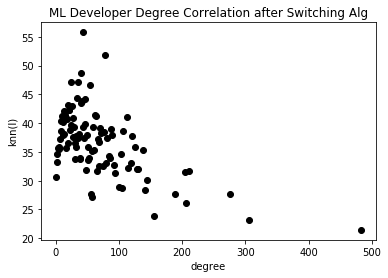

In [31]:
knn = deg_corr(gh_ml)
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x,y,c='black')
plt.xlabel("degree")
plt.ylabel("knn(l)")
plt.title("ML Developer Degree Correlation after Switching Alg")

### Question 3
 (P) Start with the original GitHub Developers graph, apply switch-ing method but instead of waiting for all edges to be switched atleast once, perform only cm edge switchings for cE{0:5,1,2} (m is  the  number  of  edges).  For  each  experiment,  plot  the  (approx-imated)  randomized  degree  correlation  functionknn(`).  Indepen-dently, check how many edges havenotbeen switched. (Aftercmedge switchings, we randomly switch 2cmedges and theoretical re-sults  imply  that  we  expecte2cfraction  of  edges  to  remain  notswitched. You may check if your experiment gives similar answer

#### For c = 0.5

In [54]:
g1 = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
g1.es['touched'] = False
ec= g1.ecount()
edges_count = int(g1.ecount())
print(edges_count)
iteration_times = int(edges_count*0.50)
print(iteration_times)
count = 0
    
while count<iteration_times:
    re = np.random.choice(ec, 2, replace=False)
    nodes = list(g1.es[re[0]].tuple+g1.es[re[1]].tuple)
    e1 = (nodes[0],nodes[2])
    e2 = (nodes[1],nodes[3])
    g1.delete_edges(re)
    g1.add_edge(e1[0],e1[1],touched=True)
    g1.add_edge(e2[0],e2[1],touched=True)
    if g1.is_simple()==False:
        g1.delete_edges(e1)
        g1.delete_edges(e2)
        g1.add_edge(nodes[0],nodes[1],touched=True)
        g1.add_edge(nodes[2],nodes[3],touched=True)
    count+=1

19684
9842


Text(0.5, 1.0, 'ML Developer Degree Correlation function Plot')

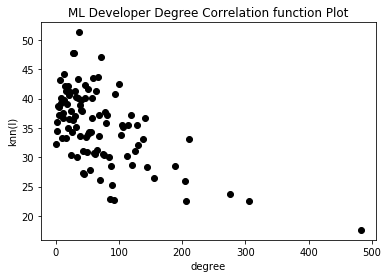

In [56]:
knn = deg_corr(g1)
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x,y,c='black')
plt.xlabel("degree")
plt.ylabel("knn(l)")
plt.title("ML Developer Degree Correlation function Plot")

In [57]:
df3 = pd.DataFrame(g1.es['touched']).value_counts()
df3

True     12413
False     7271
dtype: int64

### For c = 1

In [58]:
g1 = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
g1.es['touched'] = False
ec= g1.ecount()
edges_count = int(g1.ecount())
print(edges_count)
iteration_times = int(edges_count*1)
print(iteration_times)
count = 0
    
while count<iteration_times:
    re = np.random.choice(ec, 2, replace=False)
    nodes = list(g1.es[re[0]].tuple+g1.es[re[1]].tuple)
    e1 = (nodes[0],nodes[2])
    e2 = (nodes[1],nodes[3])
    g1.delete_edges(re)
    g1.add_edge(e1[0],e1[1],touched=True)
    g1.add_edge(e2[0],e2[1],touched=True)
    if g1.is_simple()==False:
        g1.delete_edges(e1)
        g1.delete_edges(e2)
        g1.add_edge(nodes[0],nodes[1],touched=True)
        g1.add_edge(nodes[2],nodes[3],touched=True)
    count+=1

19684
19684


Text(0.5, 1.0, 'ML Developer Degree Correlation function Plot')

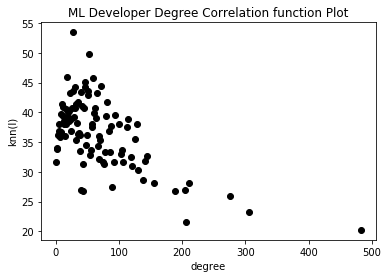

In [59]:
knn = deg_corr(g1)
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x,y,c='black')
plt.xlabel("degree")
plt.ylabel("knn(l)")
plt.title("ML Developer Degree Correlation function Plot")

In [60]:
df3 = pd.DataFrame(g1.es['touched']).value_counts()
df3

True     17060
False     2624
dtype: int64

#### For c = 2

In [61]:
g1 = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
g1.es['touched'] = False
ec= g1.ecount()
edges_count = int(g1.ecount())
print(edges_count)
iteration_times = int(edges_count*2)
print(iteration_times)
count = 0
    
while count<iteration_times:
    re = np.random.choice(ec, 2, replace=False)
    nodes = list(g1.es[re[0]].tuple+g1.es[re[1]].tuple)
    e1 = (nodes[0],nodes[2])
    e2 = (nodes[1],nodes[3])
    g1.delete_edges(re)
    g1.add_edge(e1[0],e1[1],touched=True)
    g1.add_edge(e2[0],e2[1],touched=True)
    if g1.is_simple()==False:
        g1.delete_edges(e1)
        g1.delete_edges(e2)
        g1.add_edge(nodes[0],nodes[1],touched=True)
        g1.add_edge(nodes[2],nodes[3],touched=True)
    count+=1

19684
39368


Text(0.5, 1.0, 'ML Developer Degree Correlation function Plot')

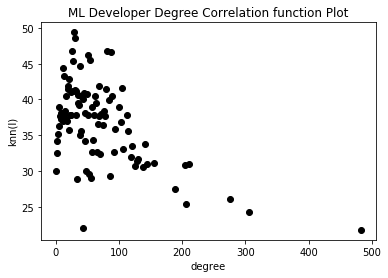

In [62]:
knn = deg_corr(g1)
x = list(knn.keys())
y = list(knn.values())
plt.scatter(x,y,c='black')
plt.xlabel("degree")
plt.ylabel("knn(l)")
plt.title("ML Developer Degree Correlation function Plot")

In [63]:
df3 = pd.DataFrame(g1.es['touched']).value_counts()
df3

True     19304
False      380
dtype: int64

### Question 4

In [69]:
## Xulvi-Brunet and Sokolov algorithm
def XBS(n, d, q, assortative):
    p = d/n
    g = ig.Graph.Erdos_Renyi(n,p)
    g.es['touched'] = False
    ec = g.ecount()
    while True:
        re = np.random.choice(ec, 2, replace=False)
        nodes = list(g.es[re[0]].tuple+g.es[re[1]].tuple)
        if len(set(nodes))==4:
            ## with proba q, wire w.r.t. assortativity, else randomly
            if np.random.random()<q:
                idx = np.argsort(g.degree(nodes))
                if assortative:
                    e1 = (nodes[idx[0]],nodes[idx[1]])
                    e2 = (nodes[idx[2]],nodes[idx[3]])
                else:
                    e1 = (nodes[idx[0]],nodes[idx[3]])
                    e2 = (nodes[idx[1]],nodes[idx[2]])
            else:
                np.random.shuffle(nodes)
                e1 = (nodes[0],nodes[1])
                e2 = (nodes[2],nodes[3])
            if g.get_eid(e1[0], e1[1], directed=False, error=False)+\
               g.get_eid(e2[0], e2[1], directed=False, error=False) == -2:
                    g.delete_edges(re)
                    g.add_edge(e1[0],e1[1],touched=True)
                    g.add_edge(e2[0],e2[1],touched=True)
            else:
                g.es[re[0]]['touched']=True
                g.es[re[1]]['touched']=True
        if sum(g.es['touched']) == g.ecount():
            break
    return g


In [70]:
## Fig 4.2 with N nodes and averaging Rep results
N = 2**8 ## 2**16 and 64 in book
Rep = 10
Q = [2/3,1/3,0,1/3,2/3]
A = [True,True,True,False,False]
x = np.arange(0.25,3.01,.25)
Y = []

for i in range(len(Q)):
    y = []
    for d in x:
        sz = 0
        for rep in range(Rep):
            g = XBS(n = N, d = d, q = Q[i] , assortative = A[i])
            vc = g.vcount()
            dist = 0
            #pick two random nodes from the graph
            nodes = np.random.choice(vc, 2, replace = False)
            node1 = nodes[0]
            node2 = nodes[1]
            #find the distance between two nodes using shortest_path
            dist = g.shortest_paths_dijkstra(node1, node2)
            if dist=="inf":
                nodes = np.random.choice(vc, 2, replace = False)
                node1 = nodes[0]
                node2 = nodes[1]
                dist = g.shortest_paths(node1, node2)
            else:
                dist = dist
            #since we have to find average distance so took mean    
            sz = np.mean(dist)
        y.append(sz/Rep)
    Y.append(y)
    print(Y)



[[inf, inf, inf, inf, inf, 0.6, inf, inf, inf, inf, 0.8, inf]]
[[inf, inf, inf, inf, inf, 0.6, inf, inf, inf, inf, 0.8, inf], [inf, inf, inf, inf, inf, inf, inf, 1.2, 1.3, inf, 0.6, 0.5]]
[[inf, inf, inf, inf, inf, 0.6, inf, inf, inf, inf, 0.8, inf], [inf, inf, inf, inf, inf, inf, inf, 1.2, 1.3, inf, 0.6, 0.5], [inf, inf, inf, inf, inf, inf, 0.7, inf, 0.7, 0.6, 0.5, 0.6]]
[[inf, inf, inf, inf, inf, 0.6, inf, inf, inf, inf, 0.8, inf], [inf, inf, inf, inf, inf, inf, inf, 1.2, 1.3, inf, 0.6, 0.5], [inf, inf, inf, inf, inf, inf, 0.7, inf, 0.7, 0.6, 0.5, 0.6], [inf, inf, inf, inf, inf, 0.2, 1.3, 0.8, inf, 0.6, 0.2, 0.5]]
[[inf, inf, inf, inf, inf, 0.6, inf, inf, inf, inf, 0.8, inf], [inf, inf, inf, inf, inf, inf, inf, 1.2, 1.3, inf, 0.6, 0.5], [inf, inf, inf, inf, inf, inf, 0.7, inf, 0.7, 0.6, 0.5, 0.6], [inf, inf, inf, inf, inf, 0.2, 1.3, 0.8, inf, 0.6, 0.2, 0.5], [inf, inf, inf, inf, inf, inf, inf, 1.1, inf, 0.9, 0.3, 0.4]]


In [71]:
df=pd.DataFrame(Y[0])
#replacing inf values with 0
df[0].replace(np.inf, 0, inplace = True)
Y[0] = df[0].tolist()
#sort the values in ascending order
Y[0].sort()

df=pd.DataFrame(Y[1])
df[0].replace(np.inf, 0, inplace = True)
Y[1] = df[0].tolist()
Y[1].sort()

df=pd.DataFrame(Y[2])
df[0].replace(np.inf, 0, inplace = True)
Y[2] = df[0].tolist()
Y[2].sort()

df=pd.DataFrame(Y[3])
df[0].replace(np.inf, 0, inplace = True)
Y[3] = df[0].tolist()
Y[3].sort()

df=pd.DataFrame(Y[4])
df[0].replace(np.inf, 0, inplace = True)
Y[4] = df[0].tolist()
Y[4].sort()

print(Y[0], Y[1], Y[2], Y[3], Y[4])


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.8] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.6, 1.2, 1.3] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.6, 0.6, 0.7, 0.7] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.5, 0.6, 0.8, 1.3] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.4, 0.9, 1.1]


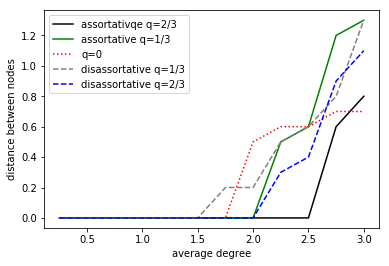

In [72]:
clr = ['black','green','red','gray','blue']
typ = ['-','-',':','--','--']
lbl = ['assortativqe q=2/3','assortative q=1/3','q=0','disassortative q=1/3','disassortative q=2/3']
for i in range(len(Y)):
    plt.plot(x,Y[i],color=clr[i],linestyle=typ[i],label=lbl[i])
plt.xlabel('average degree')
plt.ylabel('distance between nodes')
plt.legend();